# Introduction

This work will be focused on removing outlier data from ICP-MS data.

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import random
import os
from sklearn.cluster import KMeans

In [159]:
from utils.OutlierUtils import remove_outliers_by_region
from utils.OutlierUtils import get_area
from utils.OutlierUtils import get_motive_points
from utils.OutlierUtils import sanitize_response_name
from utils.OutlierUtils import left_derivatives
from utils.OutlierUtils import merge_close_points

In [160]:
# This cell is tagged with 'parameters'
output_path = './output/first_attempt'
path_to_data = './data/Stds_052125.csv'
response_index = 0
report_title = "Example Report"
threshold_value = .9

In [161]:
# Import data
df = pd.read_csv(path_to_data)
t = df['Time']
t.max()

np.float64(7812.145)

In [162]:
# set the response data
responses = df.drop(columns=['Replicate', 'Reading', 'Time'])        
response = responses.columns[response_index]
response_data = df[response]

In [163]:
# creat output folder
os.makedirs(f'{output_path}', exist_ok=True)

#create dataset path
dataset_name = path_to_data.split('/')[-1].split('.')[0]
dataset_path = f'{output_path}/{dataset_name}'

os.makedirs(dataset_path, exist_ok=True)

In [164]:
safe_name = sanitize_response_name(response)
figure_dir = f'{dataset_path}/figures/{safe_name}'
os.makedirs(figure_dir, exist_ok=True)

In [165]:
# Identifying shifts with k-means
X = collections.deque(t)
Y = collections.deque(response_data)

In [166]:
df_km = df.loc[:, df.columns.intersection(['Time',f'{response}'])]
df_km_response_idxMax = df_km.idxmax()[response]
df_km = df_km.iloc[:df_km_response_idxMax+1]
df_km

Time  Ti -/48(Pulse/CPS)
0         0.000          180.001134
1         0.432          340.004046
2         0.864          260.002366
3         1.296          360.004536
4         1.728          240.002016
...         ...                 ...
17057  7368.897       196968.584800
17058  7369.329       256481.919600
17059  7369.761       288687.743500
17060  7370.193       299078.241200
17061  7370.625       321783.705100

[17062 rows x 2 columns]

In [167]:
n_clusters = 7
kmeans = KMeans(
     init="random",
     n_clusters=n_clusters,
     random_state=42
 )

Y_hat = kmeans.fit(df_km)

centroids = Y_hat.cluster_centers_
labels = Y_hat.labels_

labels_df = pd.DataFrame(labels)

indices = labels_df[labels_df.iloc[:, 0] == 0]


changes_at = -1

for i,idx in enumerate(indices.index.tolist()):
    print(idx)
    if (indices.index[i+1] != idx+1):
        changes_at = i
        break




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [168]:
times_in_cluster = df_km.iloc[labels == 0, 0]
times_in_cluster = times_in_cluster[times_in_cluster.index <= changes_at]

first_region = times_in_cluster.max()
first_region
detected_intervals = [(np.float64(0),first_region)]

In [169]:
# Identify dataset for clustering
# Since data is always increasing, we can remove everything after the maximum point for clustering
df_c = df.loc[:, df.columns.intersection(['Time',f'{response}'])]
df_c_response_idxMax = df_c.idxmax()[response]
df_c = df_c.iloc[:df_c_response_idxMax+1]
df_c


Time  Ti -/48(Pulse/CPS)
0         0.000          180.001134
1         0.432          340.004046
2         0.864          260.002366
3         1.296          360.004536
4         1.728          240.002016
...         ...                 ...
17057  7368.897       196968.584800
17058  7369.329       256481.919600
17059  7369.761       288687.743500
17060  7370.193       299078.241200
17061  7370.625       321783.705100

[17062 rows x 2 columns]

In [170]:
# Get left derivatives
left_derivatives_df_c = left_derivatives(df_c['Time'].to_numpy(), df_c[response].to_numpy())
display(left_derivatives_df_c)

Time              Y  Left_Derivative
0         0.000     180.001134       370.377111
1         0.432     340.004046      -185.189074
2         0.864     260.002366       231.486505
3         1.296     360.004536      -277.783611
4         1.728     240.002016       277.783611
...         ...            ...              ...
17057  7368.897  196968.584800    137762.349074
17058  7369.329  256481.919600     74550.518287
17059  7369.761  288687.743500     24052.078009
17060  7370.193  299078.241200     52558.944213
17061  7370.625  321783.705100        -1.000000

[17062 rows x 3 columns]

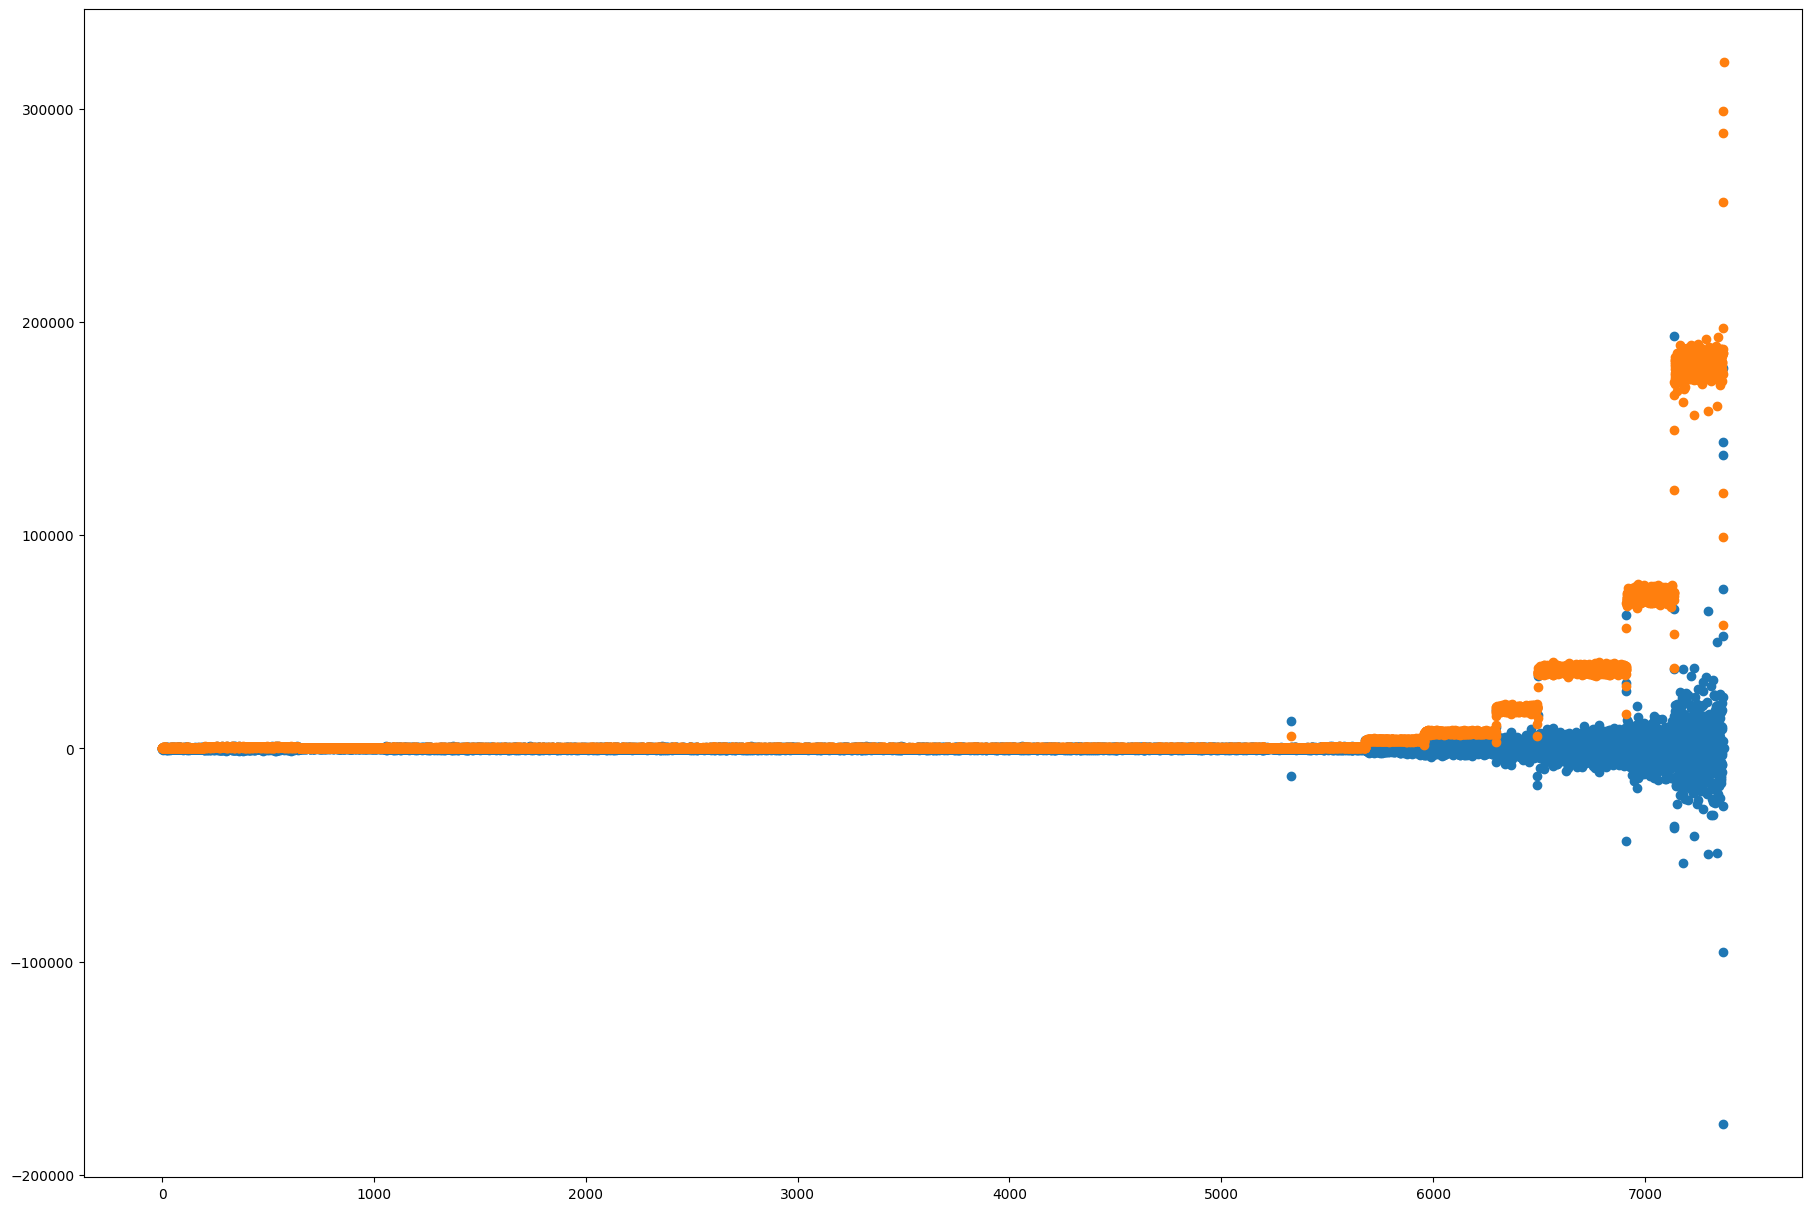

In [171]:
fig, ax1 = plt.subplots(figsize=(18, 12), layout='constrained') # Increased figure size for clarity
plt.scatter(left_derivatives_df_c['Time'], left_derivatives_df_c['Left_Derivative'])
plt.scatter(df_c['Time'], df_c[response])

# Save derivative and data pllot
plt.savefig(f'{output_path}/{dataset_name}/Derivative-Data-Plot', bbox_inches='tight',dpi=300)

In [172]:
left_derivatives_df_c = left_derivatives_df_c[left_derivatives_df_c['Time'] > first_region]
shifts = left_derivatives_df_c[left_derivatives_df_c['Left_Derivative'] > left_derivatives_df_c['Y']]

# Shifts are defined where the f(x) > f'(x) after the starting region
shifts = shifts.reset_index(drop=True)
shifts = shifts['Time']
display(shifts)

detected_intervals.append((detected_intervals[0][1], shifts.min()))
detected_intervals = sorted(detected_intervals)

display(detected_intervals)


0       1699.982
1       1700.415
2       1702.575
3       1703.007
4       1706.895
          ...   
1807    6910.960
1808    6911.392
1809    7136.904
1810    7368.033
1811    7368.465
Name: Time, Length: 1812, dtype: float64

[(np.float64(0.0), np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982))]

In [173]:
for i in range(len(shifts)-1):
    start_p = shifts.iloc[i]
    next_p = shifts.iloc[i+1]
    detected_intervals.append((start_p, next_p))

detected_intervals.append((detected_intervals[-1][1], left_derivatives_df_c['Time'].max()))
detected_intervals

[(np.float64(0.0), np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (np.float64(1699.982), np.float64(1700.415)),
 (np.float64(1700.415), np.float64(1702.575)),
 (np.float64(1702.575), np.float64(1703.007)),
 (np.float64(1703.007), np.float64(1706.895)),
 (np.float64(1706.895), np.float64(1707.759)),
 (np.float64(1707.759), np.float64(1710.783)),
 (np.float64(1710.783), np.float64(1712.943)),
 (np.float64(1712.943), np.float64(1713.375)),
 (np.float64(1713.375), np.float64(1718.127)),
 (np.float64(1718.127), np.float64(1720.287)),
 (np.float64(1720.287), np.float64(1721.151)),
 (np.float64(1721.151), np.float64(1724.175)),
 (np.float64(1724.175), np.float64(1725.039)),
 (np.float64(1725.039), np.float64(1725.903)),
 (np.float64(1725.903), np.float64(1726.767)),
 (np.float64(1726.767), np.float64(1727.632)),
 (np.float64(1727.632), np.float64(1729.792)),
 (np.float64(1729.792), np.float64(1733.248)),
 (np.float64(1733.248), np.float64(1734.976)),
 (np.float64(1734.97

In [174]:
# Iterate through the detected intervals and shade them
for i, (start_time, end_time) in enumerate(detected_intervals):
    # Generate a random color for each interval for better distinction
    random_color = (random.random(), random.random(), random.random())
    # Use axvspan to shade the region
    ax1.axvspan(start_time, end_time, color=random_color, alpha=0.3, 
                label=f'Interval {i+1}' if i == 0 else "") # Label only the first span for legend




--- Testing with min_distance = 50 ---
Number of merged points for min_distance 50: 85
Detected intervals for min_distance 50:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 1752.256),
 (np.float64(1699.982), np.float64(7370.625)),
 (1752.256, 1803.666),
 (1803.666, 1855.94),
 (1855.94, 1906.918),
 (1906.918, 1957.032),
 (1957.032, 2010.17),
 (2010.17, 2061.58),
 (2061.58, 2112.558),
 (2112.558, 2163.104),
 (2163.104, 2213.218),
 (2213.218, 2265.059),
 (2265.059, 2318.197),
 (2318.197, 2368.311),
 (2368.311, 2420.585),
 (2420.585, 2477.611),
 (2477.611, 2530.749),
 (2530.749, 2580.863),
 (2580.863, 2630.977),
 (2630.977, 2681.955),
 (2681.955, 2732.933),
 (2732.933, 2783.911),
 (2783.911, 2835.753),
 (2835.753, 2886.298),
 (2886.298, 2937.276),
 (2937.276, 2989.118),
 (2989.118, 3041.824),
 (3041.824, 3093.666),
 (3093.666, 3144.212),
 (3144.212, 3196.054),
 (3196.054, 3248.328),
 (3248.328, 3298.442),
 (3298.442, 3350.284),
 (3350.284, 3402.126),
 (3402.126, 3453.535),
 (3453.535, 3503.649),
 (3503.649, 3553.763),
 (3553.763, 3603.877),
 (3603.877, 3654.855),
 (3654.855, 

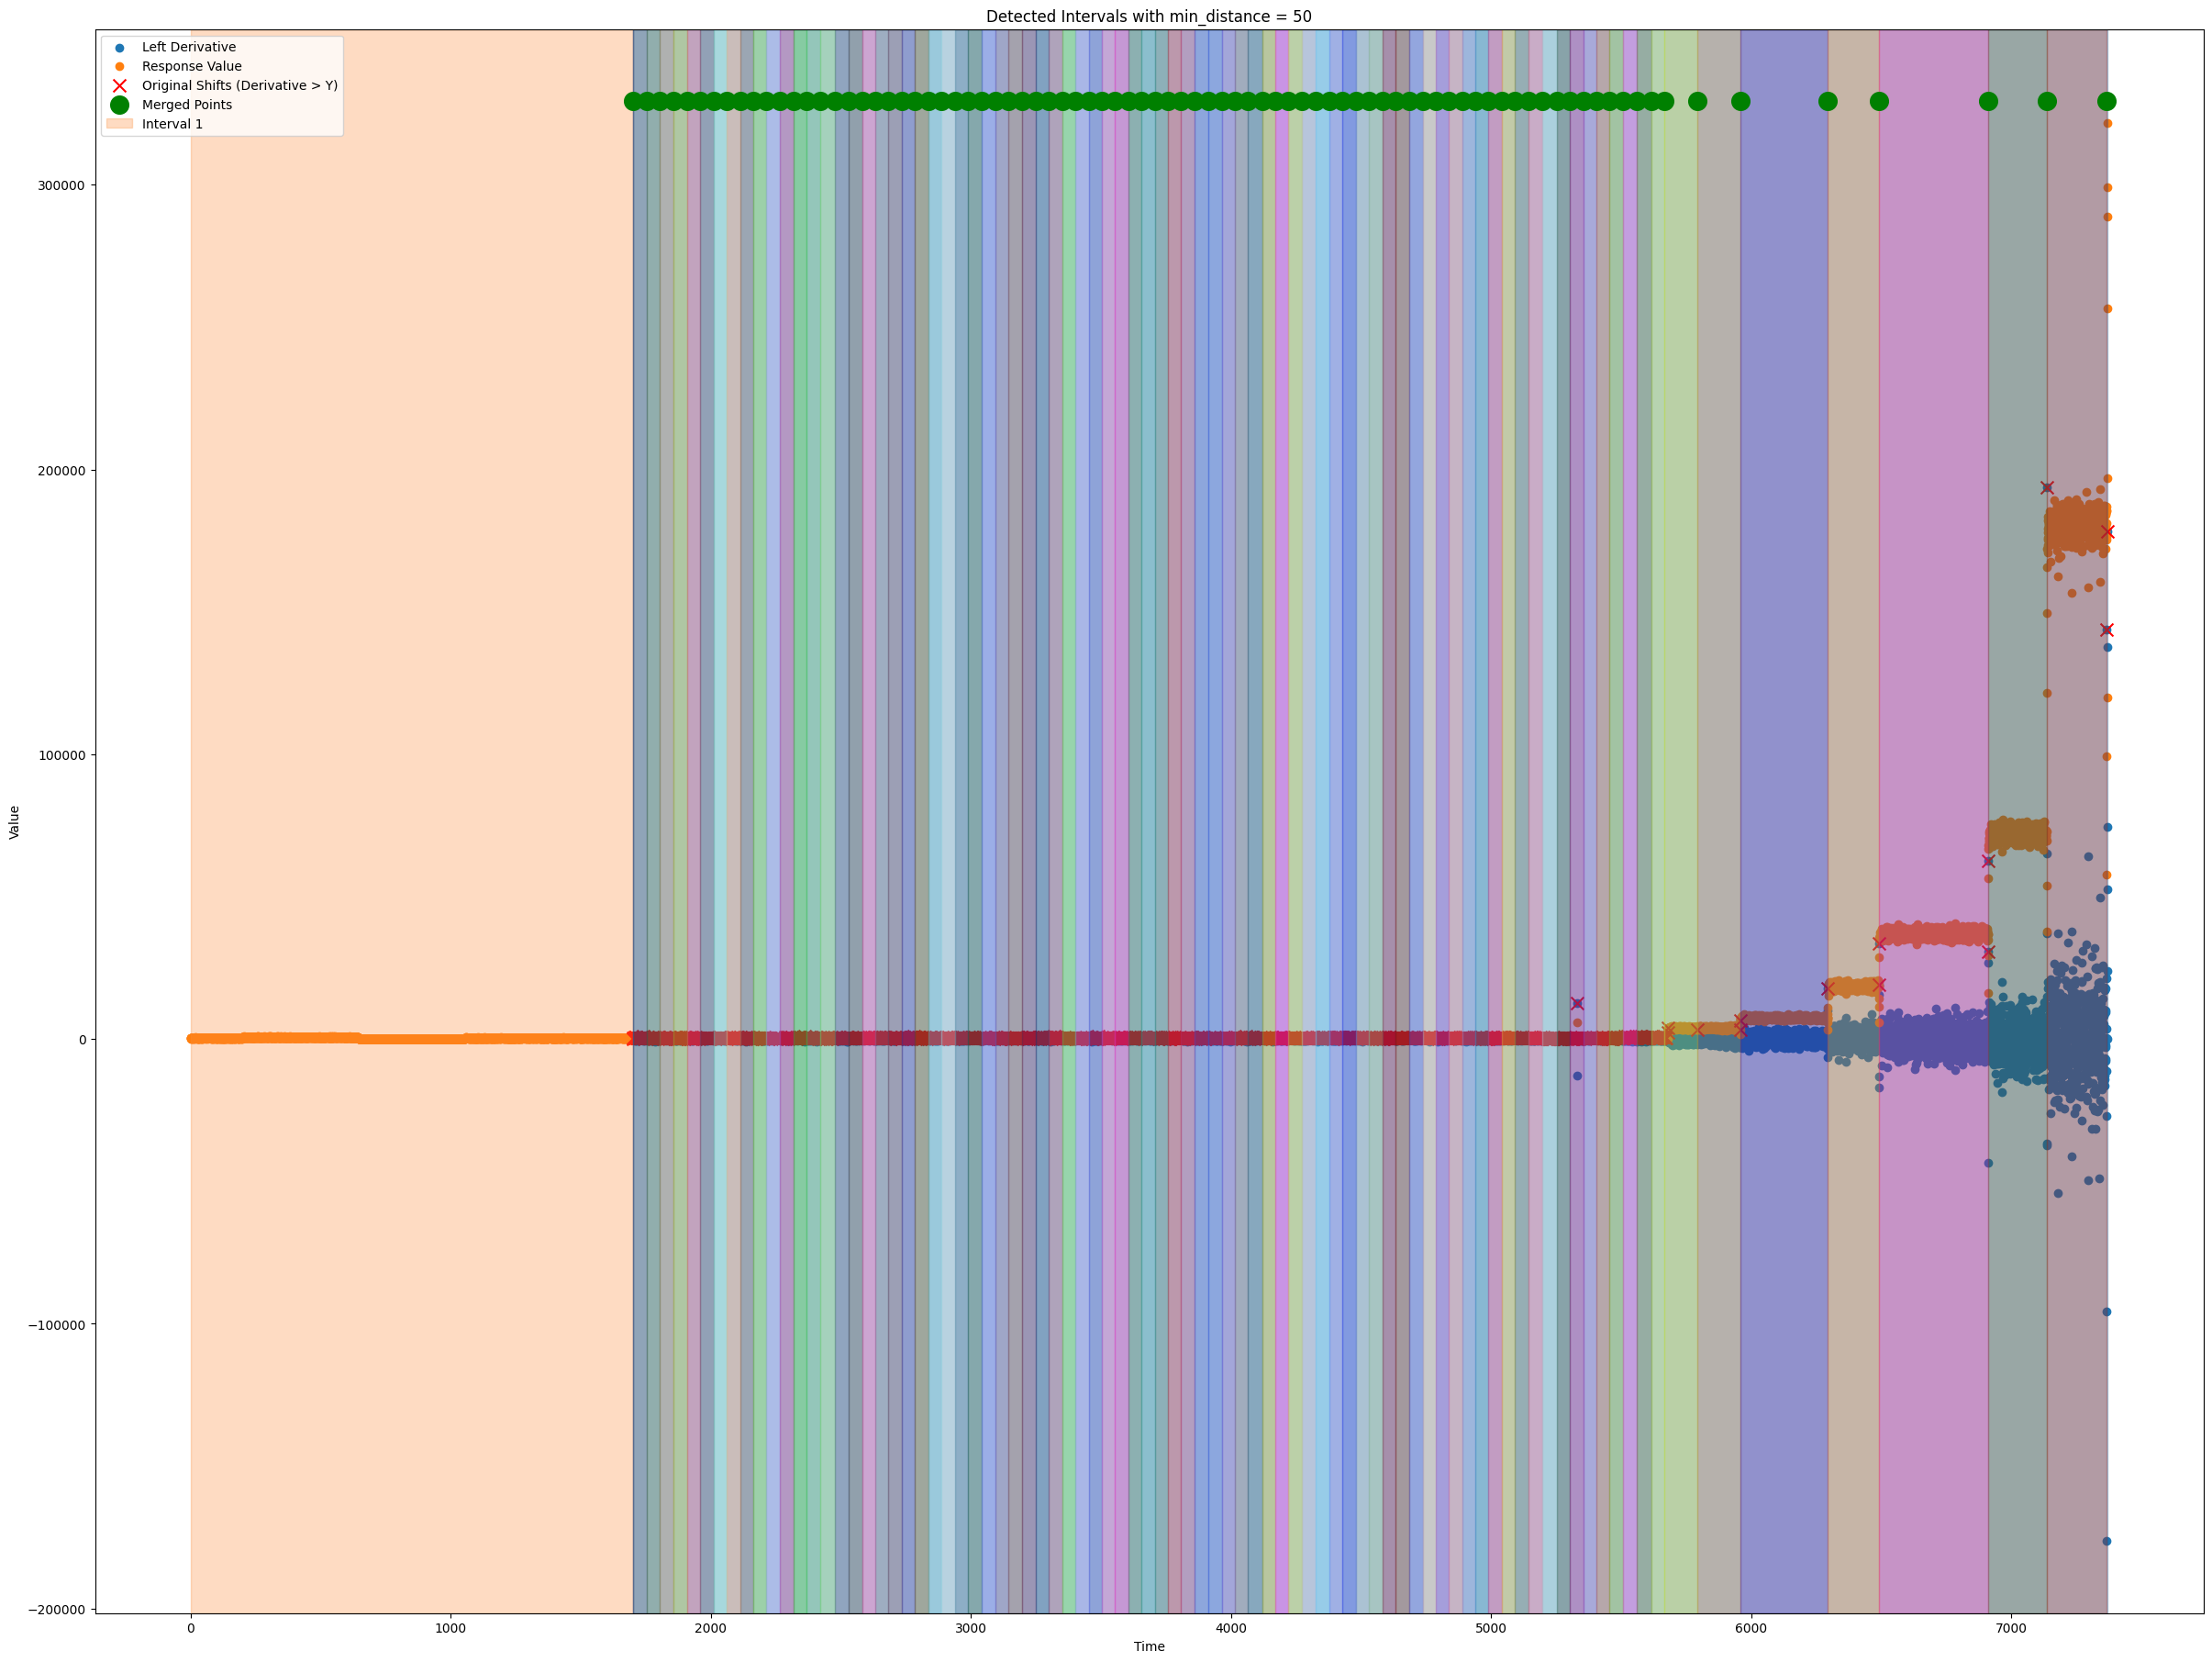


--- Testing with min_distance = 70 ---
Number of merged points for min_distance 70: 63
Detected intervals for min_distance 70:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 1772.993),
 (np.float64(1699.982), np.float64(7370.625)),
 (1772.993, 1846.004),
 (1846.004, 1916.423),
 (1916.423, 1986.841),
 (1986.841, 2057.26),
 (2057.26, 2129.838),
 (2129.838, 2200.257),
 (2200.257, 2274.564),
 (2274.564, 2344.982),
 (2344.982, 2420.585),
 (2420.585, 2492.732),
 (2492.732, 2565.743),
 (2565.743, 2637.025),
 (2637.025, 2707.444),
 (2707.444, 2779.59),
 (2779.59, 2854.329),
 (2854.329, 2926.908),
 (2926.908, 2999.055),
 (2999.055, 3072.929),
 (3072.929, 3144.212),
 (3144.212, 3215.063),
 (3215.063, 3287.209),
 (3287.209, 3359.356),
 (3359.356, 3431.071),
 (3431.071, 3502.785),
 (3502.785, 3574.932),
 (3574.932, 3646.215),
 (3646.215, 3726.138),
 (3726.138, 3797.42),
 (3797.42, 3869.999),
 (3869.999, 3940.85),
 (3940.85, 4013.86),
 (4013.86, 4086.871),
 (4086.871, 4157.722),
 (4157.722, 4228.14),
 (4228.14, 4299.855),
 (4299.855, 4378.482),
 (4378.482, 4448.9),
 (4448.9, 4519.751),

<Figure size 640x480 with 0 Axes>

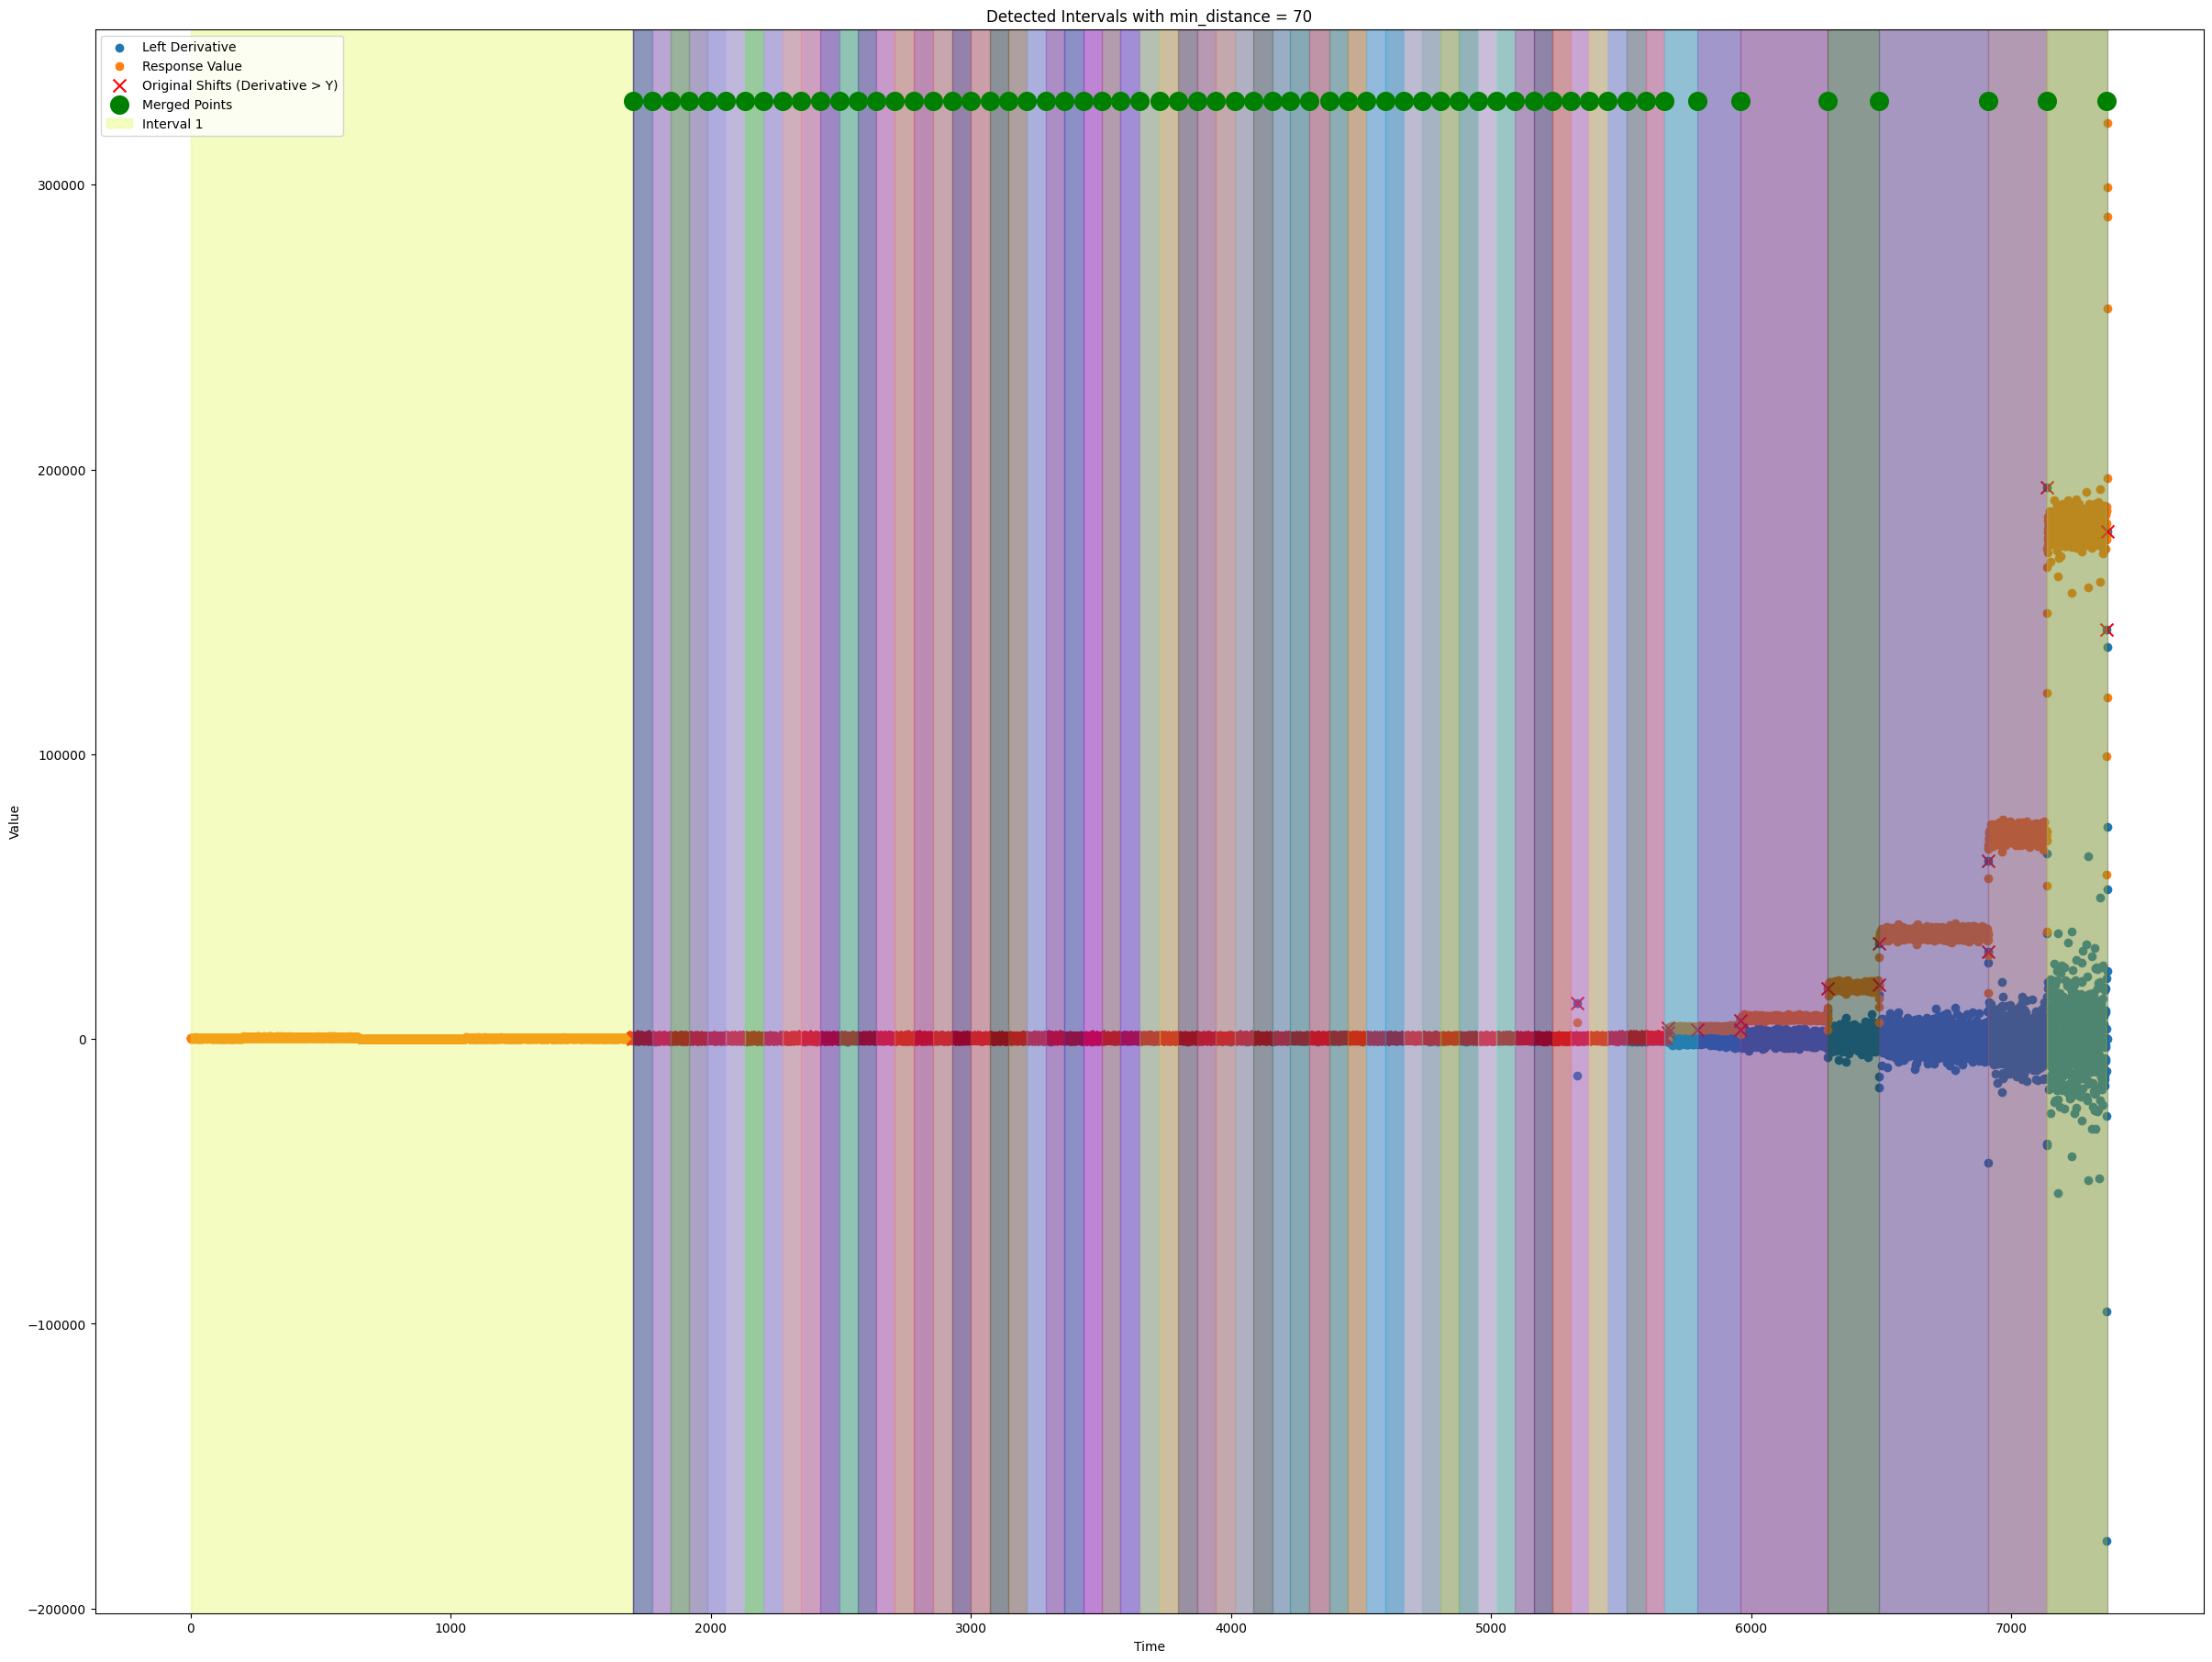


--- Testing with min_distance = 90 ---
Number of merged points for min_distance 90: 51
Detected intervals for min_distance 90:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 1794.594),
 (np.float64(1699.982), np.float64(7370.625)),
 (1794.594, 1886.181),
 (1886.181, 1978.201),
 (1978.201, 2070.652),
 (2070.652, 2163.104),
 (2163.104, 2254.259),
 (2254.259, 2344.982),
 (2344.982, 2437.002),
 (2437.002, 2527.293),
 (2527.293, 2618.881),
 (2618.881, 2709.172),
 (2709.172, 2799.895),
 (2799.895, 2890.187),
 (2890.187, 2980.478),
 (2980.478, 3072.929),
 (3072.929, 3167.109),
 (3167.109, 3257.4),
 (3257.4, 3348.124),
 (3348.124, 3440.575),
 (3440.575, 3532.162),
 (3532.162, 3622.886),
 (3622.886, 3714.905),
 (3714.905, 3806.061),
 (3806.061, 3899.808),
 (3899.808, 3991.395),
 (3991.395, 4081.687),
 (4081.687, 4172.41),
 (4172.41, 4262.701),
 (4262.701, 4355.585),
 (4355.585, 4448.9),
 (4448.9, 4543.08),
 (4543.08, 4633.803),
 (4633.803, 4727.551),
 (4727.551, 4820.434),
 (4820.434, 4911.589),
 (4911.589, 5004.905),
 (5004.905, 5097.788),
 (5097.788, 5188.512),
 (5188.512, 5280.9

<Figure size 640x480 with 0 Axes>

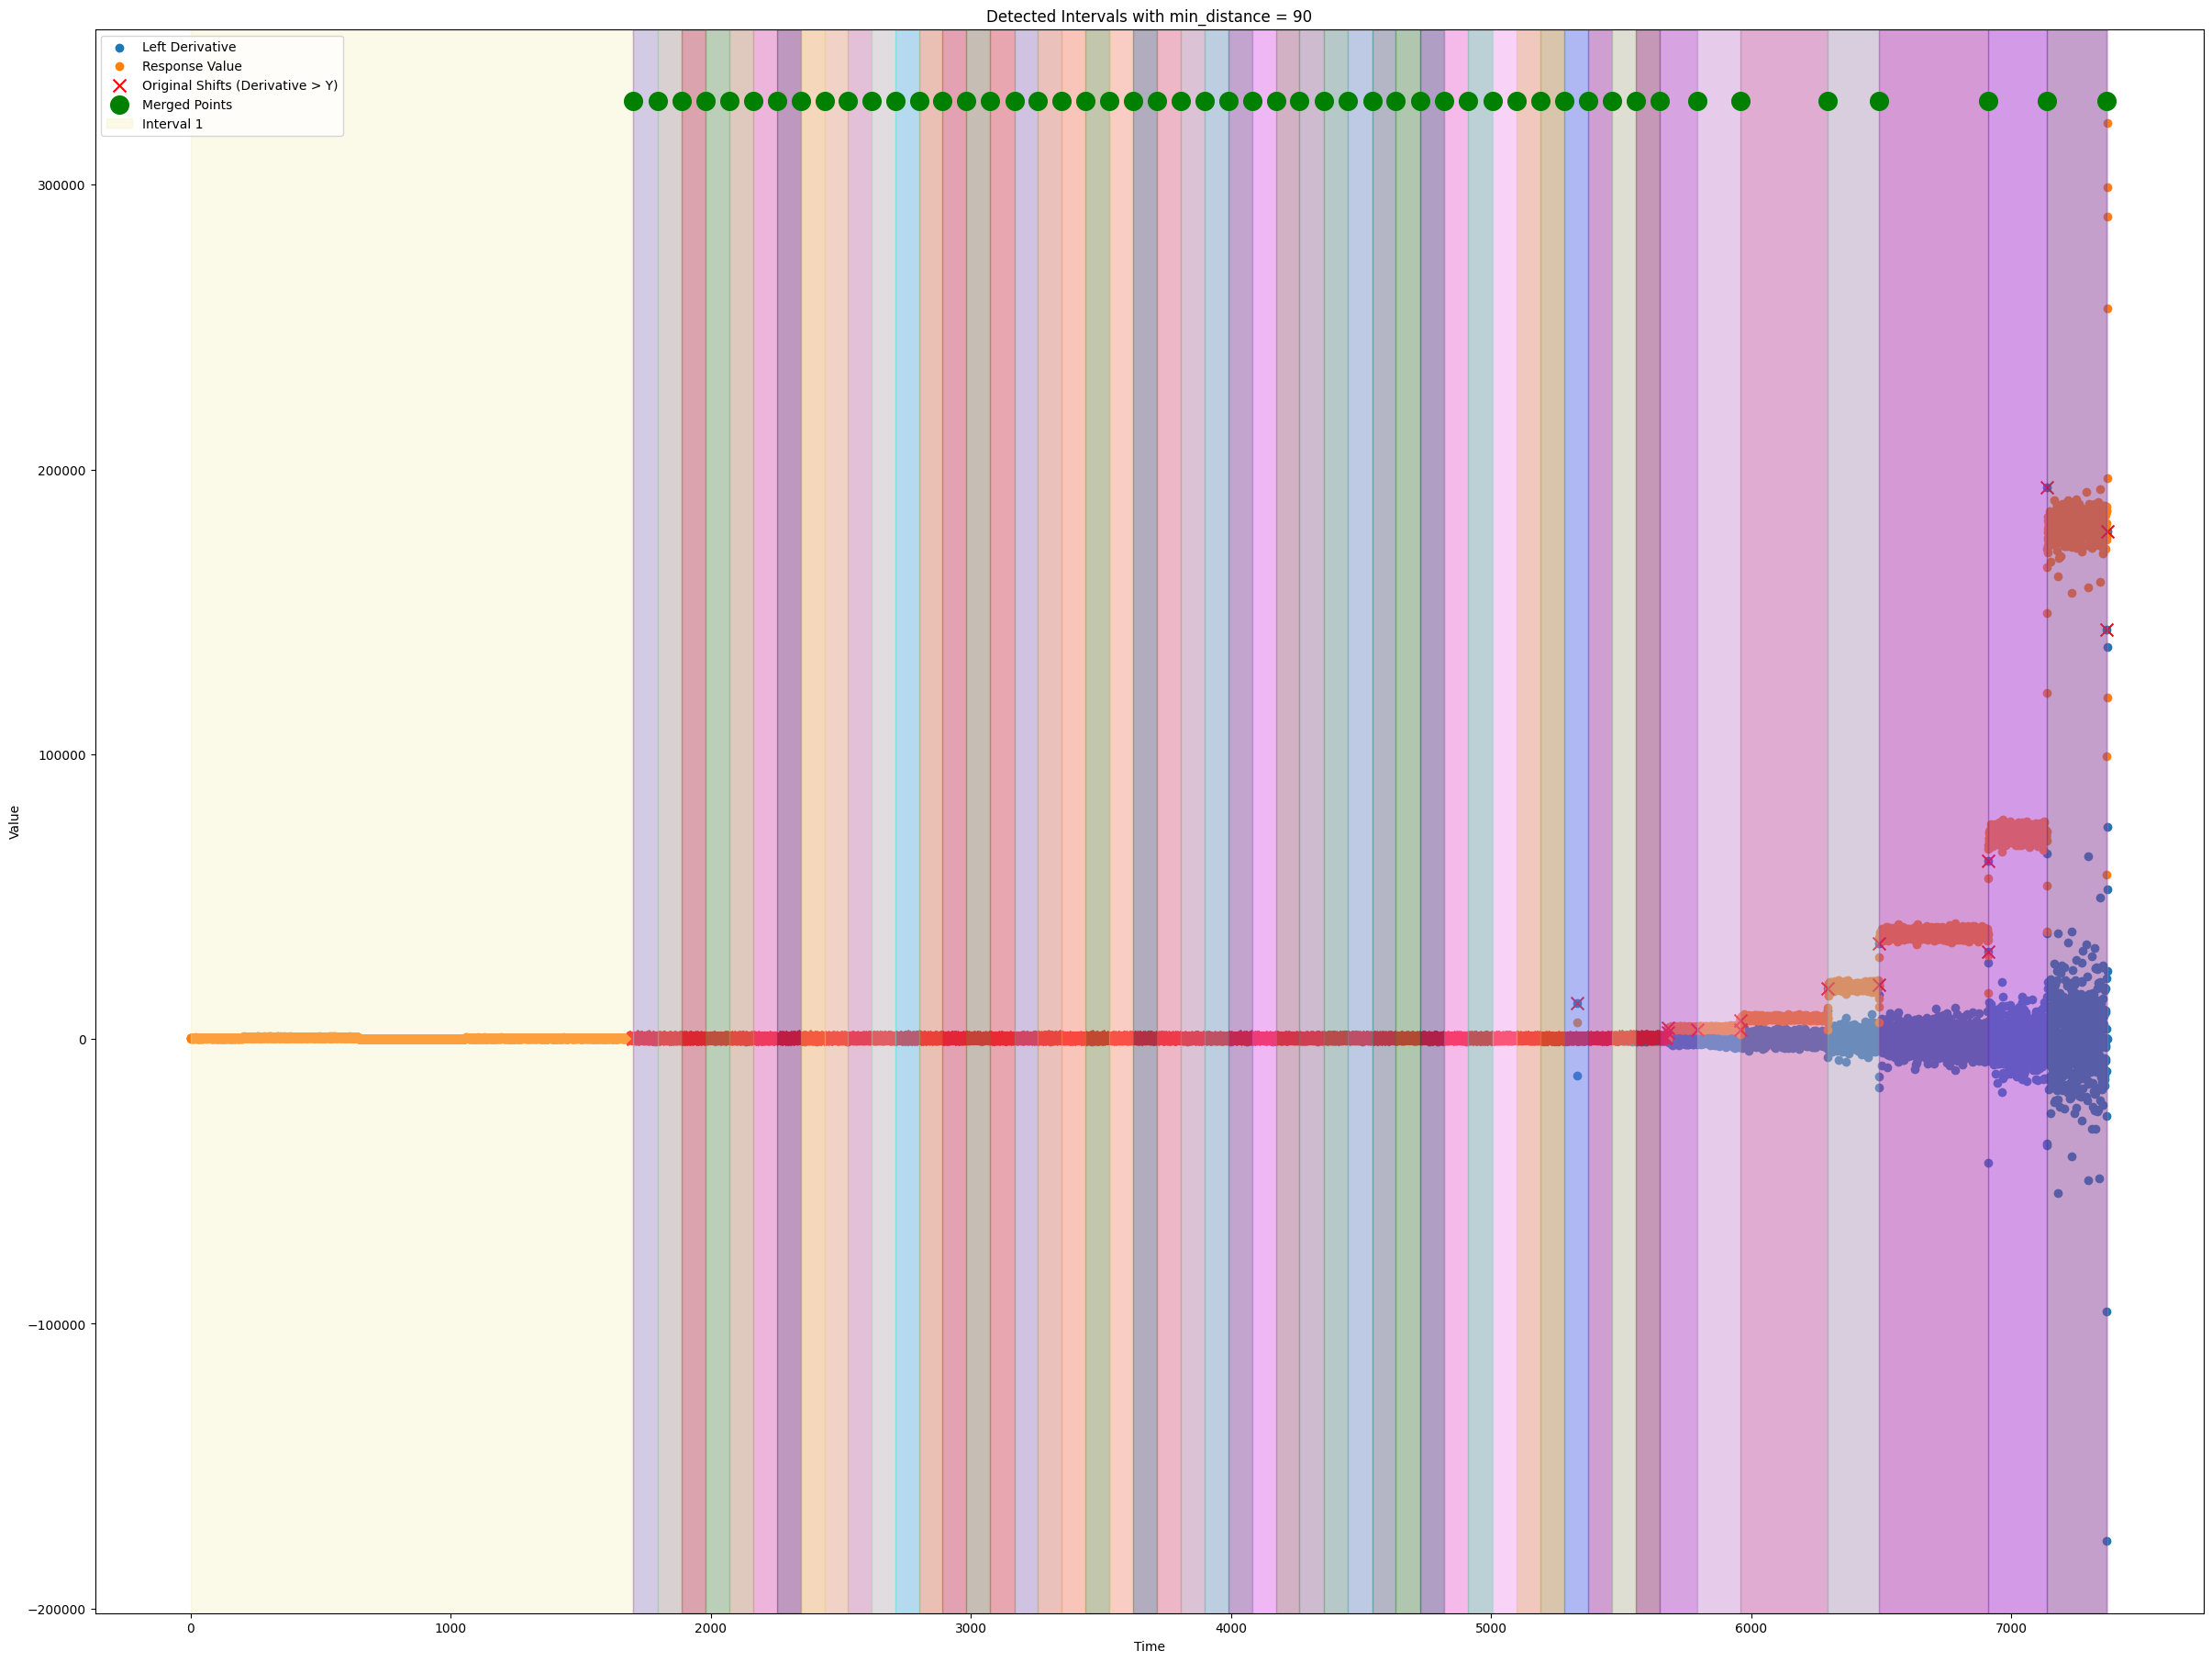


--- Testing with min_distance = 110 ---
Number of merged points for min_distance 110: 43
Detected intervals for min_distance 110:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 1811.443),
 (np.float64(1699.982), np.float64(7370.625)),
 (1811.443, 1921.607),
 (1921.607, 2032.203),
 (2032.203, 2142.799),
 (2142.799, 2254.259),
 (2254.259, 2368.311),
 (2368.311, 2480.635),
 (2480.635, 2590.8),
 (2590.8, 2702.26),
 (2702.26, 2812.424),
 (2812.424, 2924.316),
 (2924.316, 3034.912),
 (3034.912, 3146.372),
 (3146.372, 3256.968),
 (3256.968, 3368.86),
 (3368.86, 3481.184),
 (3481.184, 3591.349),
 (3591.349, 3702.377),
 (3702.377, 3814.269),
 (3814.269, 3925.297),
 (3925.297, 4038.485),
 (4038.485, 4149.945),
 (4149.945, 4261.837),
 (4261.837, 4378.482),
 (4378.482, 4490.806),
 (4490.806, 4602.698),
 (4602.698, 4715.454),
 (4715.454, 4826.482),
 (4826.482, 4938.374),
 (4938.374, 5048.539),
 (5048.539, 5160.863),
 (5160.863, 5272.323),
 (5272.323, 5382.487),
 (5382.487, 5496.107),
 (5496.107, 5606.703),
 (5606.703, 5792.902),
 (5792.902, 5957.068),
 (5957.068, 6294.905),
 (6294.905, 64

<Figure size 640x480 with 0 Axes>

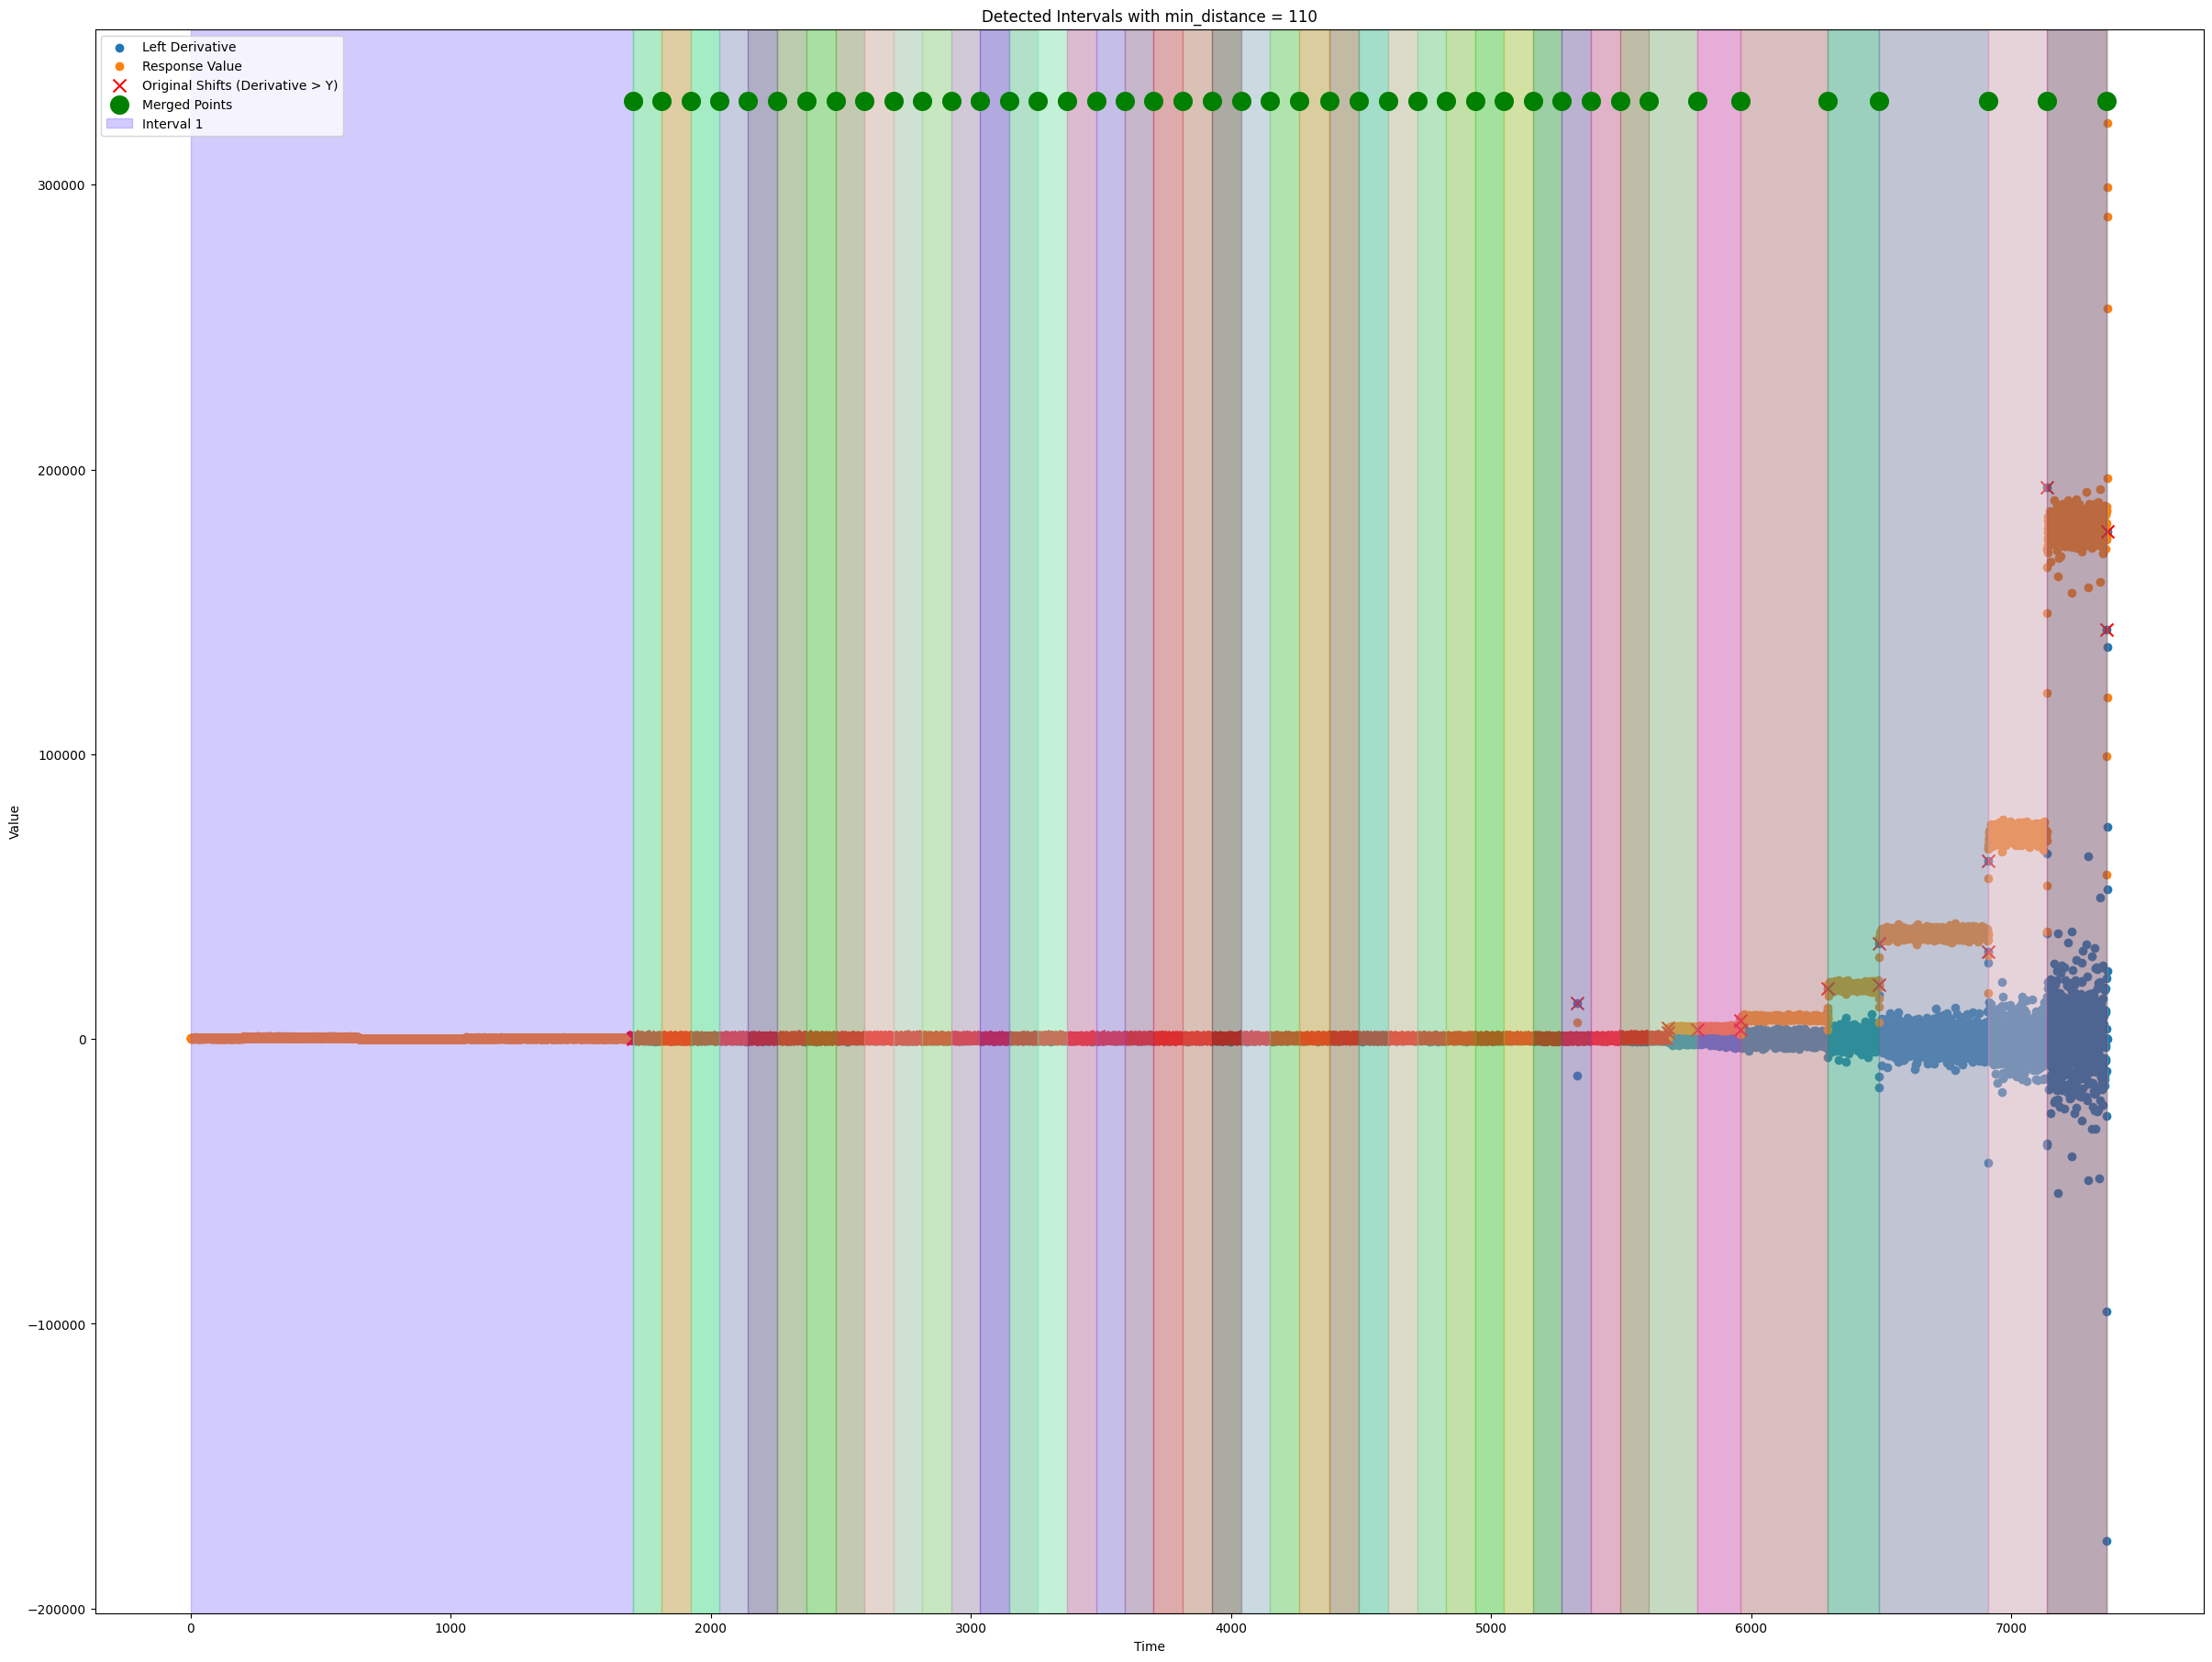


--- Testing with min_distance = 130 ---
Number of merged points for min_distance 130: 38
Detected intervals for min_distance 130:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 1830.451),
 (np.float64(1699.982), np.float64(7370.625)),
 (1830.451, 1960.92),
 (1960.92, 2090.957),
 (2090.957, 2221.426),
 (2221.426, 2351.463),
 (2351.463, 2484.524),
 (2484.524, 2614.992),
 (2614.992, 2745.029),
 (2745.029, 2879.386),
 (2879.386, 3009.423),
 (3009.423, 3139.892),
 (3139.892, 3270.361),
 (3270.361, 3402.126),
 (3402.126, 3532.162),
 (3532.162, 3663.927),
 (3663.927, 3797.42),
 (3797.42, 3928.321),
 (3928.321, 4058.79),
 (4058.79, 4190.555),
 (4190.555, 4323.616),
 (4323.616, 4454.517),
 (4454.517, 4584.553),
 (4584.553, 4715.454),
 (4715.454, 4849.811),
 (4849.811, 4979.848),
 (4979.848, 5109.885),
 (5109.885, 5241.218),
 (5241.218, 5372.983),
 (5372.983, 5503.883),
 (5503.883, 5635.216),
 (5635.216, 5792.902),
 (5792.902, 5957.068),
 (5957.068, 6294.905),
 (6294.905, 6491.904),
 (6491.904, 6910.96),
 (6910.96, 7136.904),
 (7136.904, 7368.033)]

<Figure size 640x480 with 0 Axes>

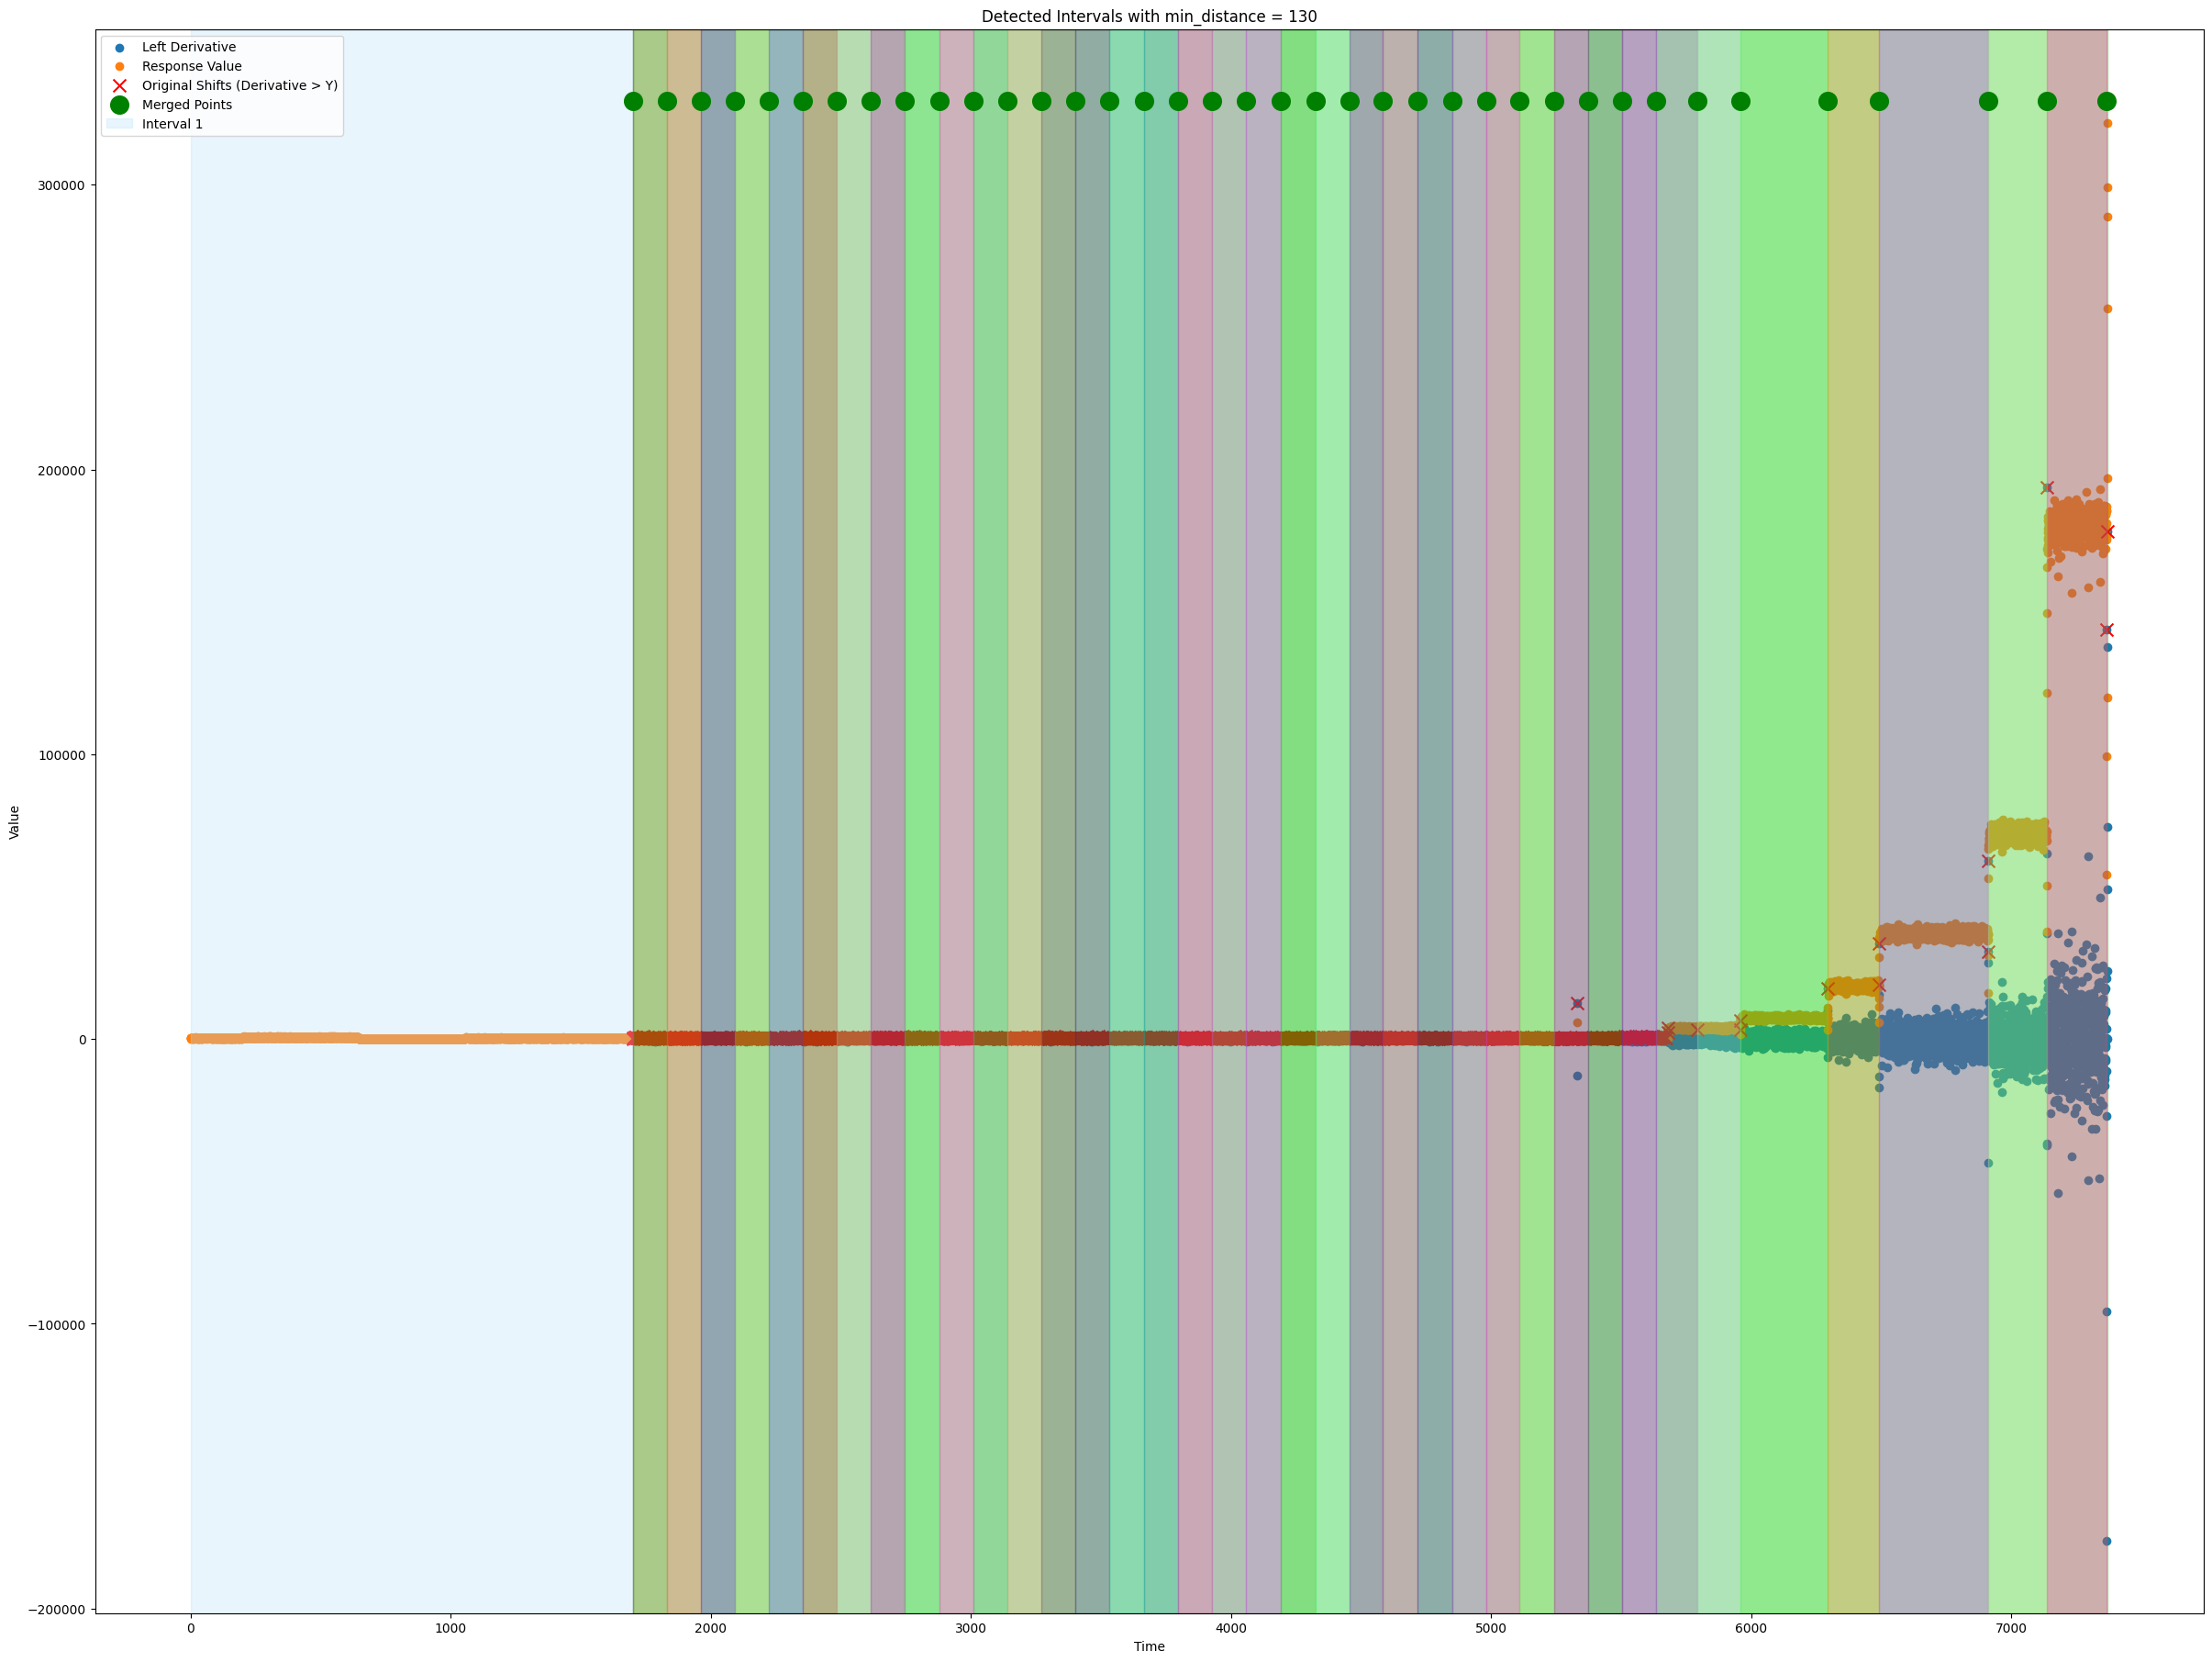


--- Testing with min_distance = 150 ---
Number of merged points for min_distance 150: 34
Detected intervals for min_distance 150:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 1852.052),
 (np.float64(1699.982), np.float64(7370.625)),
 (1852.052, 2005.418),
 (2005.418, 2155.759),
 (2155.759, 2306.101),
 (2306.101, 2457.307),
 (2457.307, 2608.944),
 (2608.944, 2759.718),
 (2759.718, 2911.355),
 (2911.355, 3066.449),
 (3066.449, 3216.791),
 (3216.791, 3368.86),
 (3368.86, 3519.202),
 (3519.202, 3669.975),
 (3669.975, 3822.045),
 (3822.045, 3974.979),
 (3974.979, 4128.344),
 (4128.344, 4279.118),
 (4279.118, 4430.324),
 (4430.324, 4581.529),
 (4581.529, 4733.599),
 (4733.599, 4883.94),
 (4883.94, 5034.282),
 (5034.282, 5186.352),
 (5186.352, 5337.557),
 (5337.557, 5488.331),
 (5488.331, 5639.968),
 (5639.968, 5792.902),
 (5792.902, 5957.068),
 (5957.068, 6294.905),
 (6294.905, 6491.904),
 (6491.904, 6910.96),
 (6910.96, 7136.904),
 (7136.904, 7368.033)]

<Figure size 640x480 with 0 Axes>

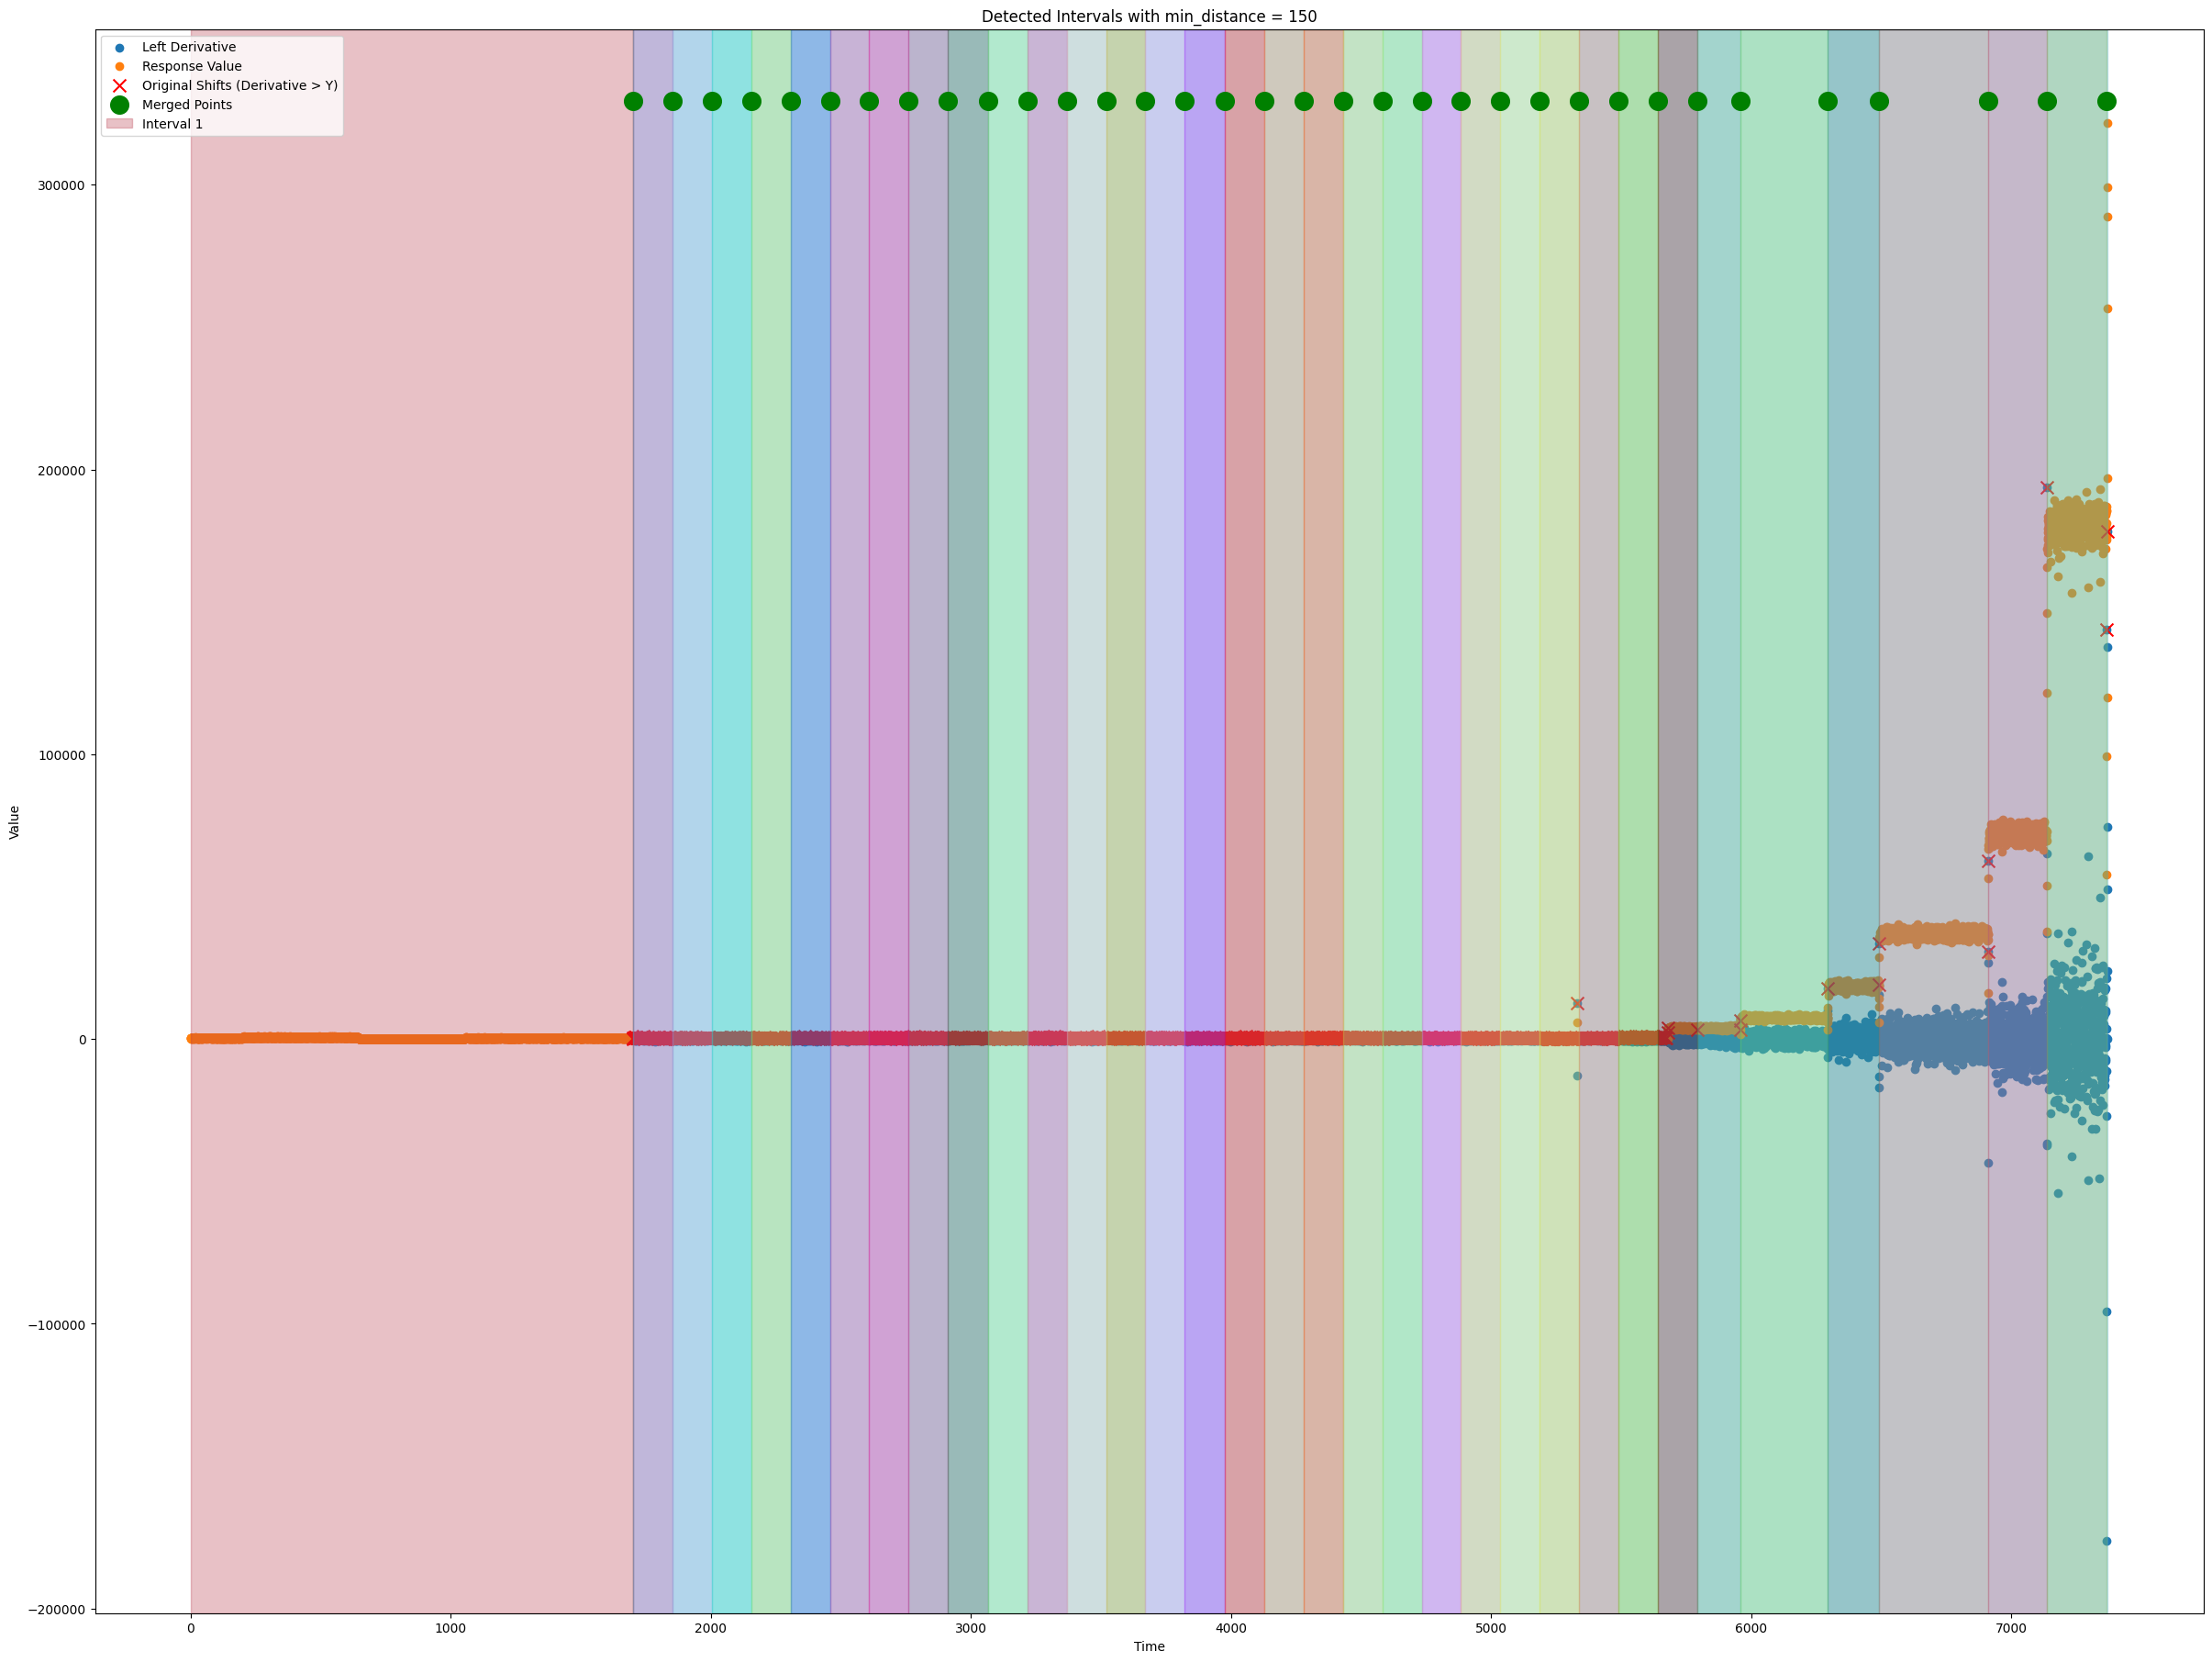


--- Testing with min_distance = 170 ---
Number of merged points for min_distance 170: 30
Detected intervals for min_distance 170:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 1870.197),
 (np.float64(1699.982), np.float64(7370.625)),
 (1870.197, 2042.139),
 (2042.139, 2212.353),
 (2212.353, 2382.568),
 (2382.568, 2553.646),
 (2553.646, 2724.292),
 (2724.292, 2897.099),
 (2897.099, 3068.609),
 (3068.609, 3239.688),
 (3239.688, 3411.198),
 (3411.198, 3584.868),
 (3584.868, 3755.515),
 (3755.515, 3928.321),
 (3928.321, 4102.424),
 (4102.424, 4273.934),
 (4273.934, 4444.148),
 (4444.148, 4615.227),
 (4615.227, 4786.737),
 (4786.737, 4956.951),
 (4956.951, 5128.894),
 (5128.894, 5299.972),
 (5299.972, 5470.186),
 (5470.186, 5642.561),
 (5642.561, 5957.068),
 (5957.068, 6294.905),
 (6294.905, 6491.904),
 (6491.904, 6910.96),
 (6910.96, 7136.904),
 (7136.904, 7368.033)]

<Figure size 640x480 with 0 Axes>

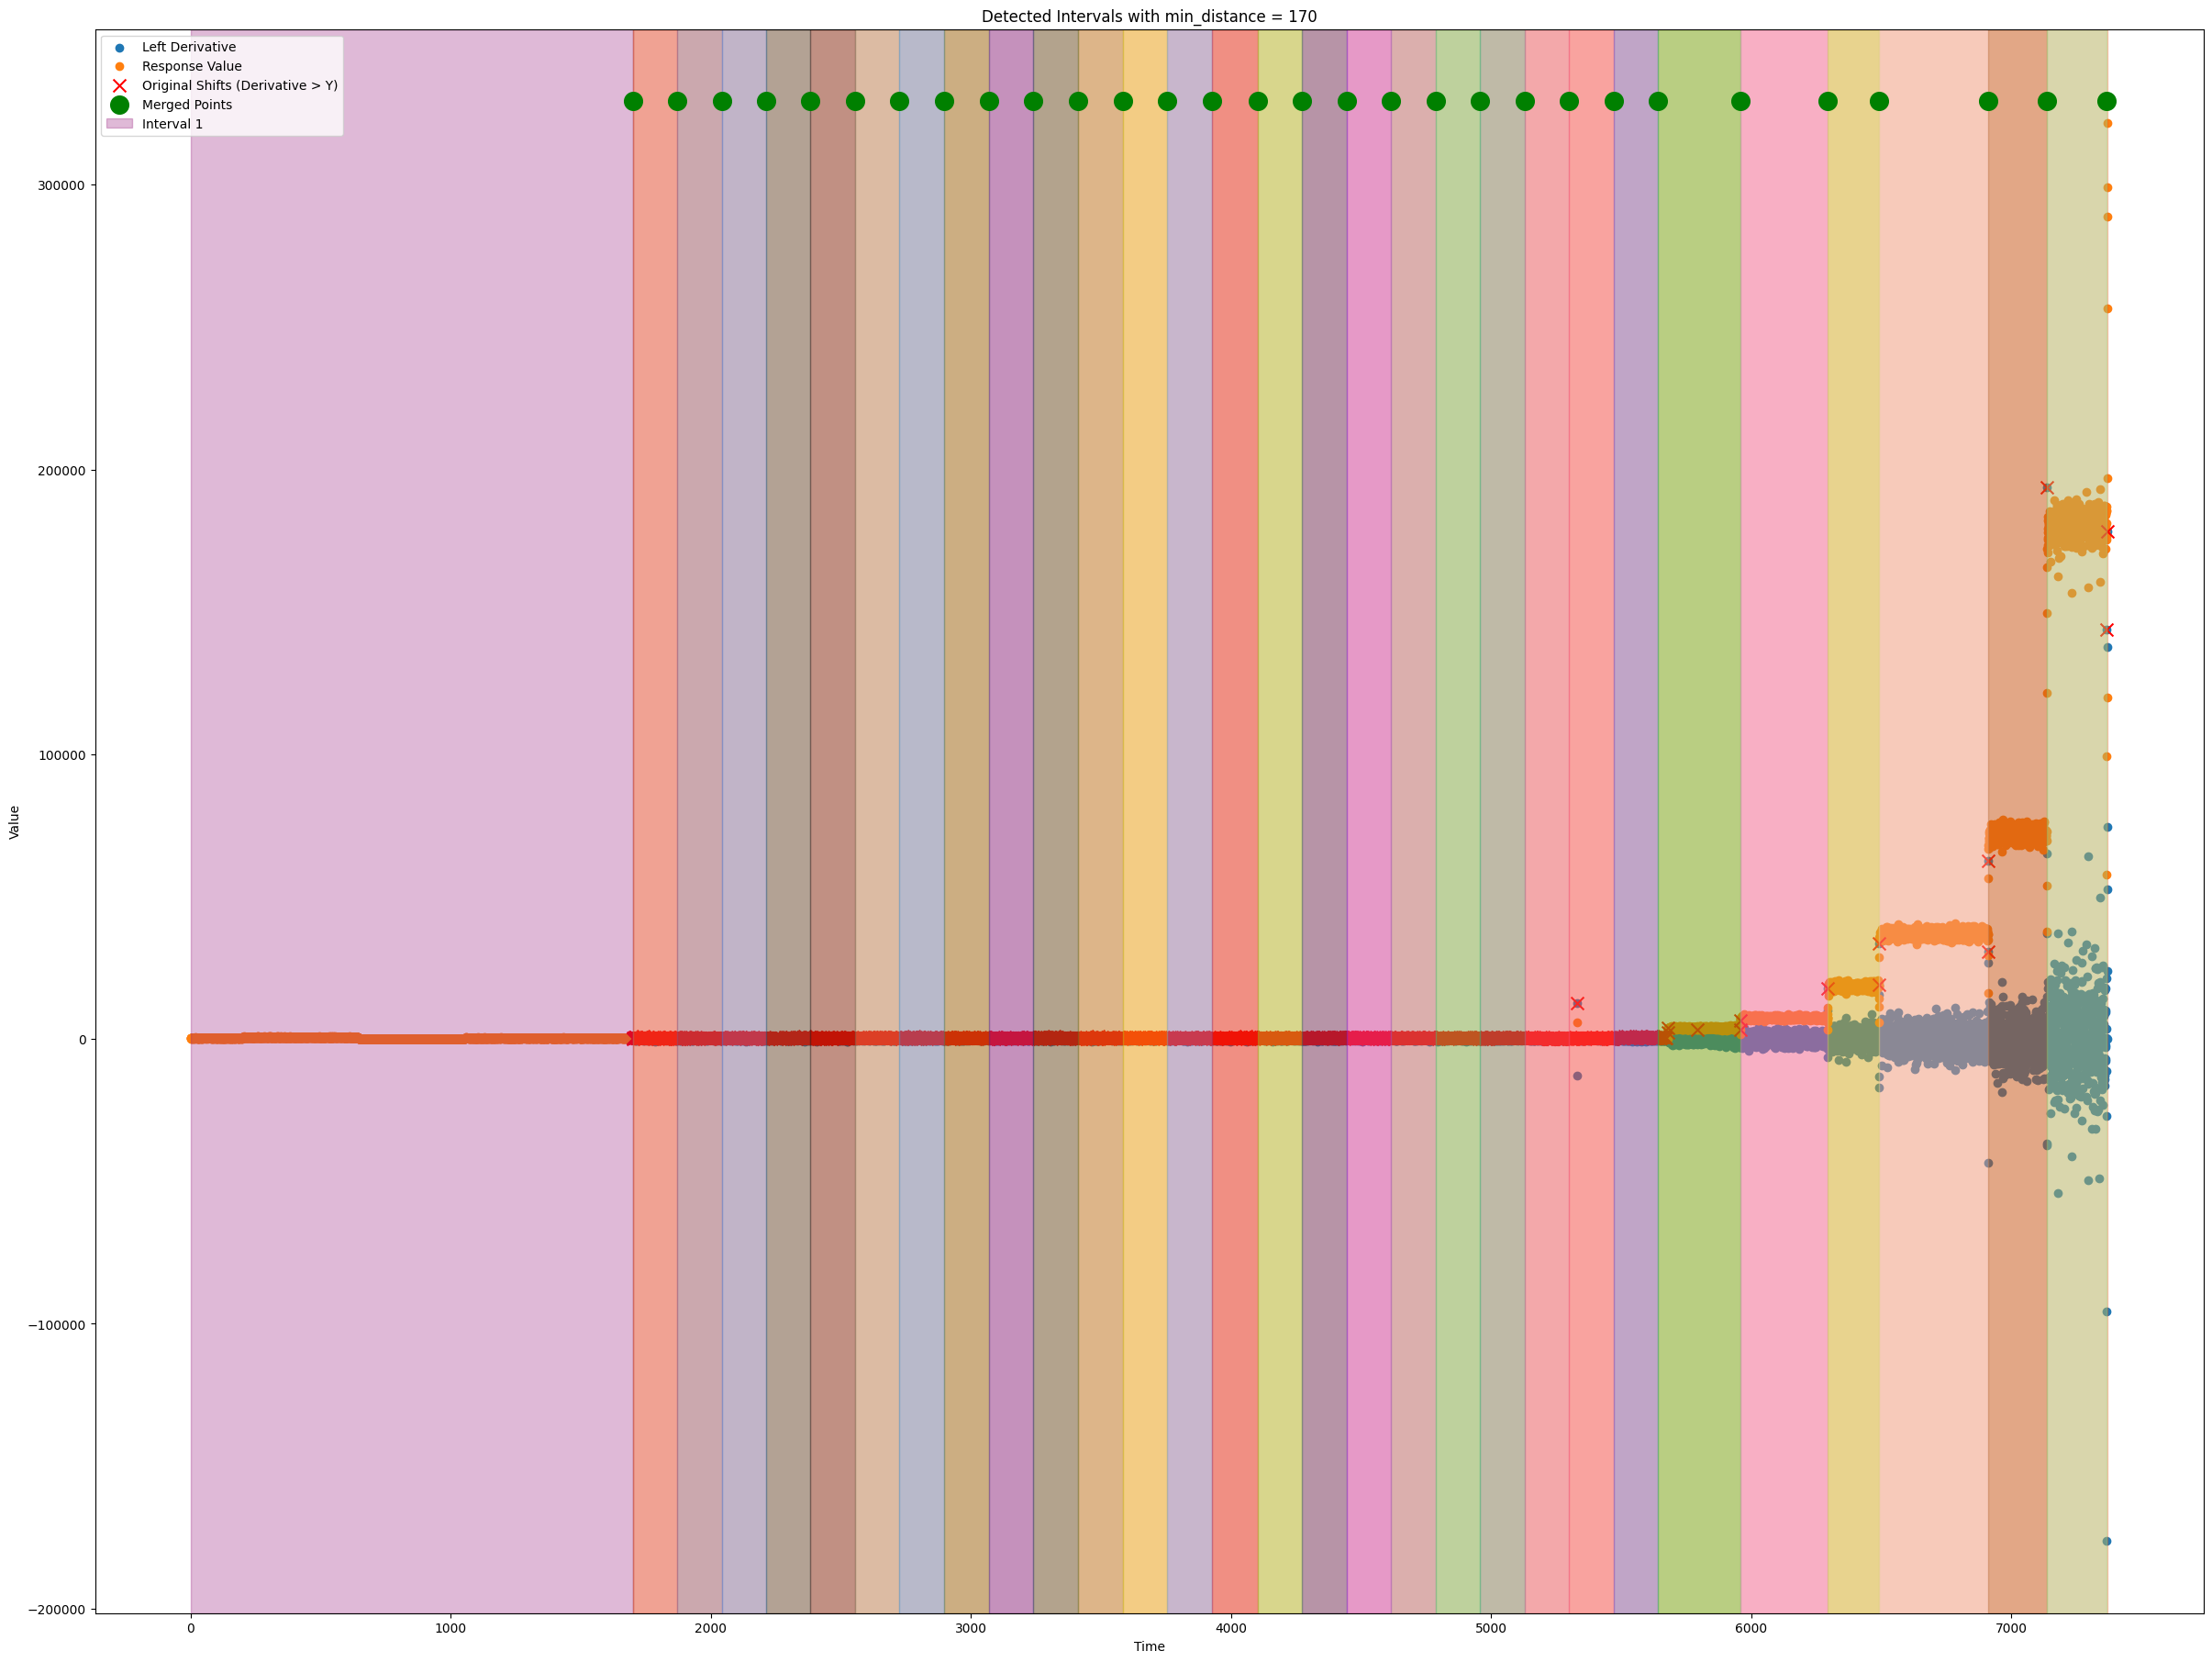


--- Testing with min_distance = 190 ---
Number of merged points for min_distance 190: 27
Detected intervals for min_distance 190:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 1893.094),
 (np.float64(1699.982), np.float64(7370.625)),
 (1893.094, 2084.045),
 (2084.045, 2274.564),
 (2274.564, 2465.515),
 (2465.515, 2656.034),
 (2656.034, 2846.121),
 (2846.121, 3041.824),
 (3041.824, 3232.343),
 (3232.343, 3422.862),
 (3422.862, 3613.813),
 (3613.813, 3804.332),
 (3804.332, 3999.172),
 (3999.172, 4190.555),
 (4190.555, 4383.234),
 (4383.234, 4573.753),
 (4573.753, 4763.84),
 (4763.84, 4953.927),
 (4953.927, 5144.878),
 (5144.878, 5335.397),
 (5335.397, 5527.644),
 (5527.644, 5792.902),
 (5792.902, 6294.905),
 (6294.905, 6491.904),
 (6491.904, 6910.96),
 (6910.96, 7136.904),
 (7136.904, 7368.033)]

<Figure size 640x480 with 0 Axes>

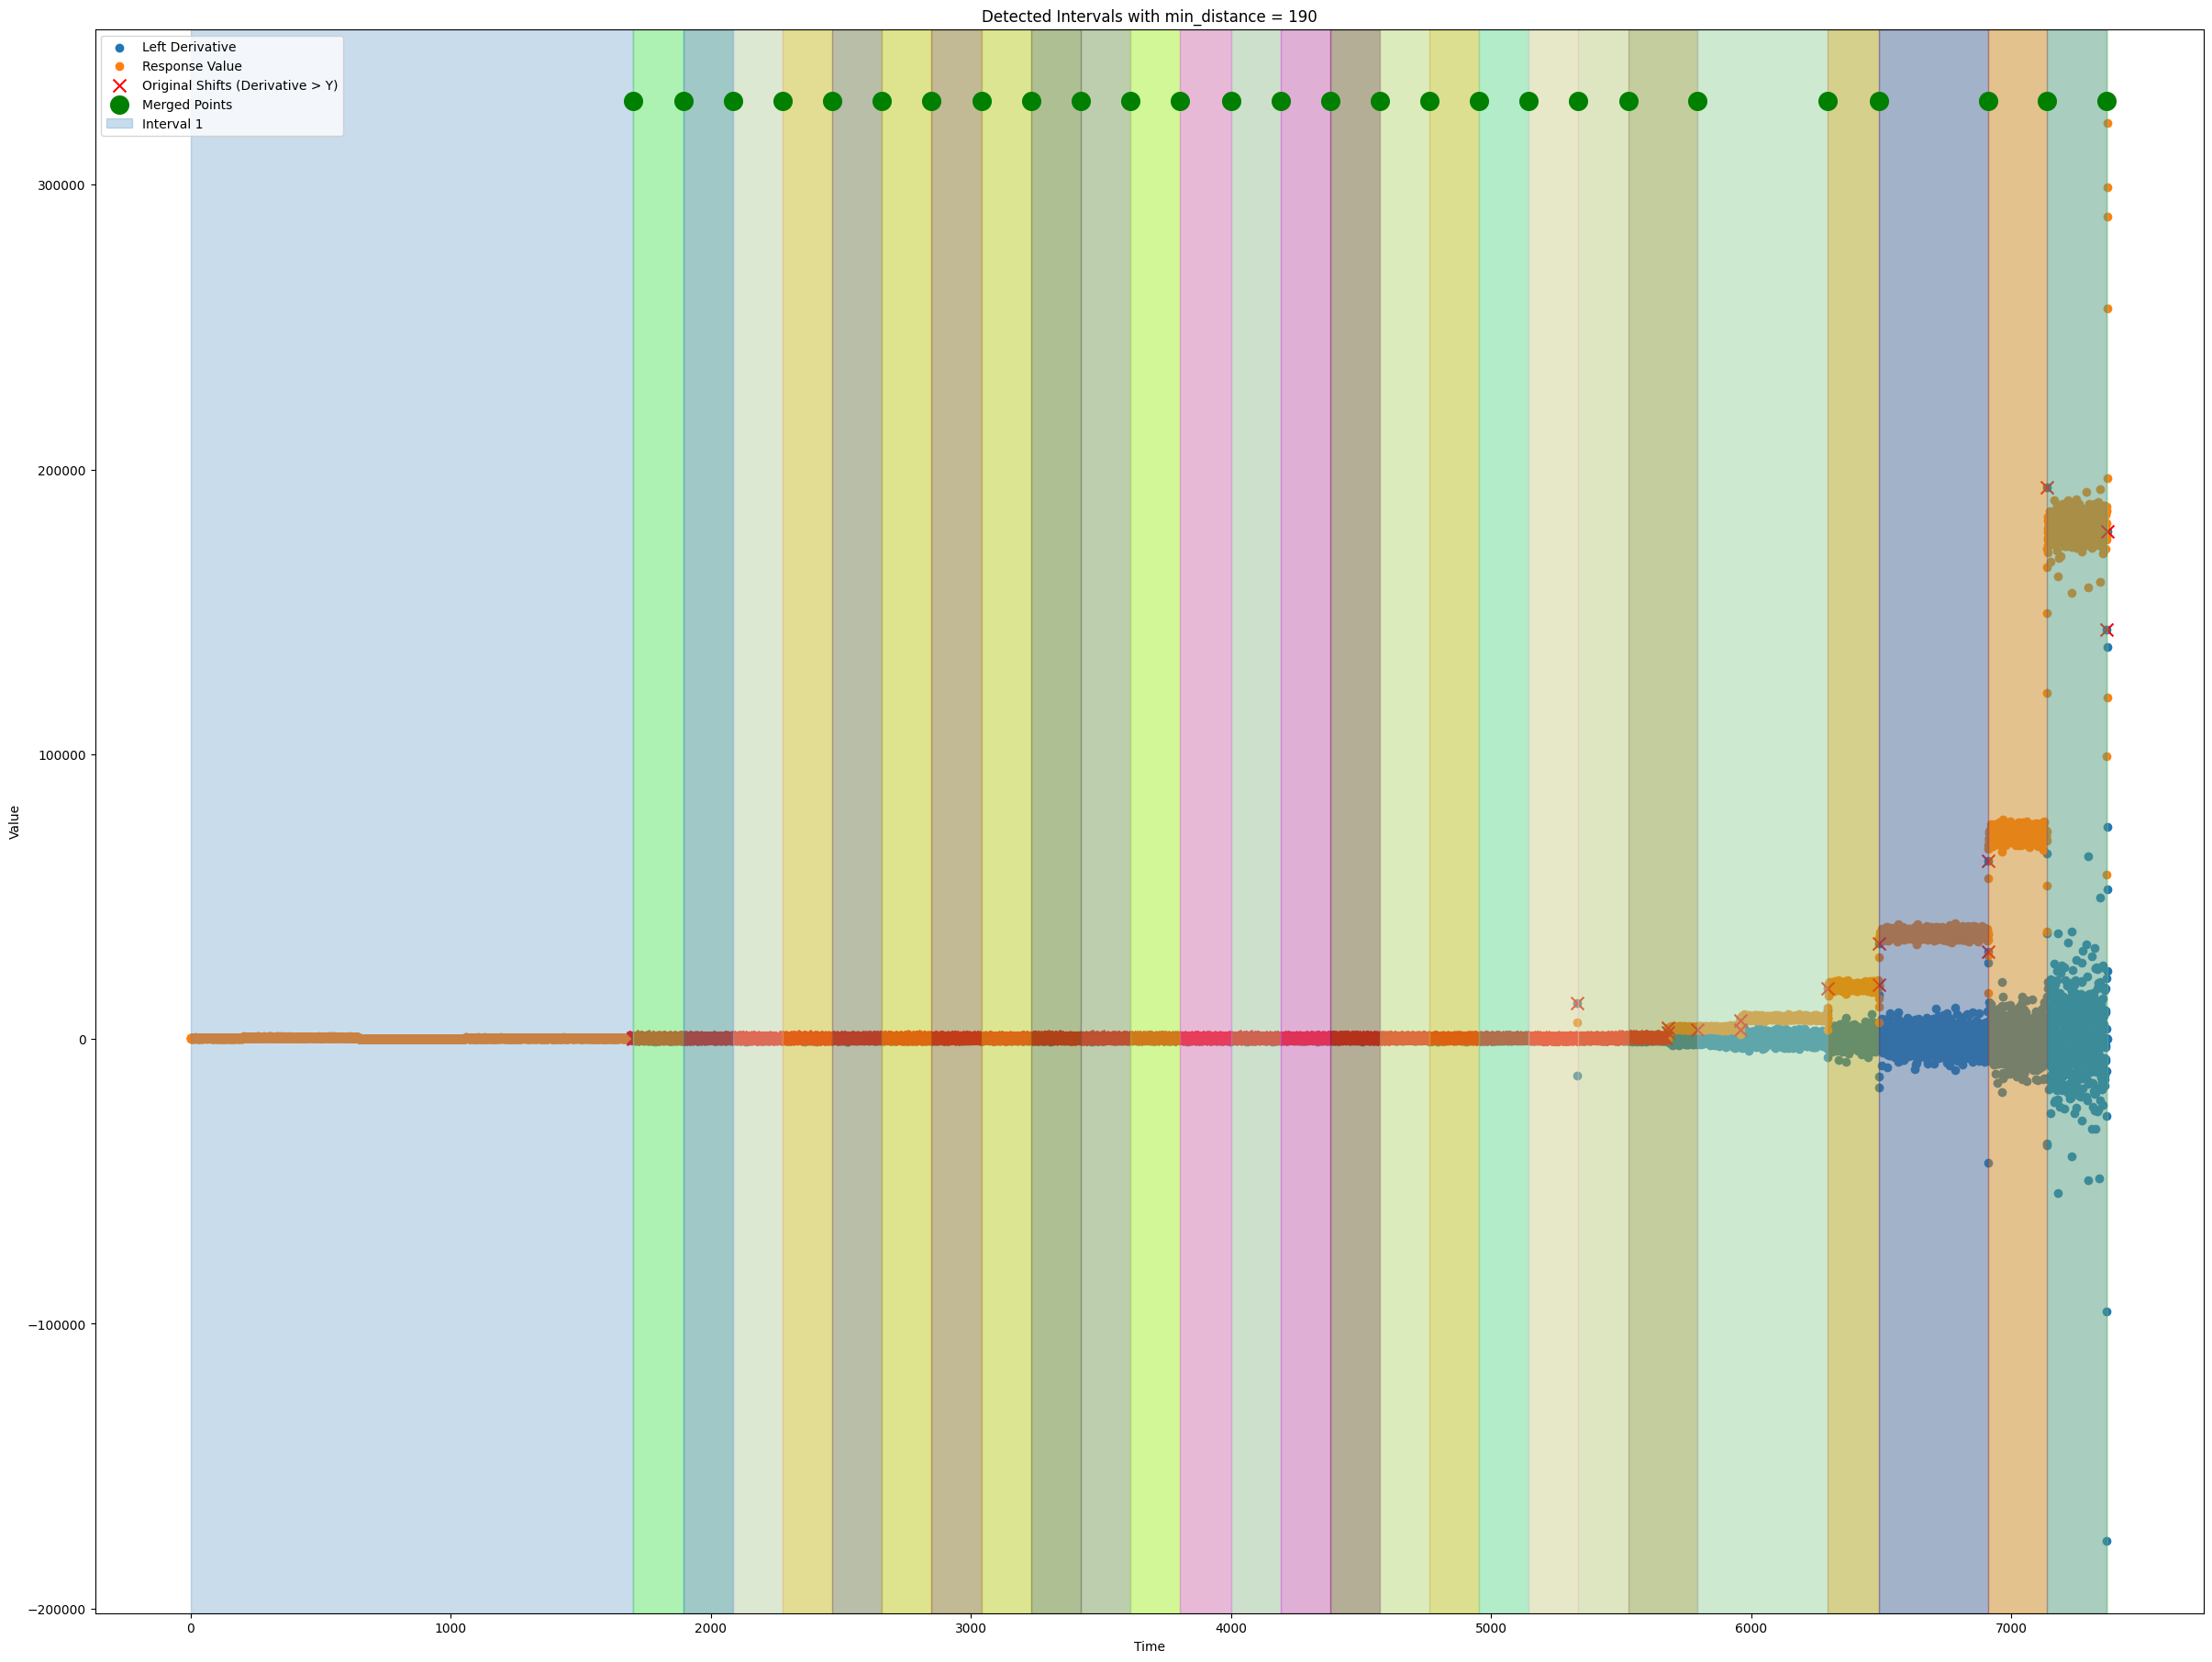


--- Testing with min_distance = 210 ---
Number of merged points for min_distance 210: 24
Detected intervals for min_distance 210:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 1910.374),
 (np.float64(1699.982), np.float64(7370.625)),
 (1910.374, 2121.198),
 (2121.198, 2331.59),
 (2331.59, 2544.574),
 (2544.574, 2756.694),
 (2756.694, 2967.517),
 (2967.517, 3182.229),
 (3182.229, 3393.053),
 (3393.053, 3603.877),
 (3603.877, 3814.269),
 (3814.269, 4026.821),
 (4026.821, 4240.237),
 (4240.237, 4450.628),
 (4450.628, 4661.452),
 (4661.452, 4876.164),
 (4876.164, 5092.604),
 (5092.604, 5304.724),
 (5304.724, 5522.46),
 (5522.46, 5792.902),
 (5792.902, 6294.905),
 (6294.905, 6910.96),
 (6910.96, 7136.904),
 (7136.904, 7368.033)]

<Figure size 640x480 with 0 Axes>

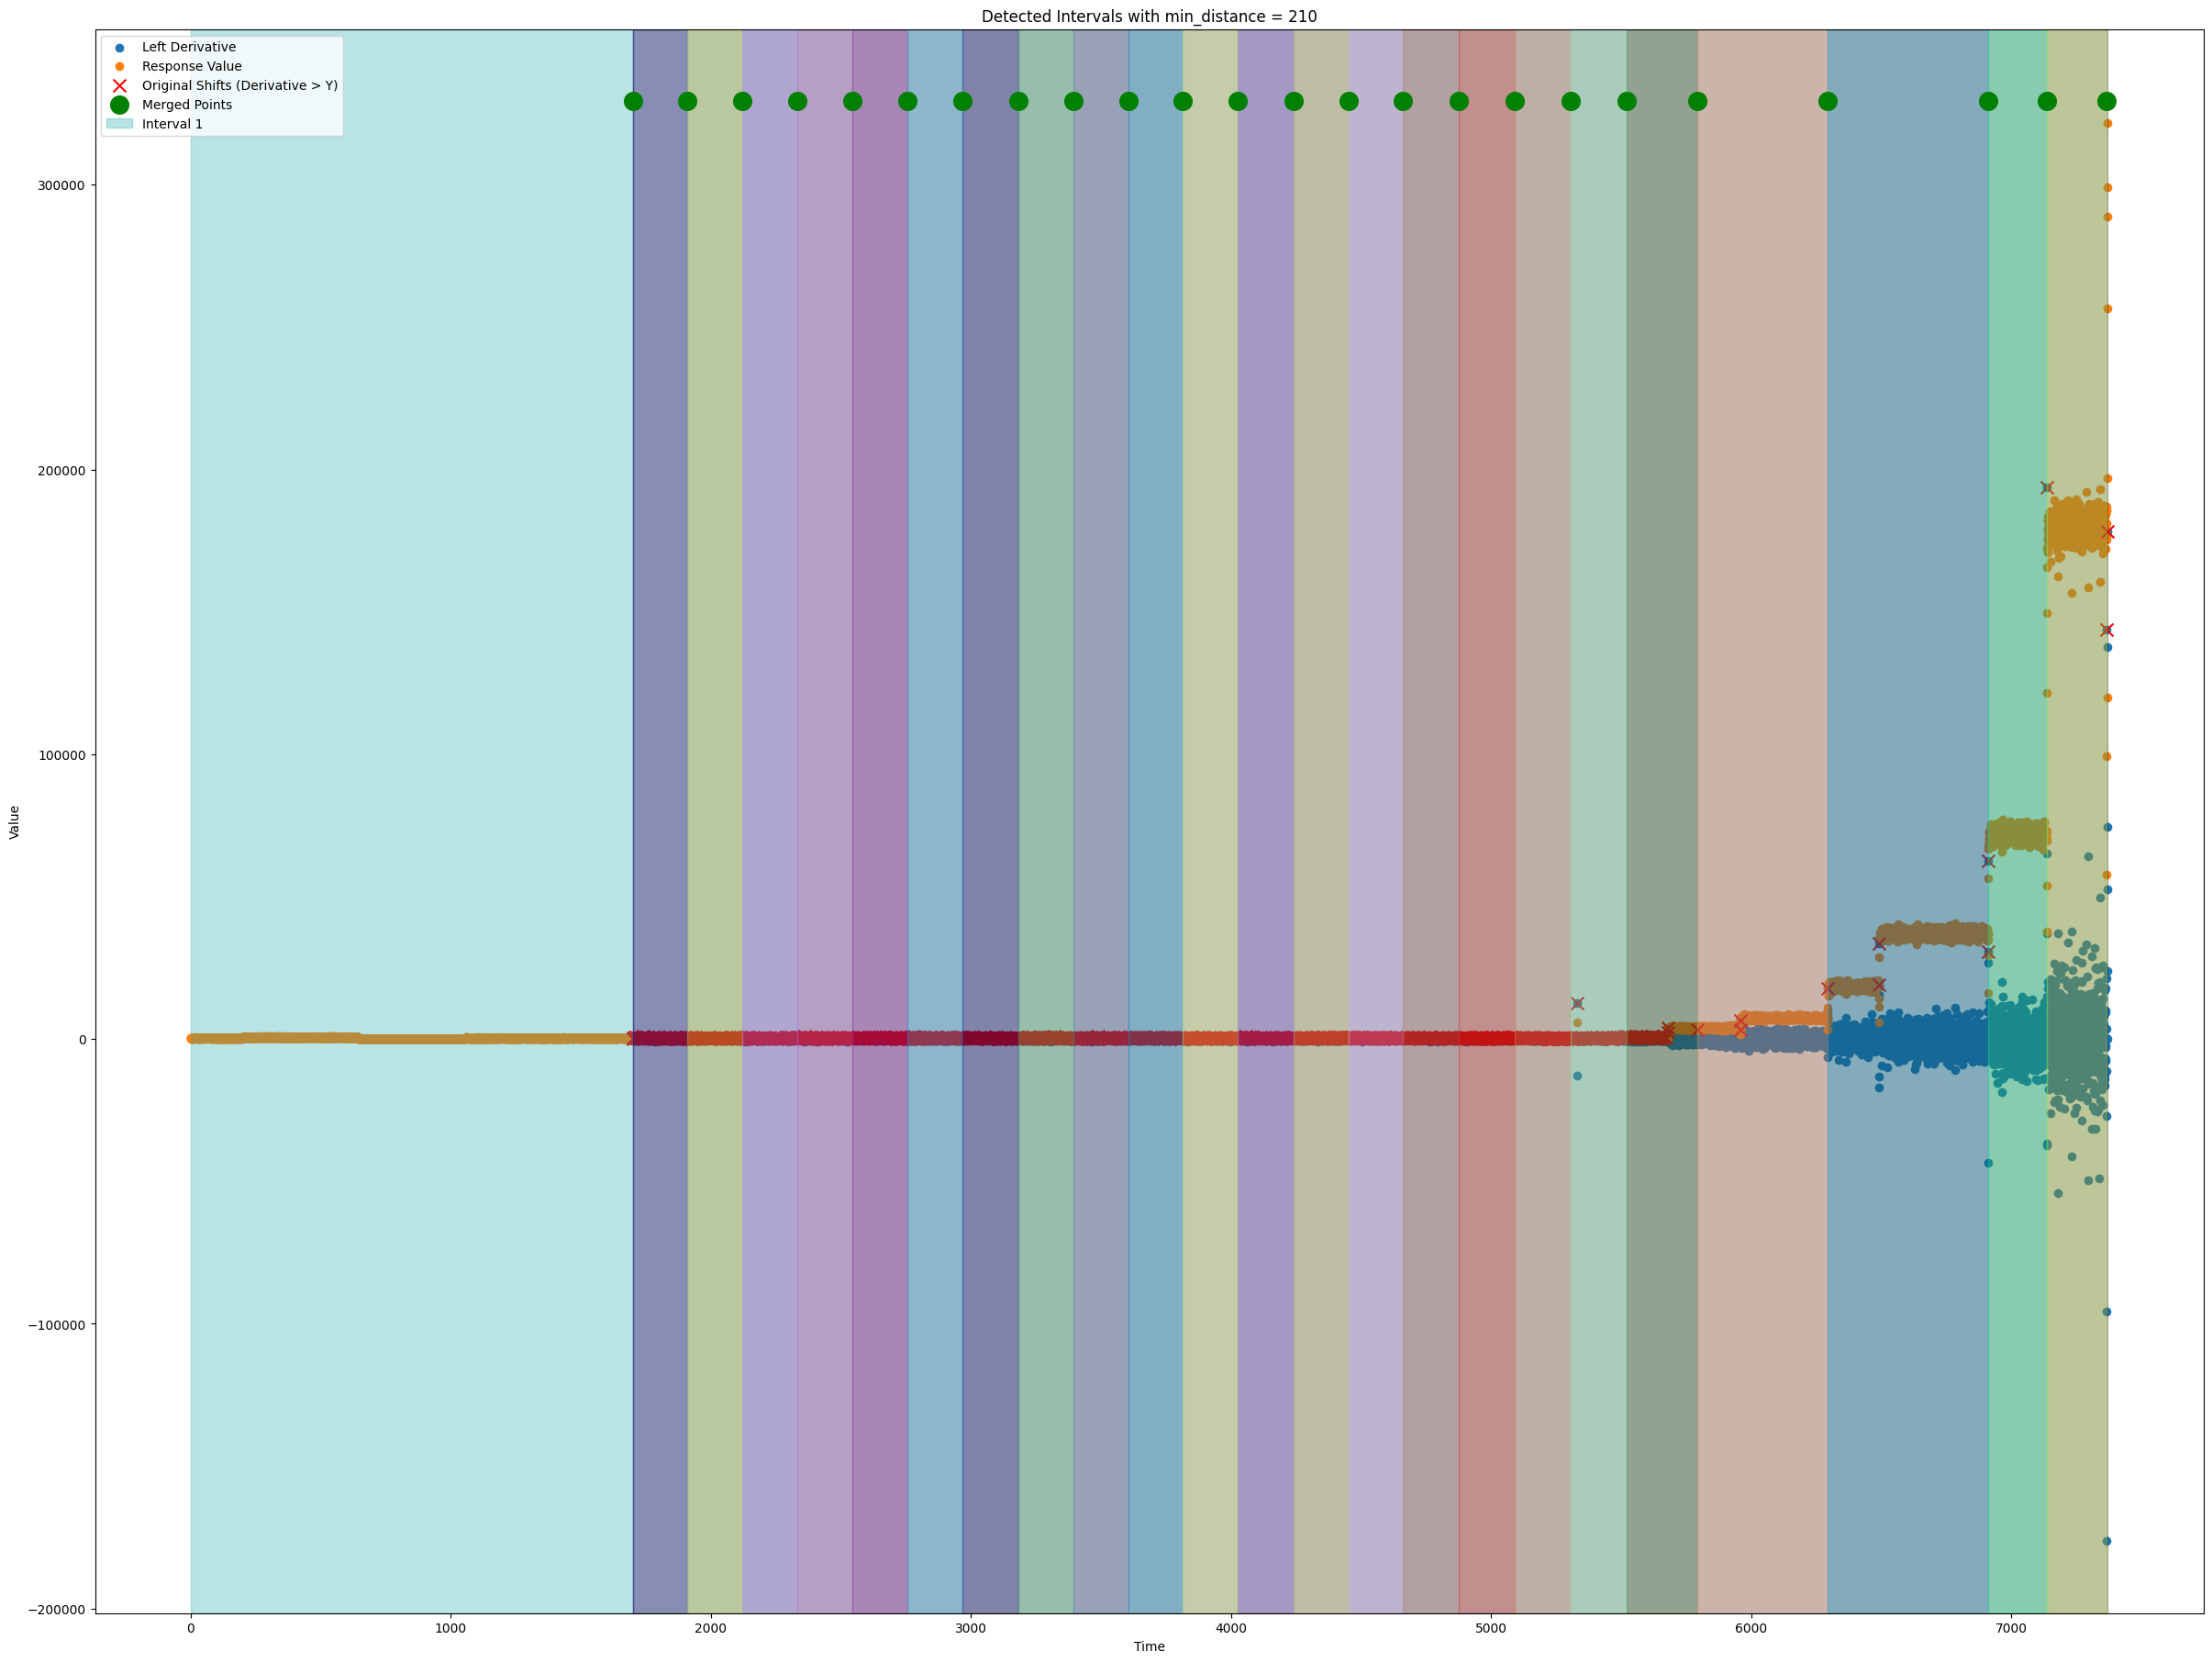


--- Testing with min_distance = 230 ---
Number of merged points for min_distance 230: 22
Detected intervals for min_distance 230:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 1930.679),
 (np.float64(1699.982), np.float64(7370.625)),
 (1930.679, 2163.104),
 (2163.104, 2395.096),
 (2395.096, 2626.657),
 (2626.657, 2856.921),
 (2856.921, 3088.482),
 (3088.482, 3321.339),
 (3321.339, 3553.763),
 (3553.763, 3784.892),
 (3784.892, 4016.452),
 (4016.452, 4247.149),
 (4247.149, 4477.845),
 (4477.845, 4709.838),
 (4709.838, 4940.535),
 (4940.535, 5172.959),
 (5172.959, 5403.656),
 (5403.656, 5635.216),
 (5635.216, 5957.068),
 (5957.068, 6294.905),
 (6294.905, 6910.96),
 (6910.96, 7368.033)]

<Figure size 640x480 with 0 Axes>

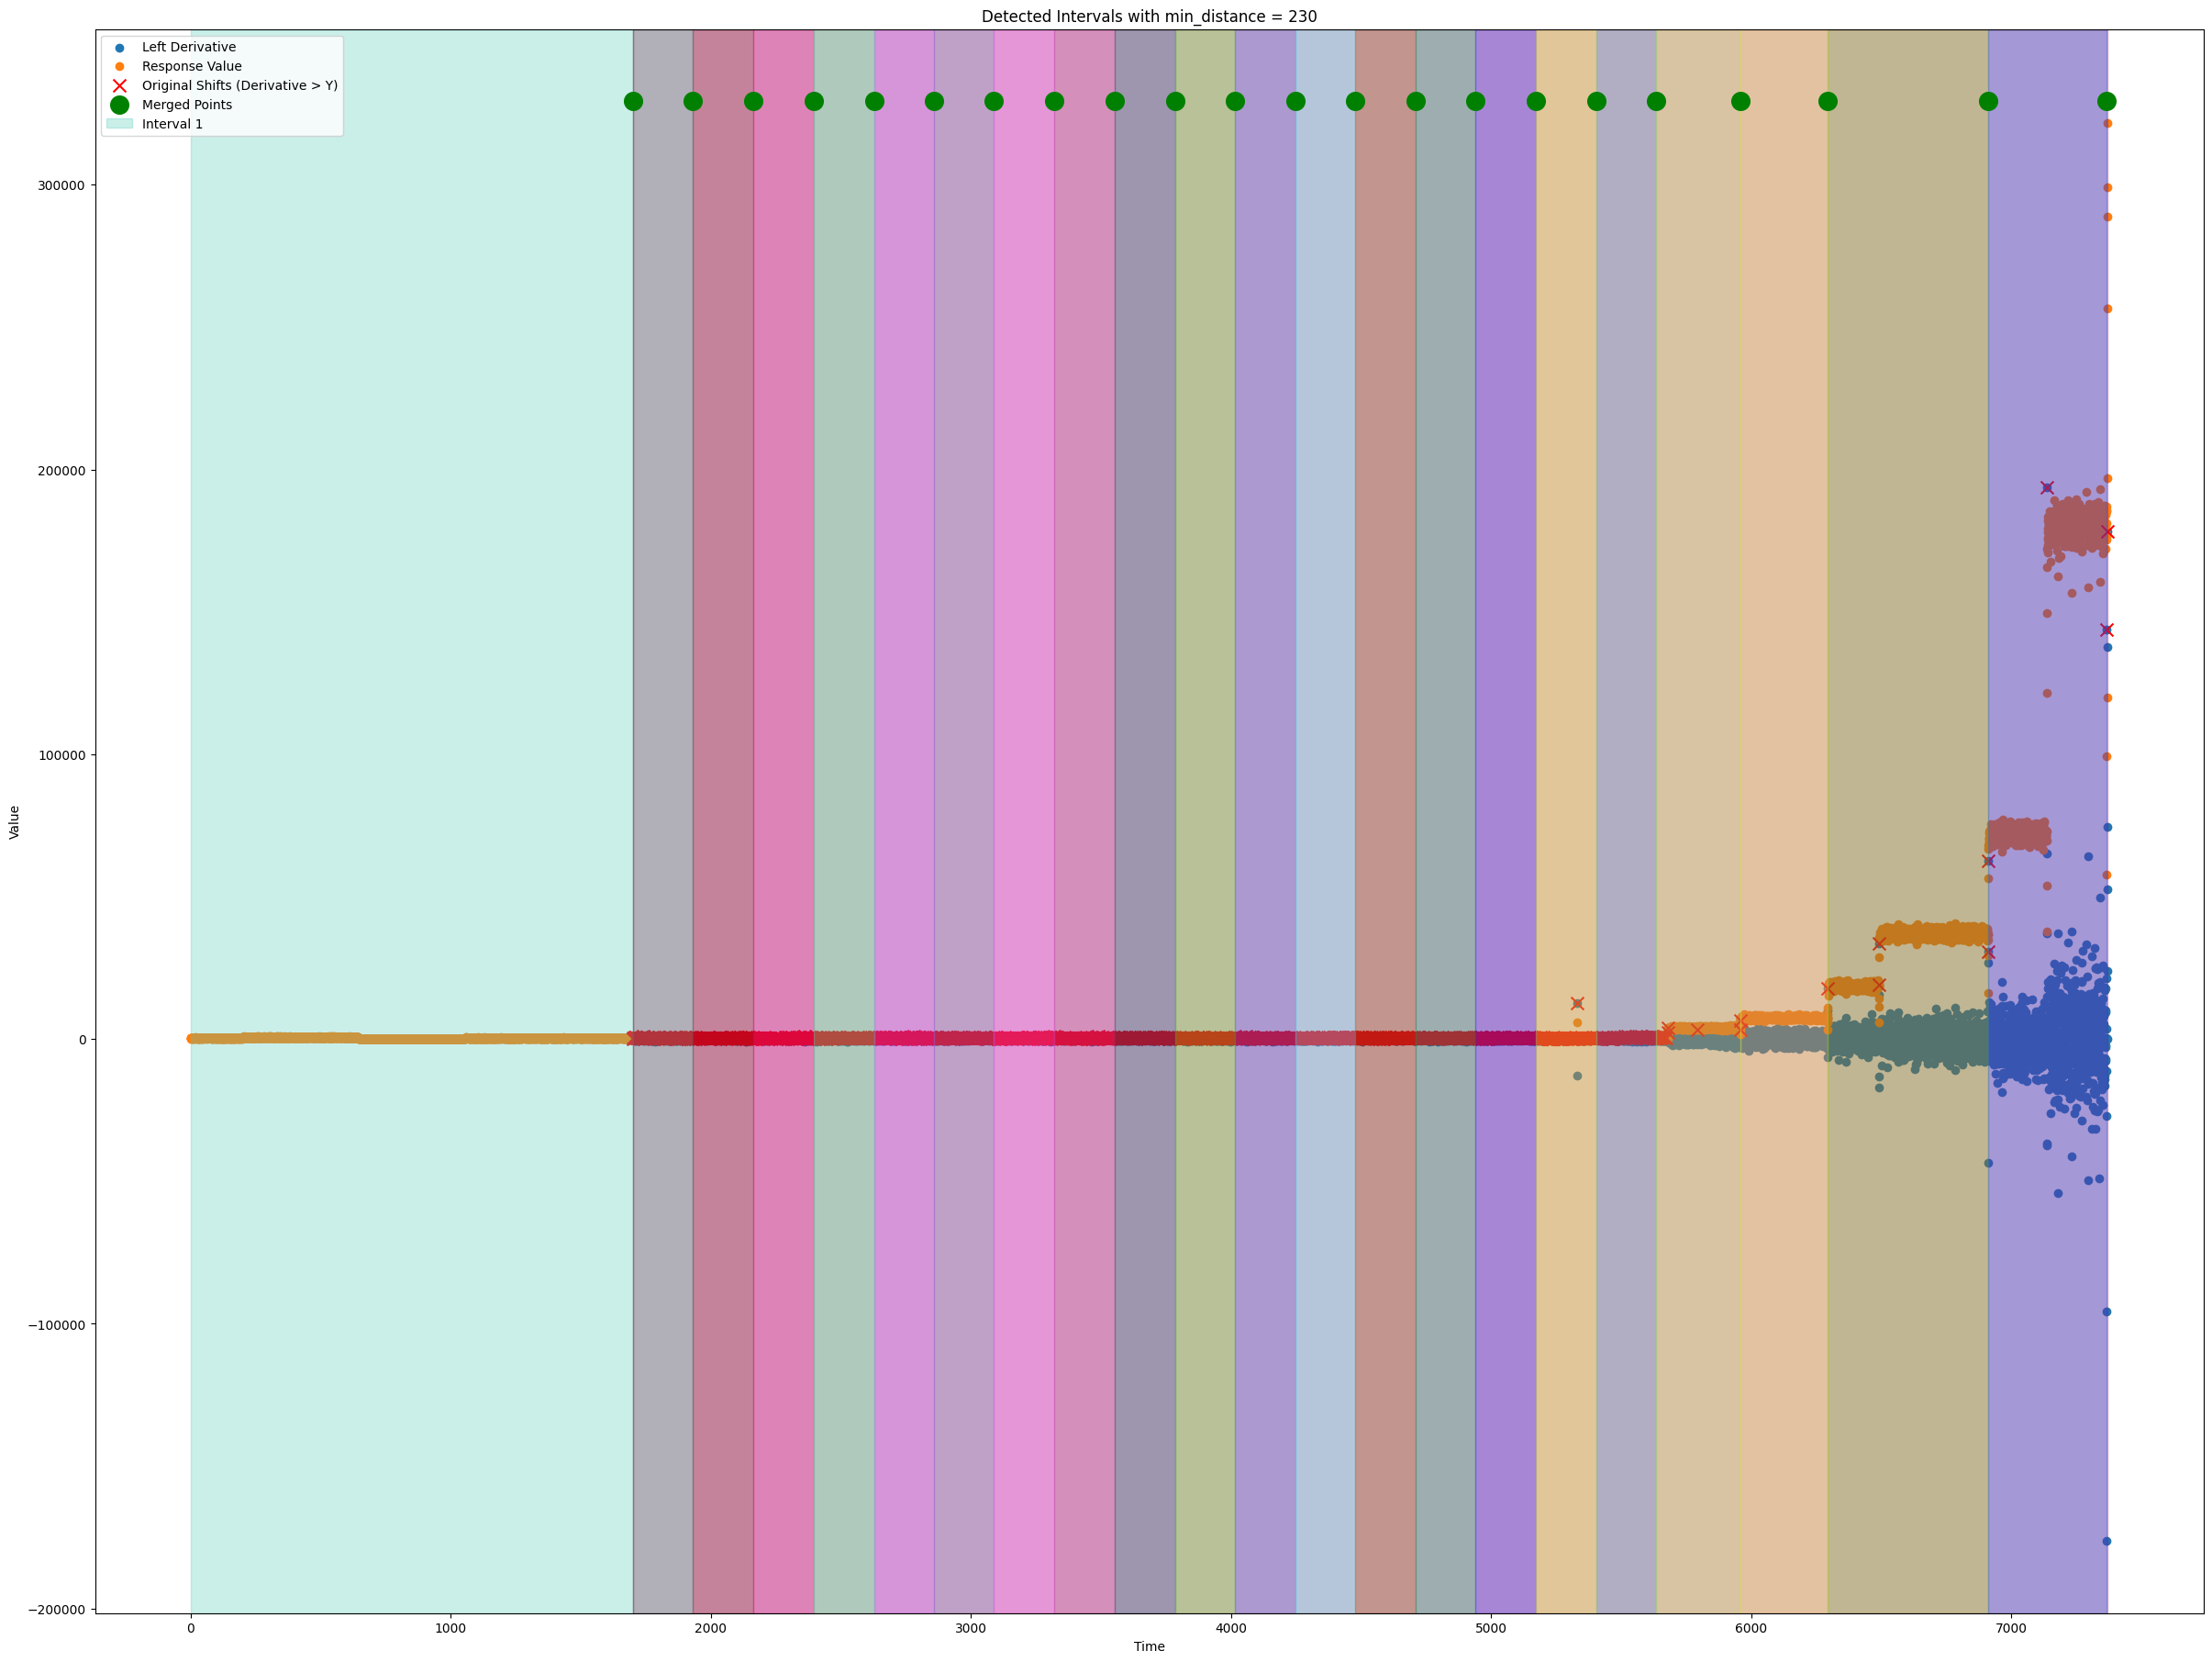


--- Testing with min_distance = 250 ---
Number of merged points for min_distance 250: 20
Detected intervals for min_distance 250:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 1950.984),
 (np.float64(1699.982), np.float64(7370.625)),
 (1950.984, 2201.985),
 (2201.985, 2452.554),
 (2452.554, 2702.692),
 (2702.692, 2953.261),
 (2953.261, 3204.694),
 (3204.694, 3455.264),
 (3455.264, 3707.561),
 (3707.561, 3957.698),
 (3957.698, 4207.835),
 (4207.835, 4461.429),
 (4461.429, 4715.454),
 (4715.454, 4965.591),
 (4965.591, 5215.729),
 (5215.729, 5465.866),
 (5465.866, 5792.902),
 (5792.902, 6294.905),
 (6294.905, 6910.96),
 (6910.96, 7368.033)]

<Figure size 640x480 with 0 Axes>

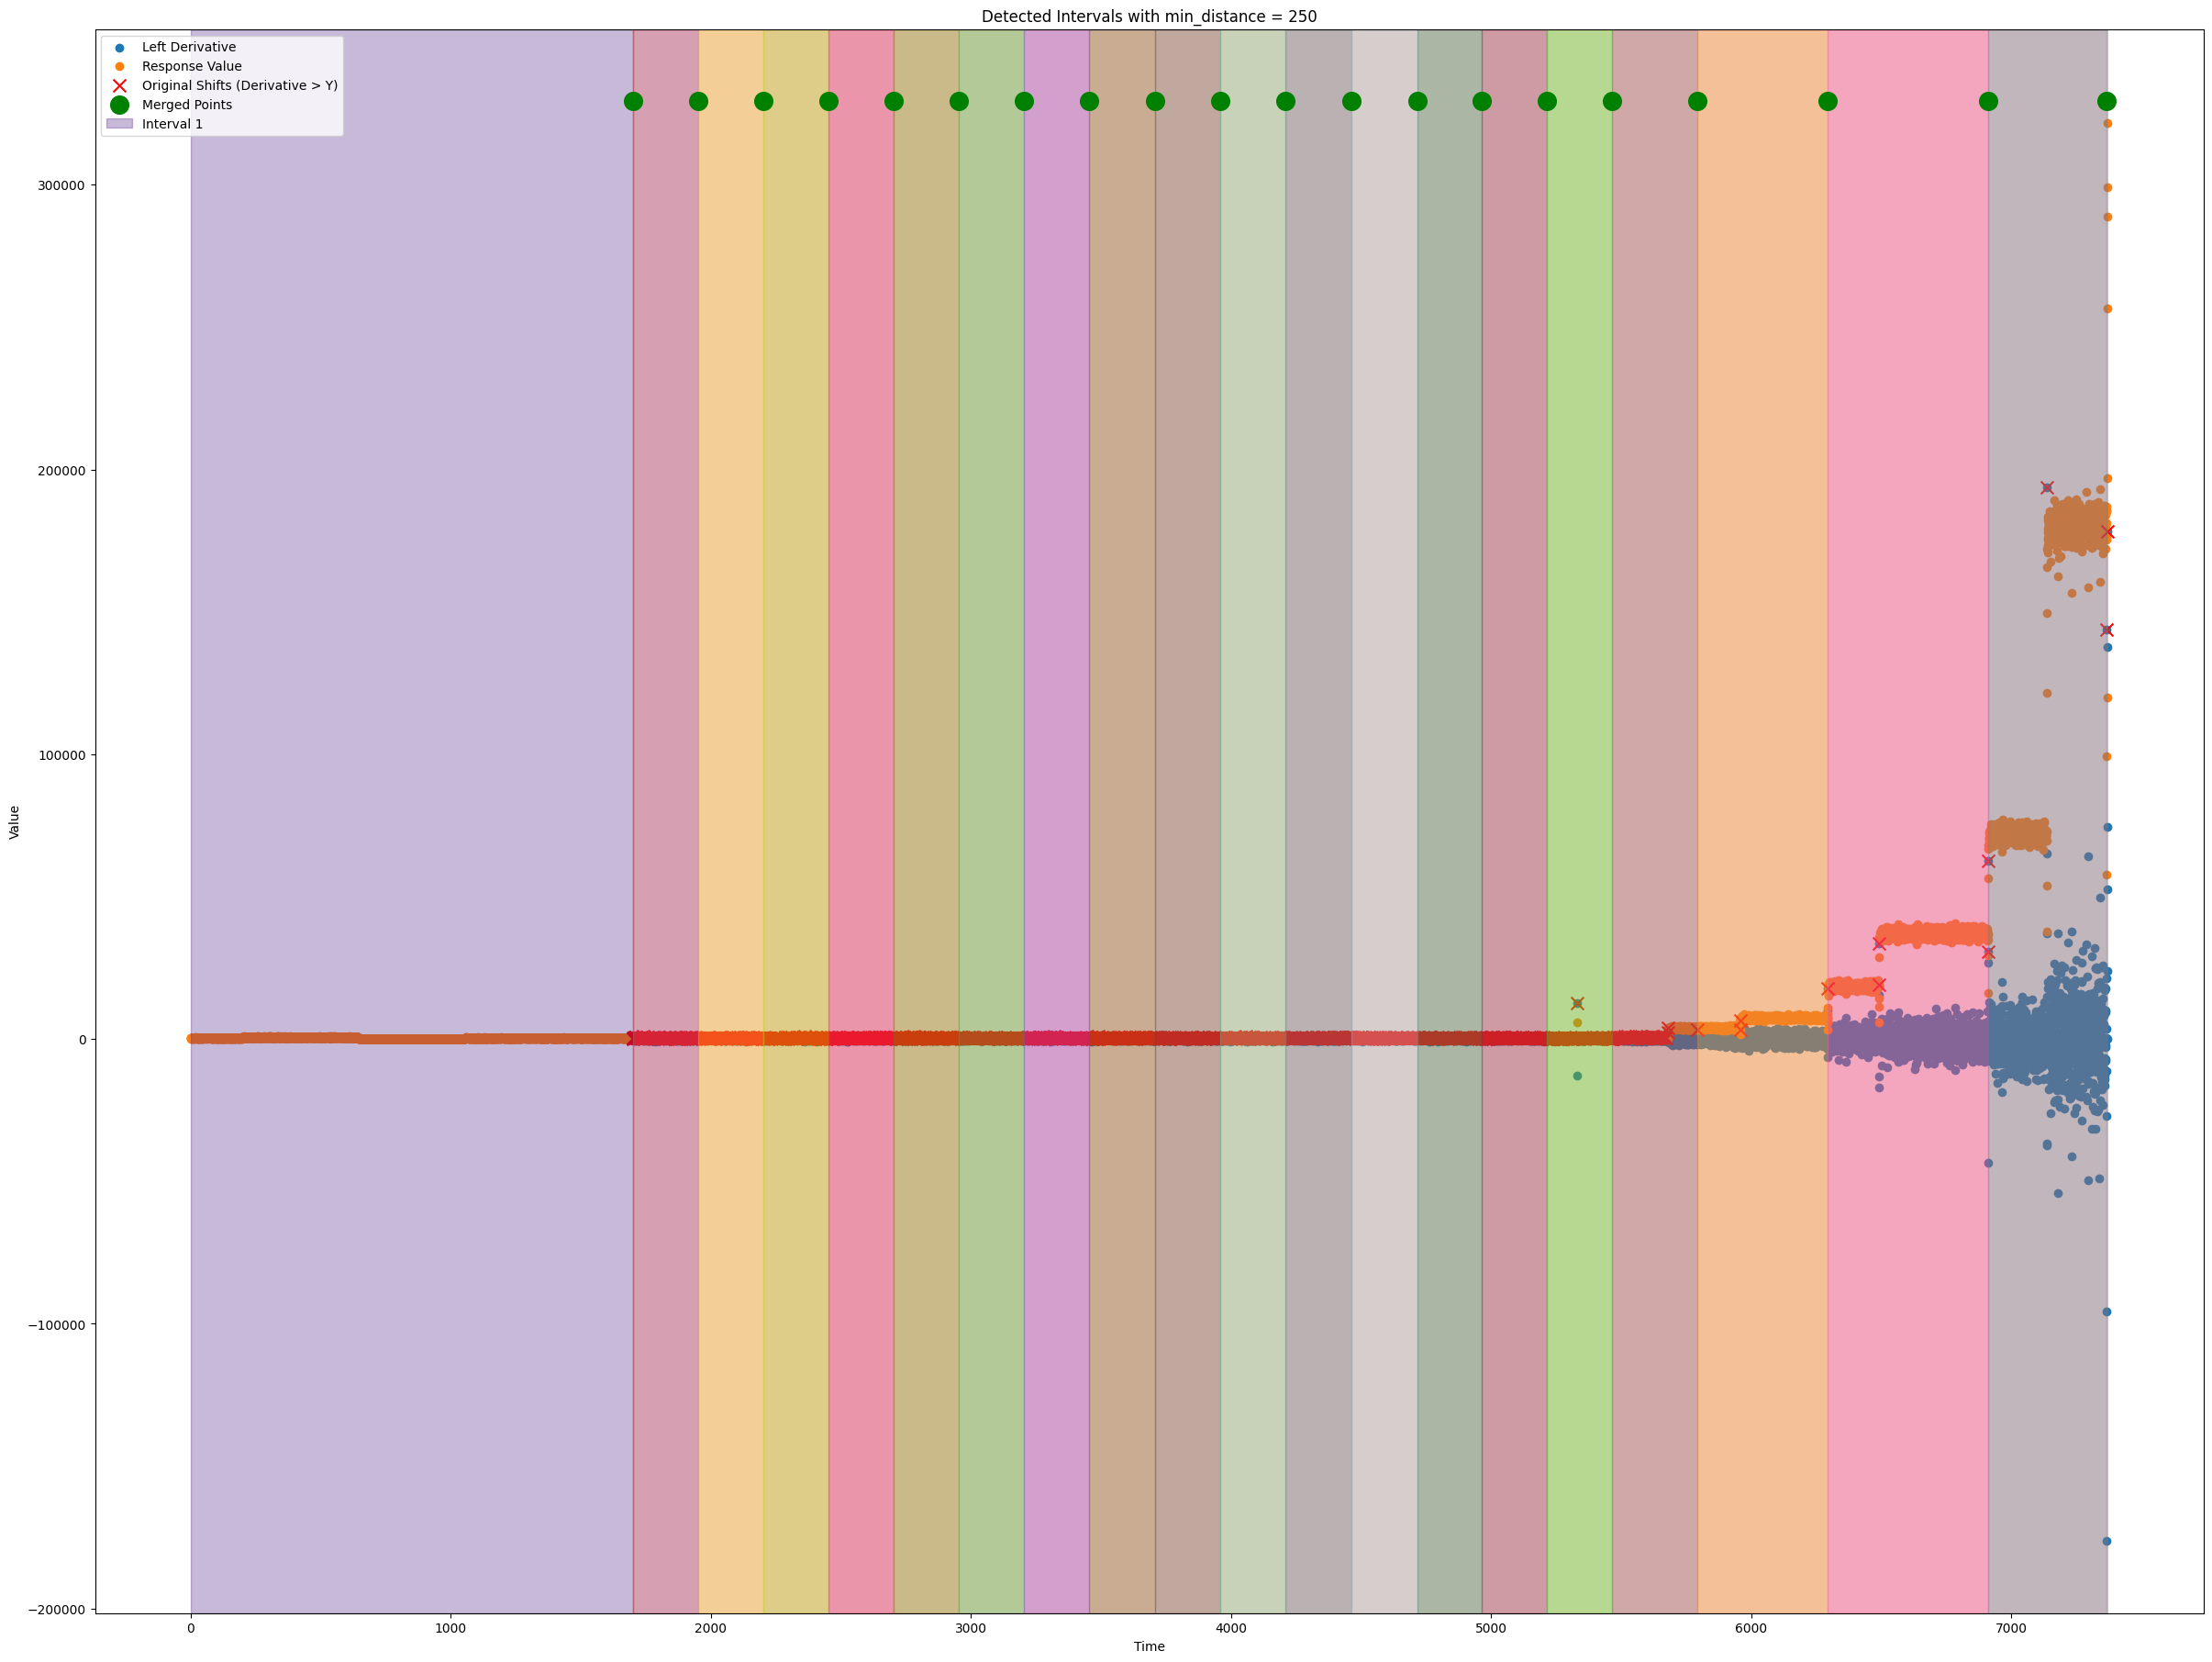


--- Testing with min_distance = 270 ---
Number of merged points for min_distance 270: 19
Detected intervals for min_distance 270:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 1971.721),
 (np.float64(1699.982), np.float64(7370.625)),
 (1971.721, 2243.027),
 (2243.027, 2517.357),
 (2517.357, 2788.663),
 (2788.663, 3058.673),
 (3058.673, 3330.411),
 (3330.411, 3601.285),
 (3601.285, 3872.591),
 (3872.591, 4143.033),
 (4143.033, 4416.931),
 (4416.931, 4687.805),
 (4687.805, 4959.111),
 (4959.111, 5232.145),
 (5232.145, 5503.883),
 (5503.883, 5792.902),
 (5792.902, 6294.905),
 (6294.905, 6910.96),
 (6910.96, 7368.033)]

<Figure size 640x480 with 0 Axes>

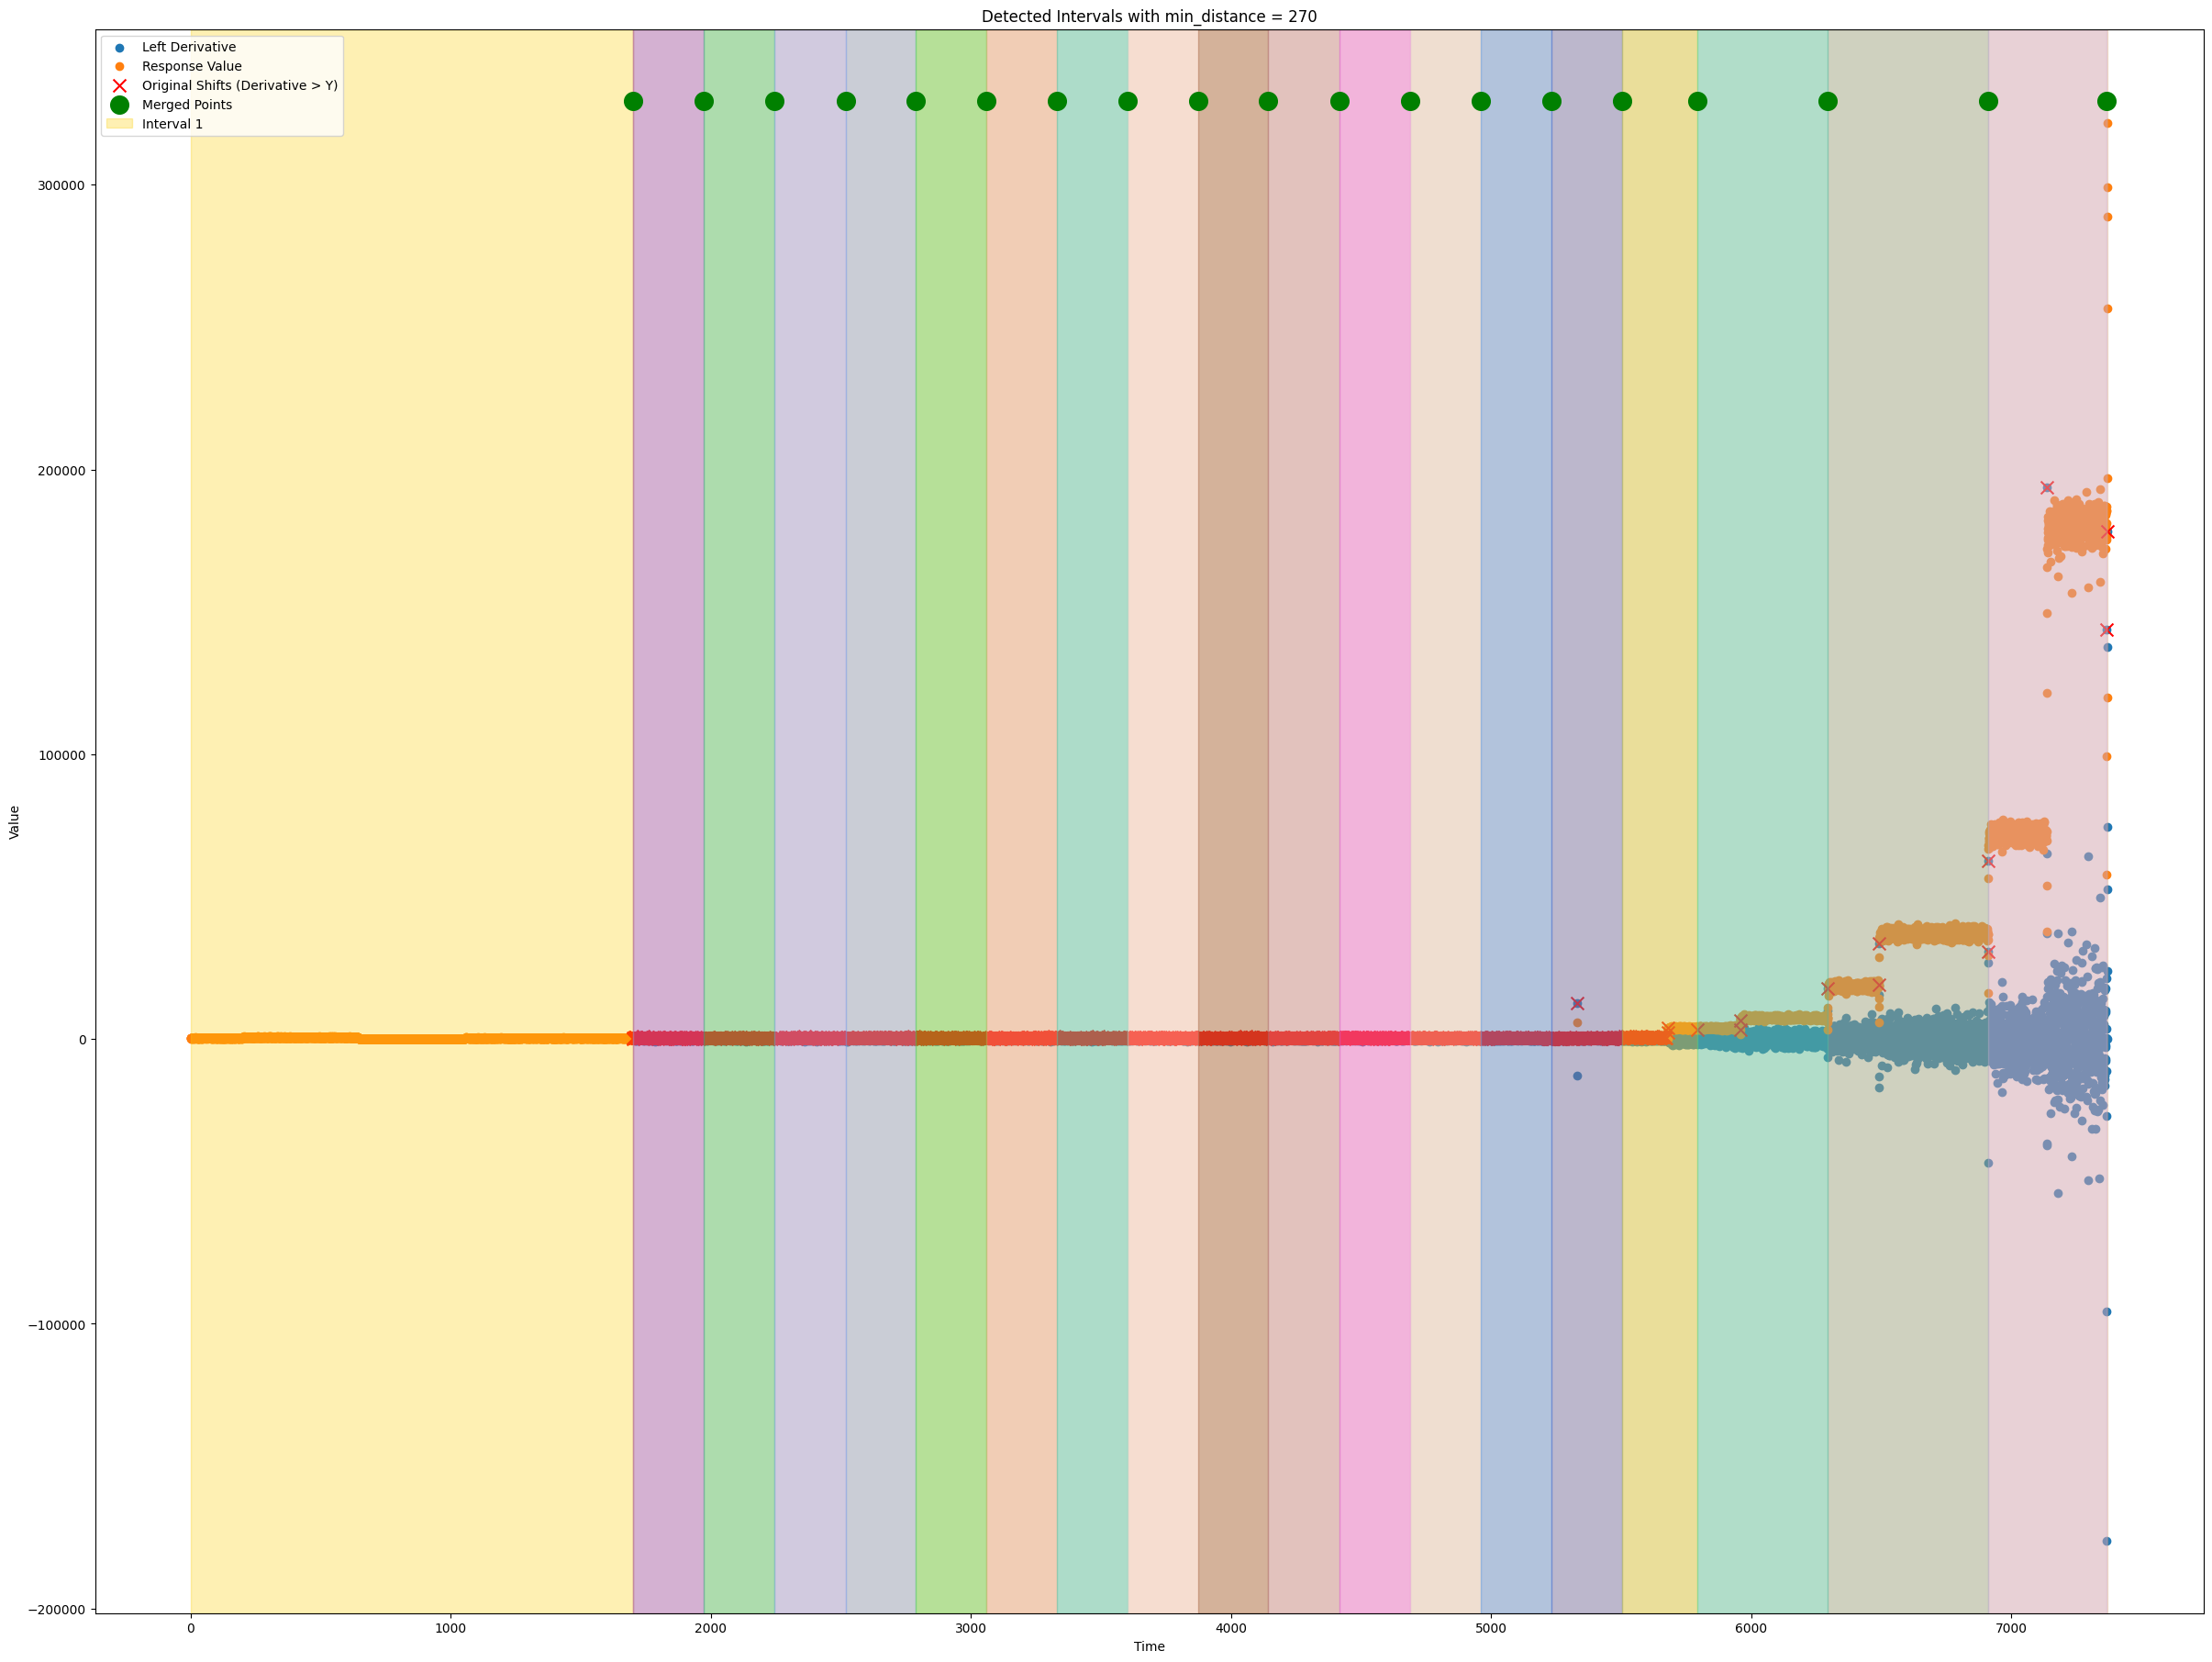


--- Testing with min_distance = 290 ---
Number of merged points for min_distance 290: 18
Detected intervals for min_distance 290:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 1991.593),
 (np.float64(1699.982), np.float64(7370.625)),
 (1991.593, 2284.932),
 (2284.932, 2578.271),
 (2578.271, 2870.746),
 (2870.746, 3161.493),
 (3161.493, 3451.807),
 (3451.807, 3742.122),
 (3742.122, 4038.485),
 (4038.485, 4330.096),
 (4330.096, 4624.299),
 (4624.299, 4915.478),
 (4915.478, 5208.817),
 (5208.817, 5500.859),
 (5500.859, 5792.902),
 (5792.902, 6294.905),
 (6294.905, 6910.96),
 (6910.96, 7368.033)]

<Figure size 640x480 with 0 Axes>

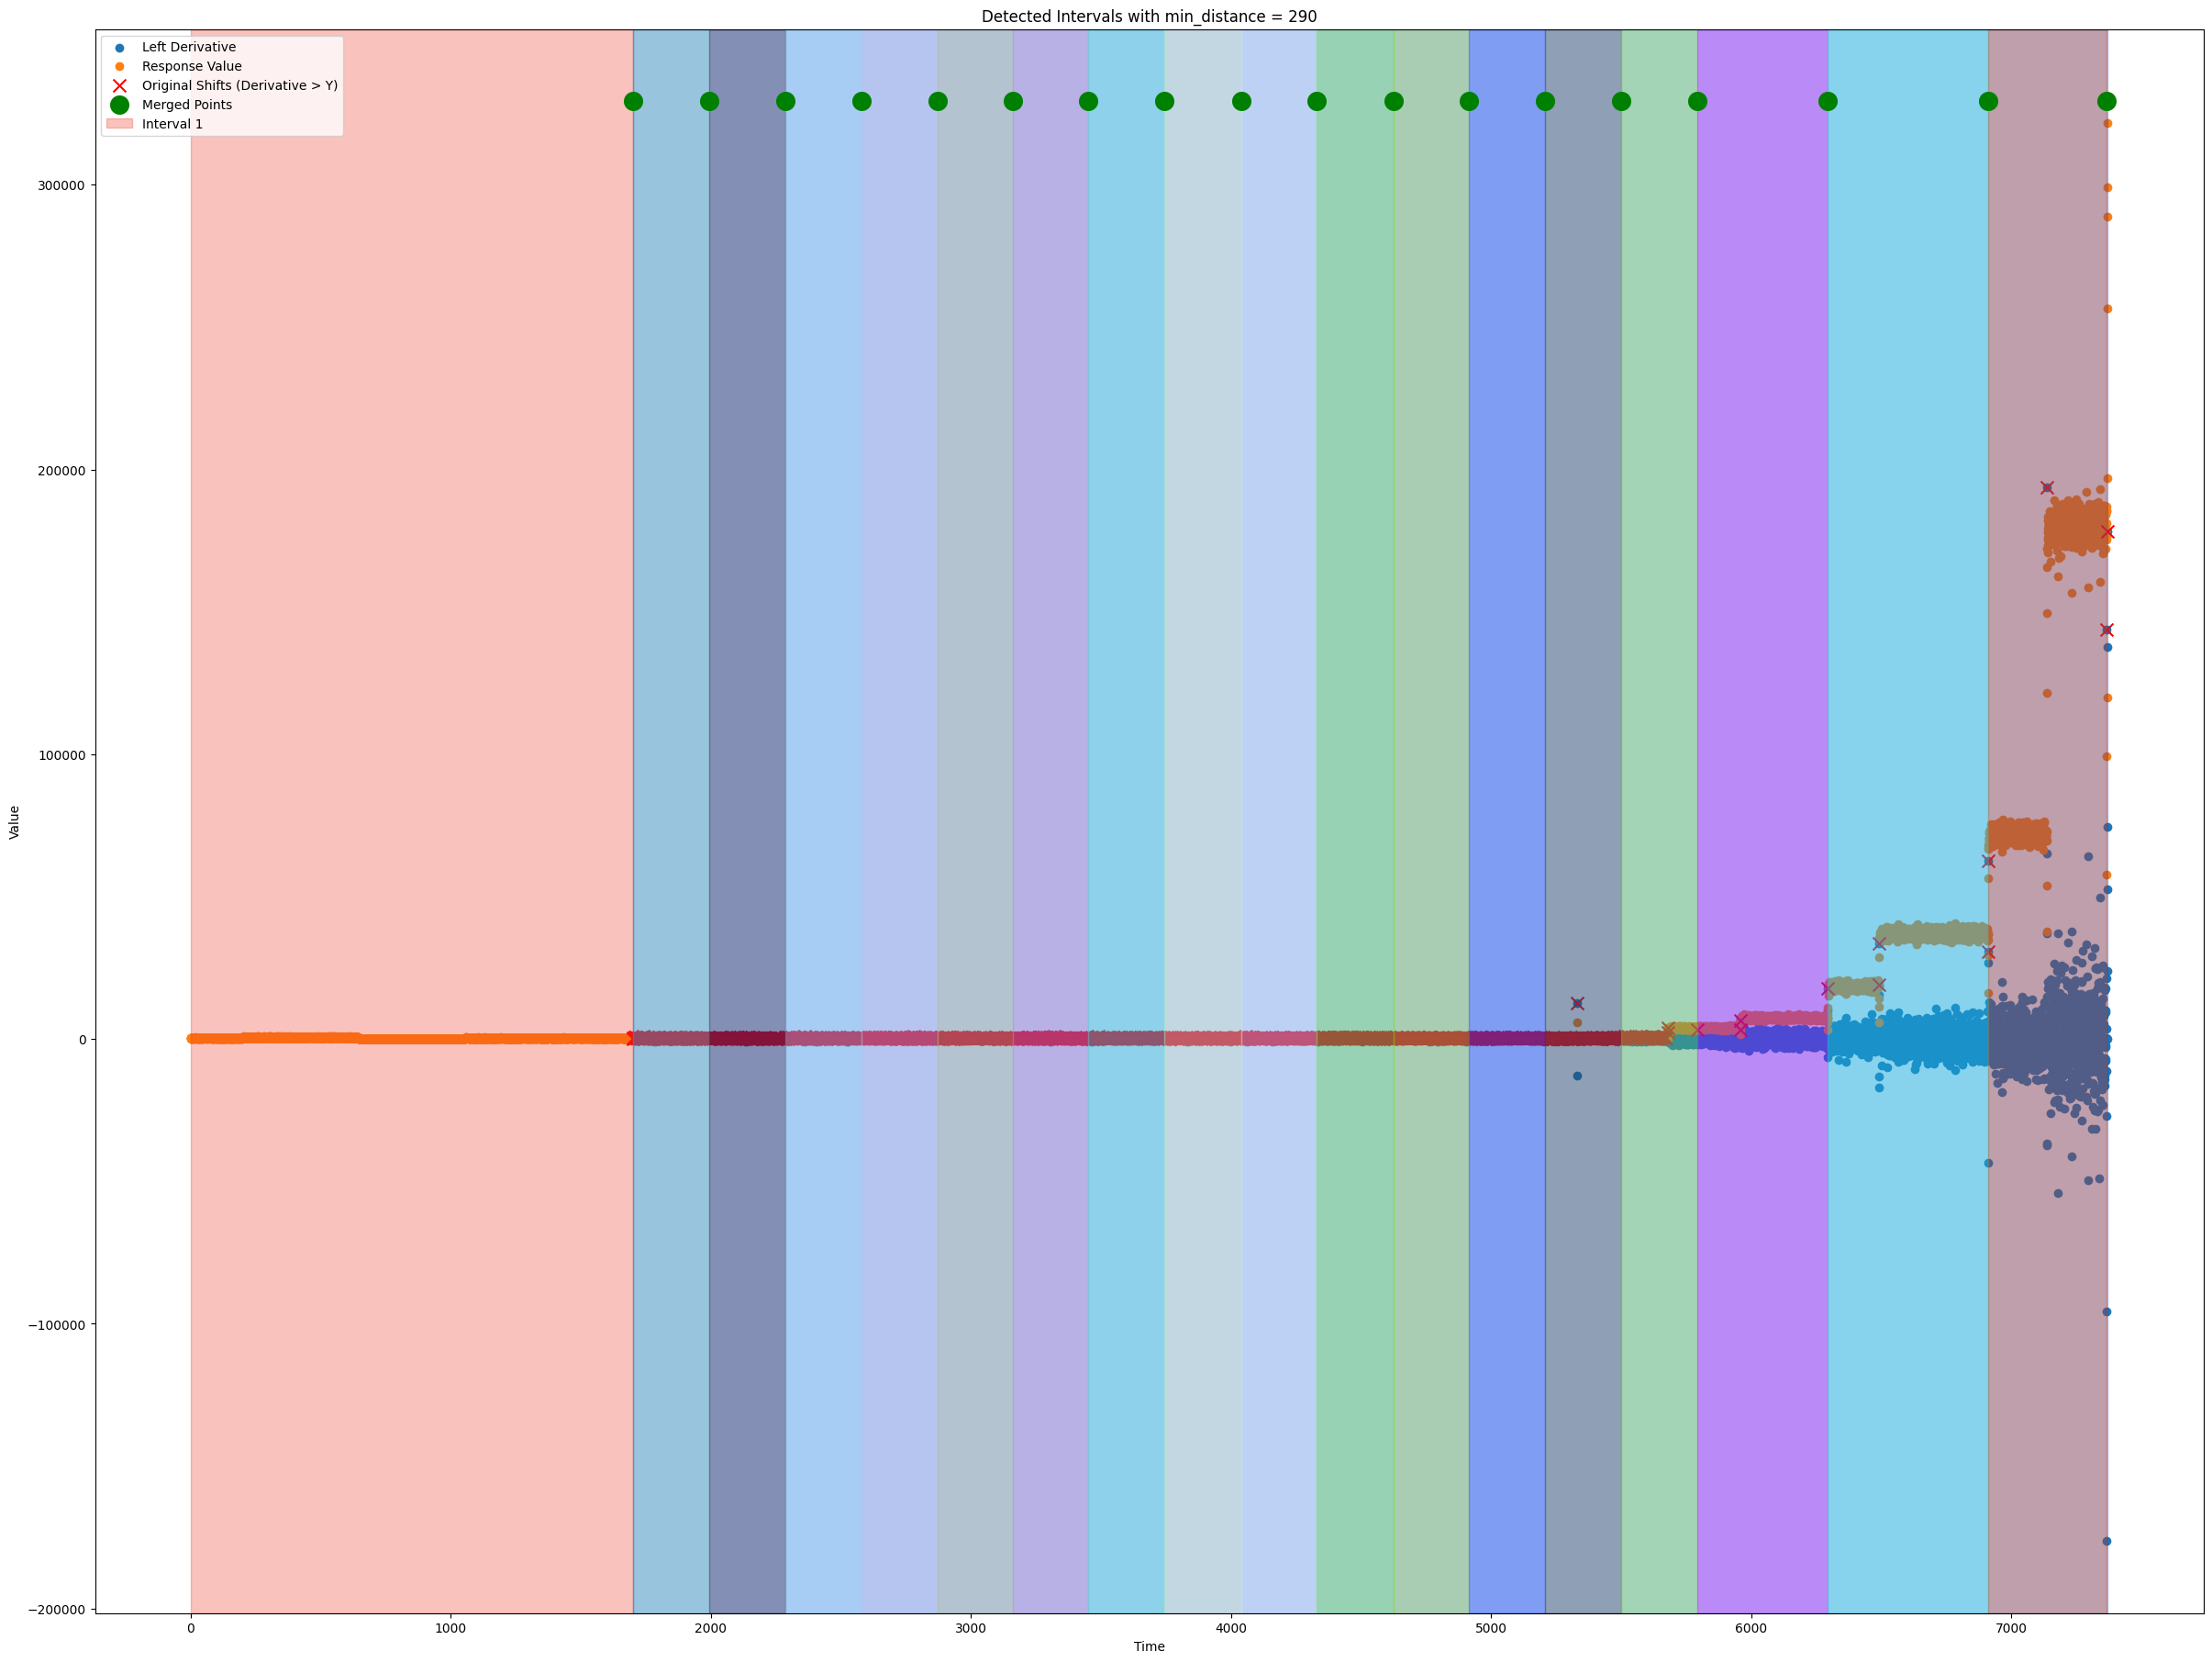


--- Testing with min_distance = 310 ---
Number of merged points for min_distance 310: 17
Detected intervals for min_distance 310:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2010.17),
 (np.float64(1699.982), np.float64(7370.625)),
 (2010.17, 2320.357),
 (2320.357, 2630.977),
 (2630.977, 2942.029),
 (2942.029, 3252.216),
 (3252.216, 3563.7),
 (3563.7, 3877.775),
 (3877.775, 4190.555),
 (4190.555, 4500.742),
 (4500.742, 4814.818),
 (4814.818, 5126.301),
 (5126.301, 5441.241),
 (5441.241, 5792.902),
 (5792.902, 6294.905),
 (6294.905, 6910.96),
 (6910.96, 7368.033)]

<Figure size 640x480 with 0 Axes>

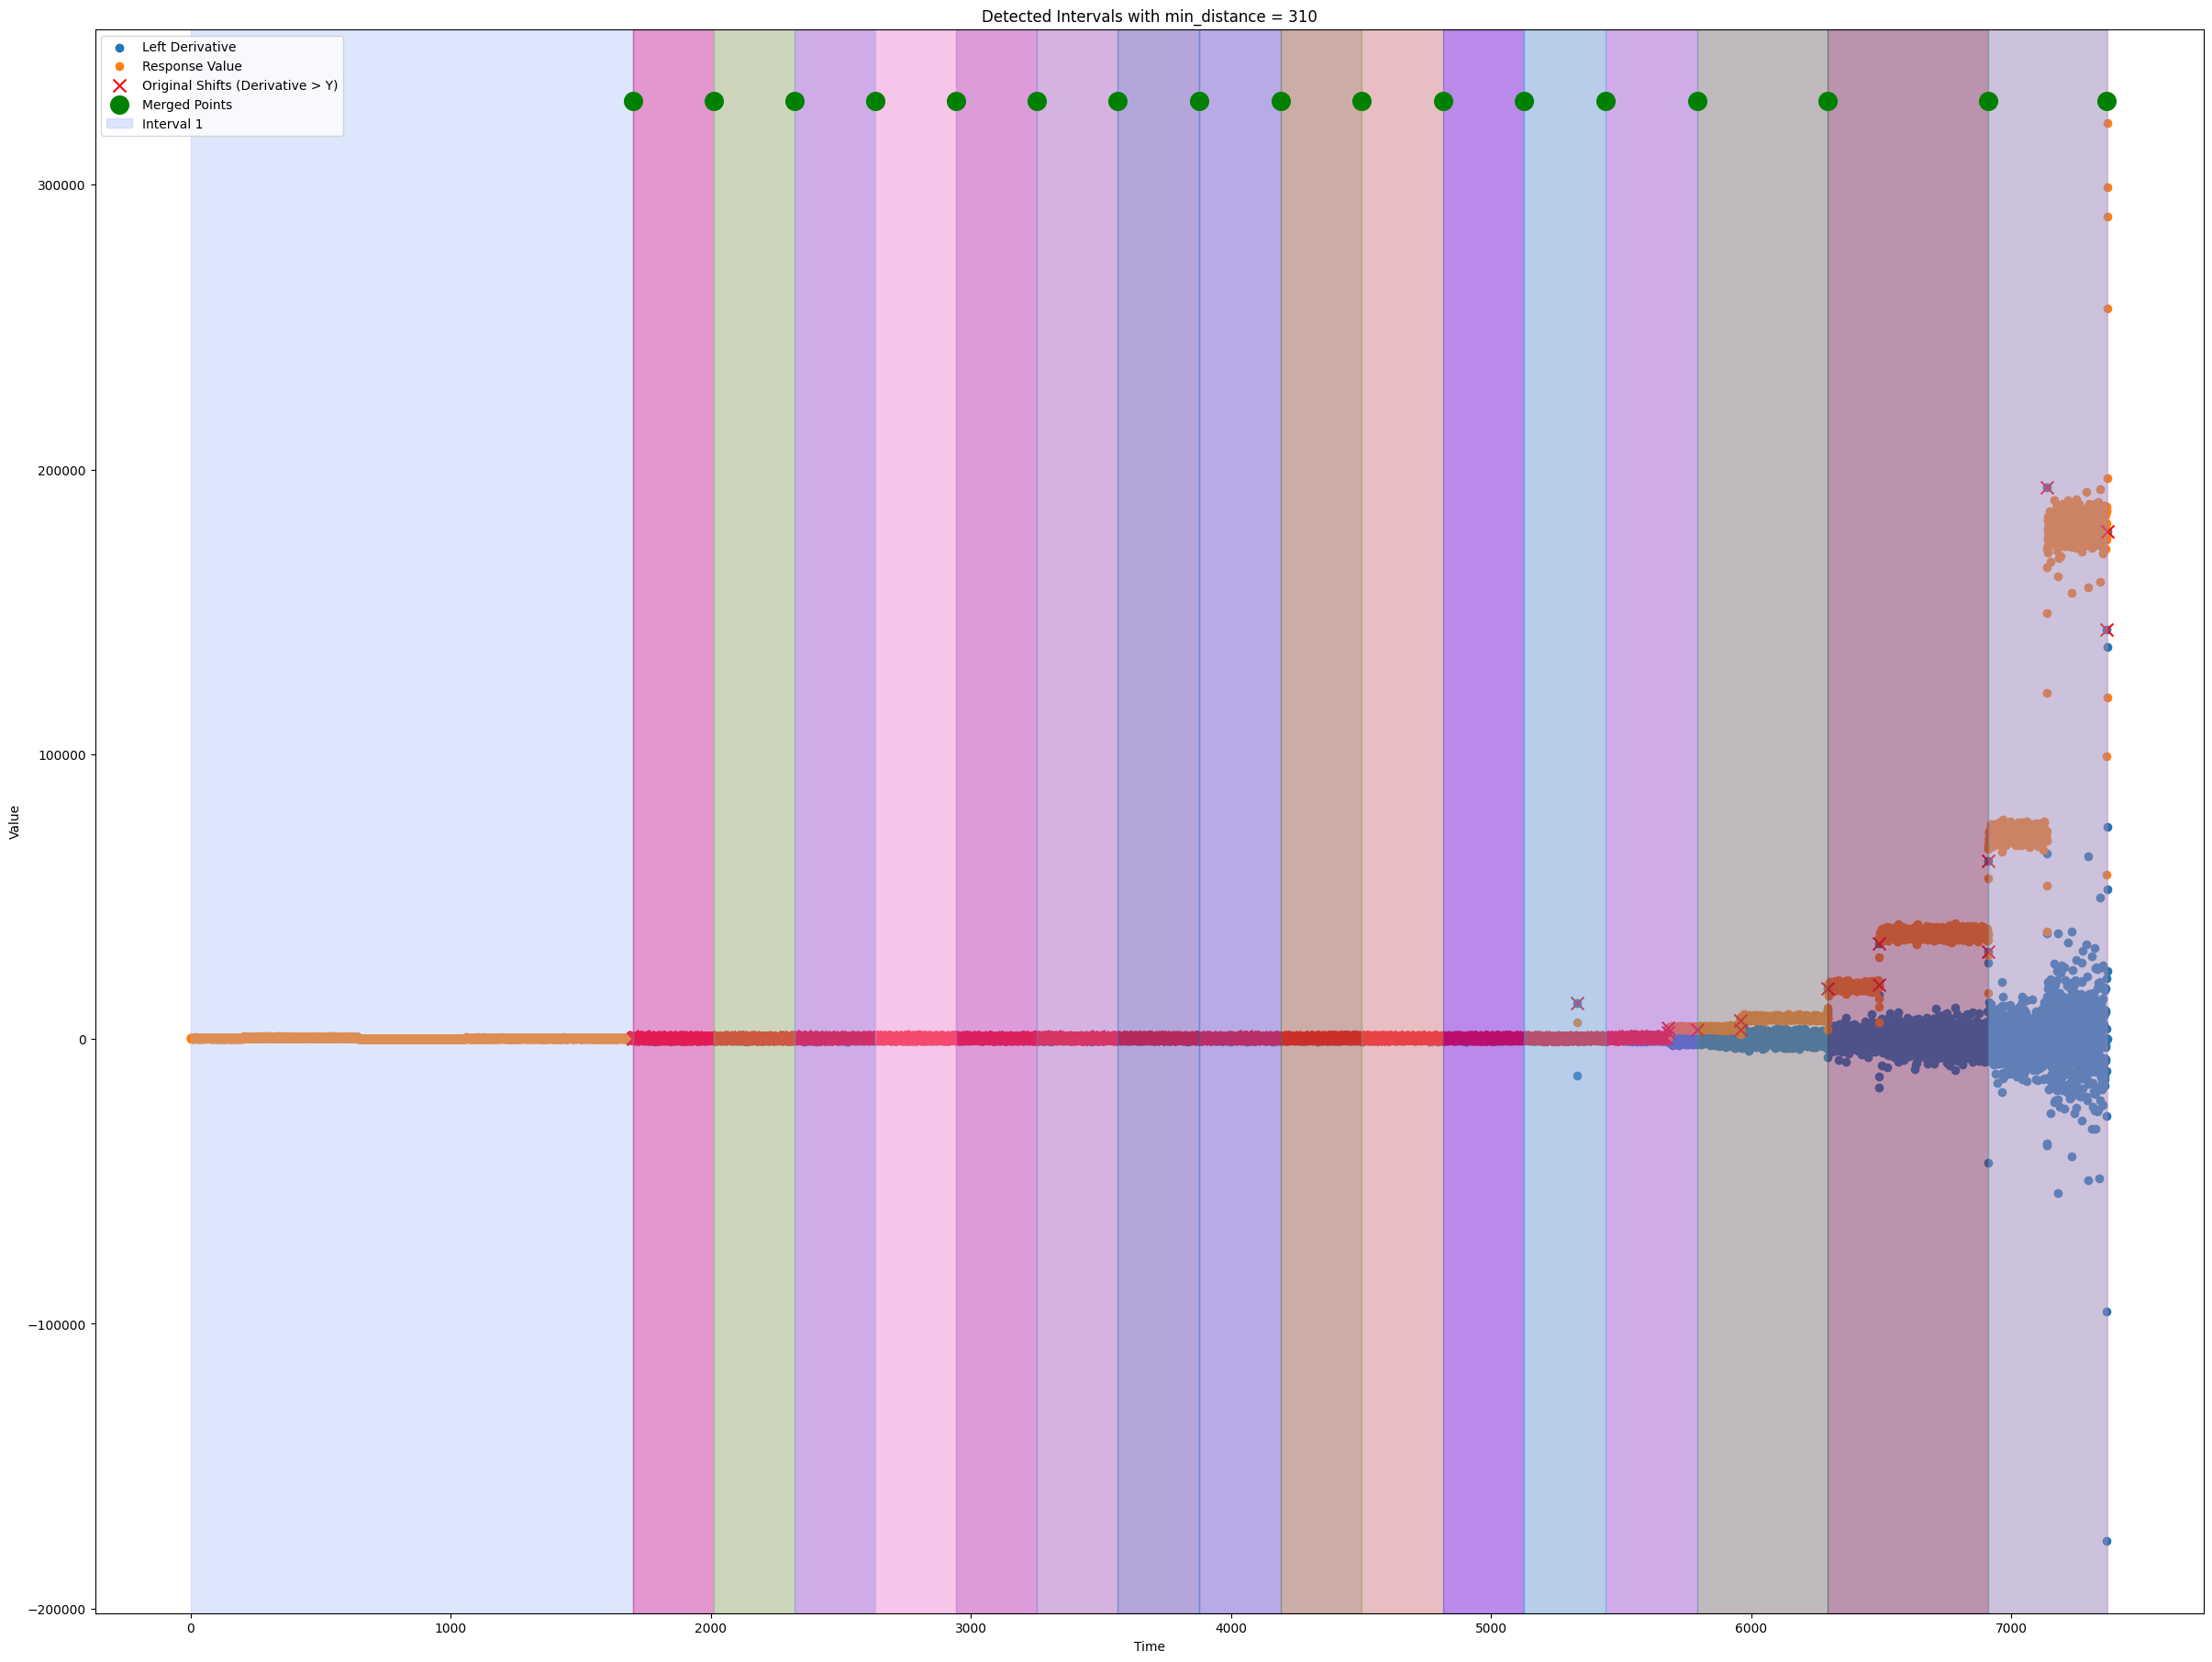


--- Testing with min_distance = 330 ---
Number of merged points for min_distance 330: 16
Detected intervals for min_distance 330:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2032.203),
 (np.float64(1699.982), np.float64(7370.625)),
 (2032.203, 2362.263),
 (2362.263, 2693.619),
 (2693.619, 3026.272),
 (3026.272, 3357.196),
 (3357.196, 3688.12),
 (3688.12, 4019.908),
 (4019.908, 4349.969),
 (4349.969, 4681.757),
 (4681.757, 5013.545),
 (5013.545, 5344.47),
 (5344.47, 5678.418),
 (5678.418, 6294.905),
 (6294.905, 6910.96),
 (6910.96, 7368.033)]

<Figure size 640x480 with 0 Axes>

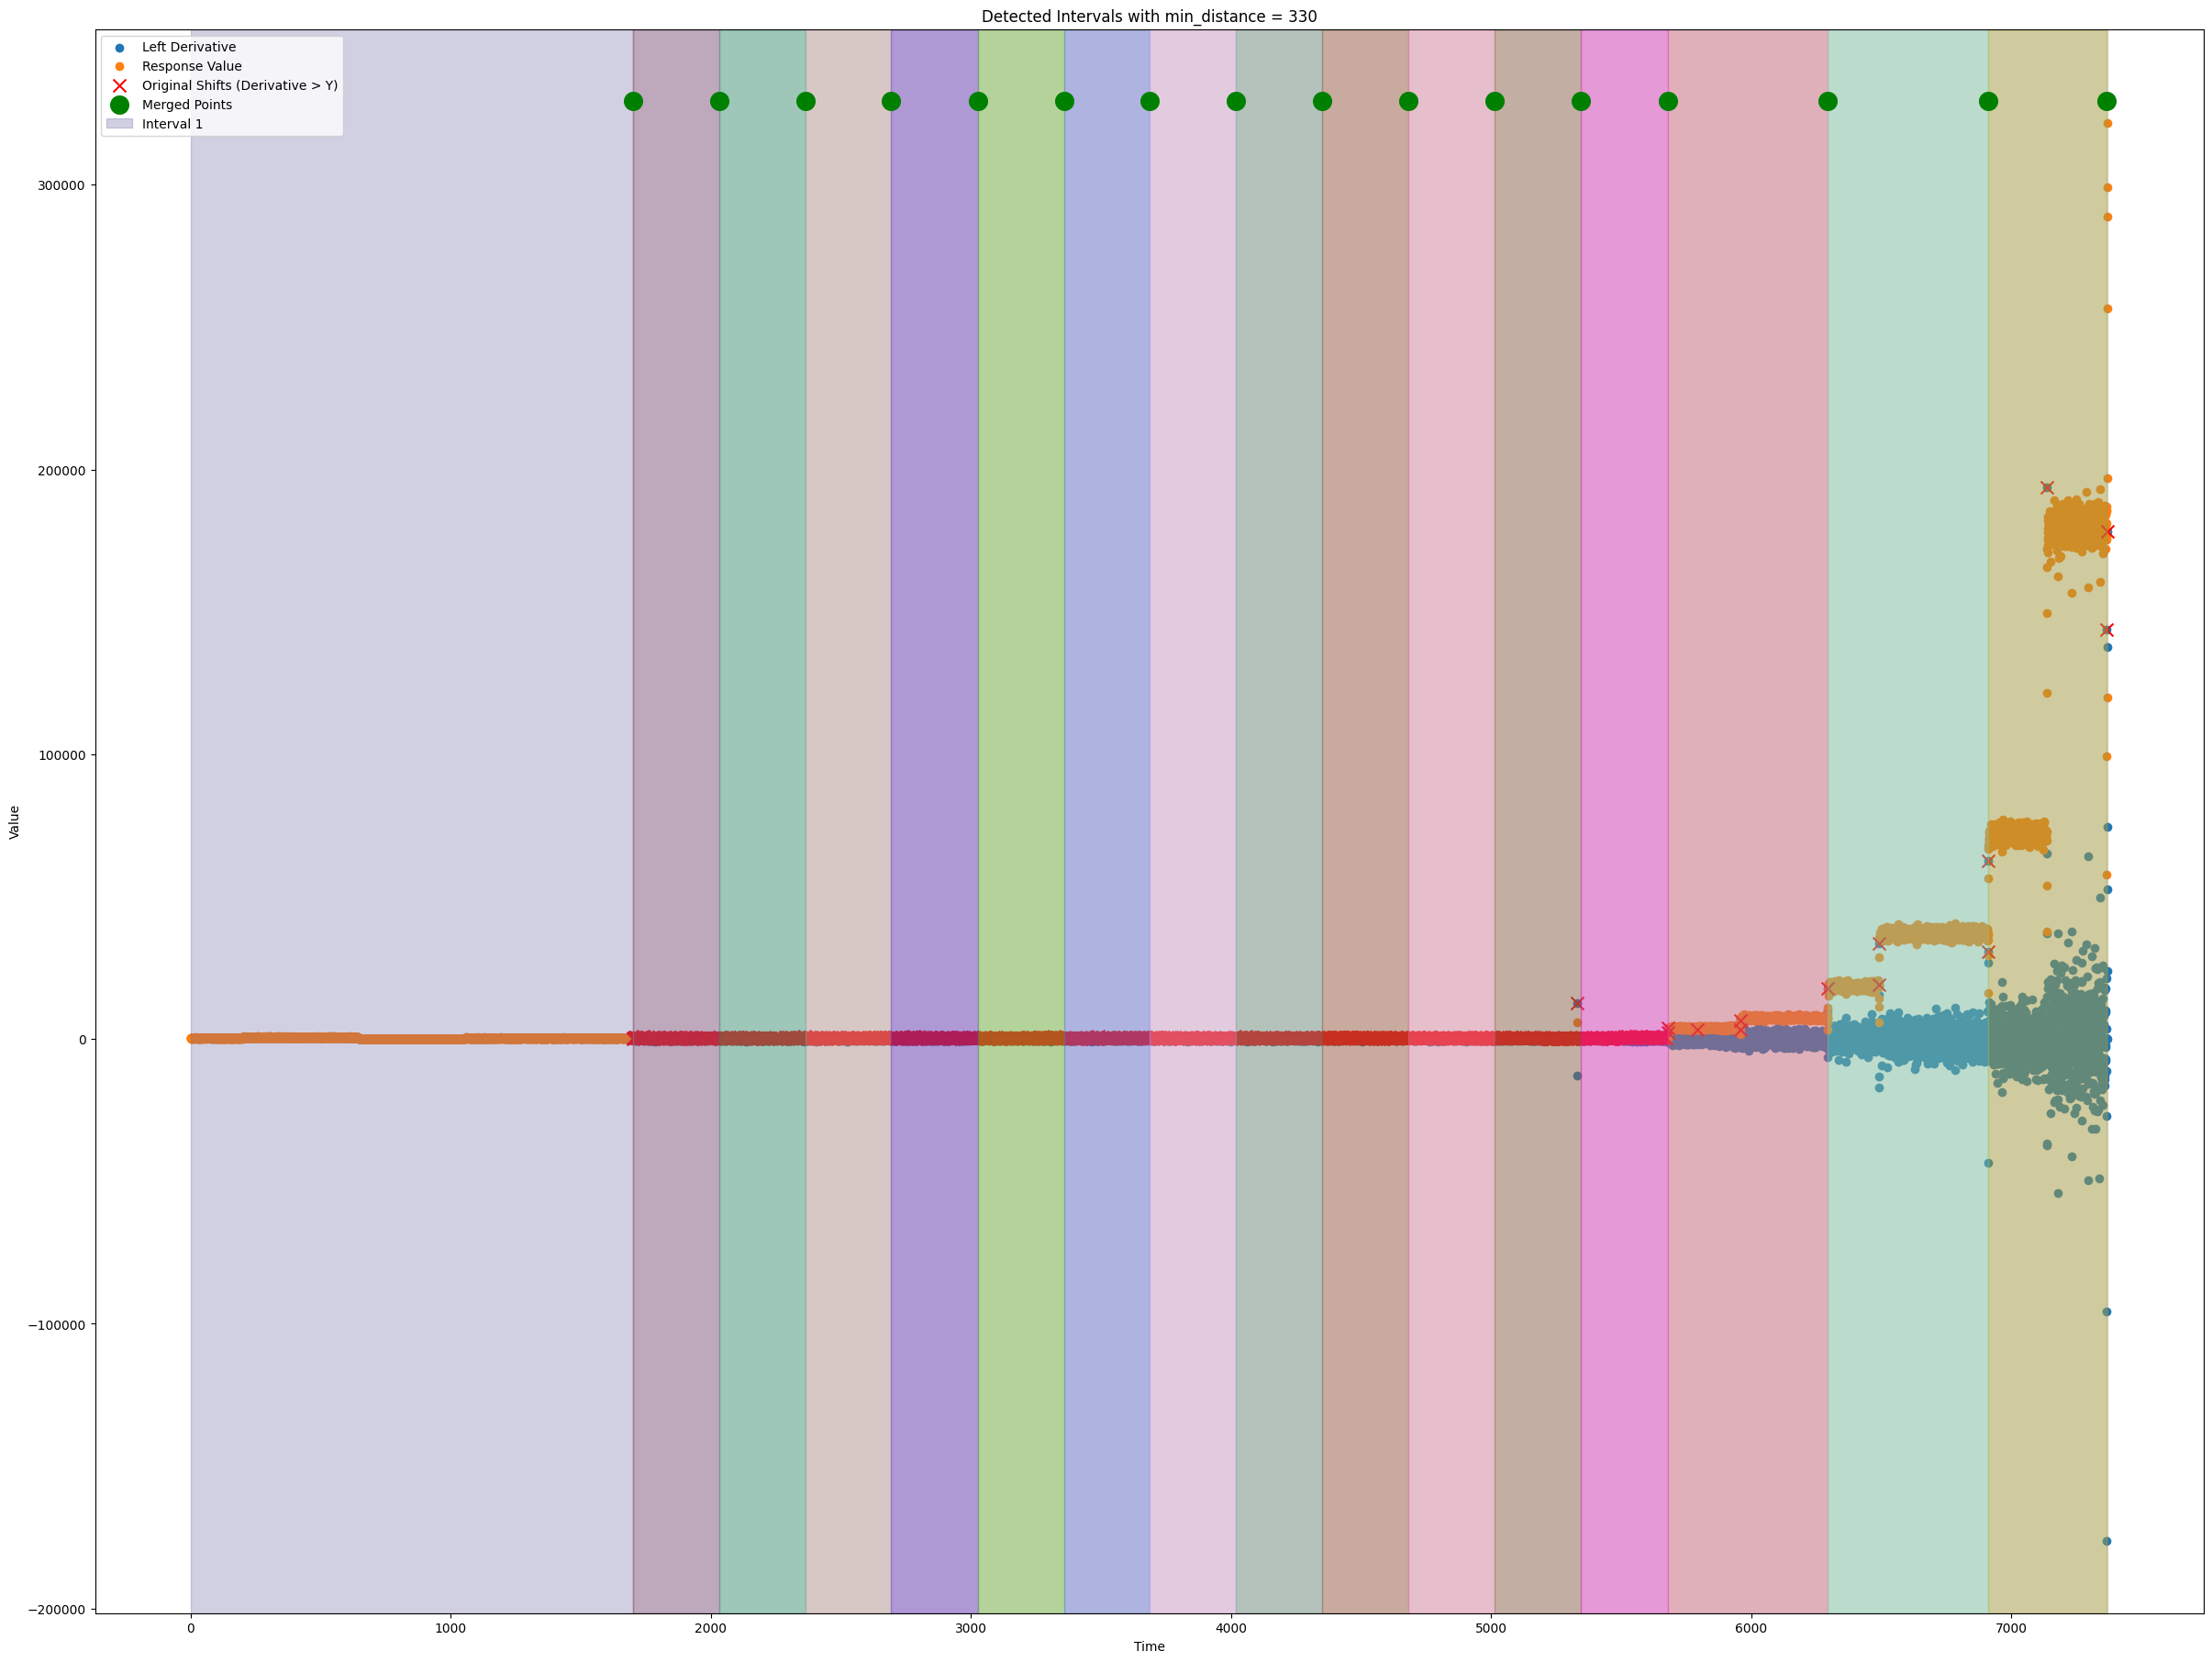


--- Testing with min_distance = 350 ---
Number of merged points for min_distance 350: 16
Detected intervals for min_distance 350:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2052.076),
 (np.float64(1699.982), np.float64(7370.625)),
 (2052.076, 2402.873),
 (2402.873, 2754.102),
 (2754.102, 3104.899),
 (3104.899, 3455.264),
 (3455.264, 3806.061),
 (3806.061, 4156.426),
 (4156.426, 4508.951),
 (4508.951, 4861.044),
 (4861.044, 5213.569),
 (5213.569, 5568.254),
 (5568.254, 5957.068),
 (5957.068, 6491.904),
 (6491.904, 6910.96),
 (6910.96, 7368.033)]

<Figure size 640x480 with 0 Axes>

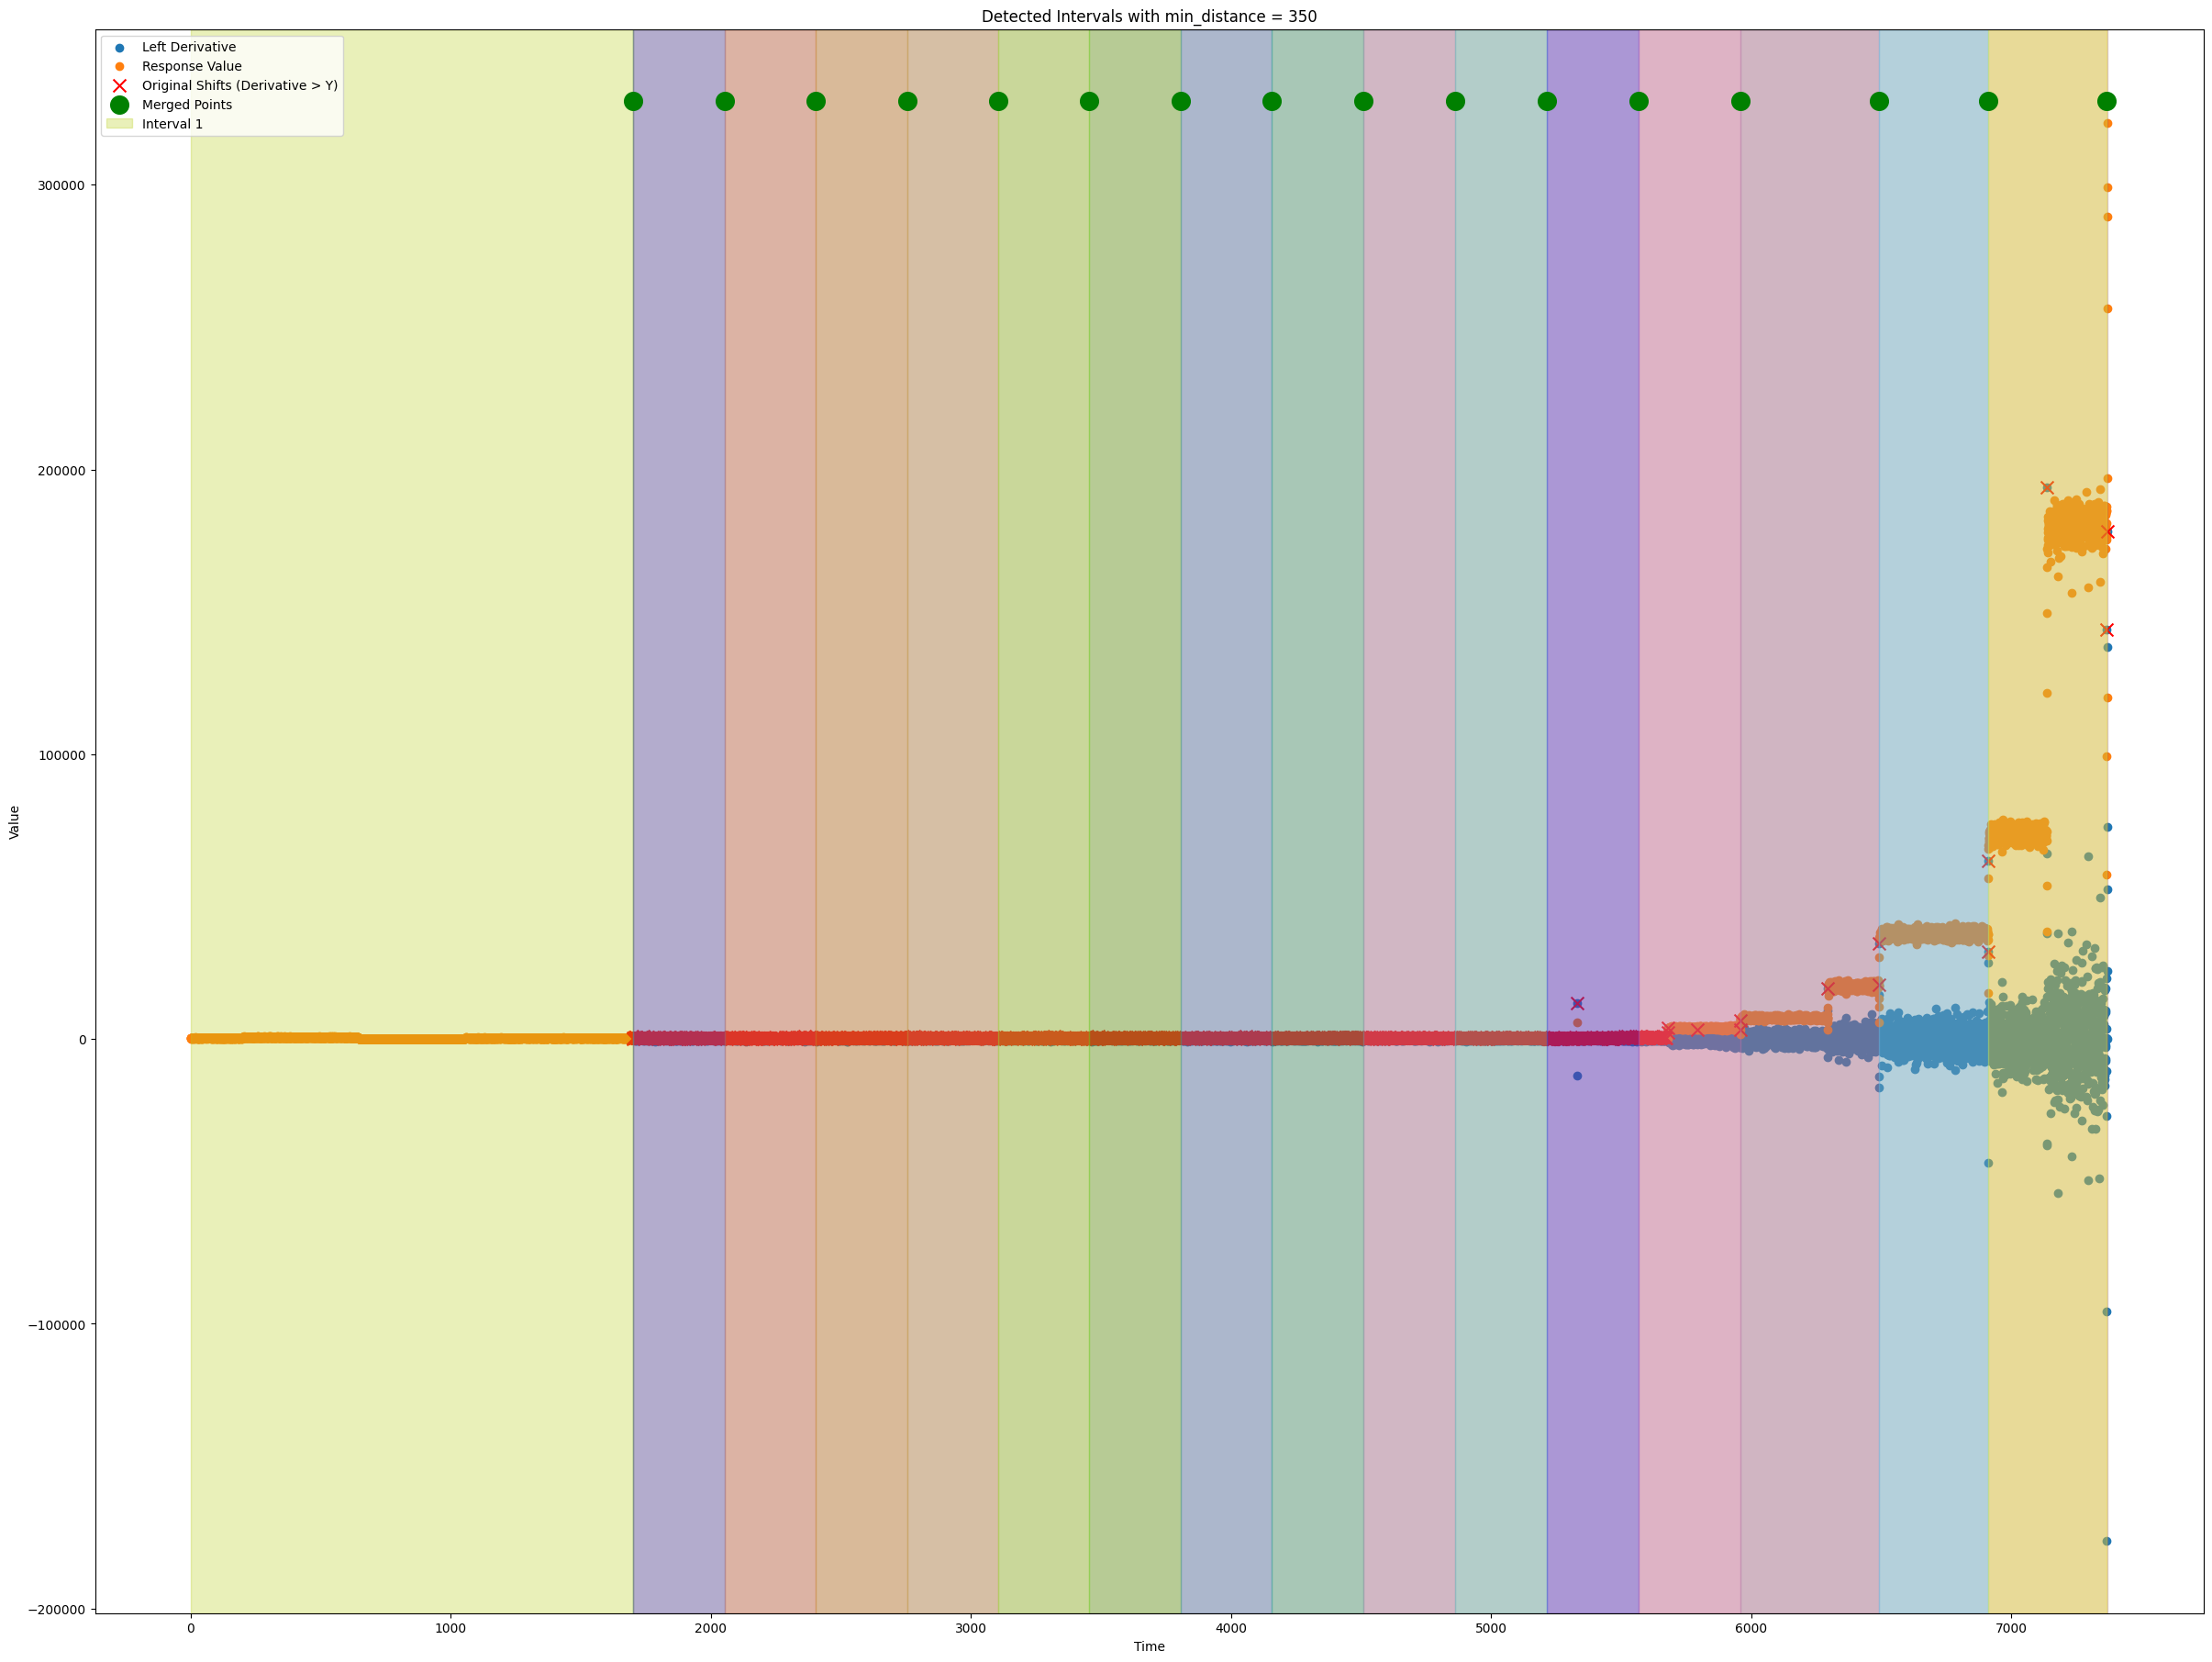


--- Testing with min_distance = 370 ---
Number of merged points for min_distance 370: 15
Detected intervals for min_distance 370:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2070.652),
 (np.float64(1699.982), np.float64(7370.625)),
 (2070.652, 2441.322),
 (2441.322, 2812.424),
 (2812.424, 3192.598),
 (3192.598, 3563.7),
 (3563.7, 3933.937),
 (3933.937, 4304.175),
 (4304.175, 4677.869),
 (4677.869, 5048.539),
 (5048.539, 5419.64),
 (5419.64, 5792.902),
 (5792.902, 6294.905),
 (6294.905, 6910.96),
 (6910.96, 7368.033)]

<Figure size 640x480 with 0 Axes>

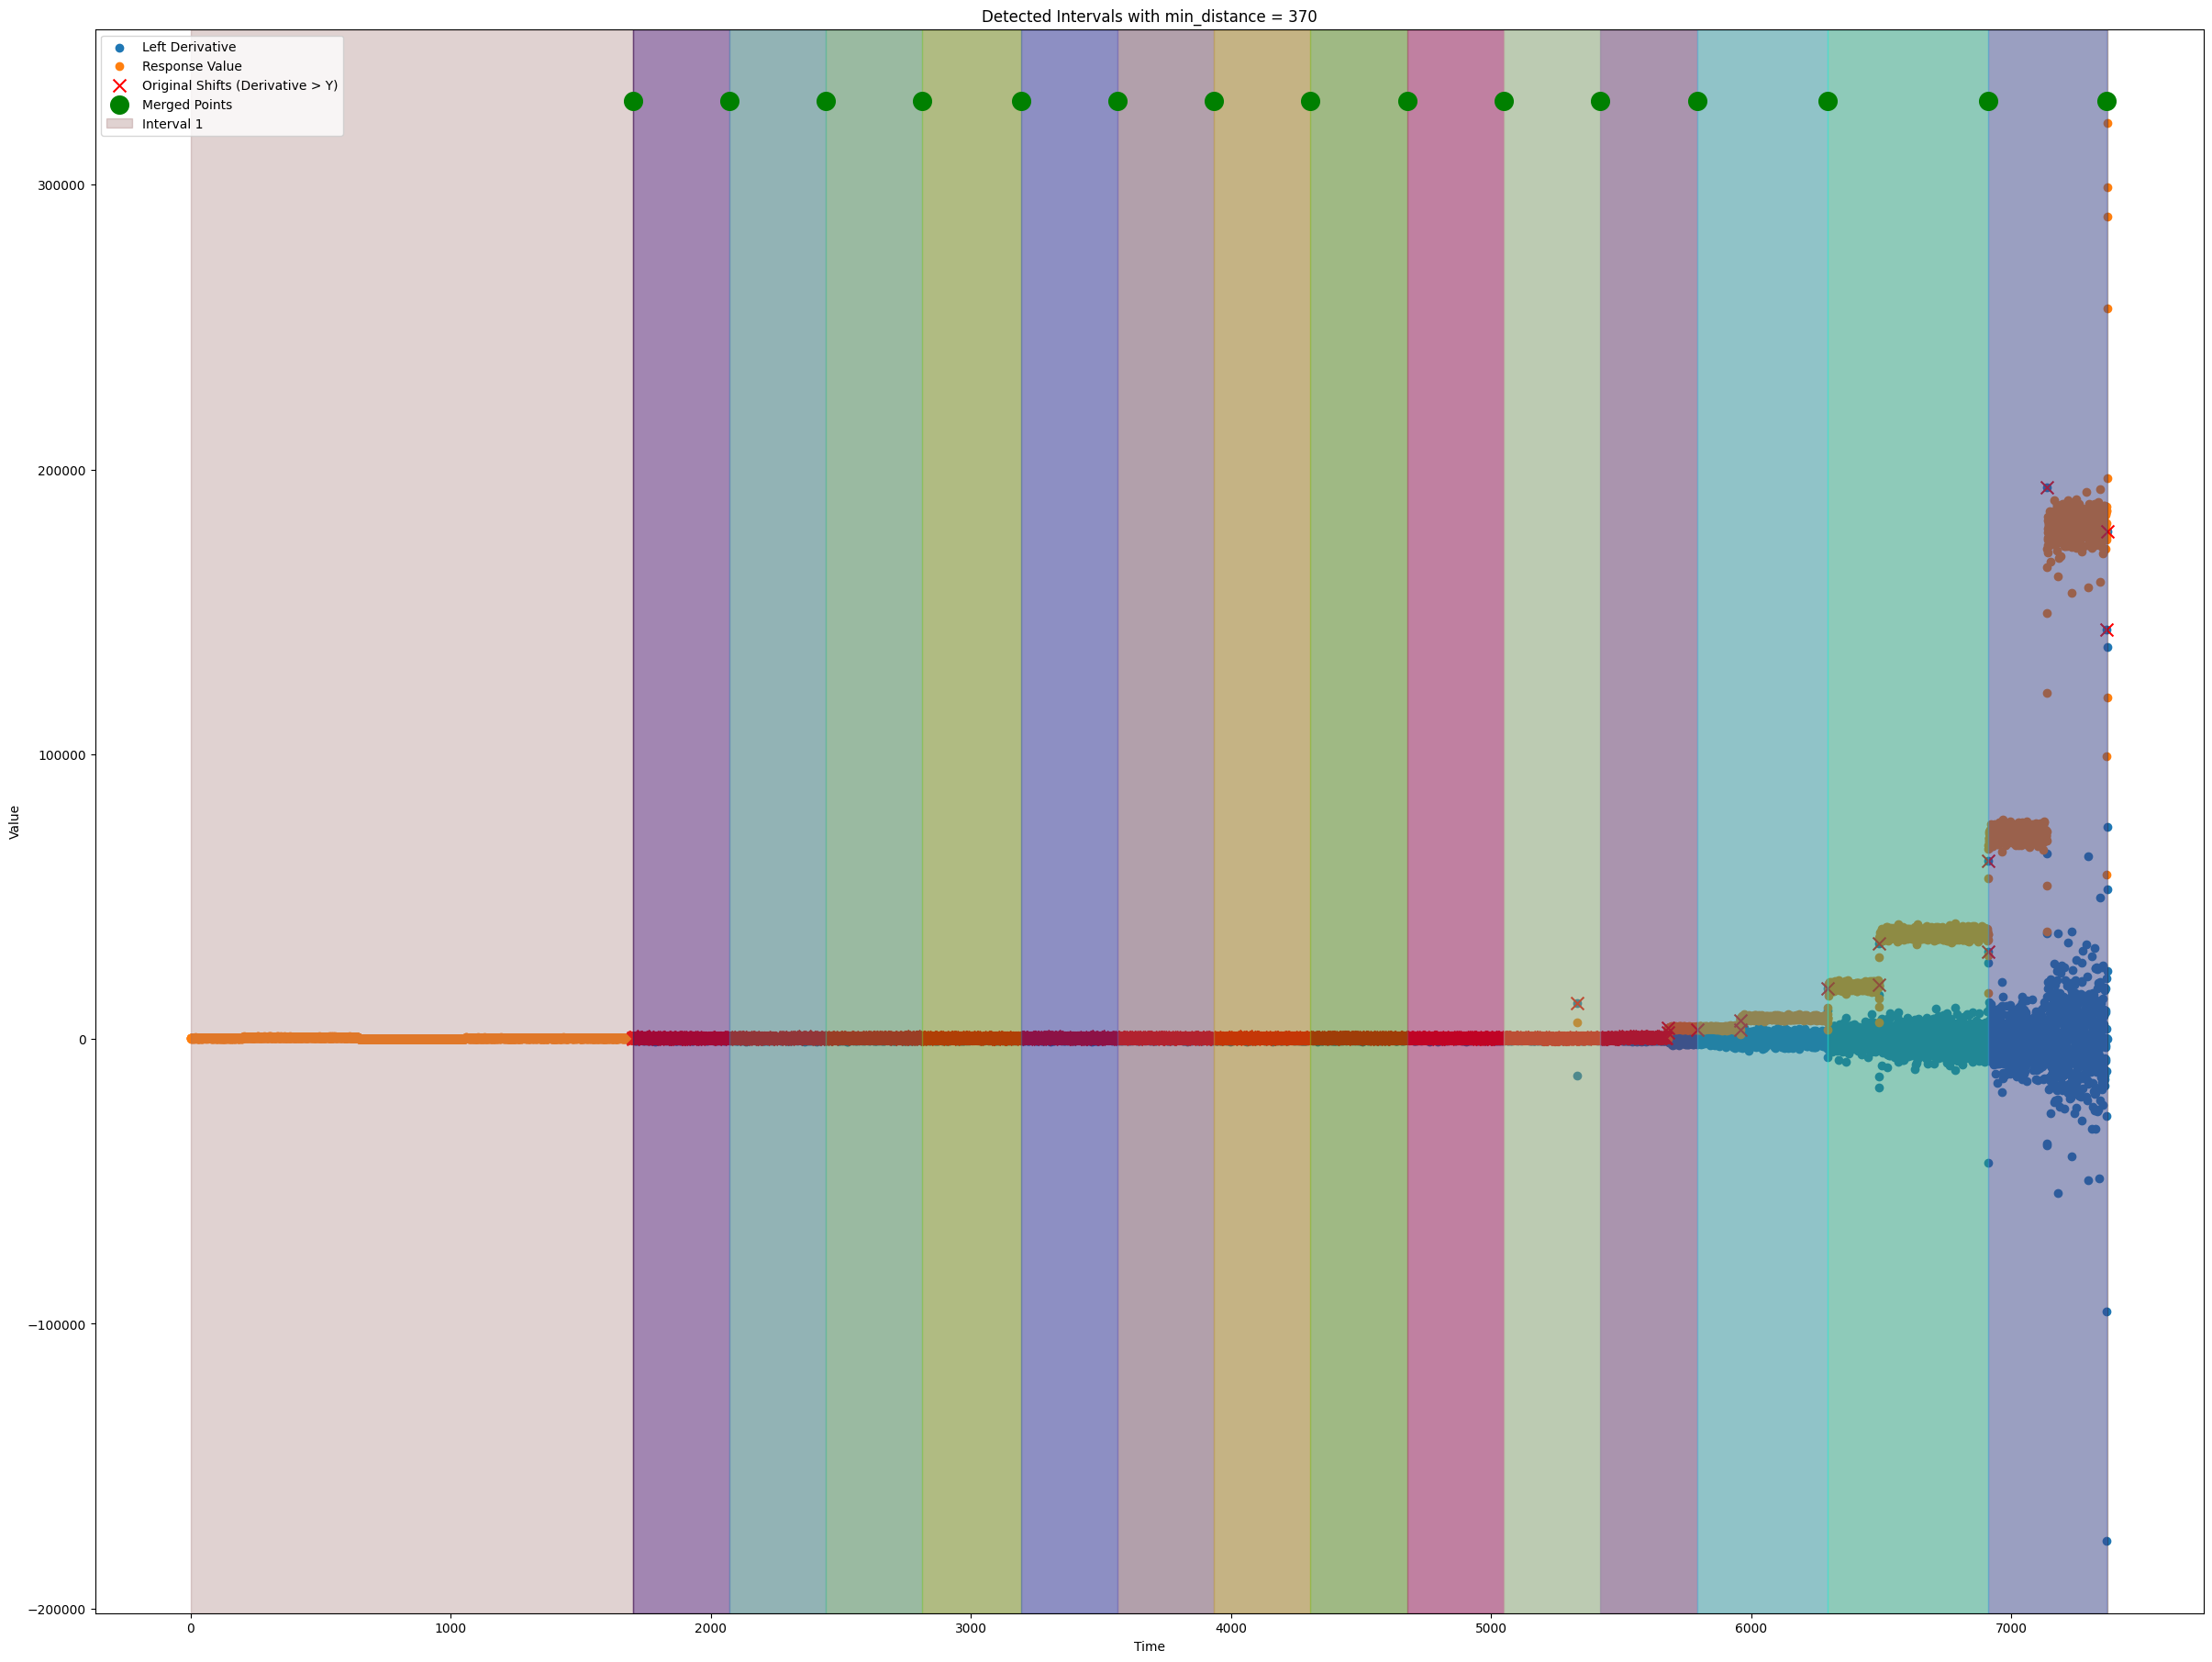


--- Testing with min_distance = 390 ---
Number of merged points for min_distance 390: 14
Detected intervals for min_distance 390:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2090.093),
 (np.float64(1699.982), np.float64(7370.625)),
 (2090.093, 2480.635),
 (2480.635, 2870.746),
 (2870.746, 3261.288),
 (3261.288, 3651.831),
 (3651.831, 4043.237),
 (4043.237, 4435.076),
 (4435.076, 4826.482),
 (4826.482, 5217.025),
 (5217.025, 5609.727),
 (5609.727, 6294.905),
 (6294.905, 6910.96),
 (6910.96, 7368.033)]

<Figure size 640x480 with 0 Axes>

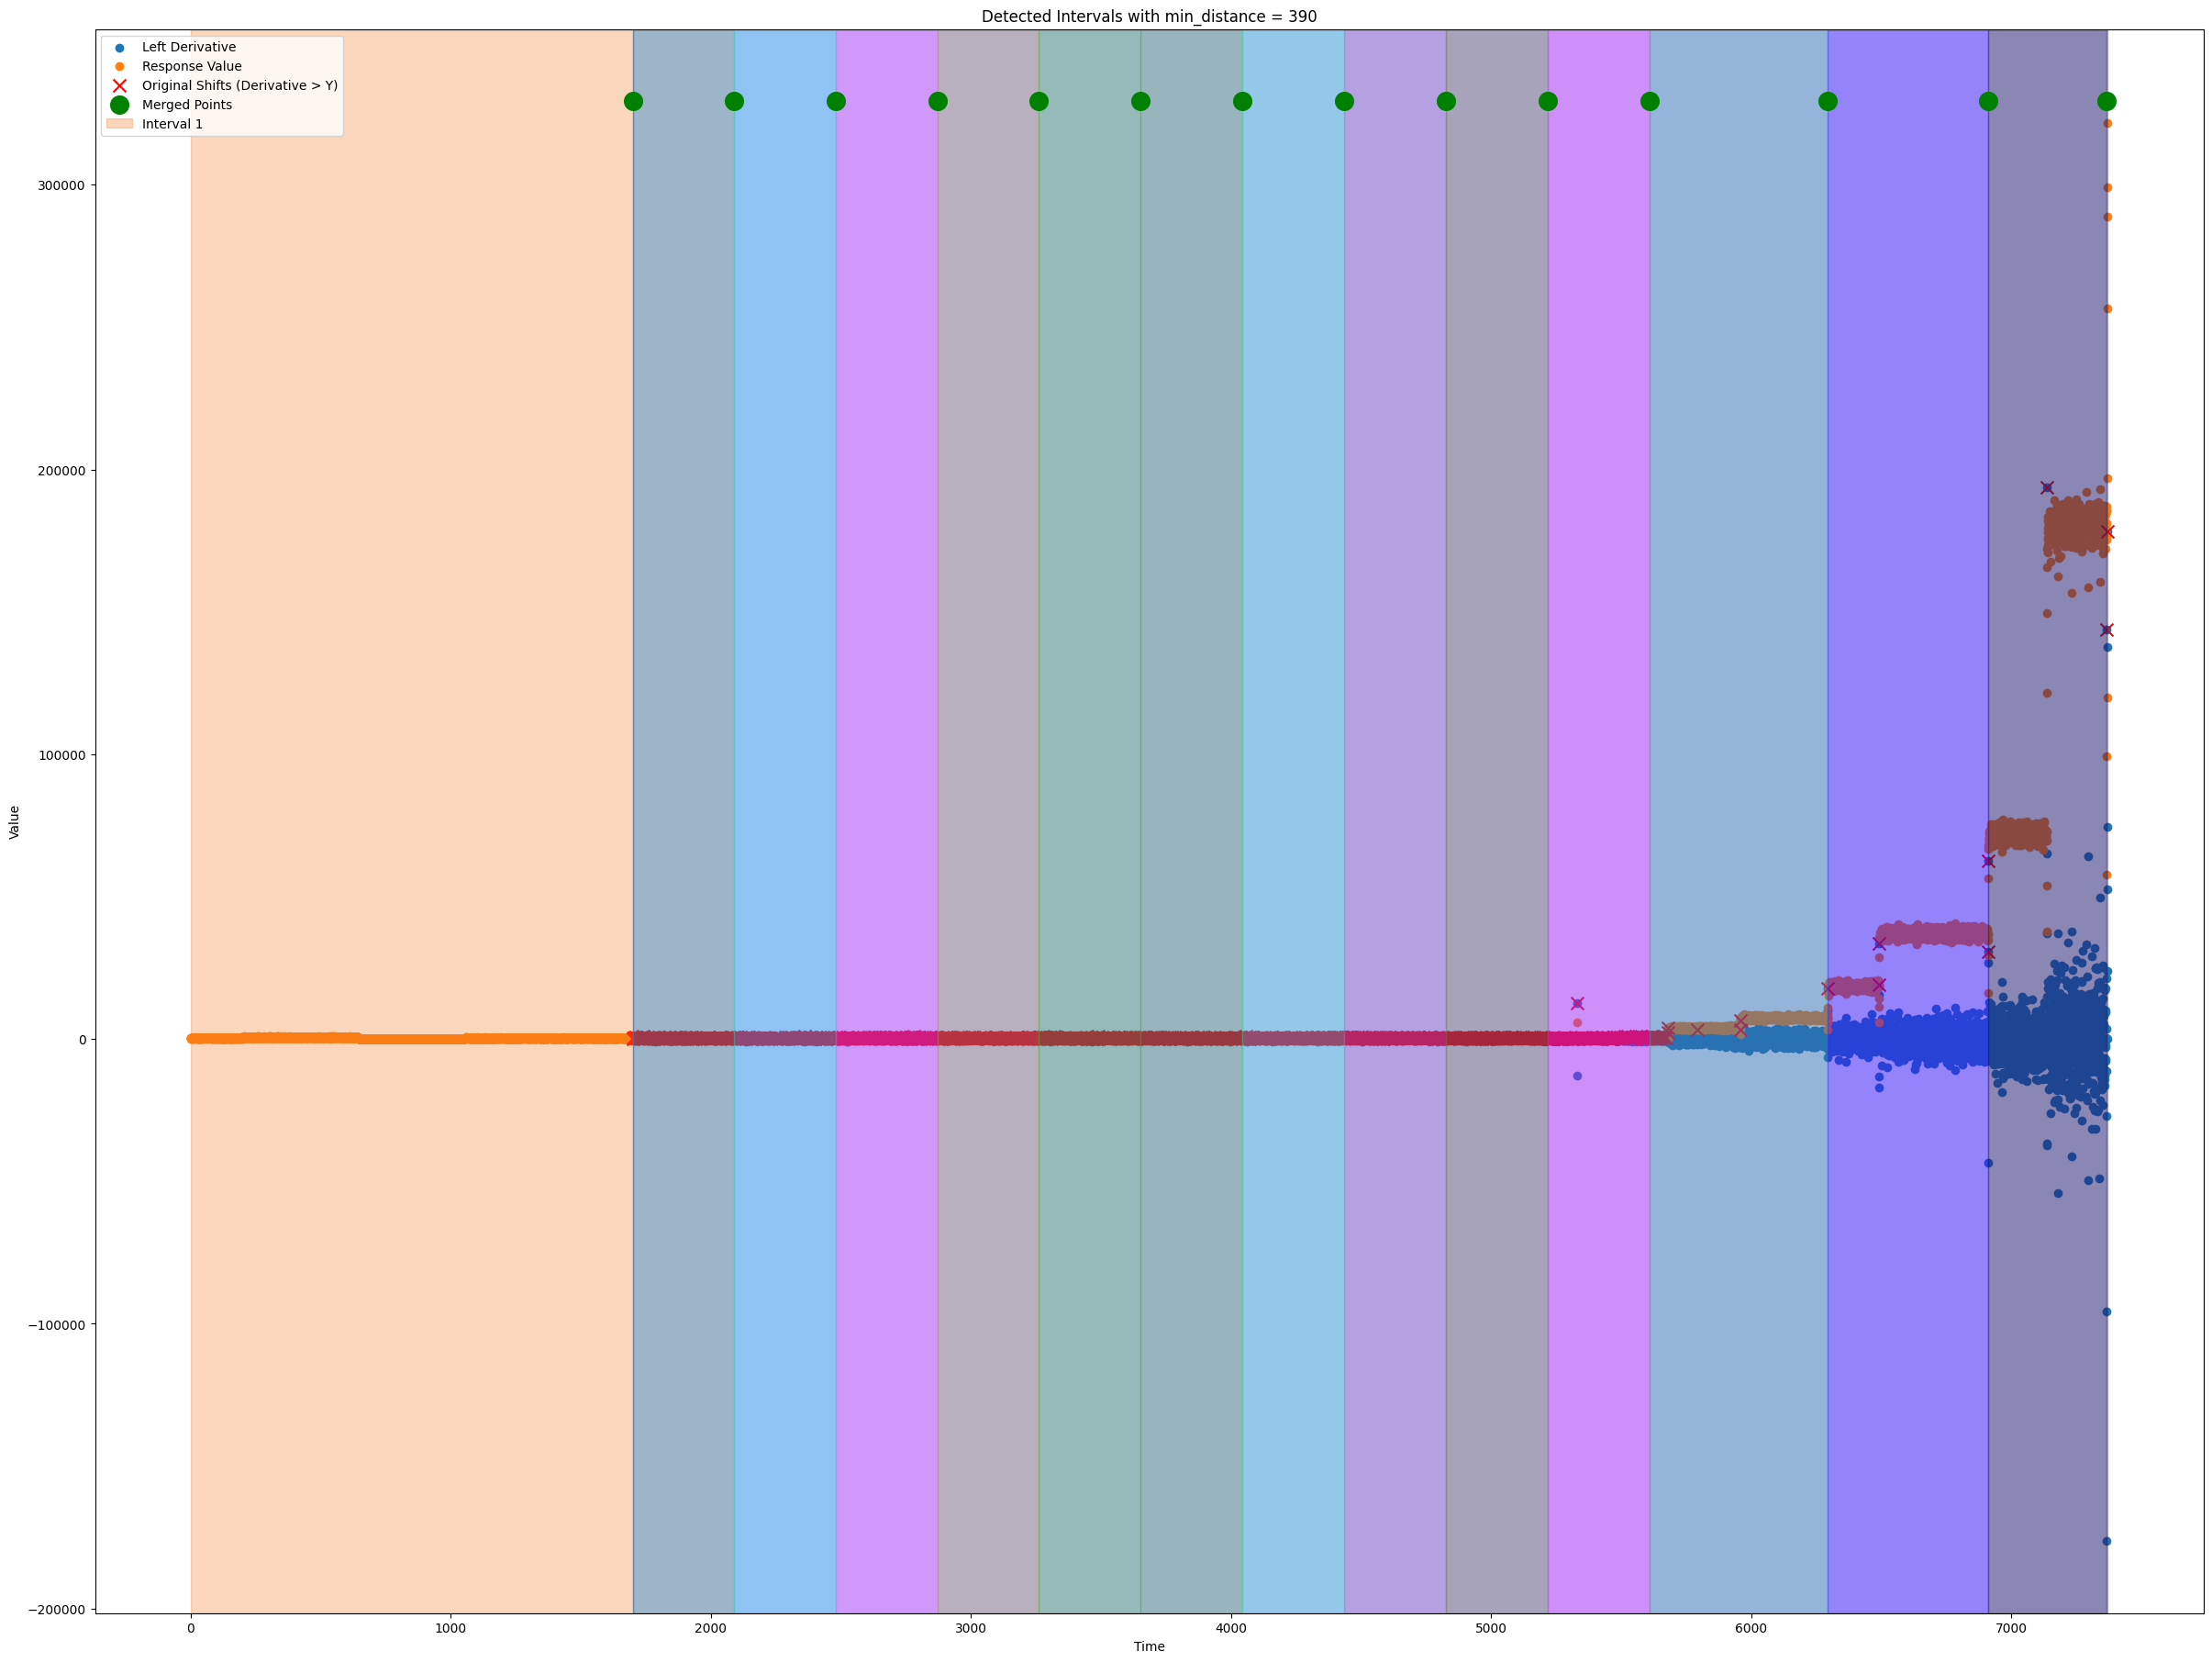


--- Testing with min_distance = 410 ---
Number of merged points for min_distance 410: 14
Detected intervals for min_distance 410:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2112.558),
 (np.float64(1699.982), np.float64(7370.625)),
 (2112.558, 2523.837),
 (2523.837, 2935.116),
 (2935.116, 3345.531),
 (3345.531, 3757.675),
 (3757.675, 4168.522),
 (4168.522, 4579.369),
 (4579.369, 4989.784),
 (4989.784, 5400.632),
 (5400.632, 5957.068),
 (5957.068, 6491.904),
 (6491.904, 6910.96),
 (6910.96, 7368.033)]

<Figure size 640x480 with 0 Axes>

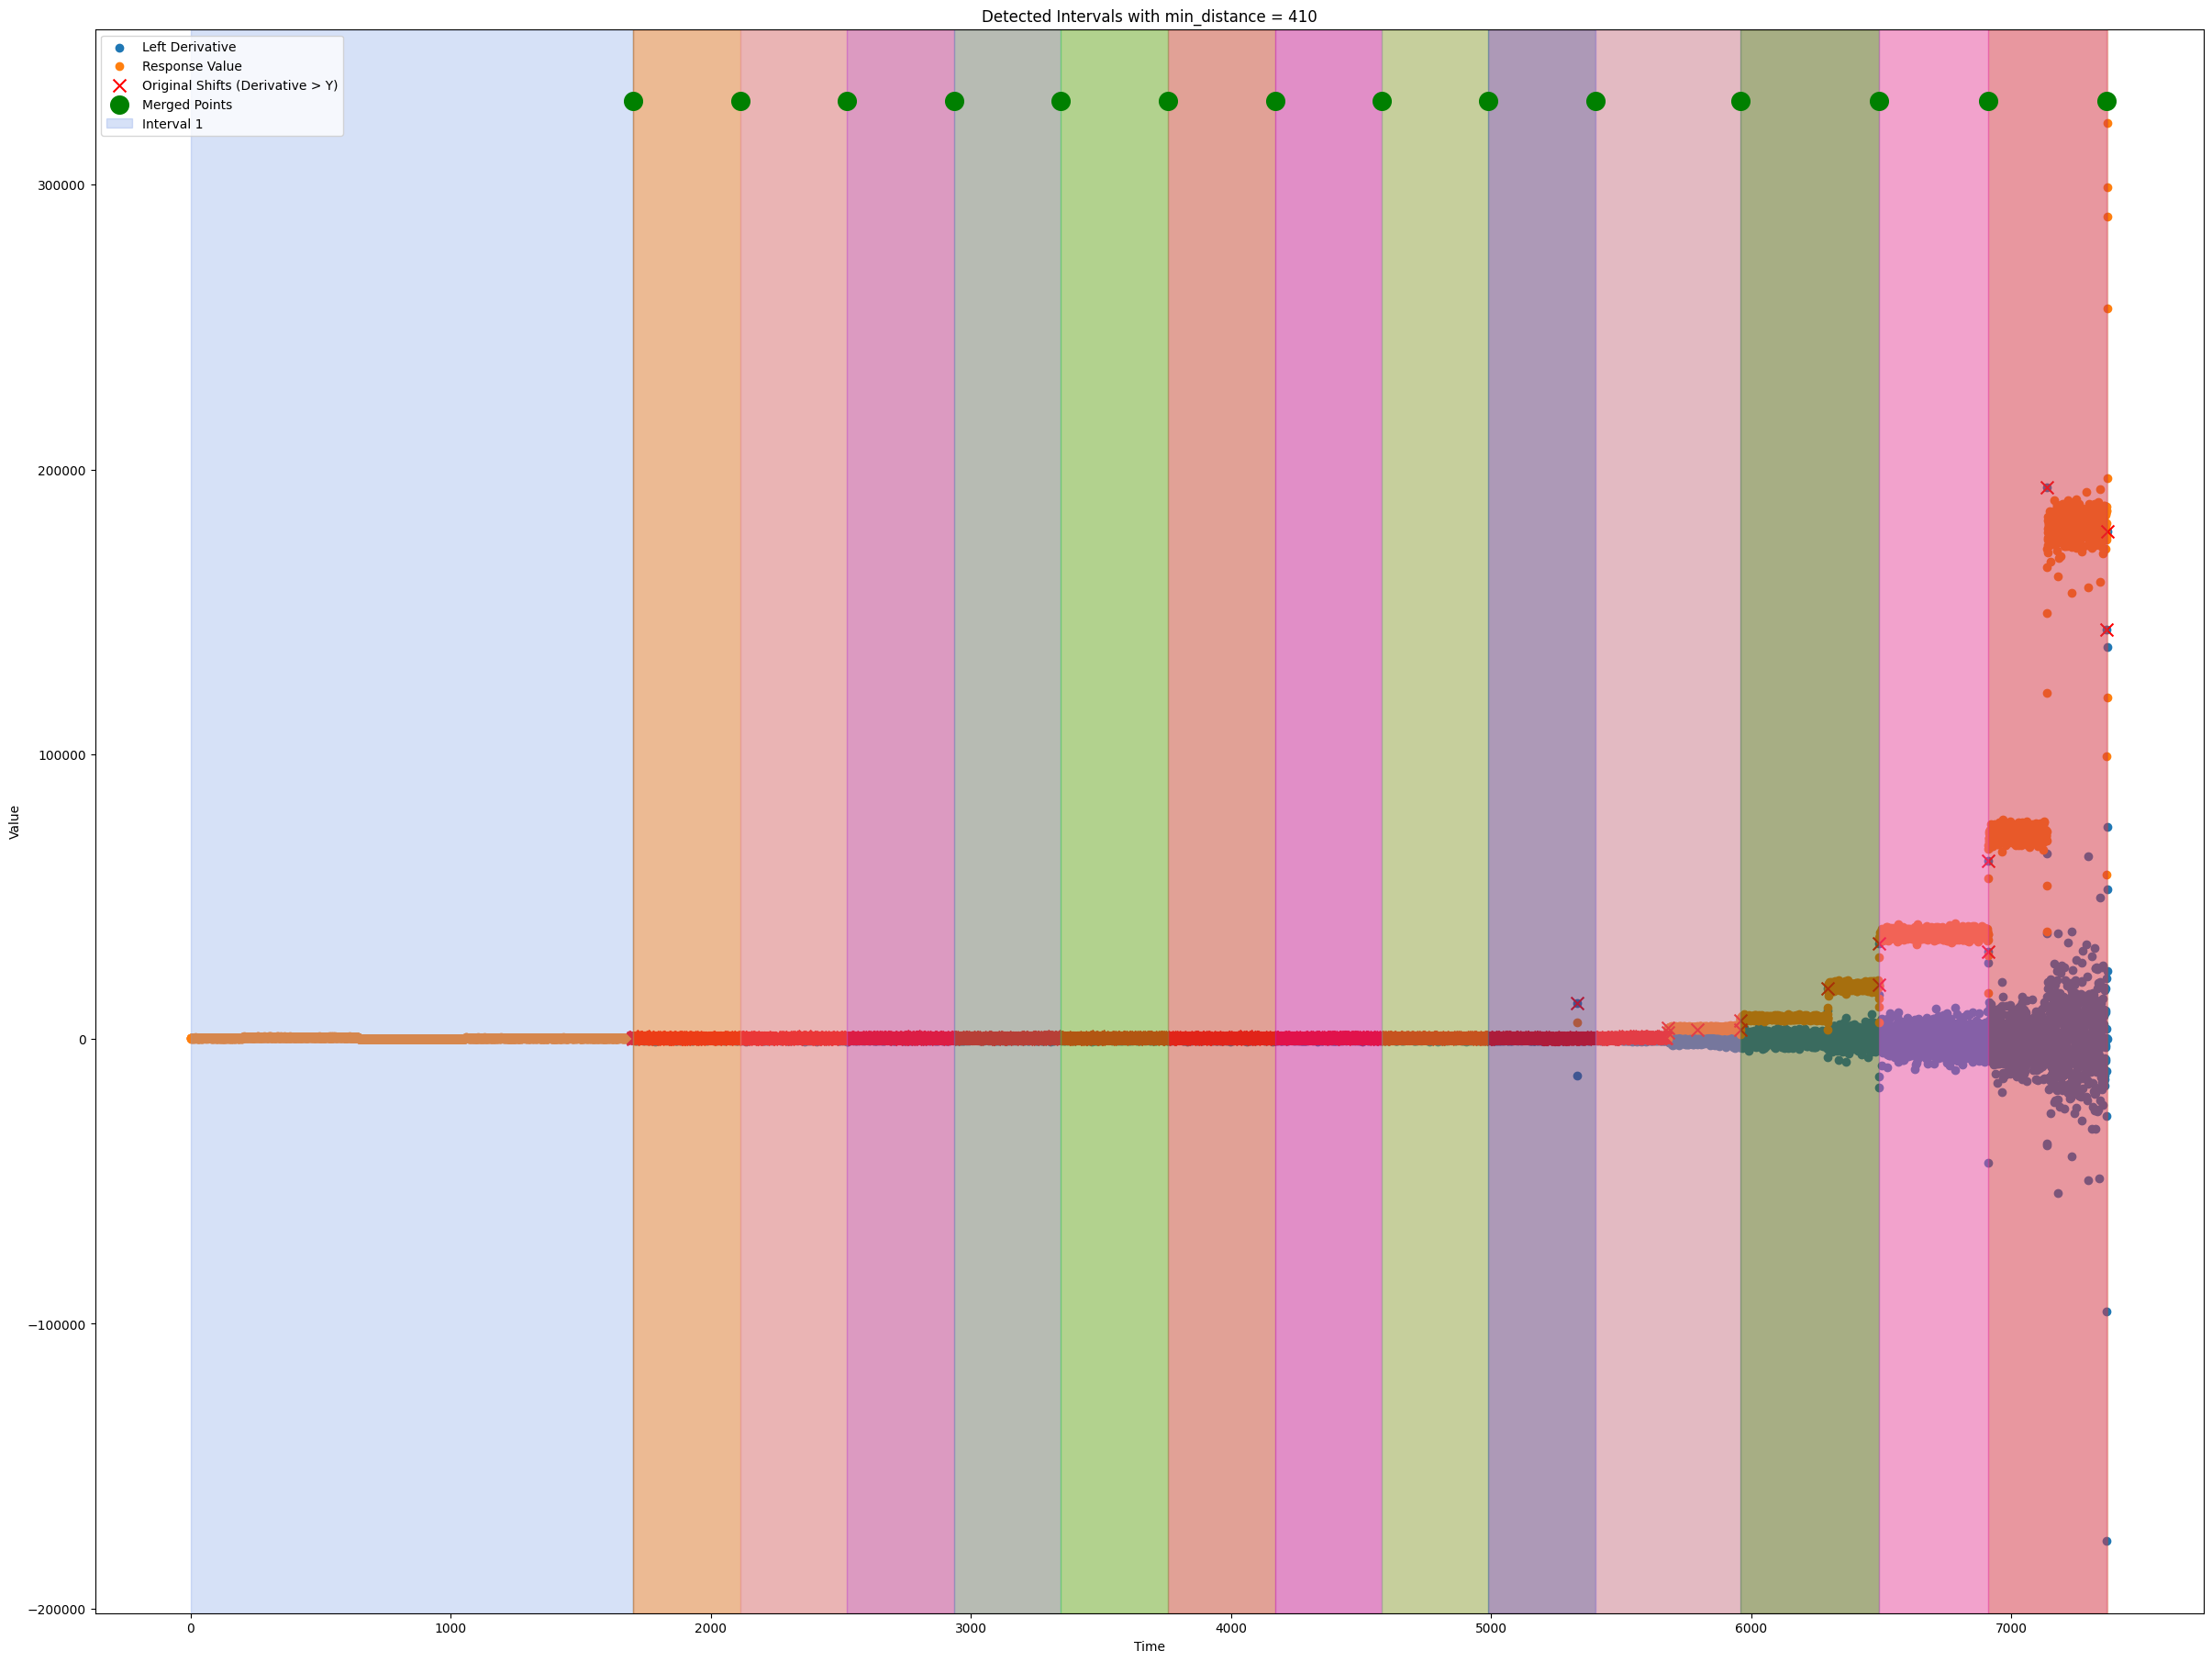


--- Testing with min_distance = 430 ---
Number of merged points for min_distance 430: 13
Detected intervals for min_distance 430:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2132.863),
 (np.float64(1699.982), np.float64(7370.625)),
 (2132.863, 2565.743),
 (2565.743, 2996.463),
 (2996.463, 3427.615),
 (3427.615, 3860.063),
 (3860.063, 4290.35),
 (4290.35, 4727.551),
 (4727.551, 5160.863),
 (5160.863, 5595.471),
 (5595.471, 6294.905),
 (6294.905, 6910.96),
 (6910.96, 7368.033)]

<Figure size 640x480 with 0 Axes>

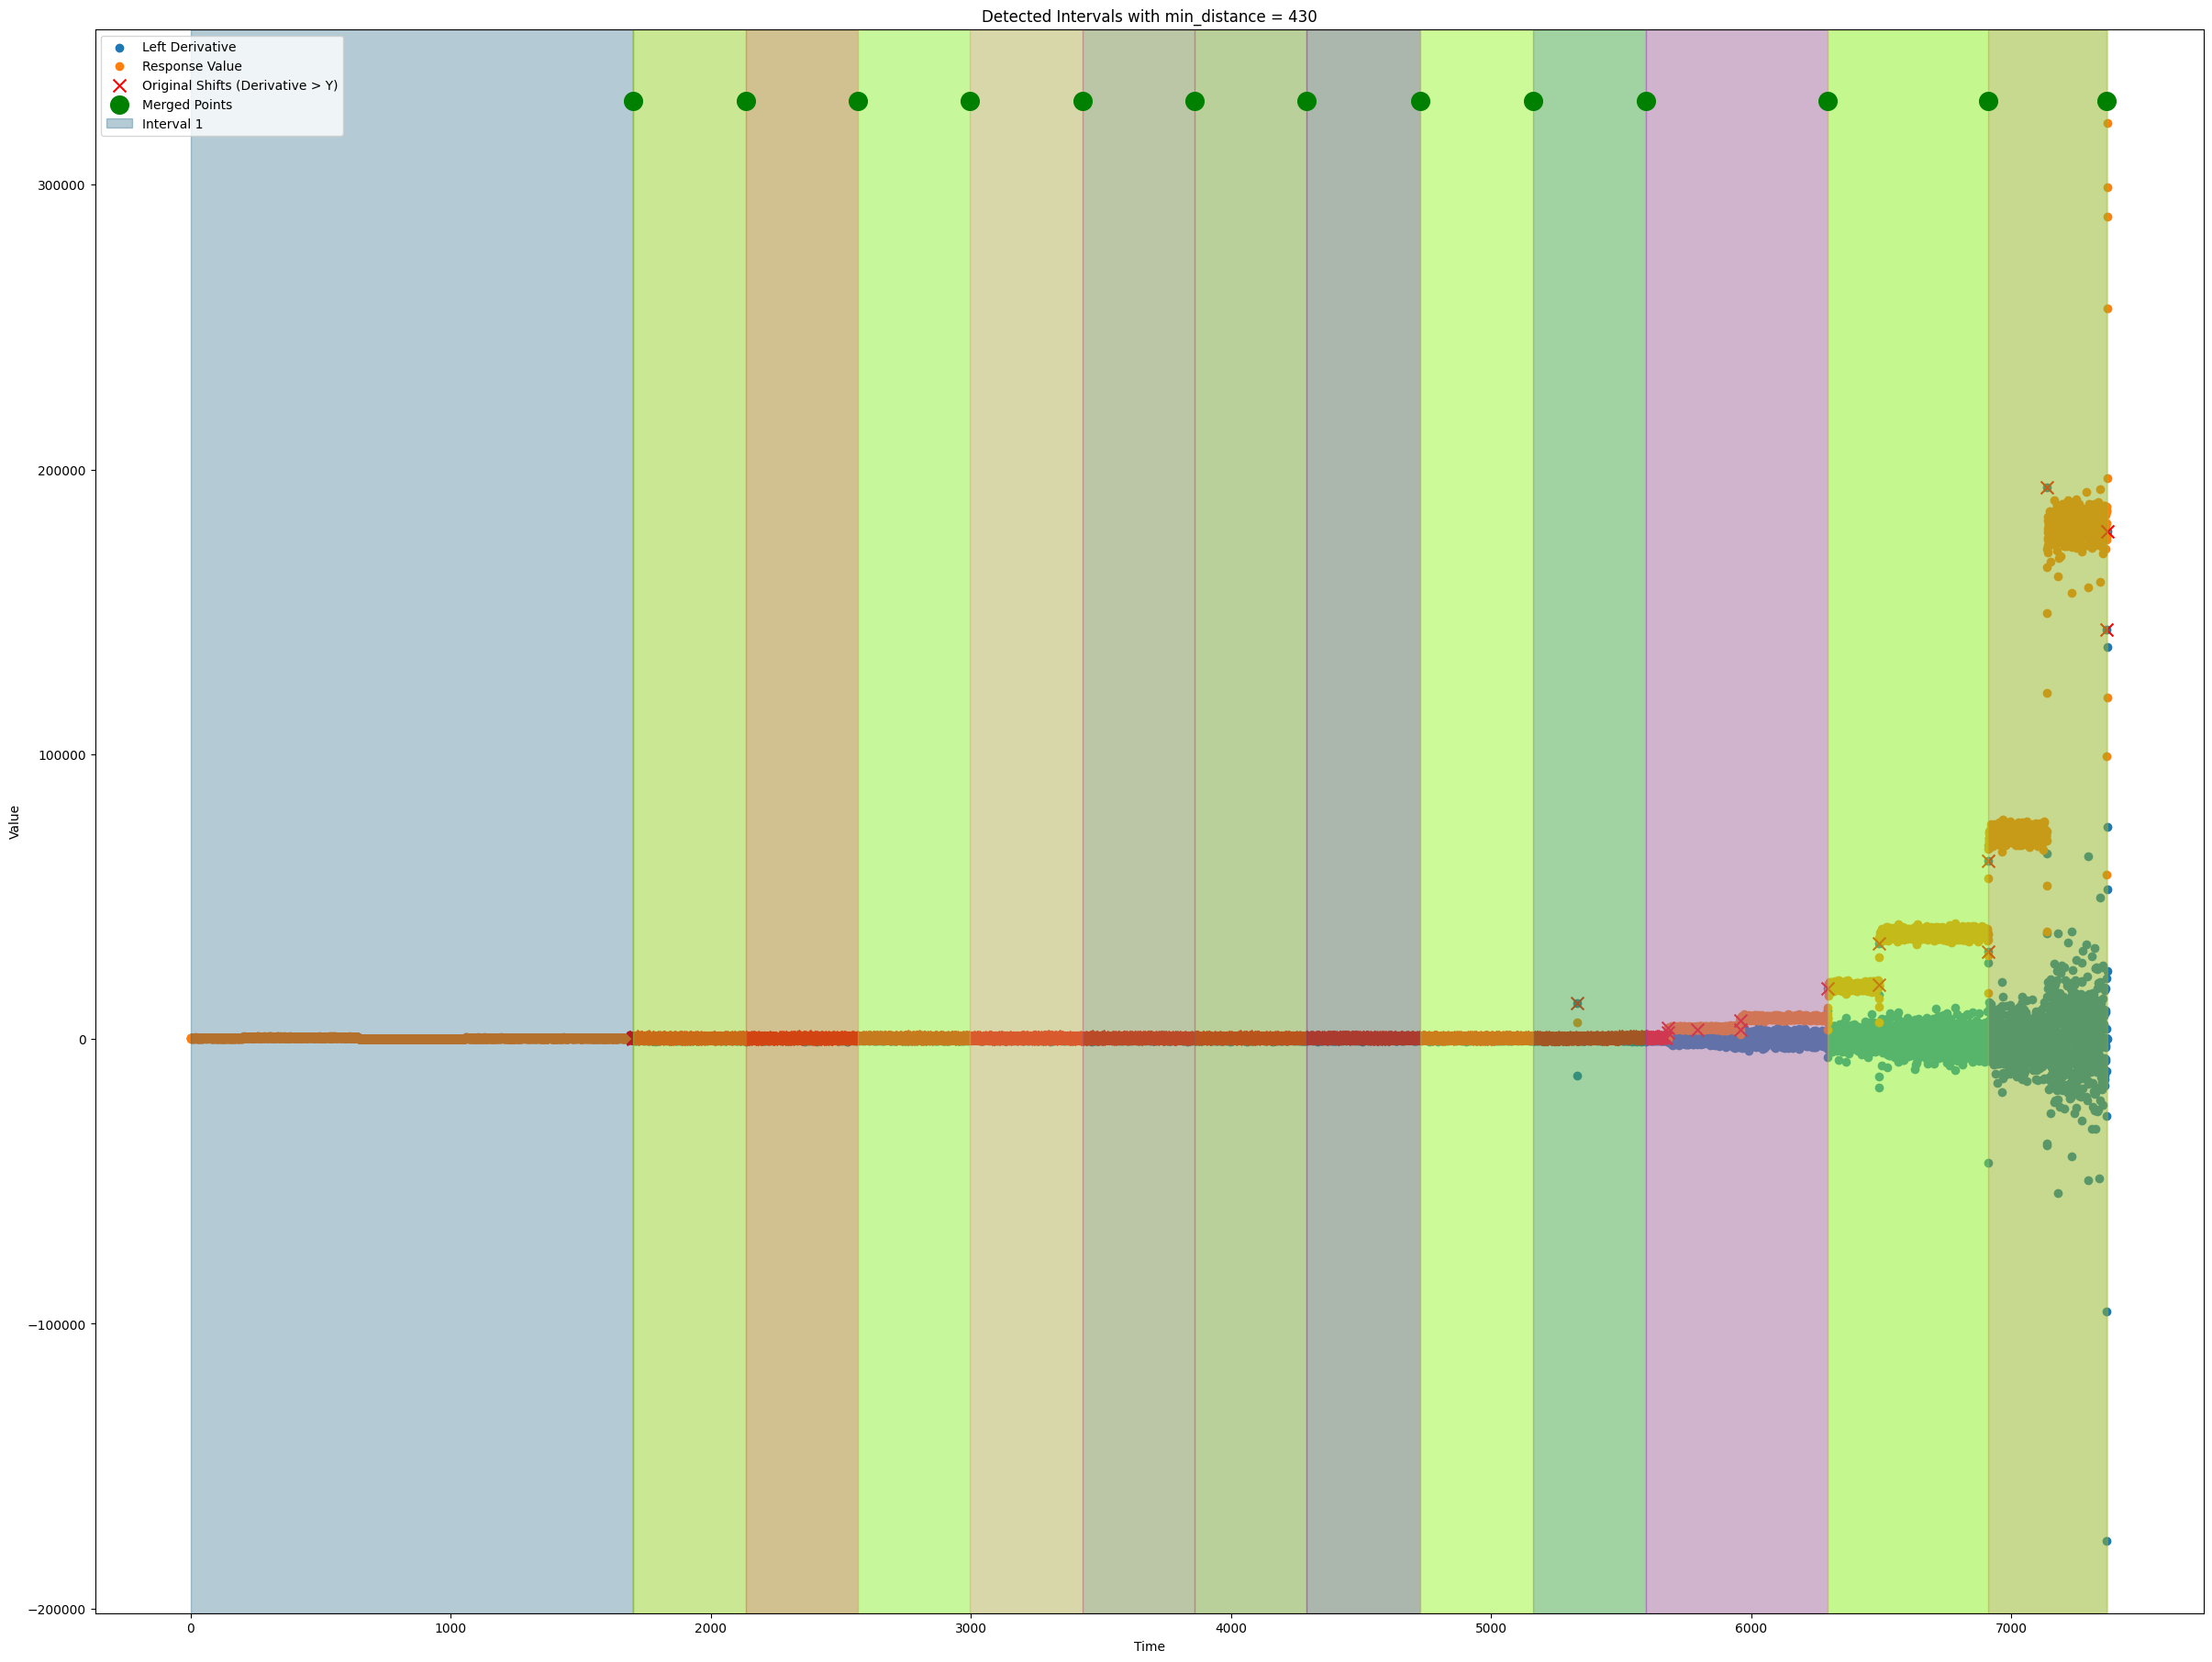


--- Testing with min_distance = 450 ---
Number of merged points for min_distance 450: 13
Detected intervals for min_distance 450:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2153.167),
 (np.float64(1699.982), np.float64(7370.625)),
 (2153.167, 2605.488),
 (2605.488, 3055.649),
 (3055.649, 3505.809),
 (3505.809, 3955.97),
 (3955.97, 4407.859),
 (4407.859, 4858.02),
 (4858.02, 5310.34),
 (5310.34, 5792.902),
 (5792.902, 6294.905),
 (6294.905, 6910.96),
 (6910.96, 7368.033)]

<Figure size 640x480 with 0 Axes>

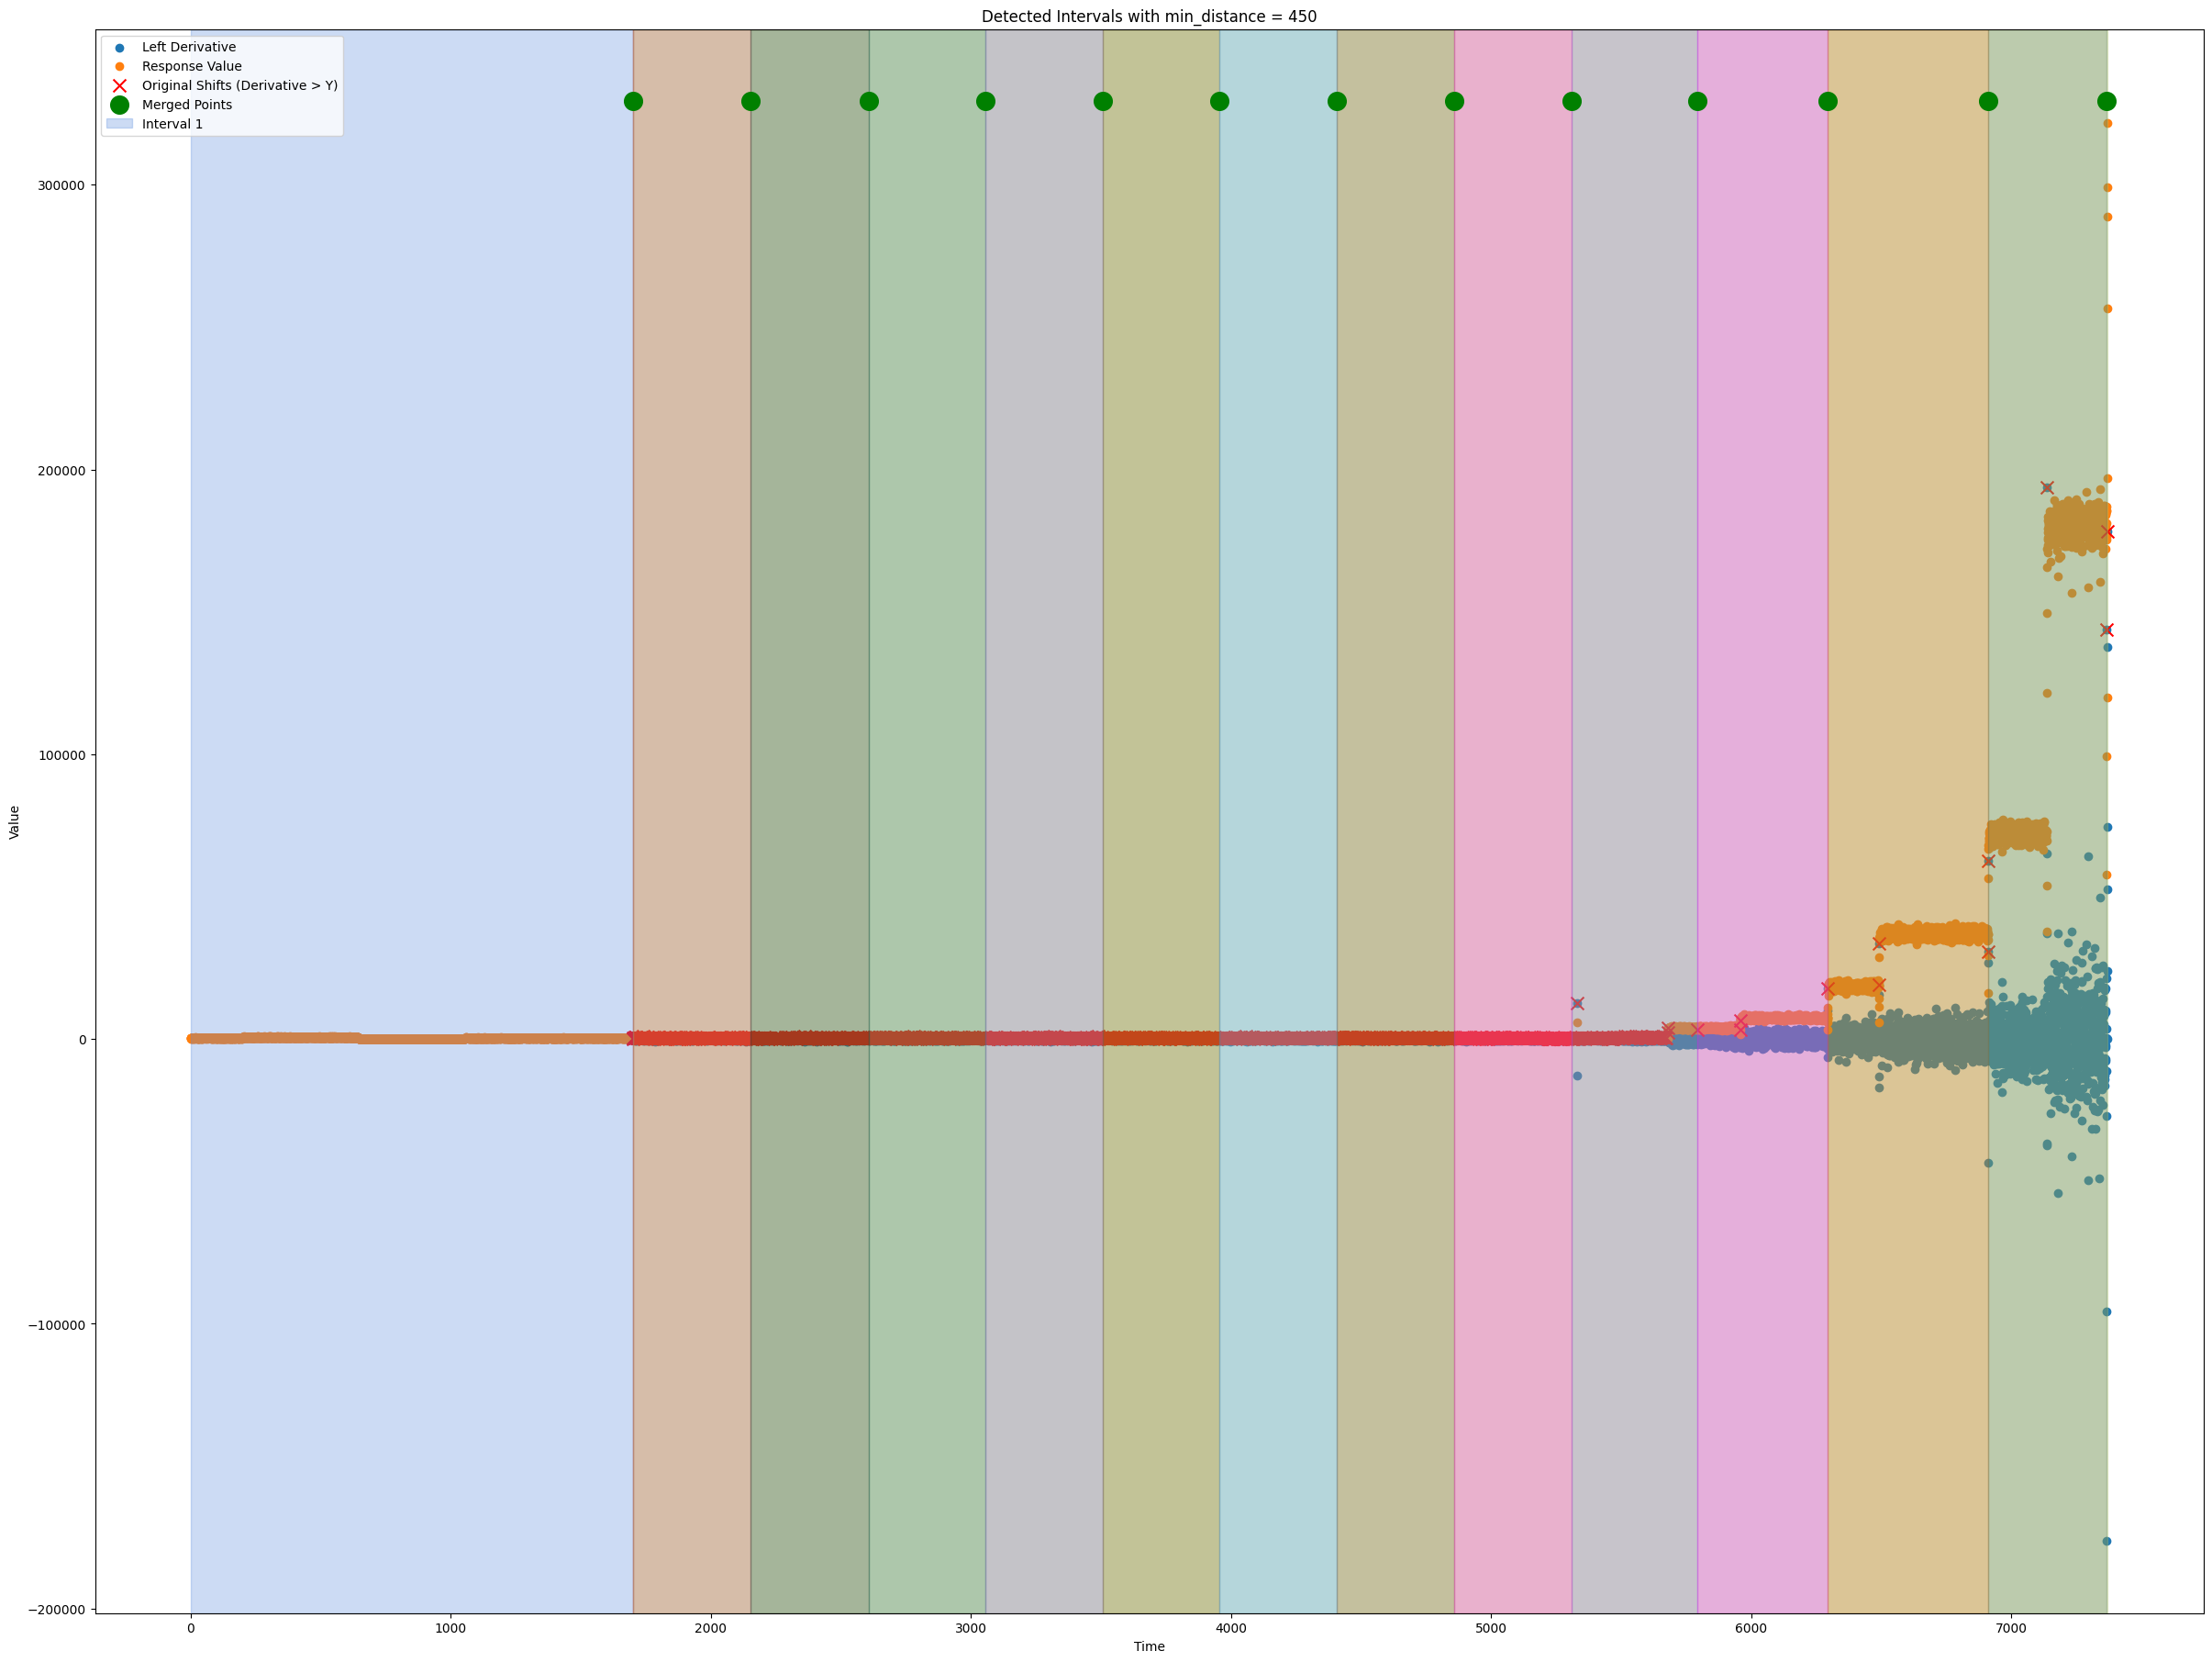


--- Testing with min_distance = 470 ---
Number of merged points for min_distance 470: 12
Detected intervals for min_distance 470:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2171.312),
 (np.float64(1699.982), np.float64(7370.625)),
 (2171.312, 2642.641),
 (2642.641, 3113.971),
 (3113.971, 3584.868),
 (3584.868, 4057.062),
 (4057.062, 4527.095),
 (4527.095, 4998.857),
 (4998.857, 5468.89),
 (5468.89, 5957.068),
 (5957.068, 6491.904),
 (6491.904, 7136.904)]

<Figure size 640x480 with 0 Axes>

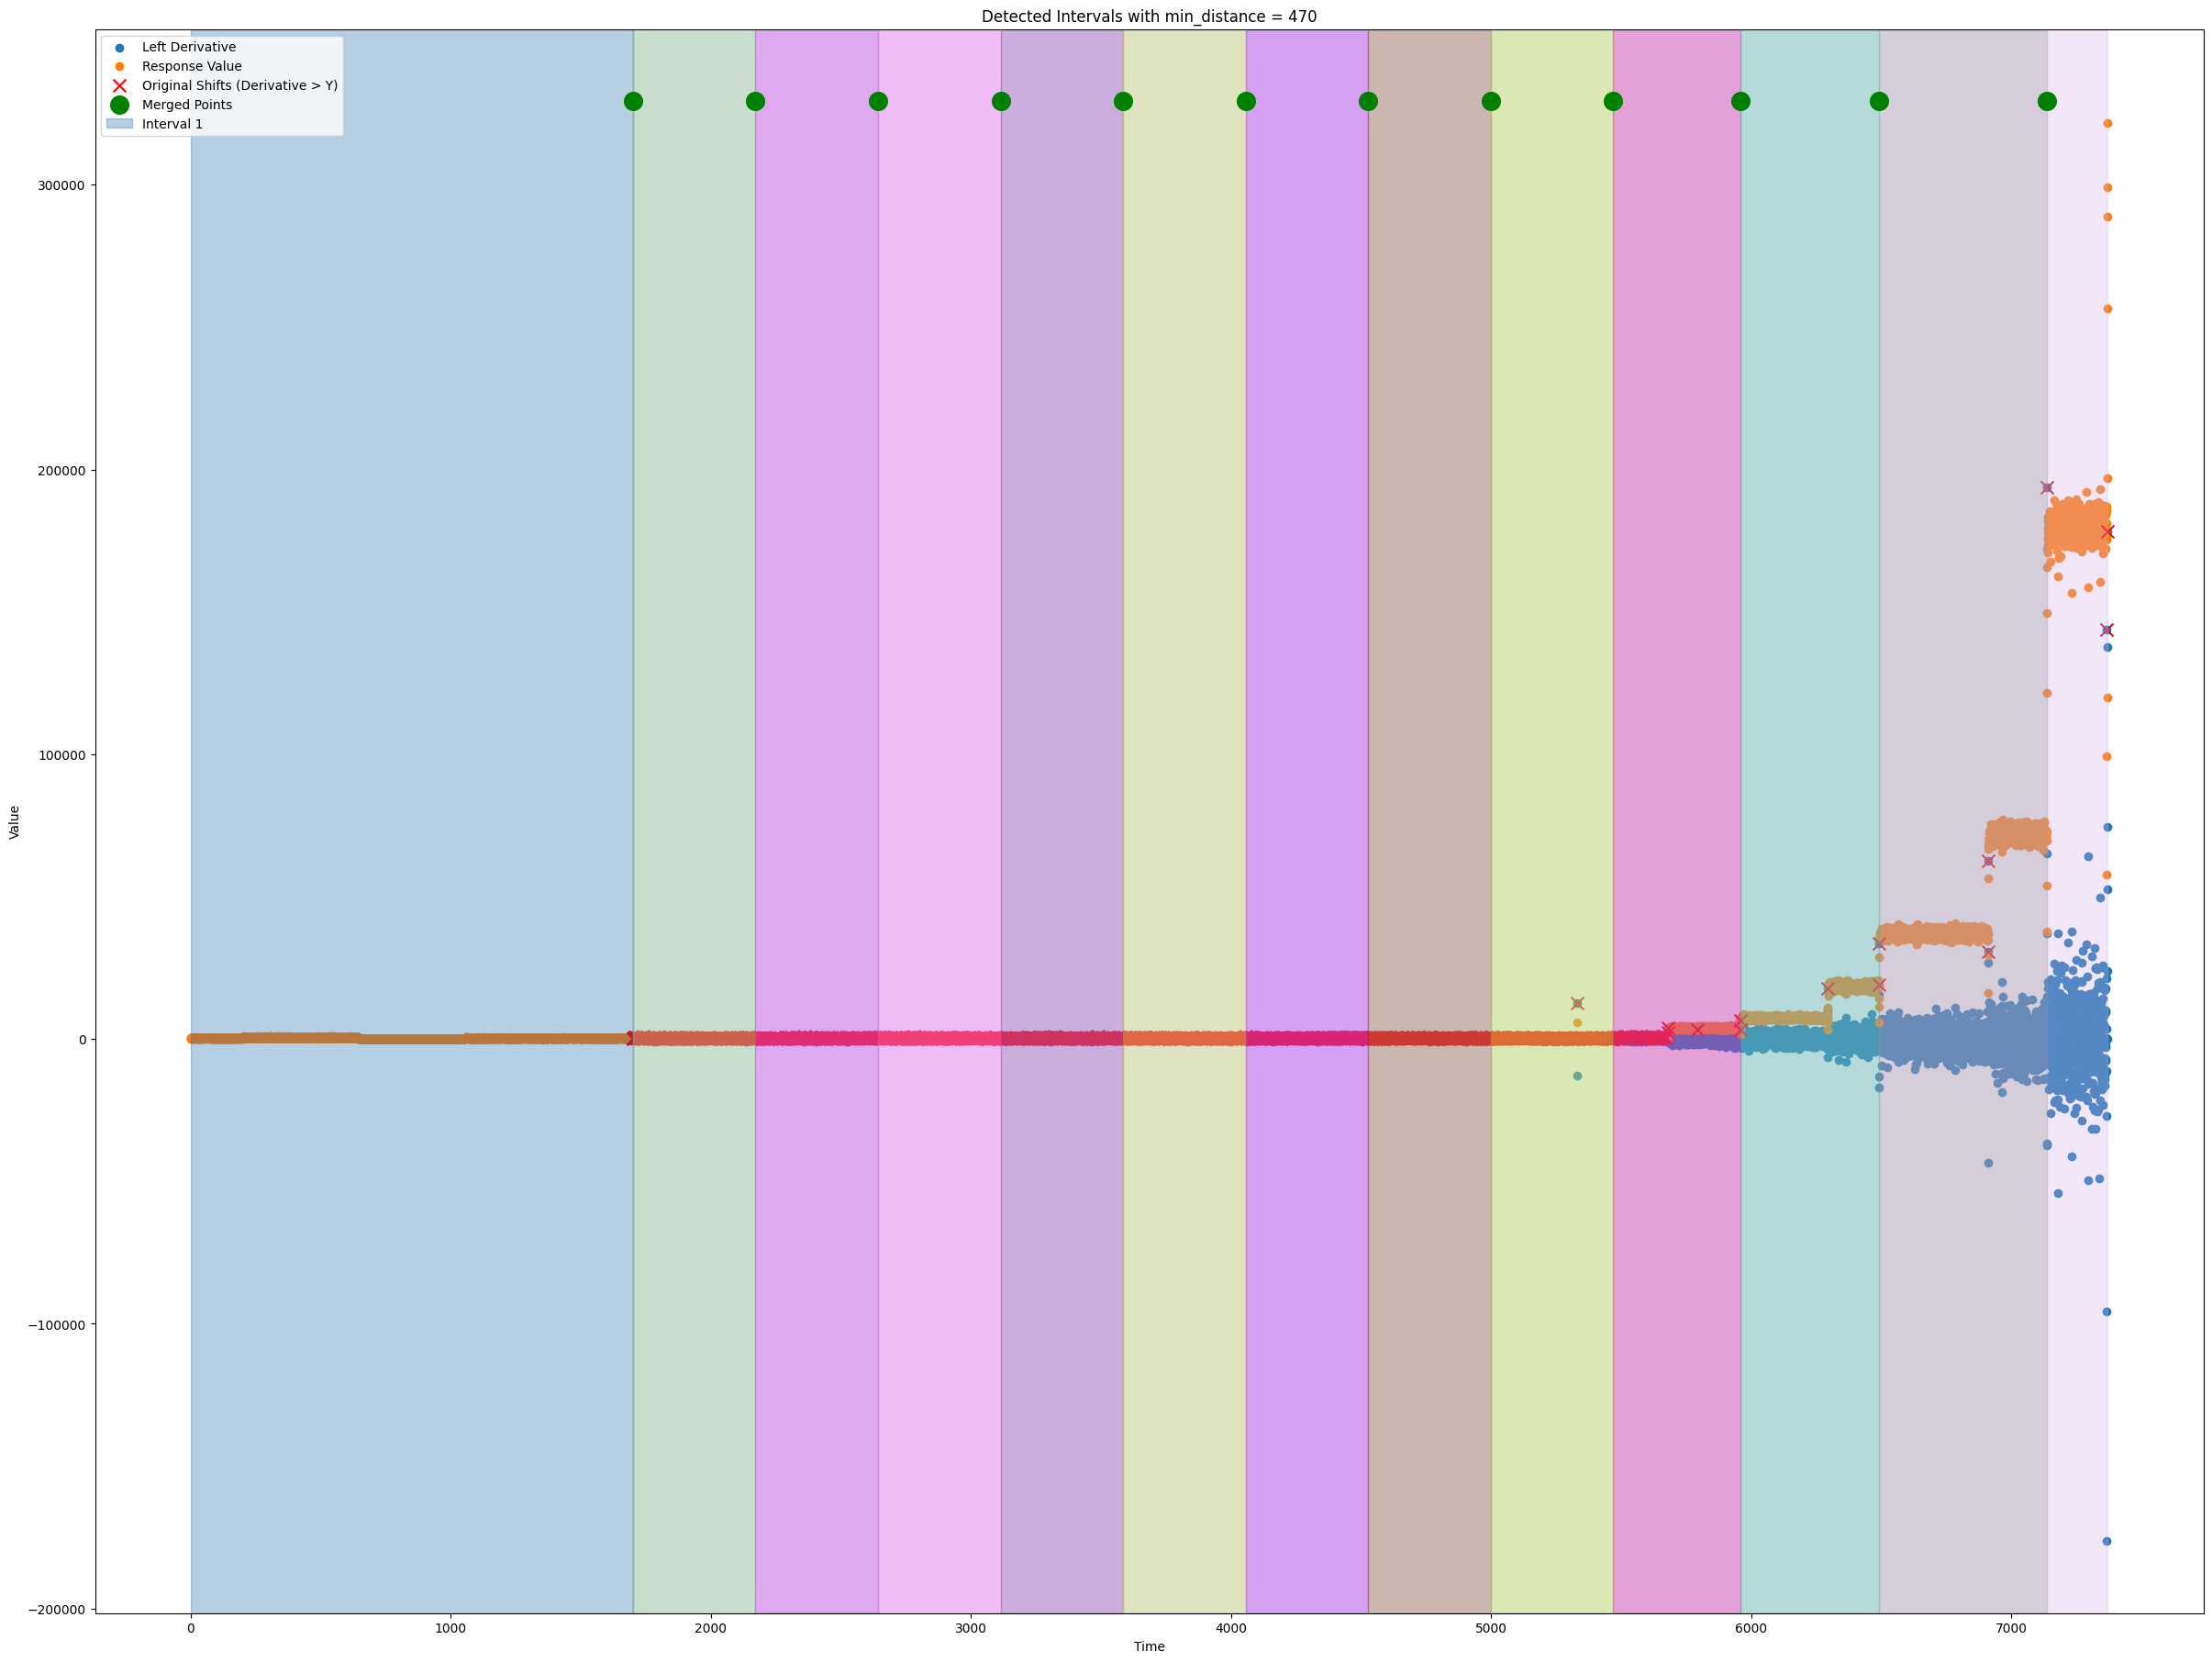


--- Testing with min_distance = 490 ---
Number of merged points for min_distance 490: 11
Detected intervals for min_distance 490:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2191.185),
 (np.float64(1699.982), np.float64(7370.625)),
 (2191.185, 2681.955),
 (2681.955, 3172.293),
 (3172.293, 3663.927),
 (3663.927, 4155.561),
 (4155.561, 4646.332),
 (4646.332, 5141.422),
 (5141.422, 5633.056),
 (5633.056, 6294.905),
 (6294.905, 6910.96)]

<Figure size 640x480 with 0 Axes>

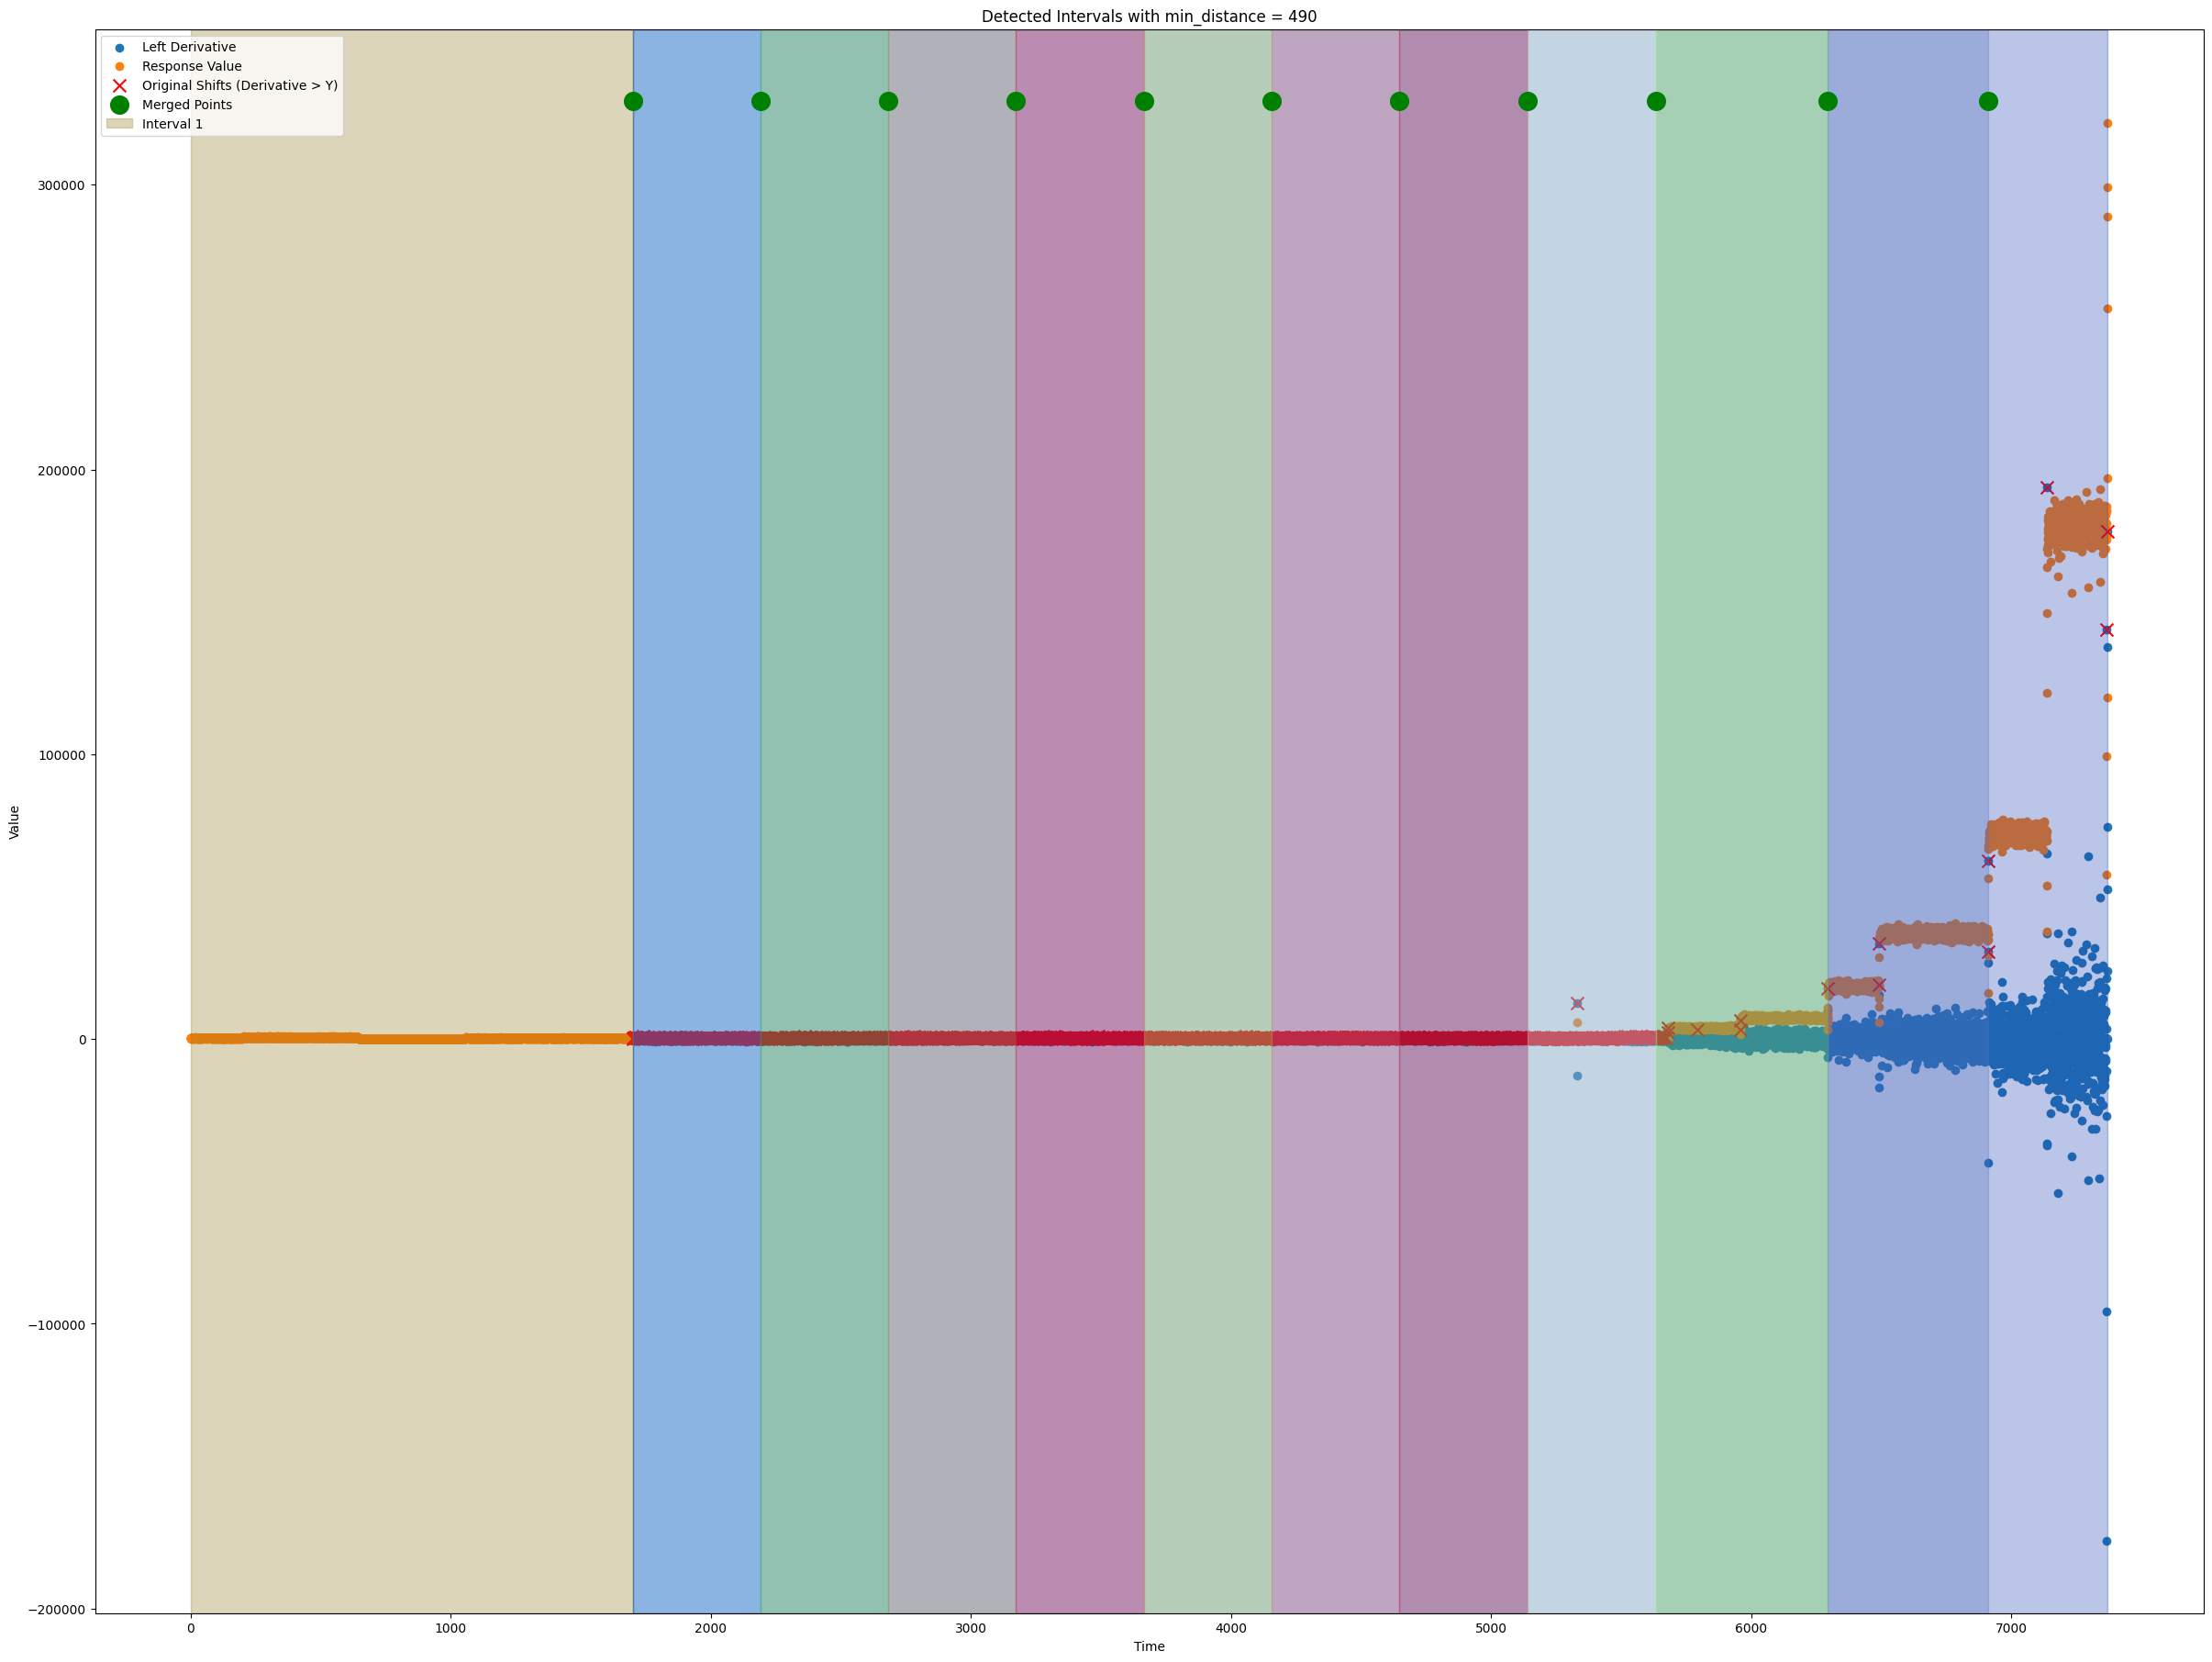


--- Testing with min_distance = 510 ---
Number of merged points for min_distance 510: 11
Detected intervals for min_distance 510:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2212.353),
 (np.float64(1699.982), np.float64(7370.625)),
 (2212.353, 2724.292),
 (2724.292, 3235.367),
 (3235.367, 3745.578),
 (3745.578, 4257.085),
 (4257.085, 4771.184),
 (4771.184, 5282.691),
 (5282.691, 5792.902),
 (5792.902, 6491.904),
 (6491.904, 7136.904)]

<Figure size 640x480 with 0 Axes>

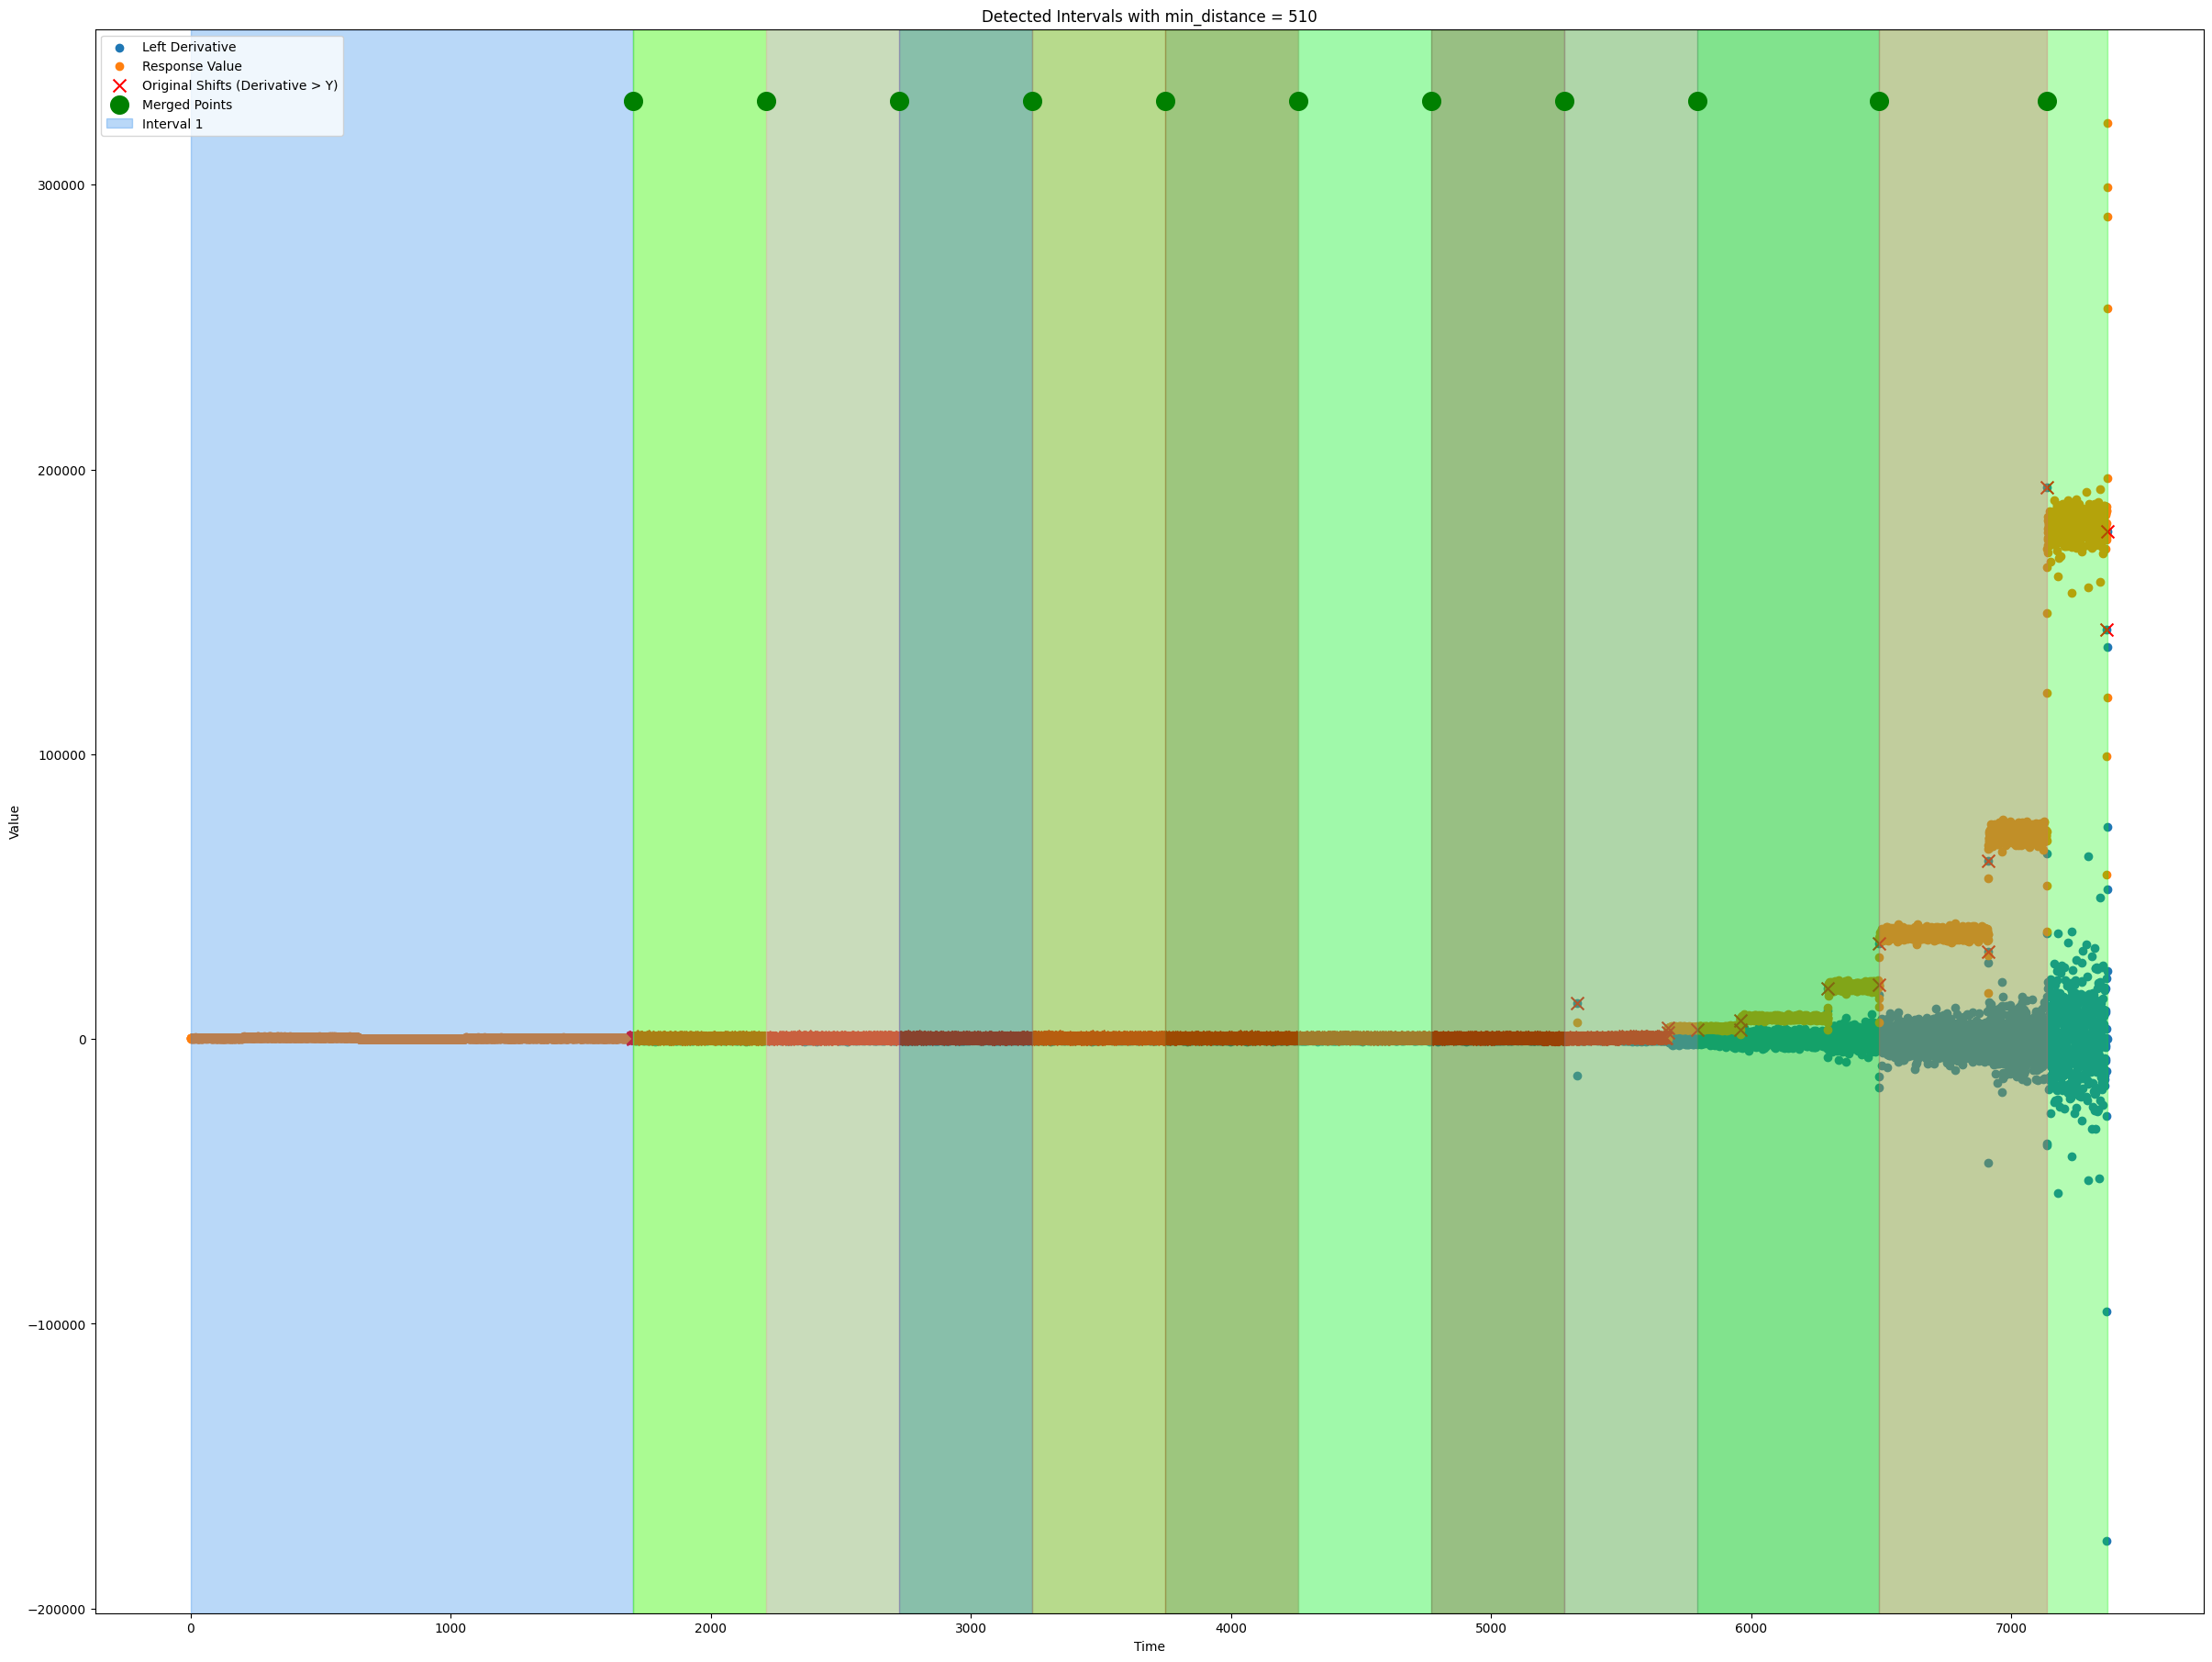


--- Testing with min_distance = 530 ---
Number of merged points for min_distance 530: 11
Detected intervals for min_distance 530:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2231.362),
 (np.float64(1699.982), np.float64(7370.625)),
 (2231.362, 2761.446),
 (2761.446, 3291.529),
 (3291.529, 3822.045),
 (3822.045, 4352.561),
 (4352.561, 4883.076),
 (4883.076, 5418.344),
 (5418.344, 5957.068),
 (5957.068, 6491.904),
 (6491.904, 7136.904)]

<Figure size 640x480 with 0 Axes>

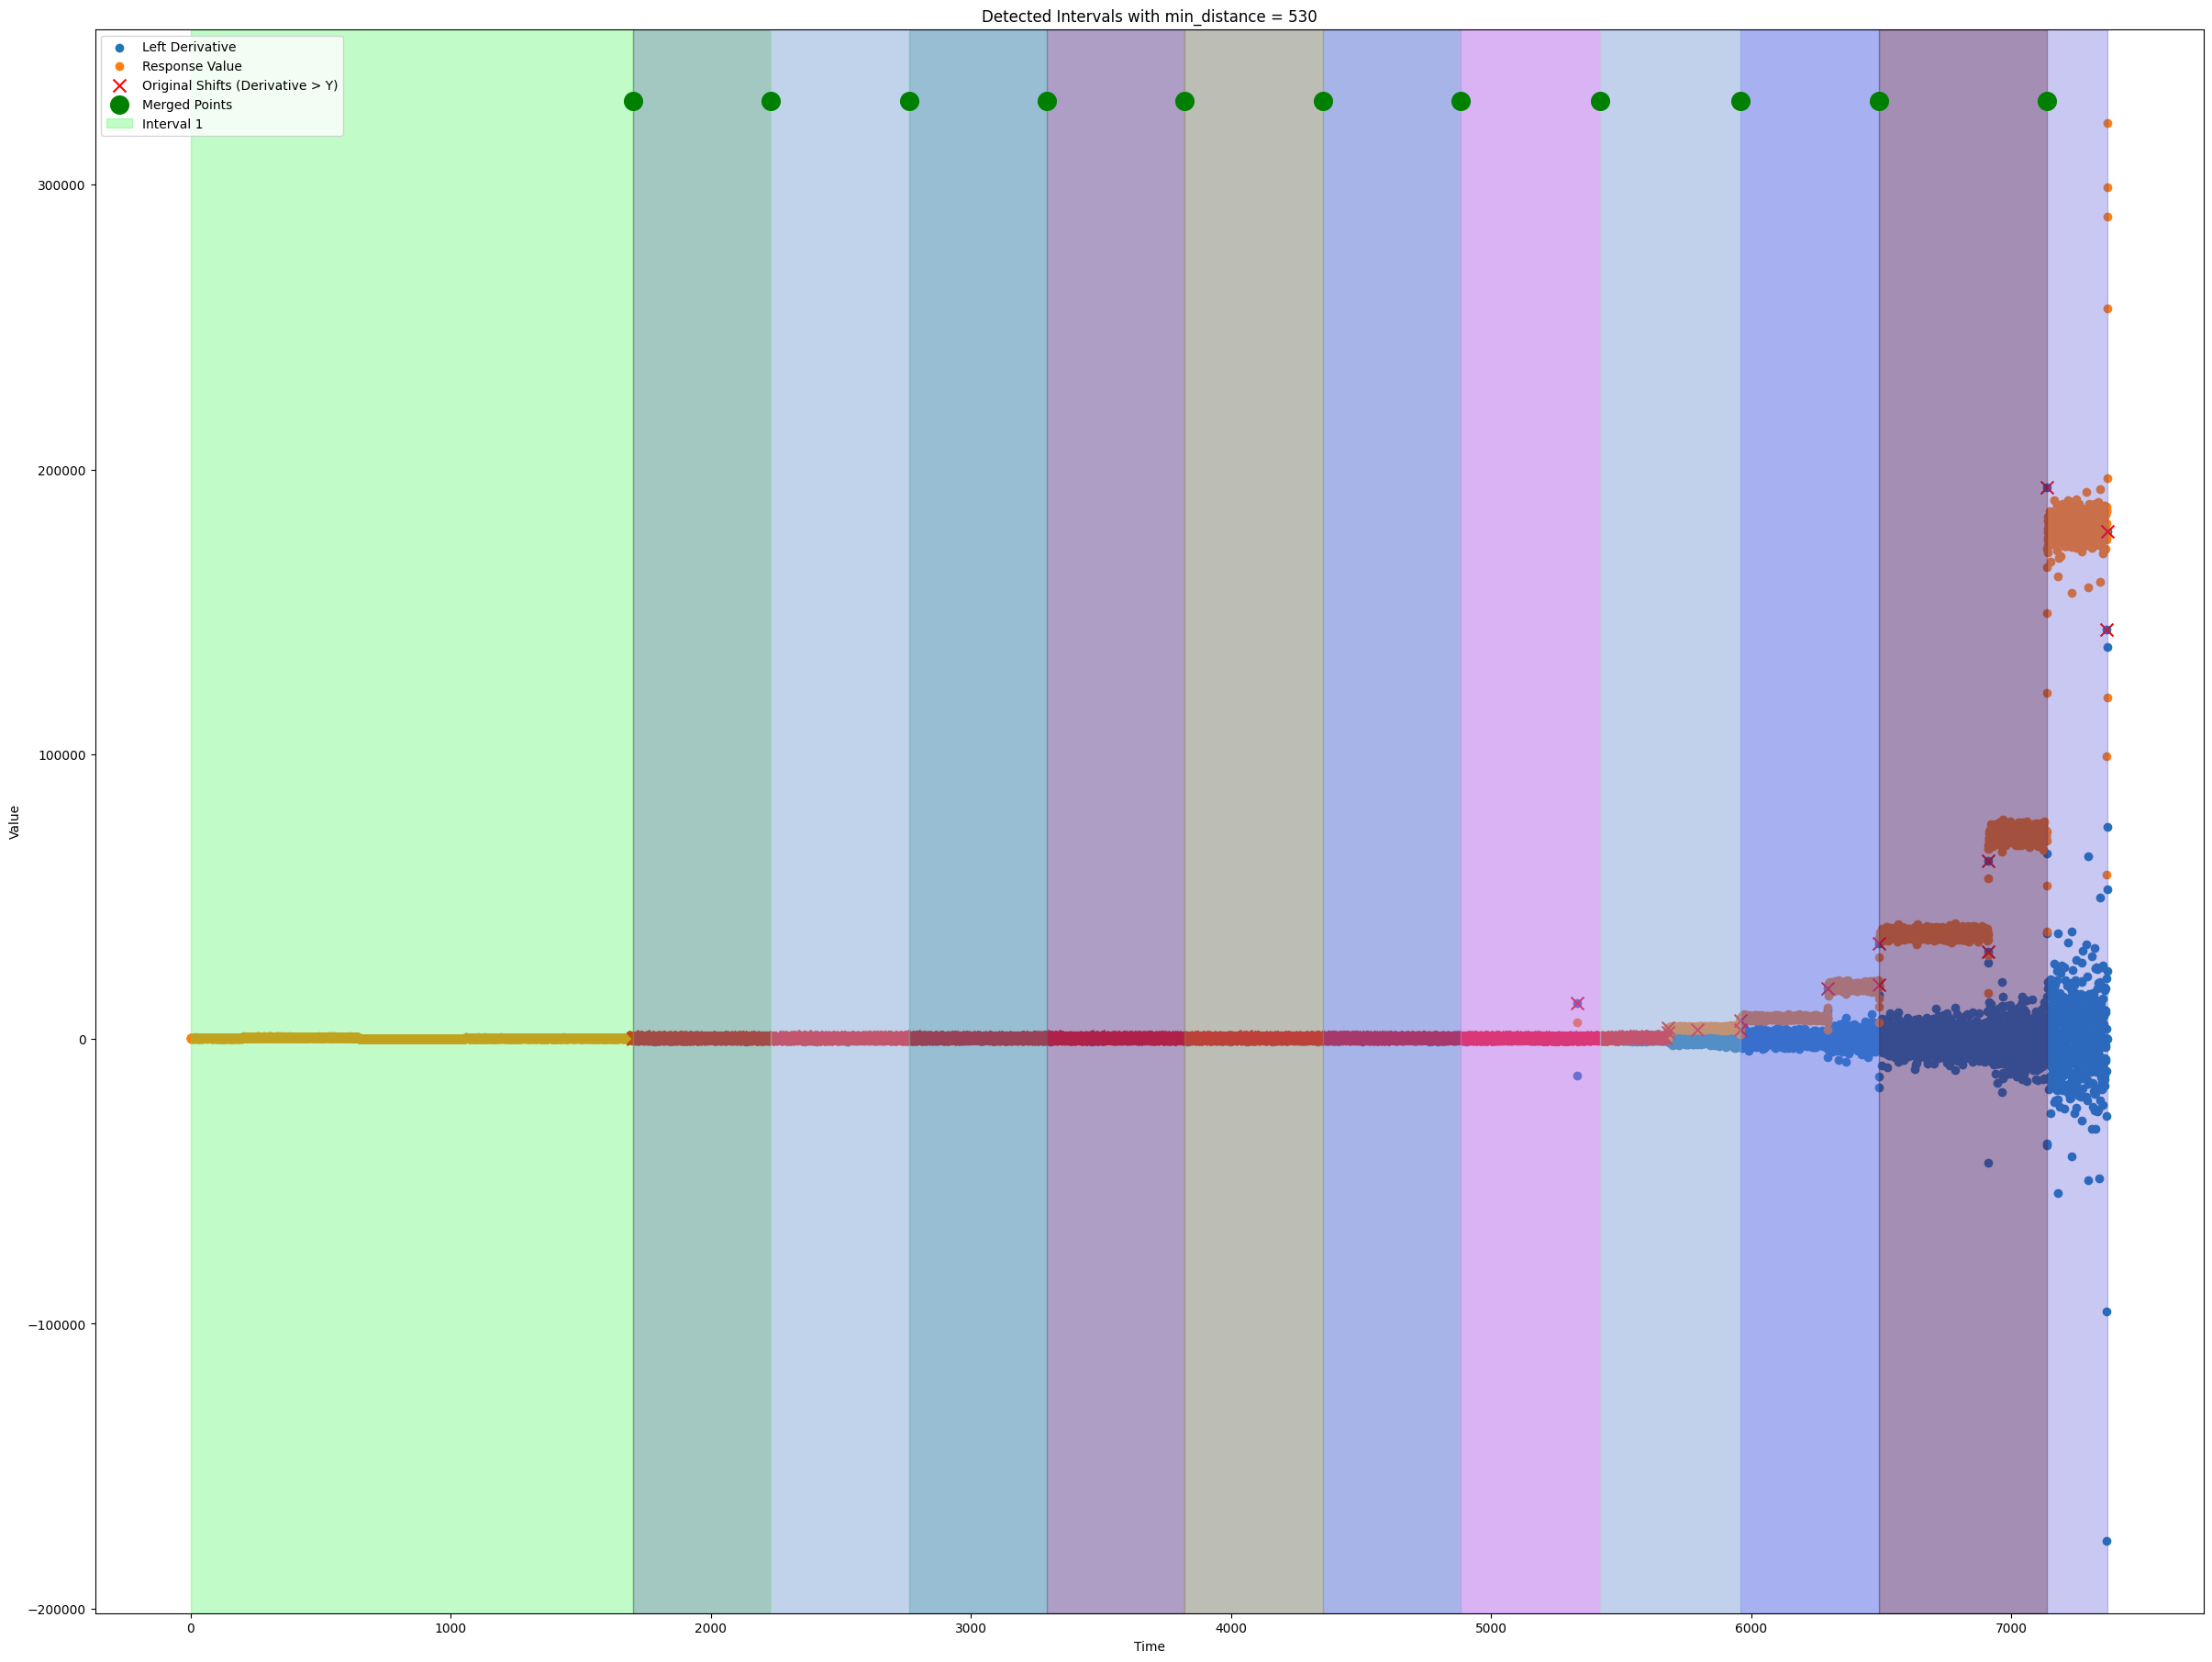


--- Testing with min_distance = 550 ---
Number of merged points for min_distance 550: 10
Detected intervals for min_distance 550:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2254.259),
 (np.float64(1699.982), np.float64(7370.625)),
 (2254.259, 2806.808),
 (2806.808, 3357.196),
 (3357.196, 3912.768),
 (3912.768, 4464.885),
 (4464.885, 5018.297),
 (5018.297, 5571.71),
 (5571.71, 6294.905),
 (6294.905, 6910.96)]

<Figure size 640x480 with 0 Axes>

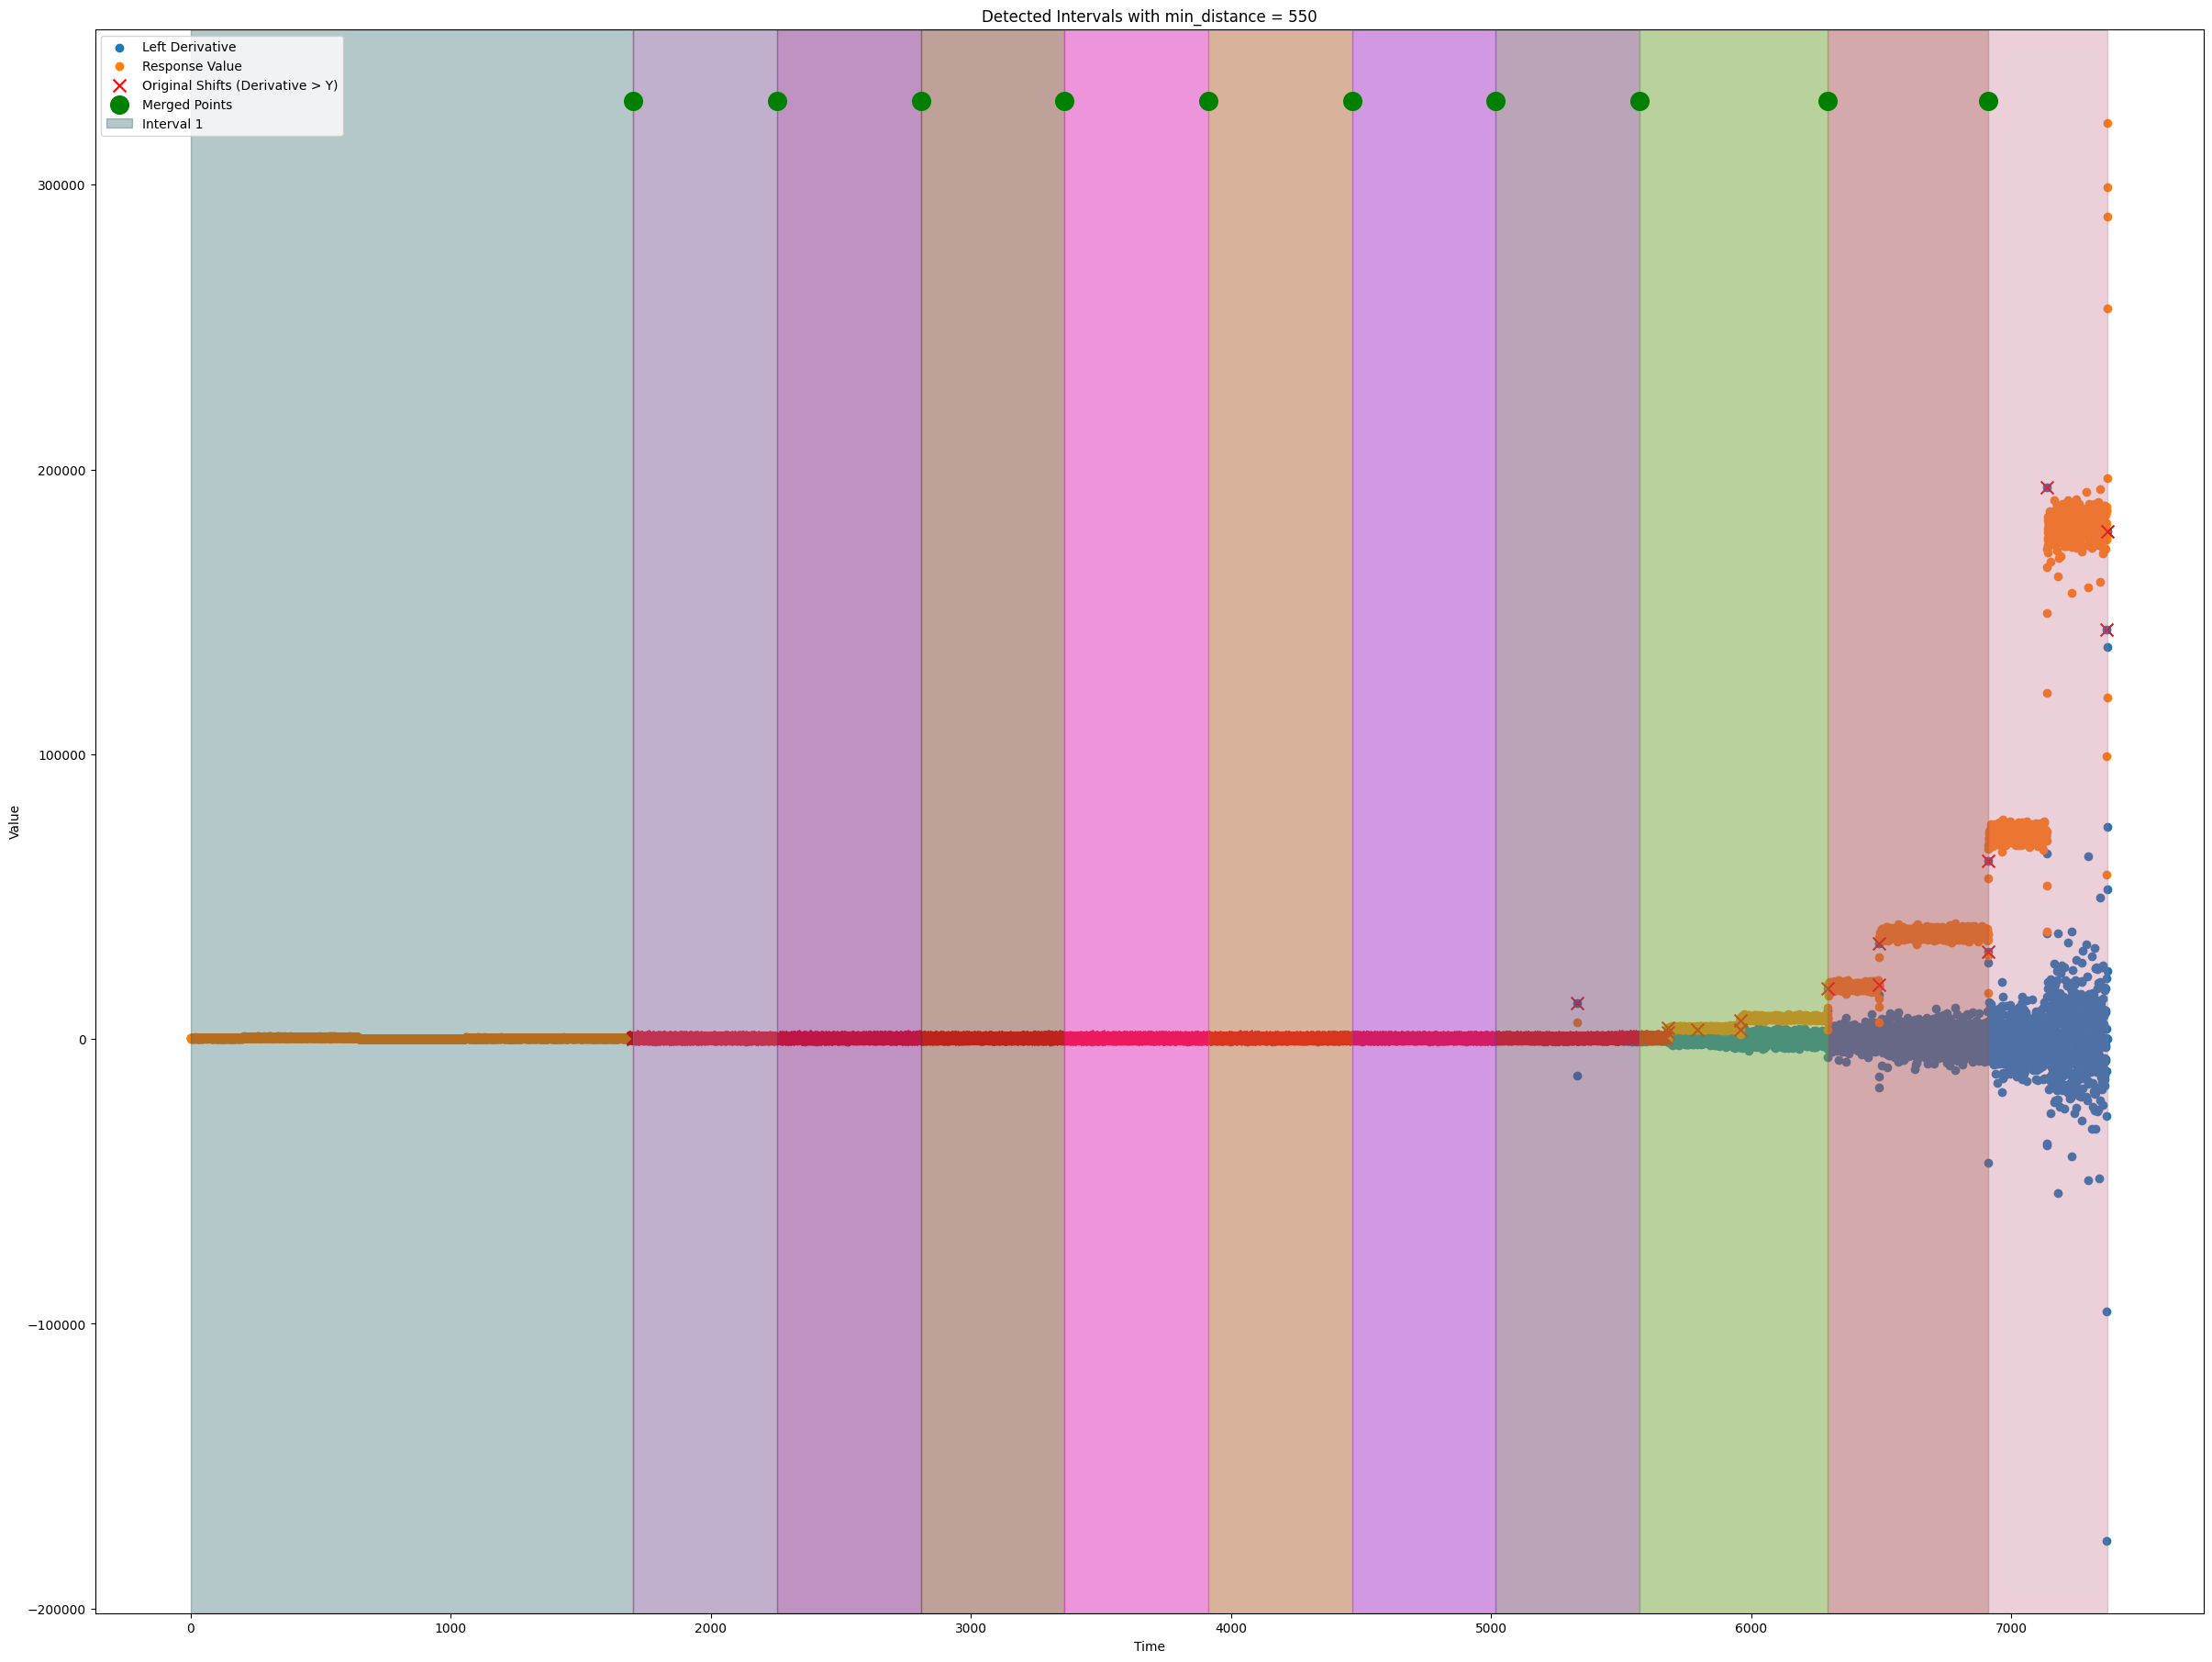


--- Testing with min_distance = 570 ---
Number of merged points for min_distance 570: 10
Detected intervals for min_distance 570:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2270.244),
 (np.float64(1699.982), np.float64(7370.625)),
 (2270.244, 2842.665),
 (2842.665, 3413.358),
 (3413.358, 3984.483),
 (3984.483, 4558.2),
 (4558.2, 5128.894),
 (5128.894, 5792.902),
 (5792.902, 6491.904),
 (6491.904, 7136.904)]

<Figure size 640x480 with 0 Axes>

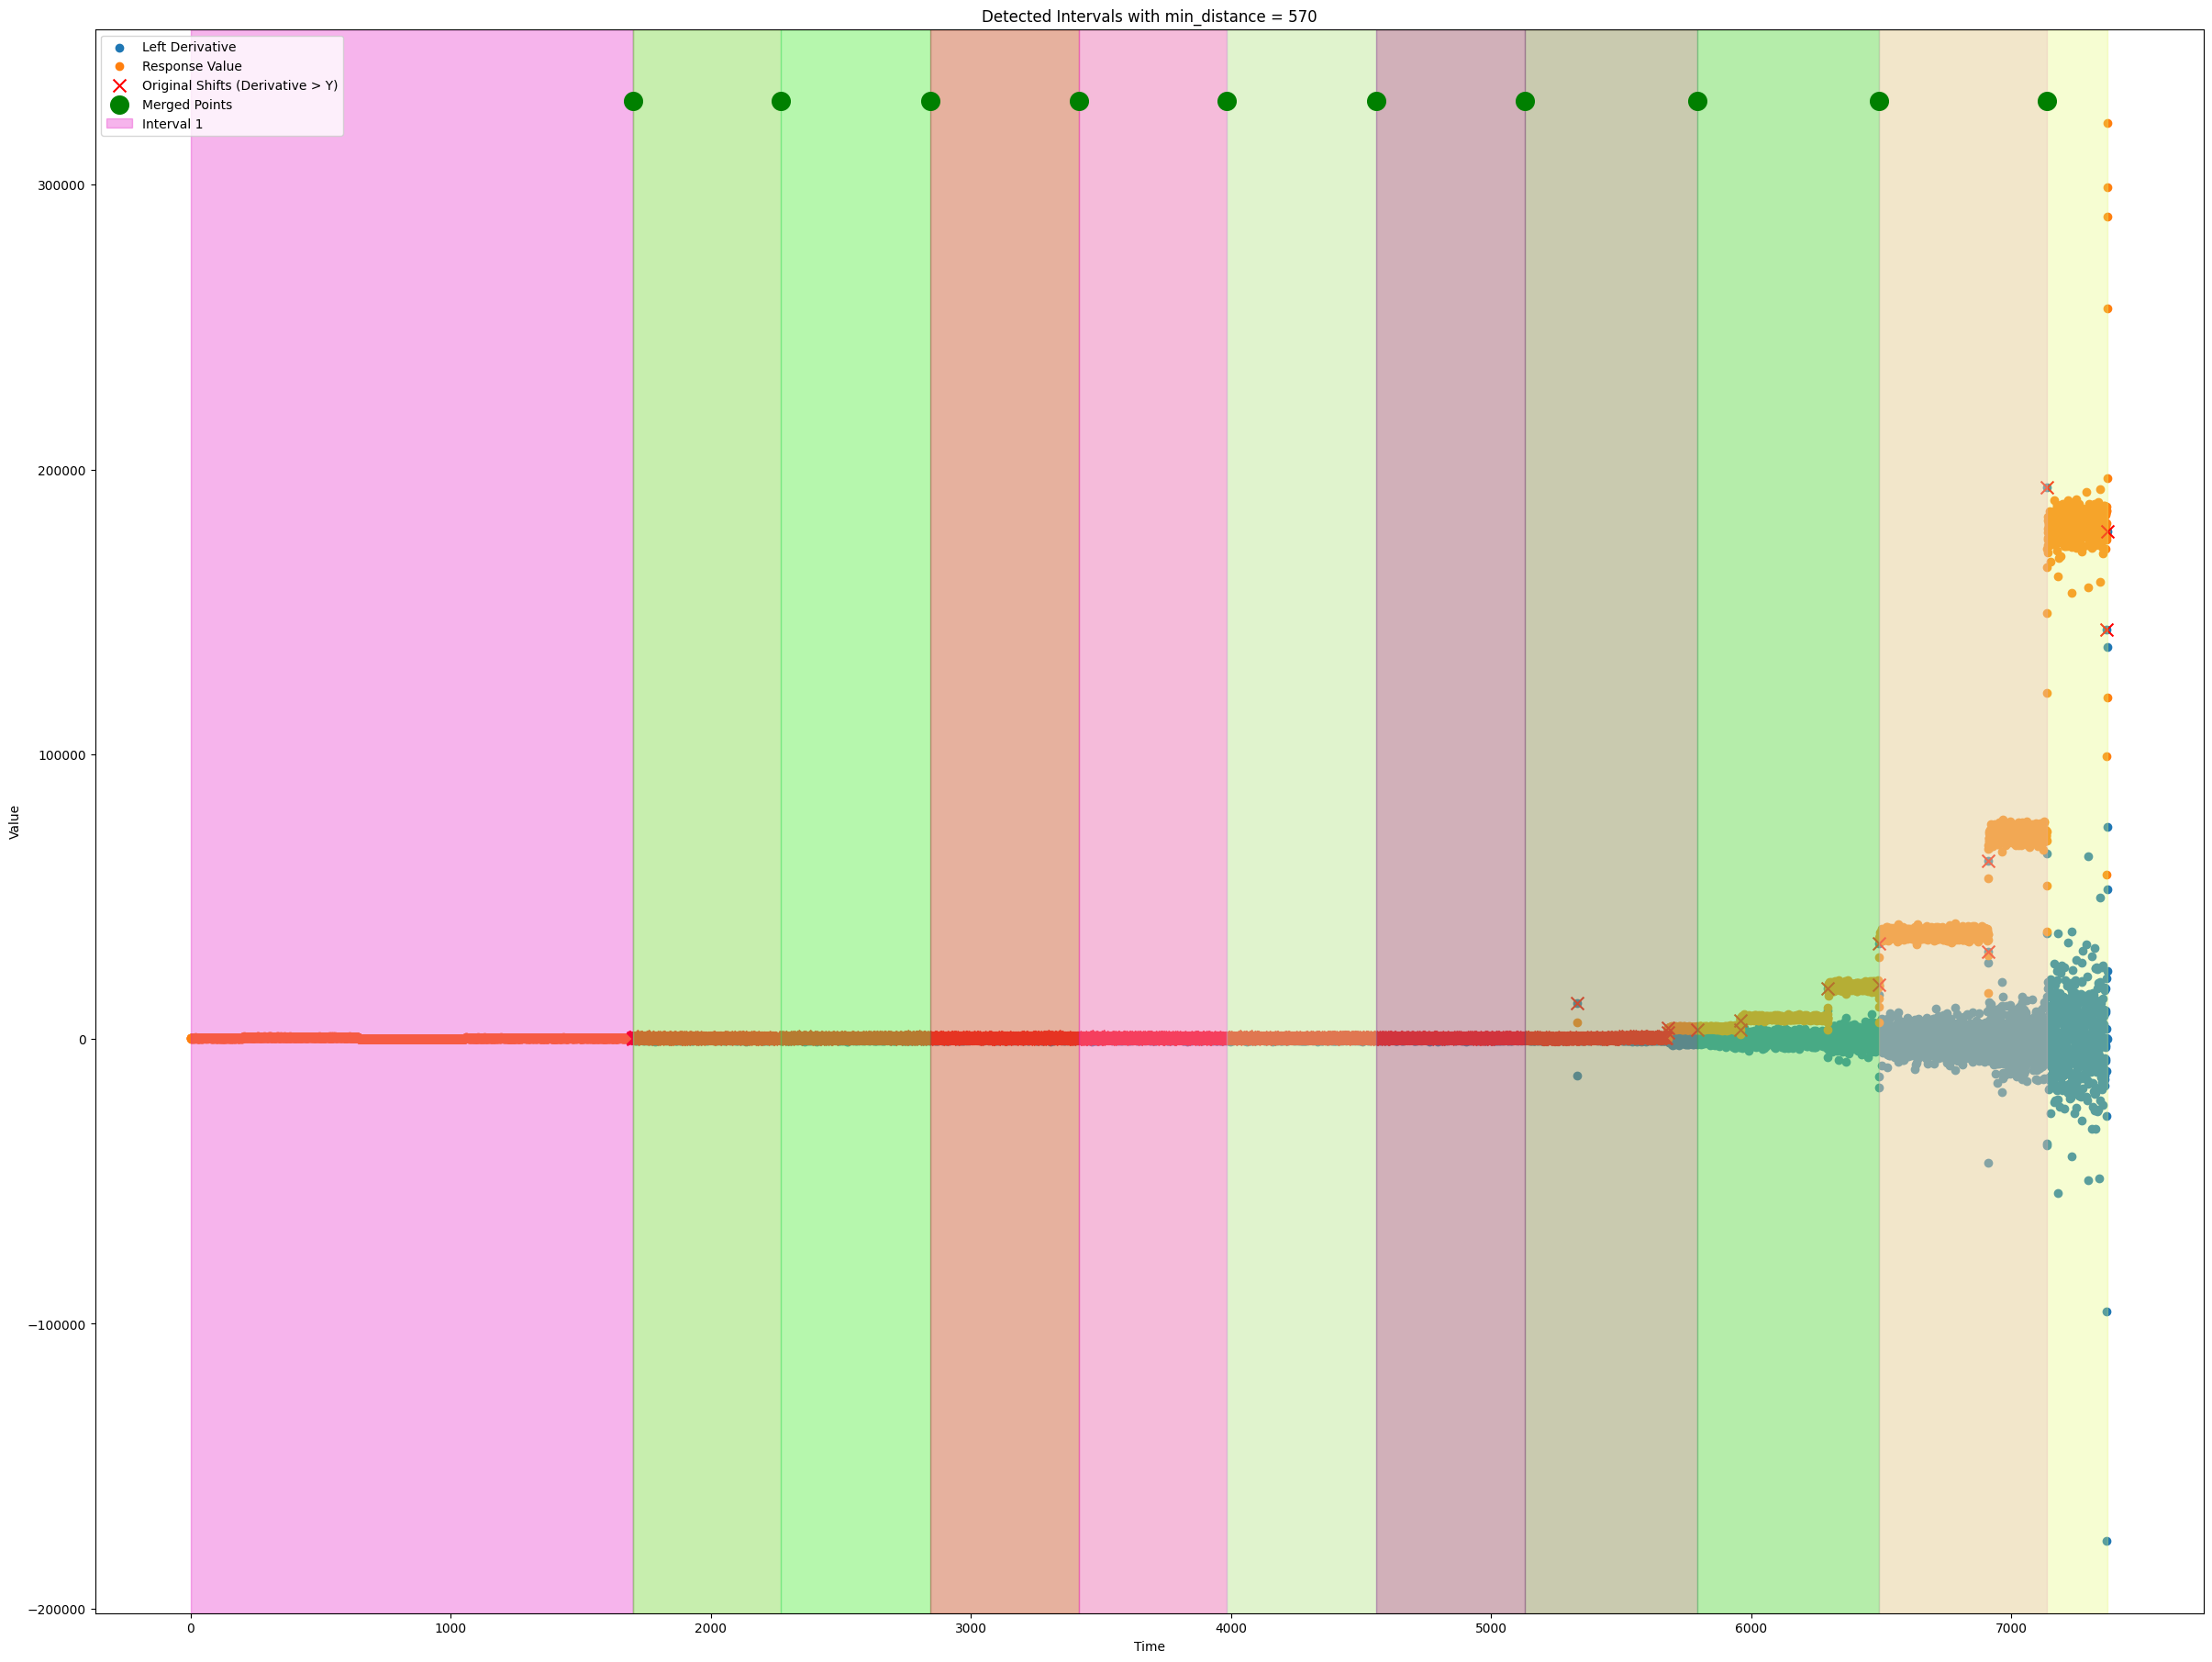


--- Testing with min_distance = 590 ---
Number of merged points for min_distance 590: 9
Detected intervals for min_distance 590:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2290.548),
 (np.float64(1699.982), np.float64(7370.625)),
 (2290.548, 2881.978),
 (2881.978, 3472.544),
 (3472.544, 4062.678),
 (4062.678, 4654.972),
 (4654.972, 5252.018),
 (5252.018, 5957.068),
 (5957.068, 6910.96)]

<Figure size 640x480 with 0 Axes>

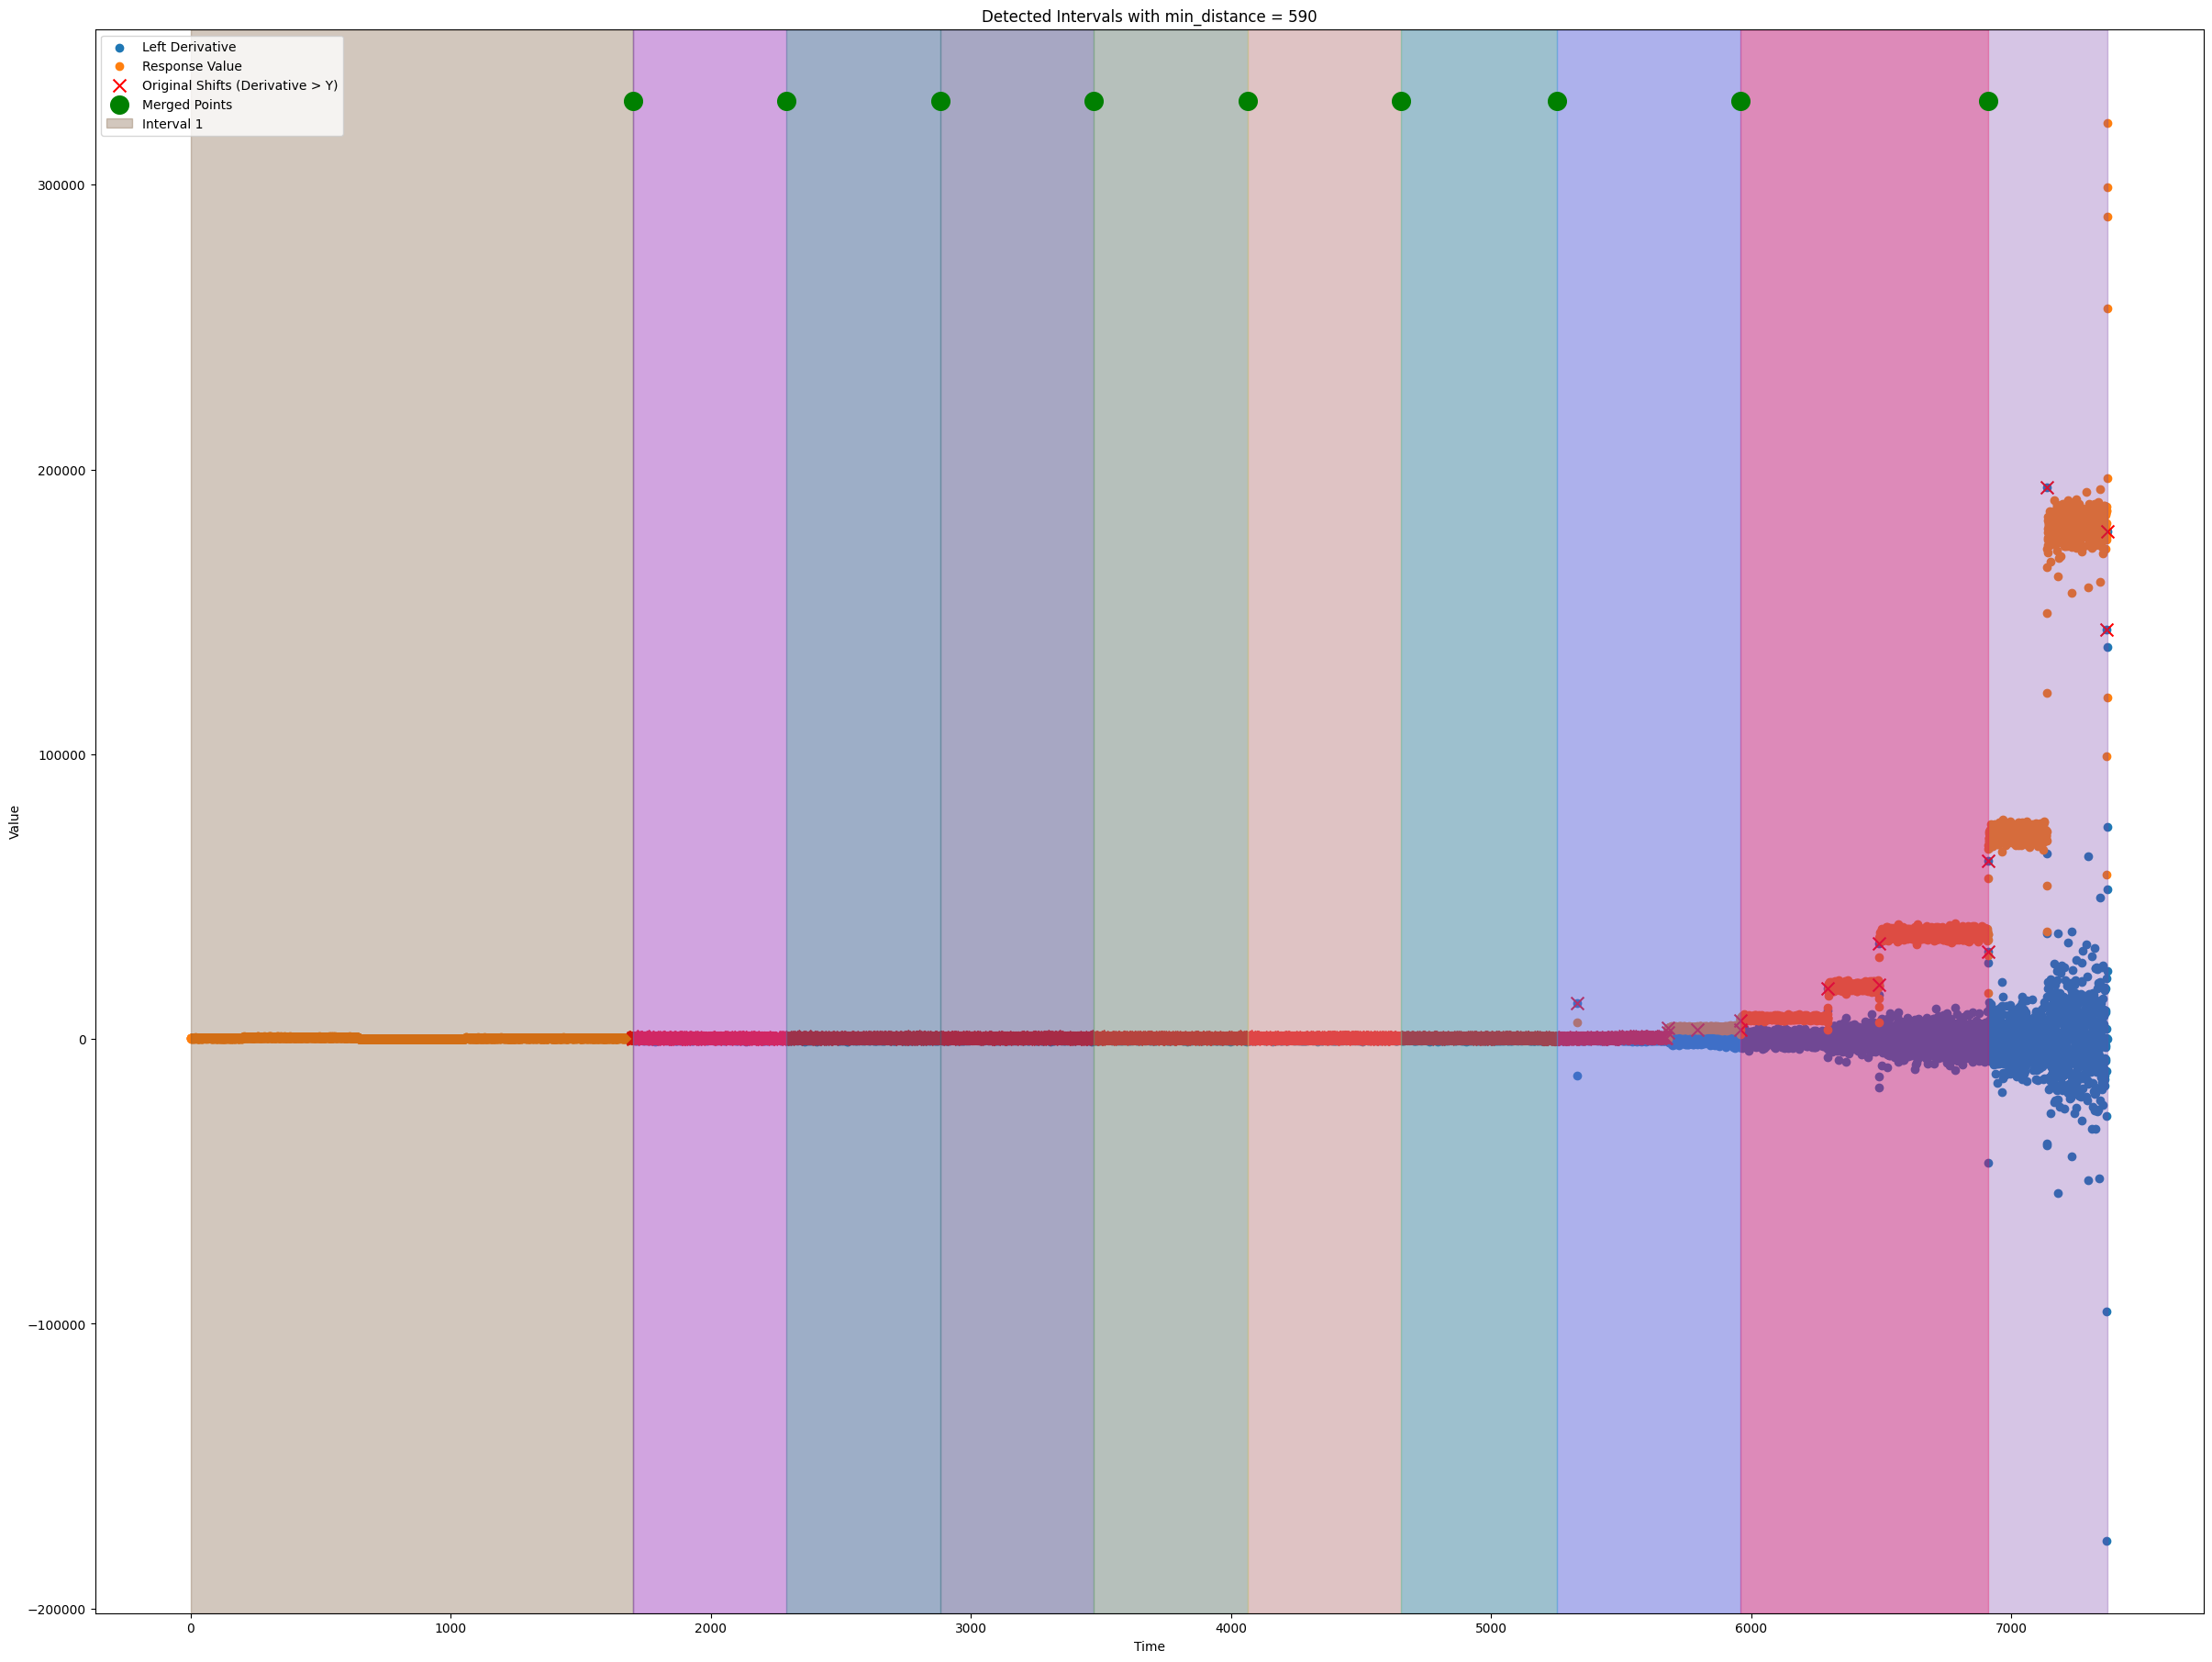


--- Testing with min_distance = 610 ---
Number of merged points for min_distance 610: 9
Detected intervals for min_distance 610:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2311.717),
 (np.float64(1699.982), np.float64(7370.625)),
 (2311.717, 2924.316),
 (2924.316, 3534.322),
 (3534.322, 4146.057),
 (4146.057, 4756.928),
 (4756.928, 5367.798),
 (5367.798, 6294.905),
 (6294.905, 6910.96)]

<Figure size 640x480 with 0 Axes>

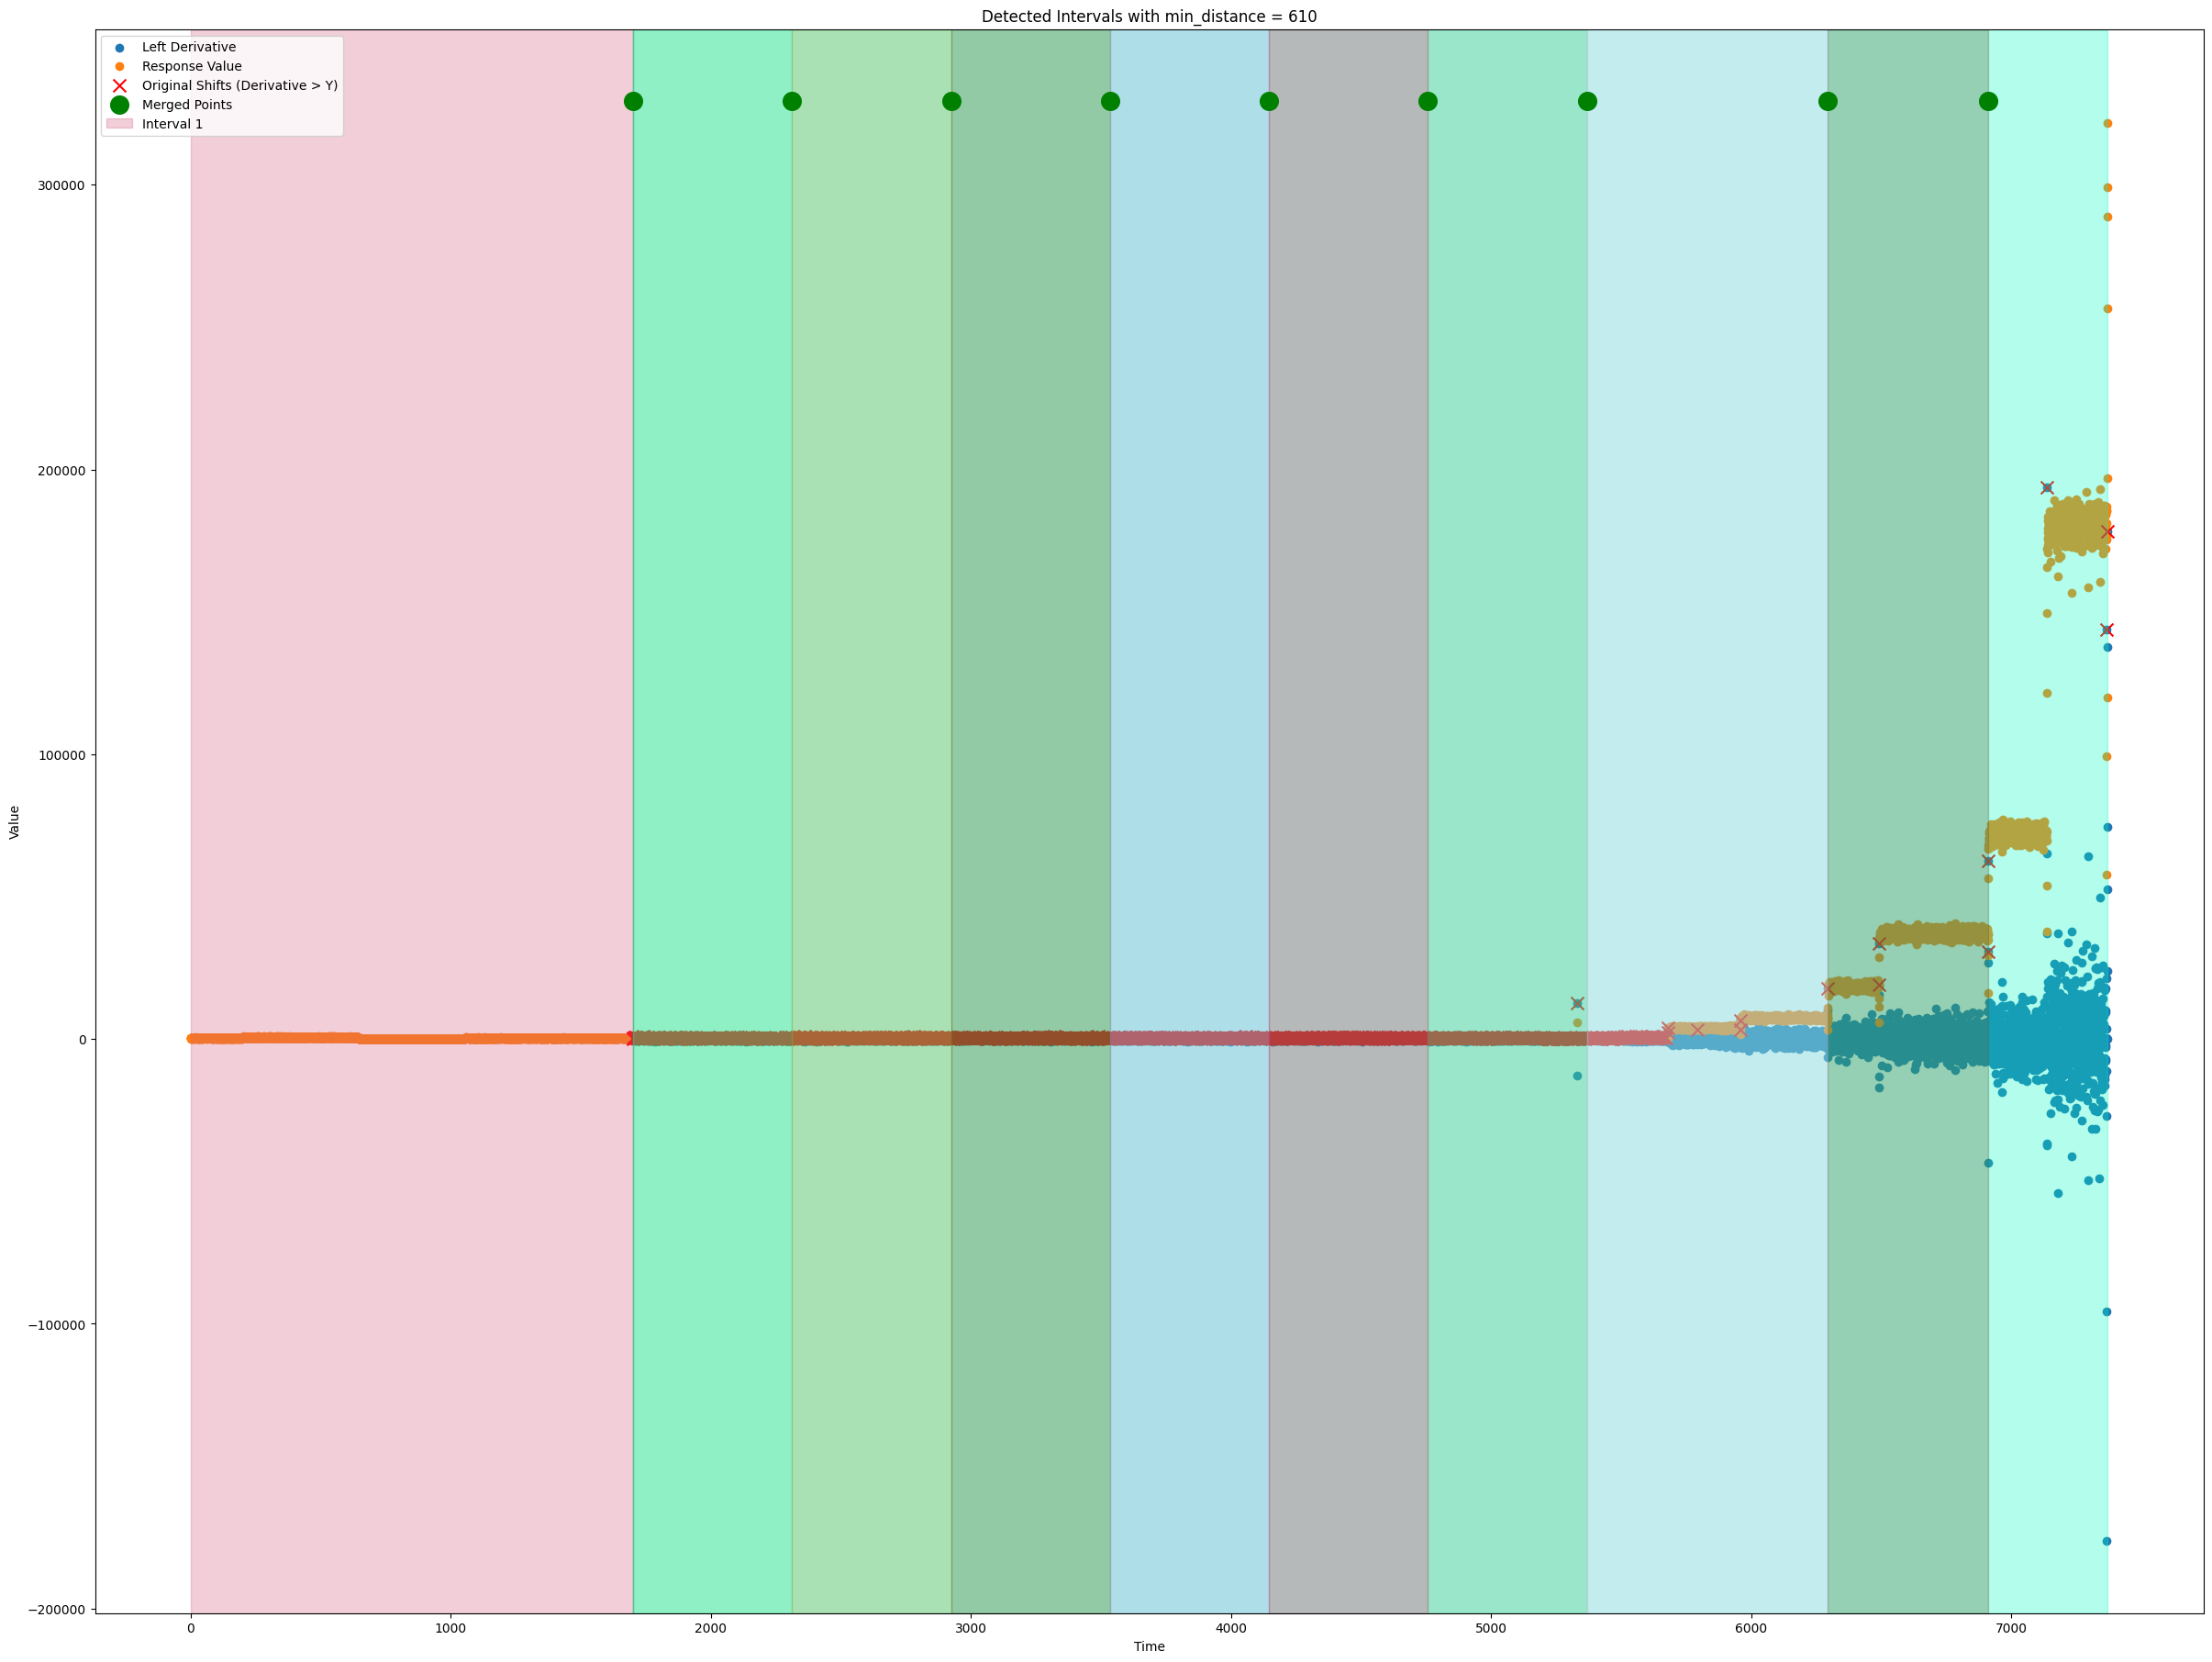


--- Testing with min_distance = 630 ---
Number of merged points for min_distance 630: 9
Detected intervals for min_distance 630:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2330.726),
 (np.float64(1699.982), np.float64(7370.625)),
 (2330.726, 2961.469),
 (2961.469, 3593.941),
 (3593.941, 4224.252),
 (4224.252, 4855.427),
 (4855.427, 5485.739),
 (5485.739, 6294.905),
 (6294.905, 7136.904)]

<Figure size 640x480 with 0 Axes>

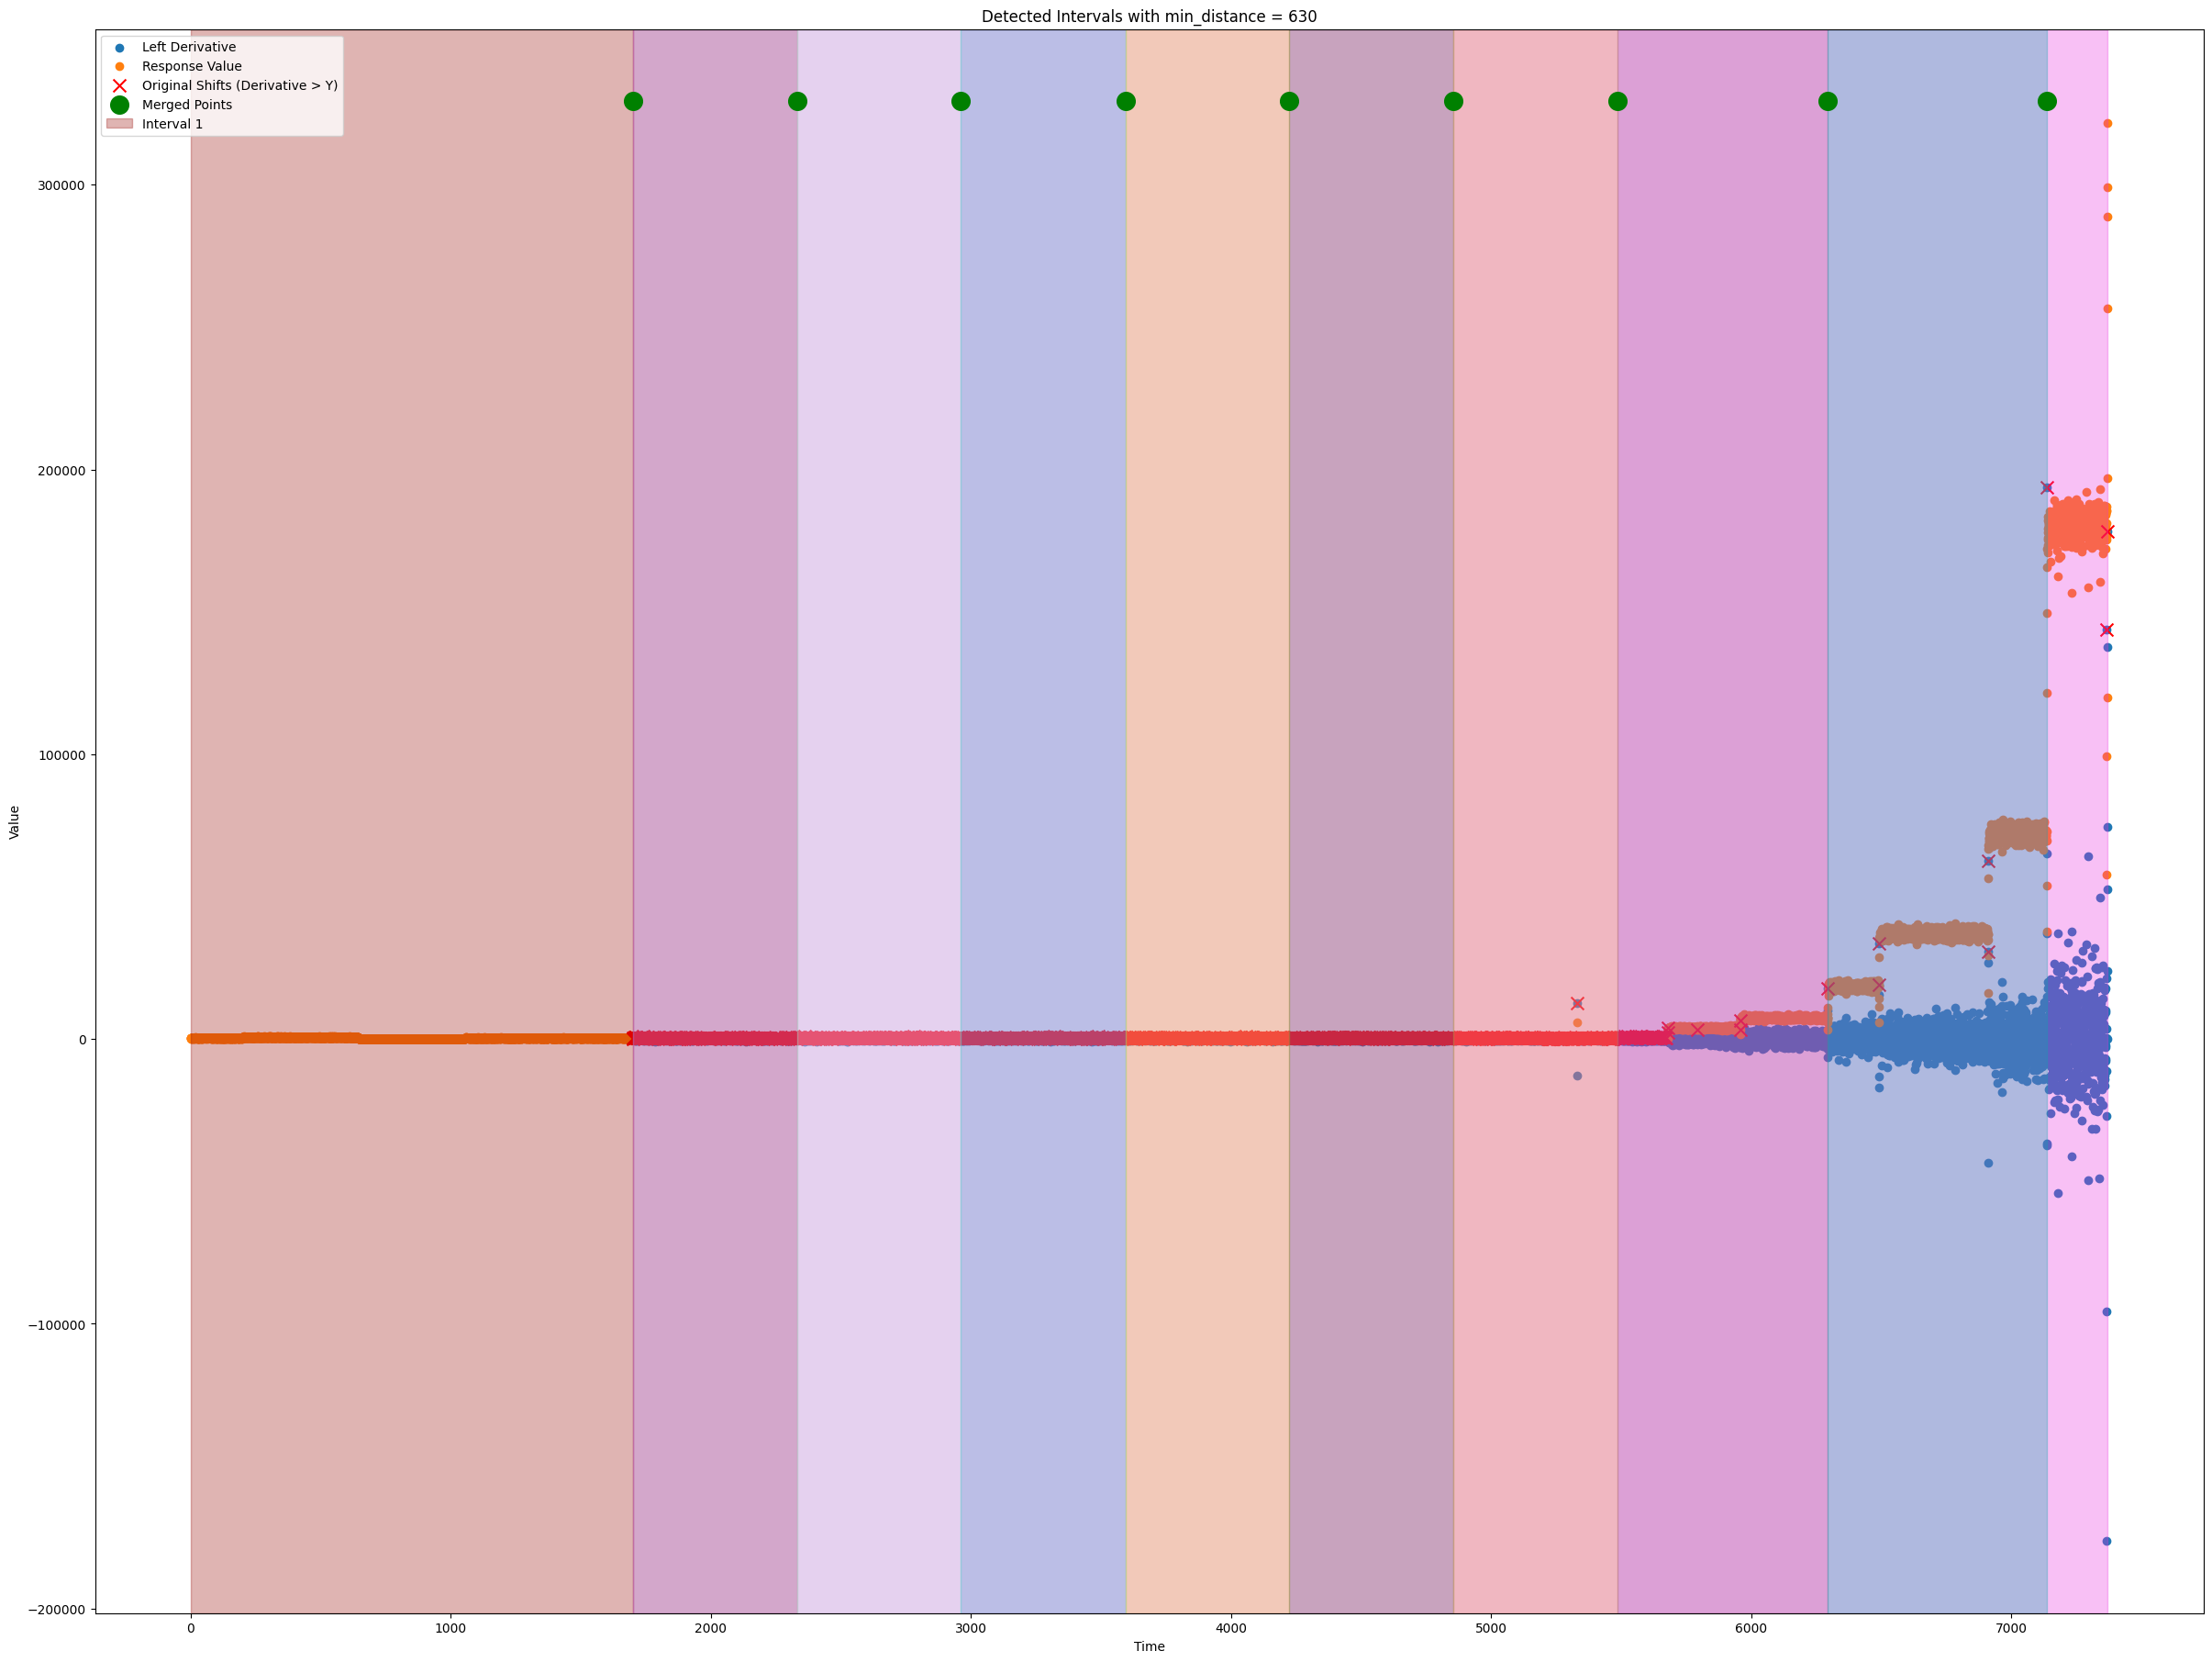


--- Testing with min_distance = 650 ---
Number of merged points for min_distance 650: 9
Detected intervals for min_distance 650:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2351.463),
 (np.float64(1699.982), np.float64(7370.625)),
 (2351.463, 3002.511),
 (3002.511, 3652.695),
 (3652.695, 4302.879),
 (4302.879, 4953.927),
 (4953.927, 5604.111),
 (5604.111, 6294.905),
 (6294.905, 7136.904)]

<Figure size 640x480 with 0 Axes>

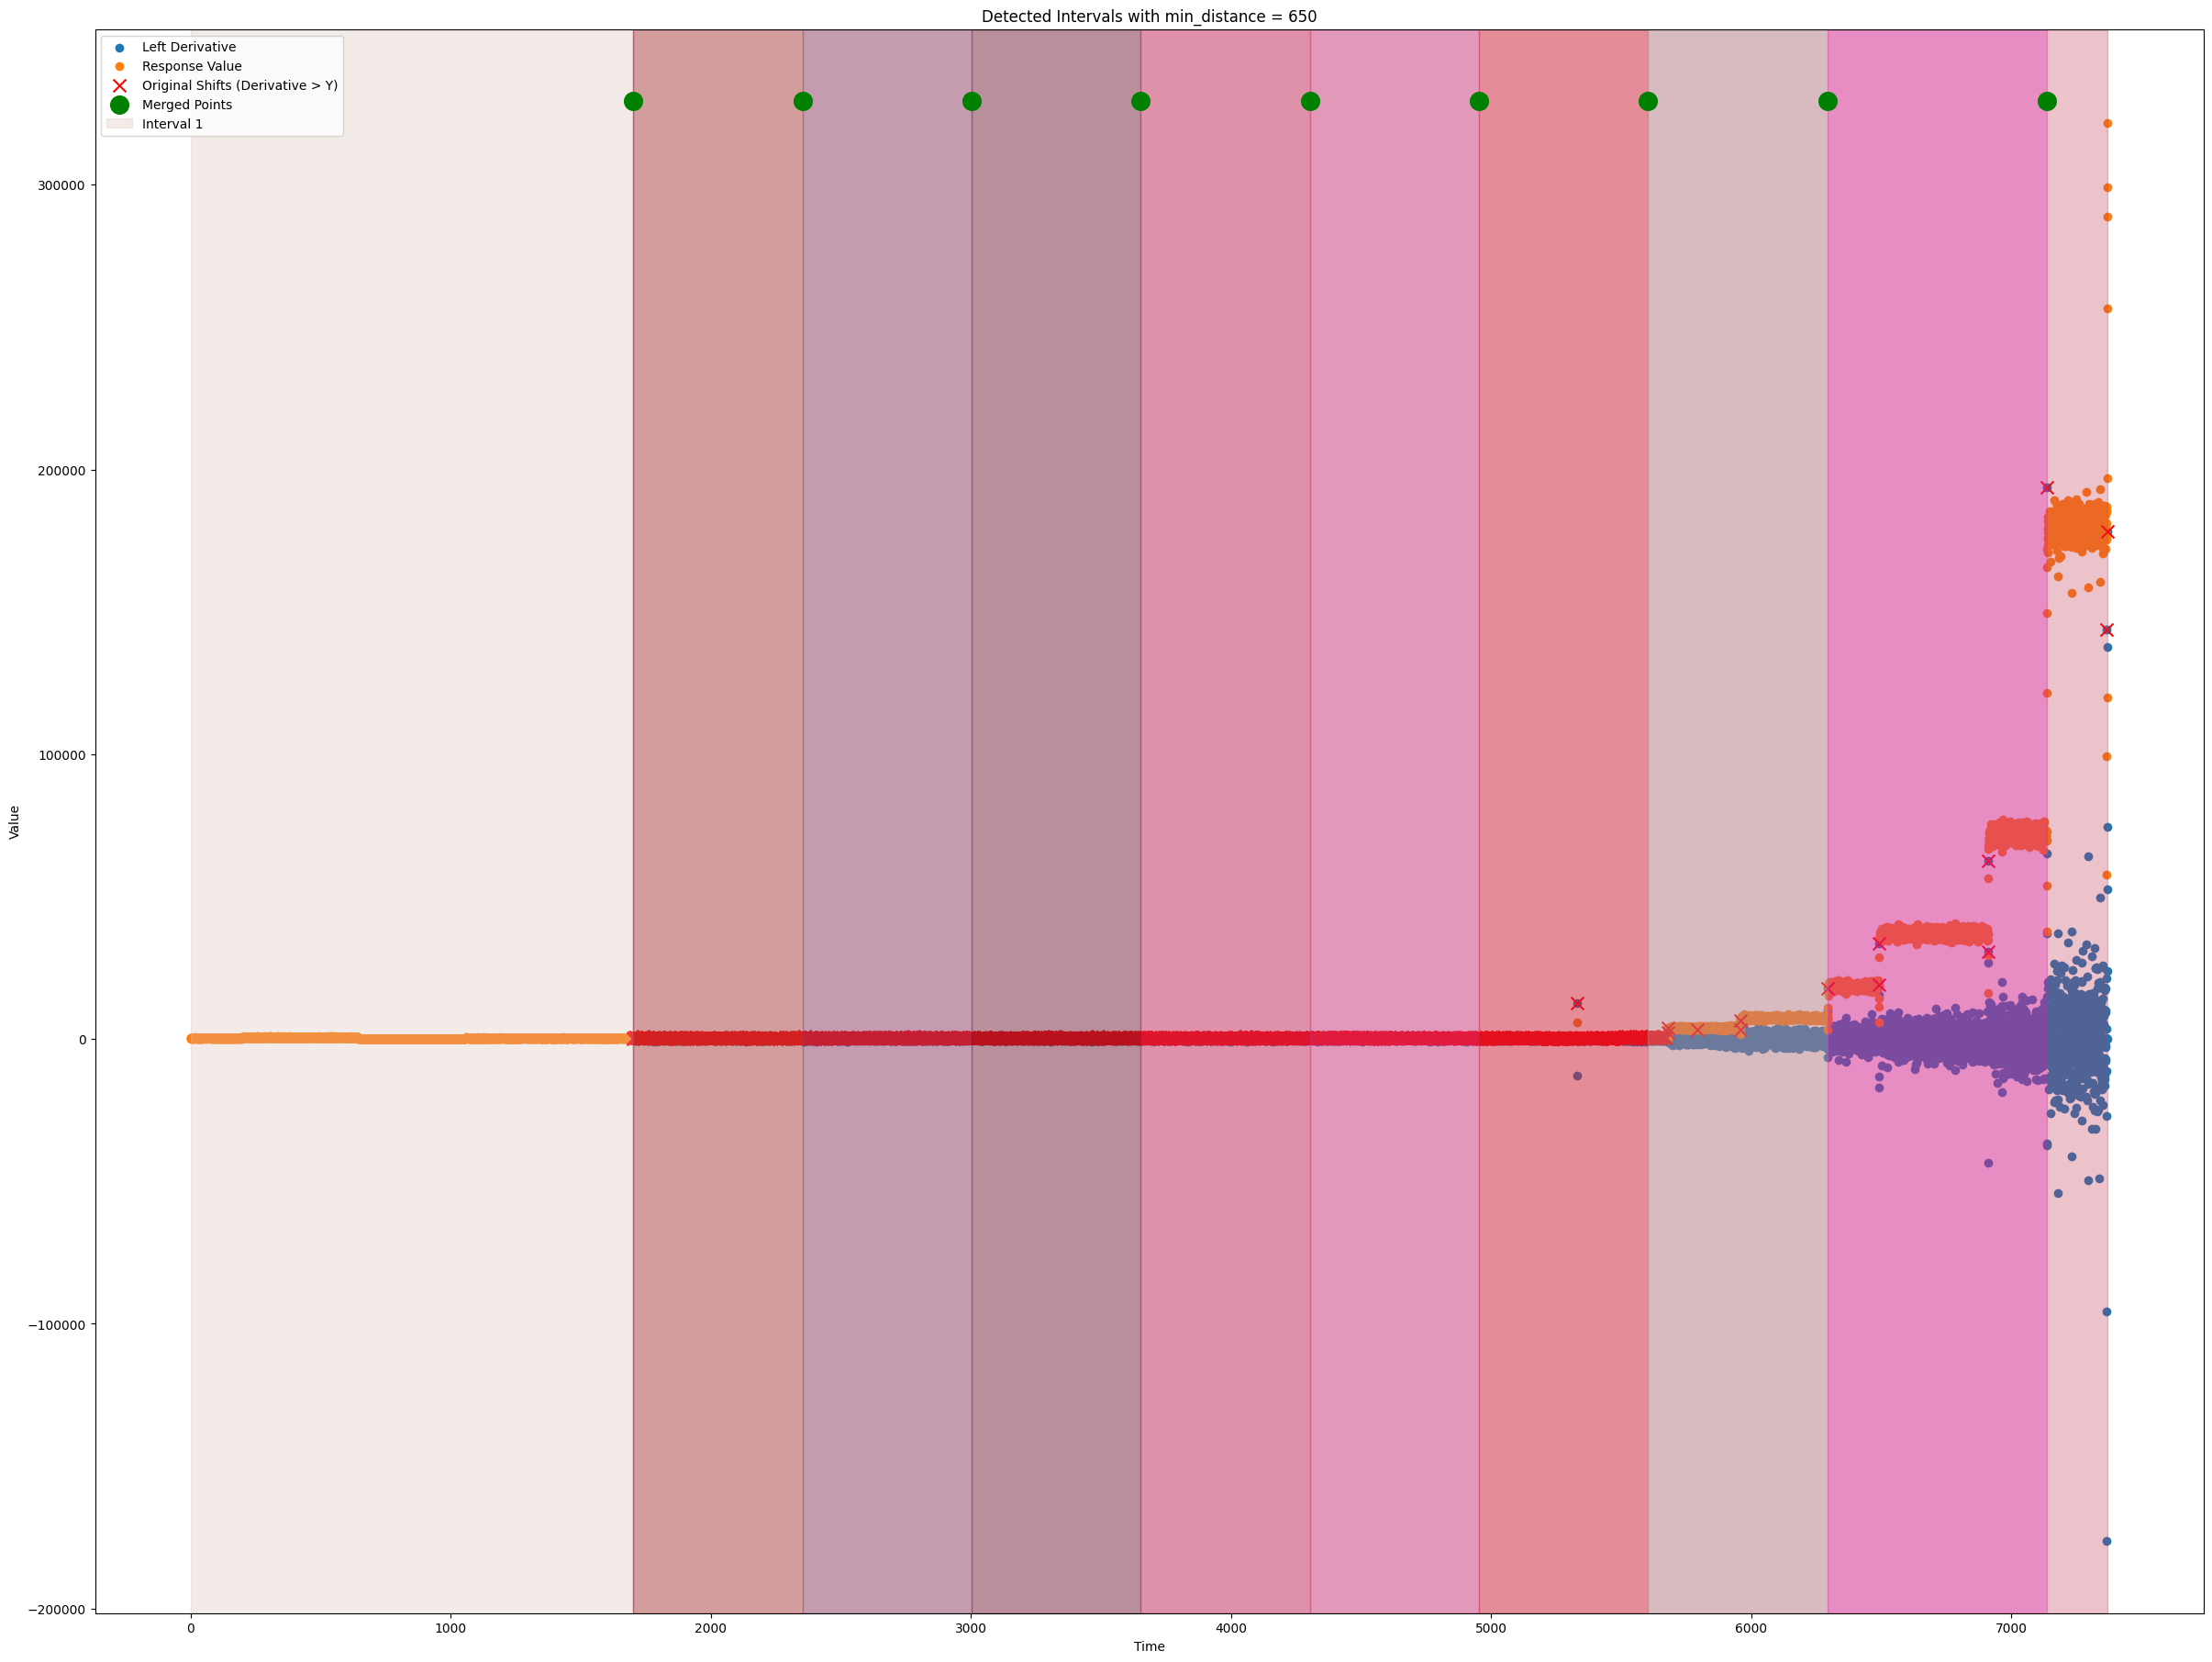


--- Testing with min_distance = 670 ---
Number of merged points for min_distance 670: 9
Detected intervals for min_distance 670:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2373.495),
 (np.float64(1699.982), np.float64(7370.625)),
 (2373.495, 3043.552),
 (3043.552, 3714.905),
 (3714.905, 4385.826),
 (4385.826, 5062.363),
 (5062.363, 5792.902),
 (5792.902, 6491.904),
 (6491.904, 7368.033)]

<Figure size 640x480 with 0 Axes>

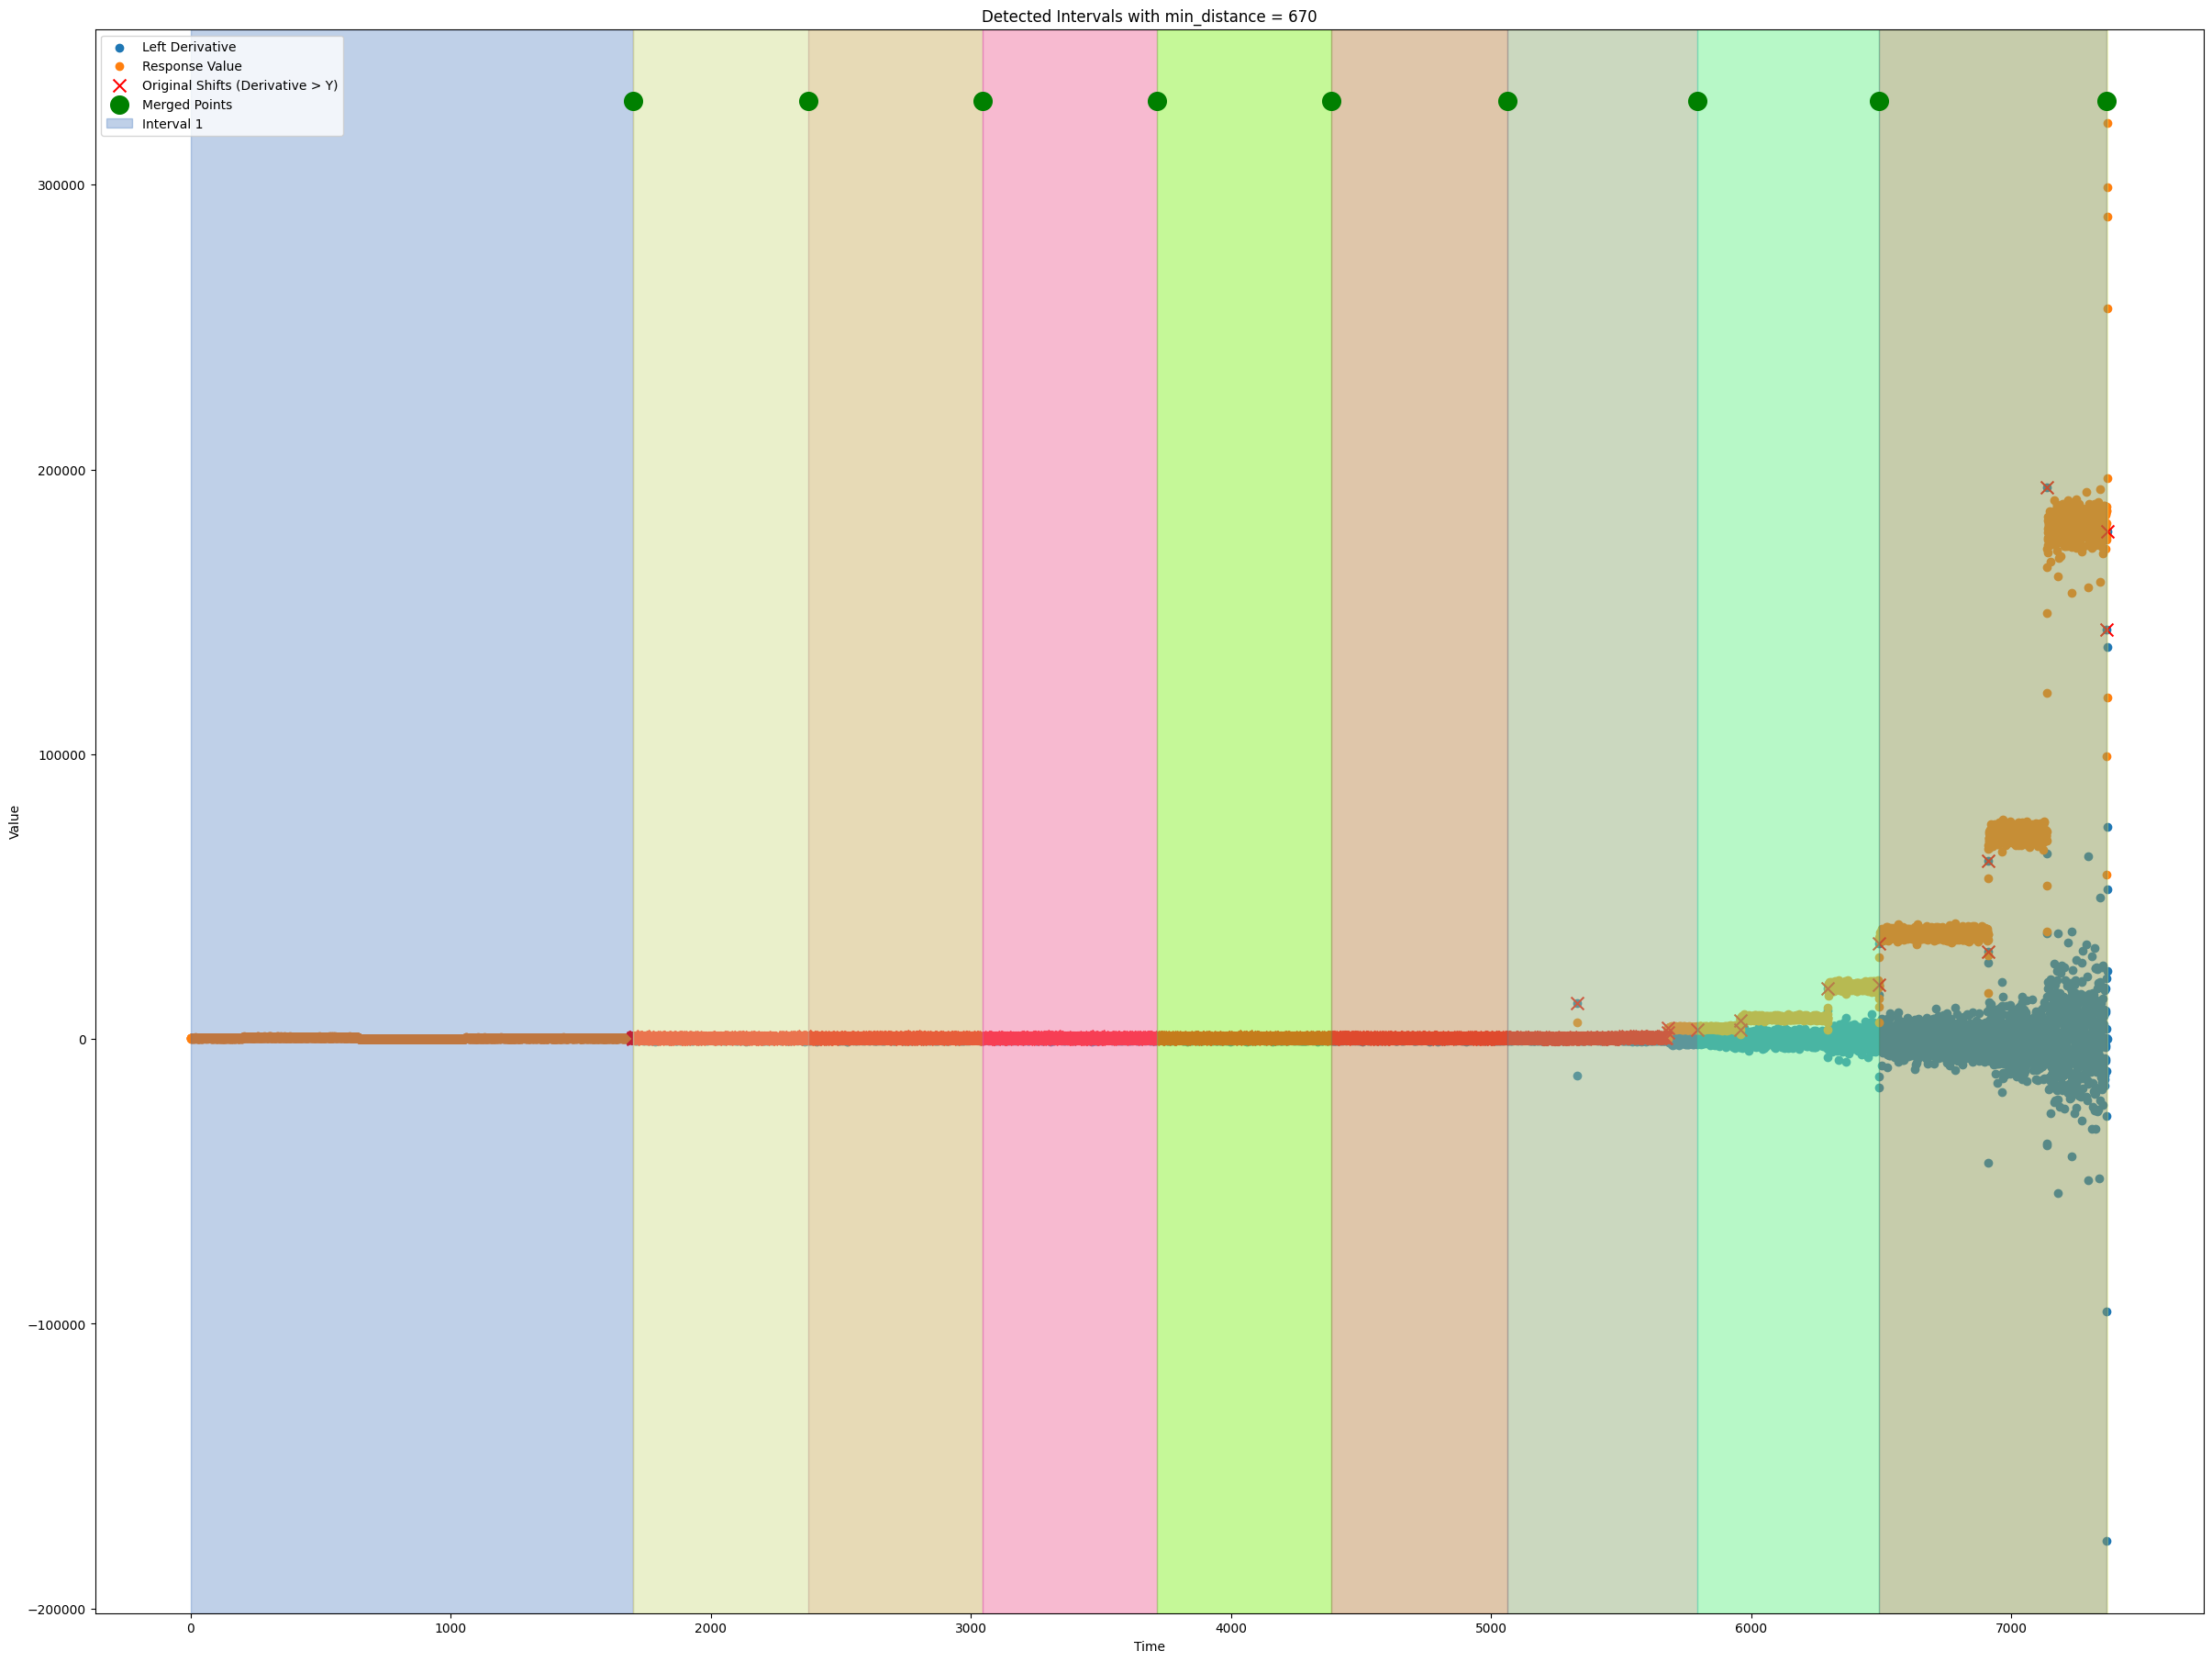


--- Testing with min_distance = 690 ---
Number of merged points for min_distance 690: 8
Detected intervals for min_distance 690:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2395.096),
 (np.float64(1699.982), np.float64(7370.625)),
 (2395.096, 3086.322),
 (3086.322, 3777.115),
 (3777.115, 4470.933),
 (4470.933, 5163.887),
 (5163.887, 5957.068),
 (5957.068, 6910.96)]

<Figure size 640x480 with 0 Axes>

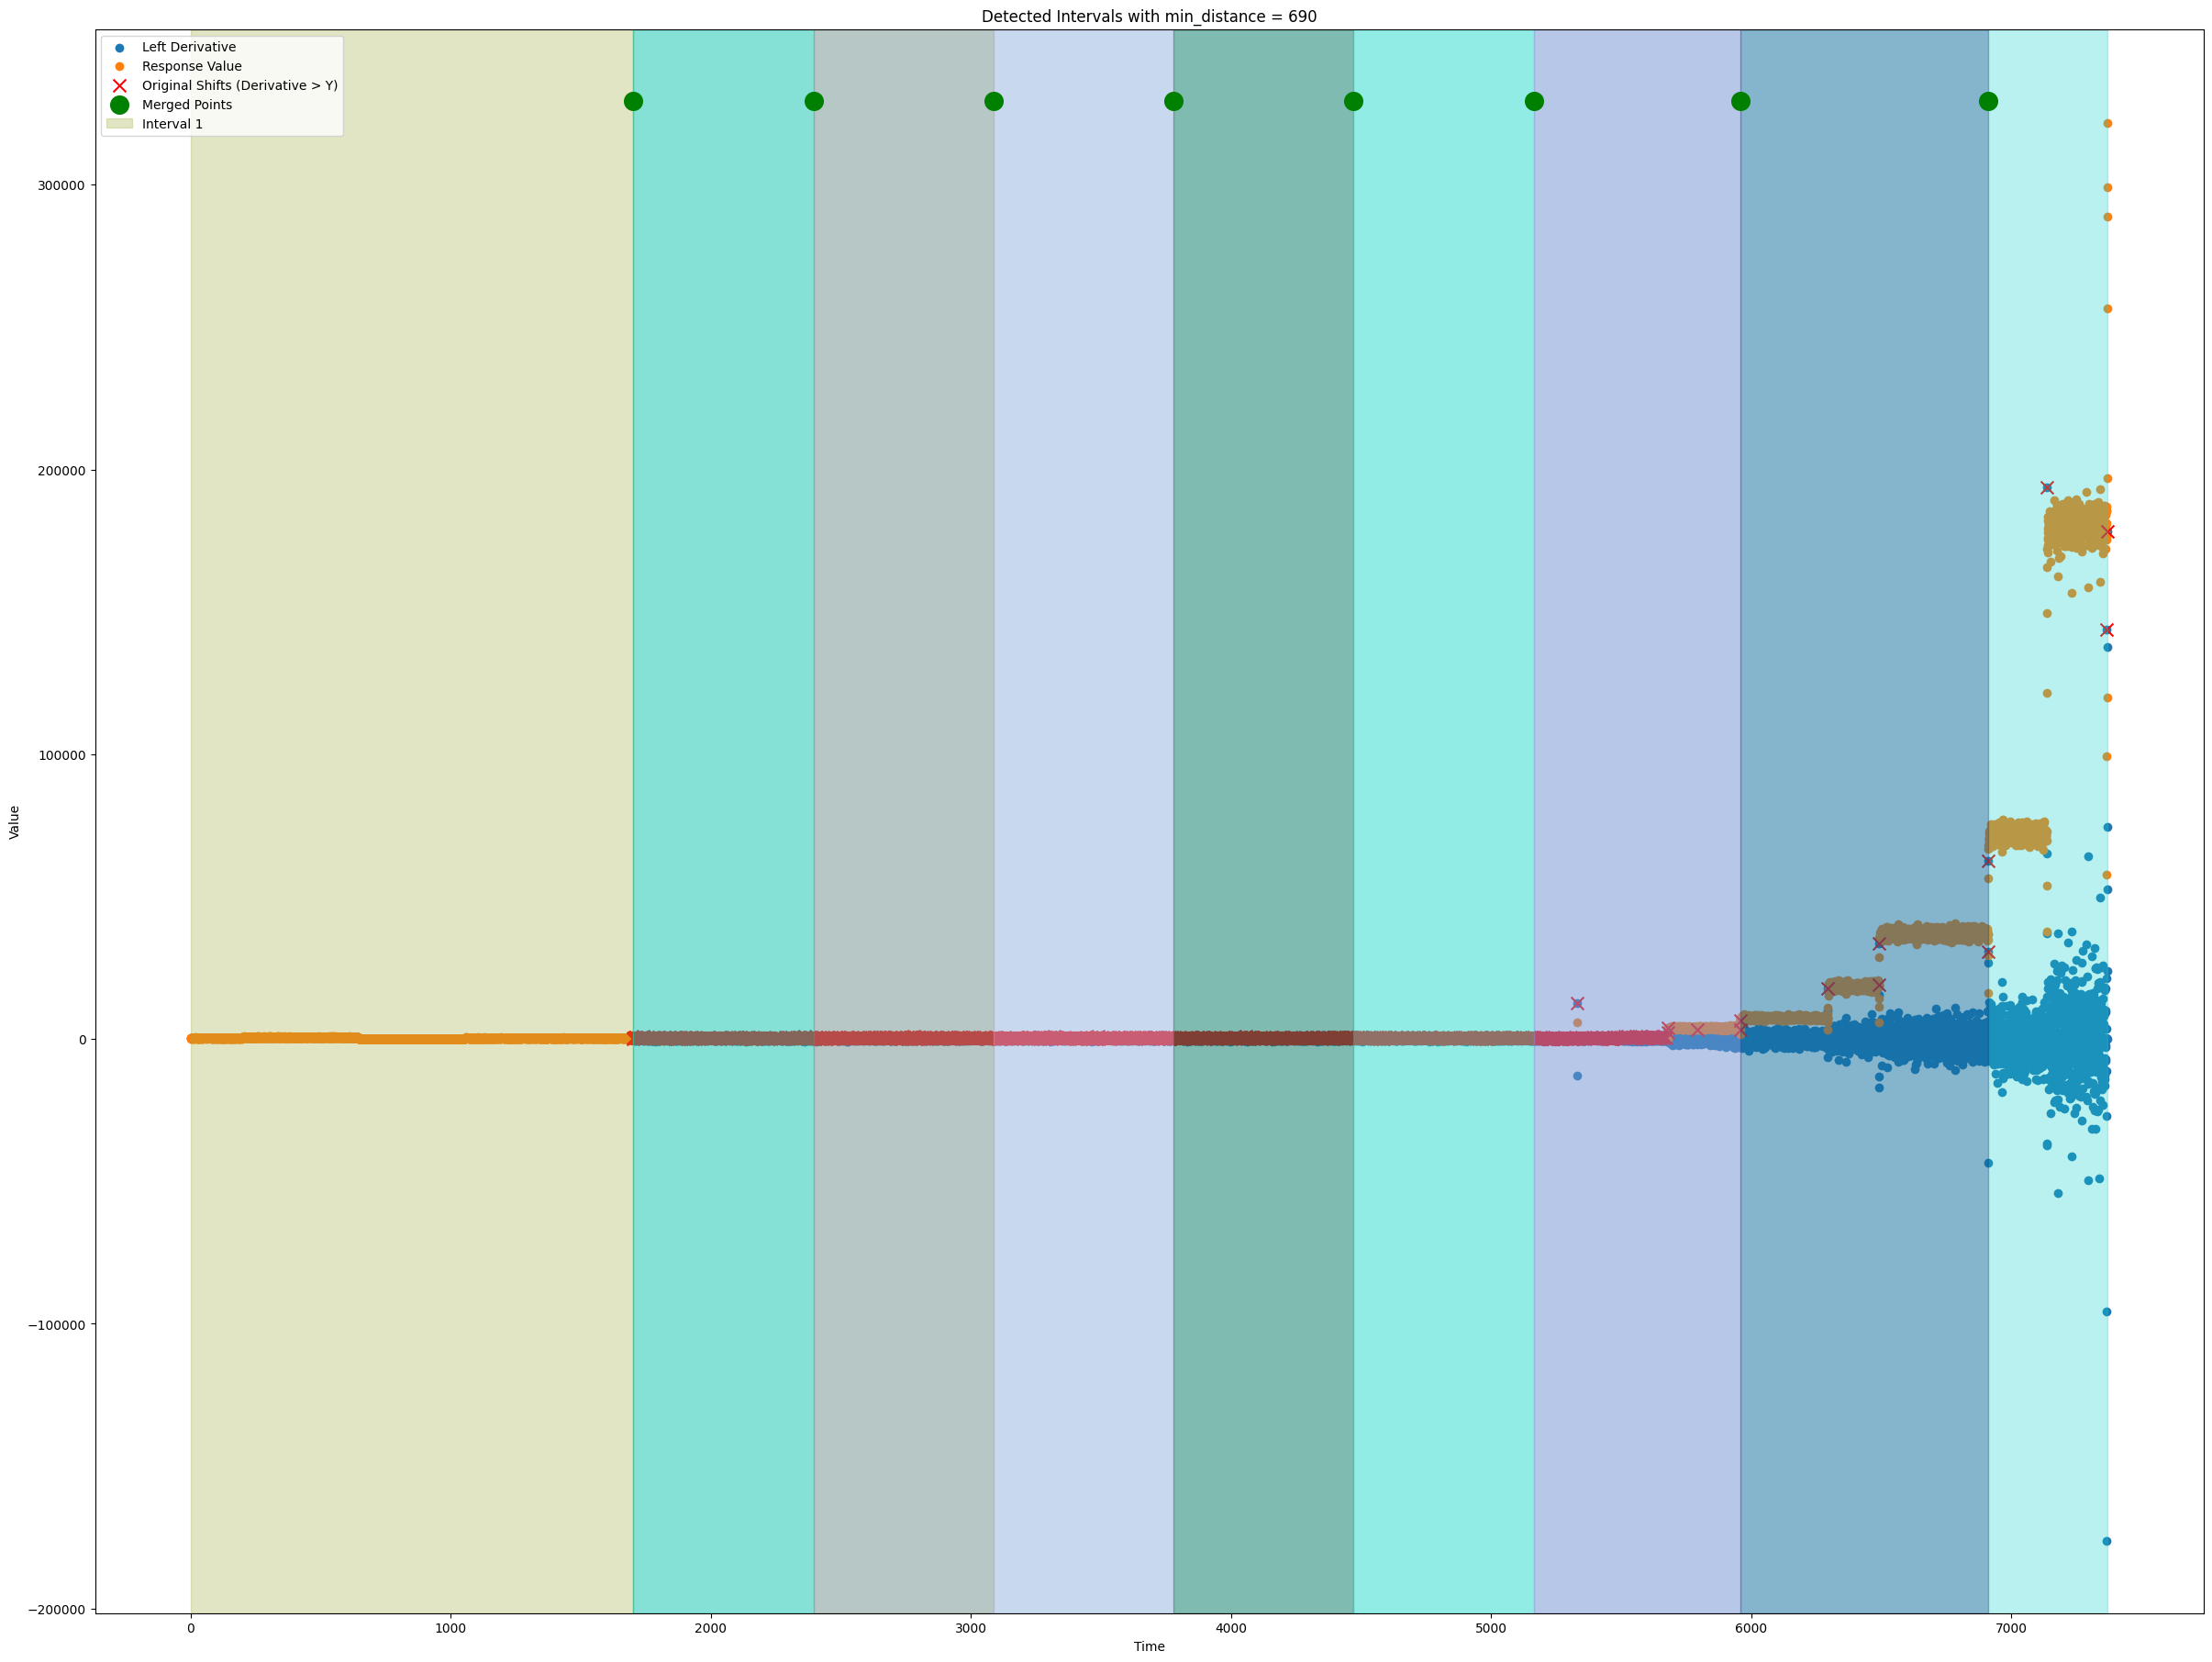


--- Testing with min_distance = 710 ---
Number of merged points for min_distance 710: 8
Detected intervals for min_distance 710:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2414.105),
 (np.float64(1699.982), np.float64(7370.625)),
 (2414.105, 3125.203),
 (3125.203, 3836.302),
 (3836.302, 4547.832),
 (4547.832, 5259.794),
 (5259.794, 6294.905),
 (6294.905, 7136.904)]

<Figure size 640x480 with 0 Axes>

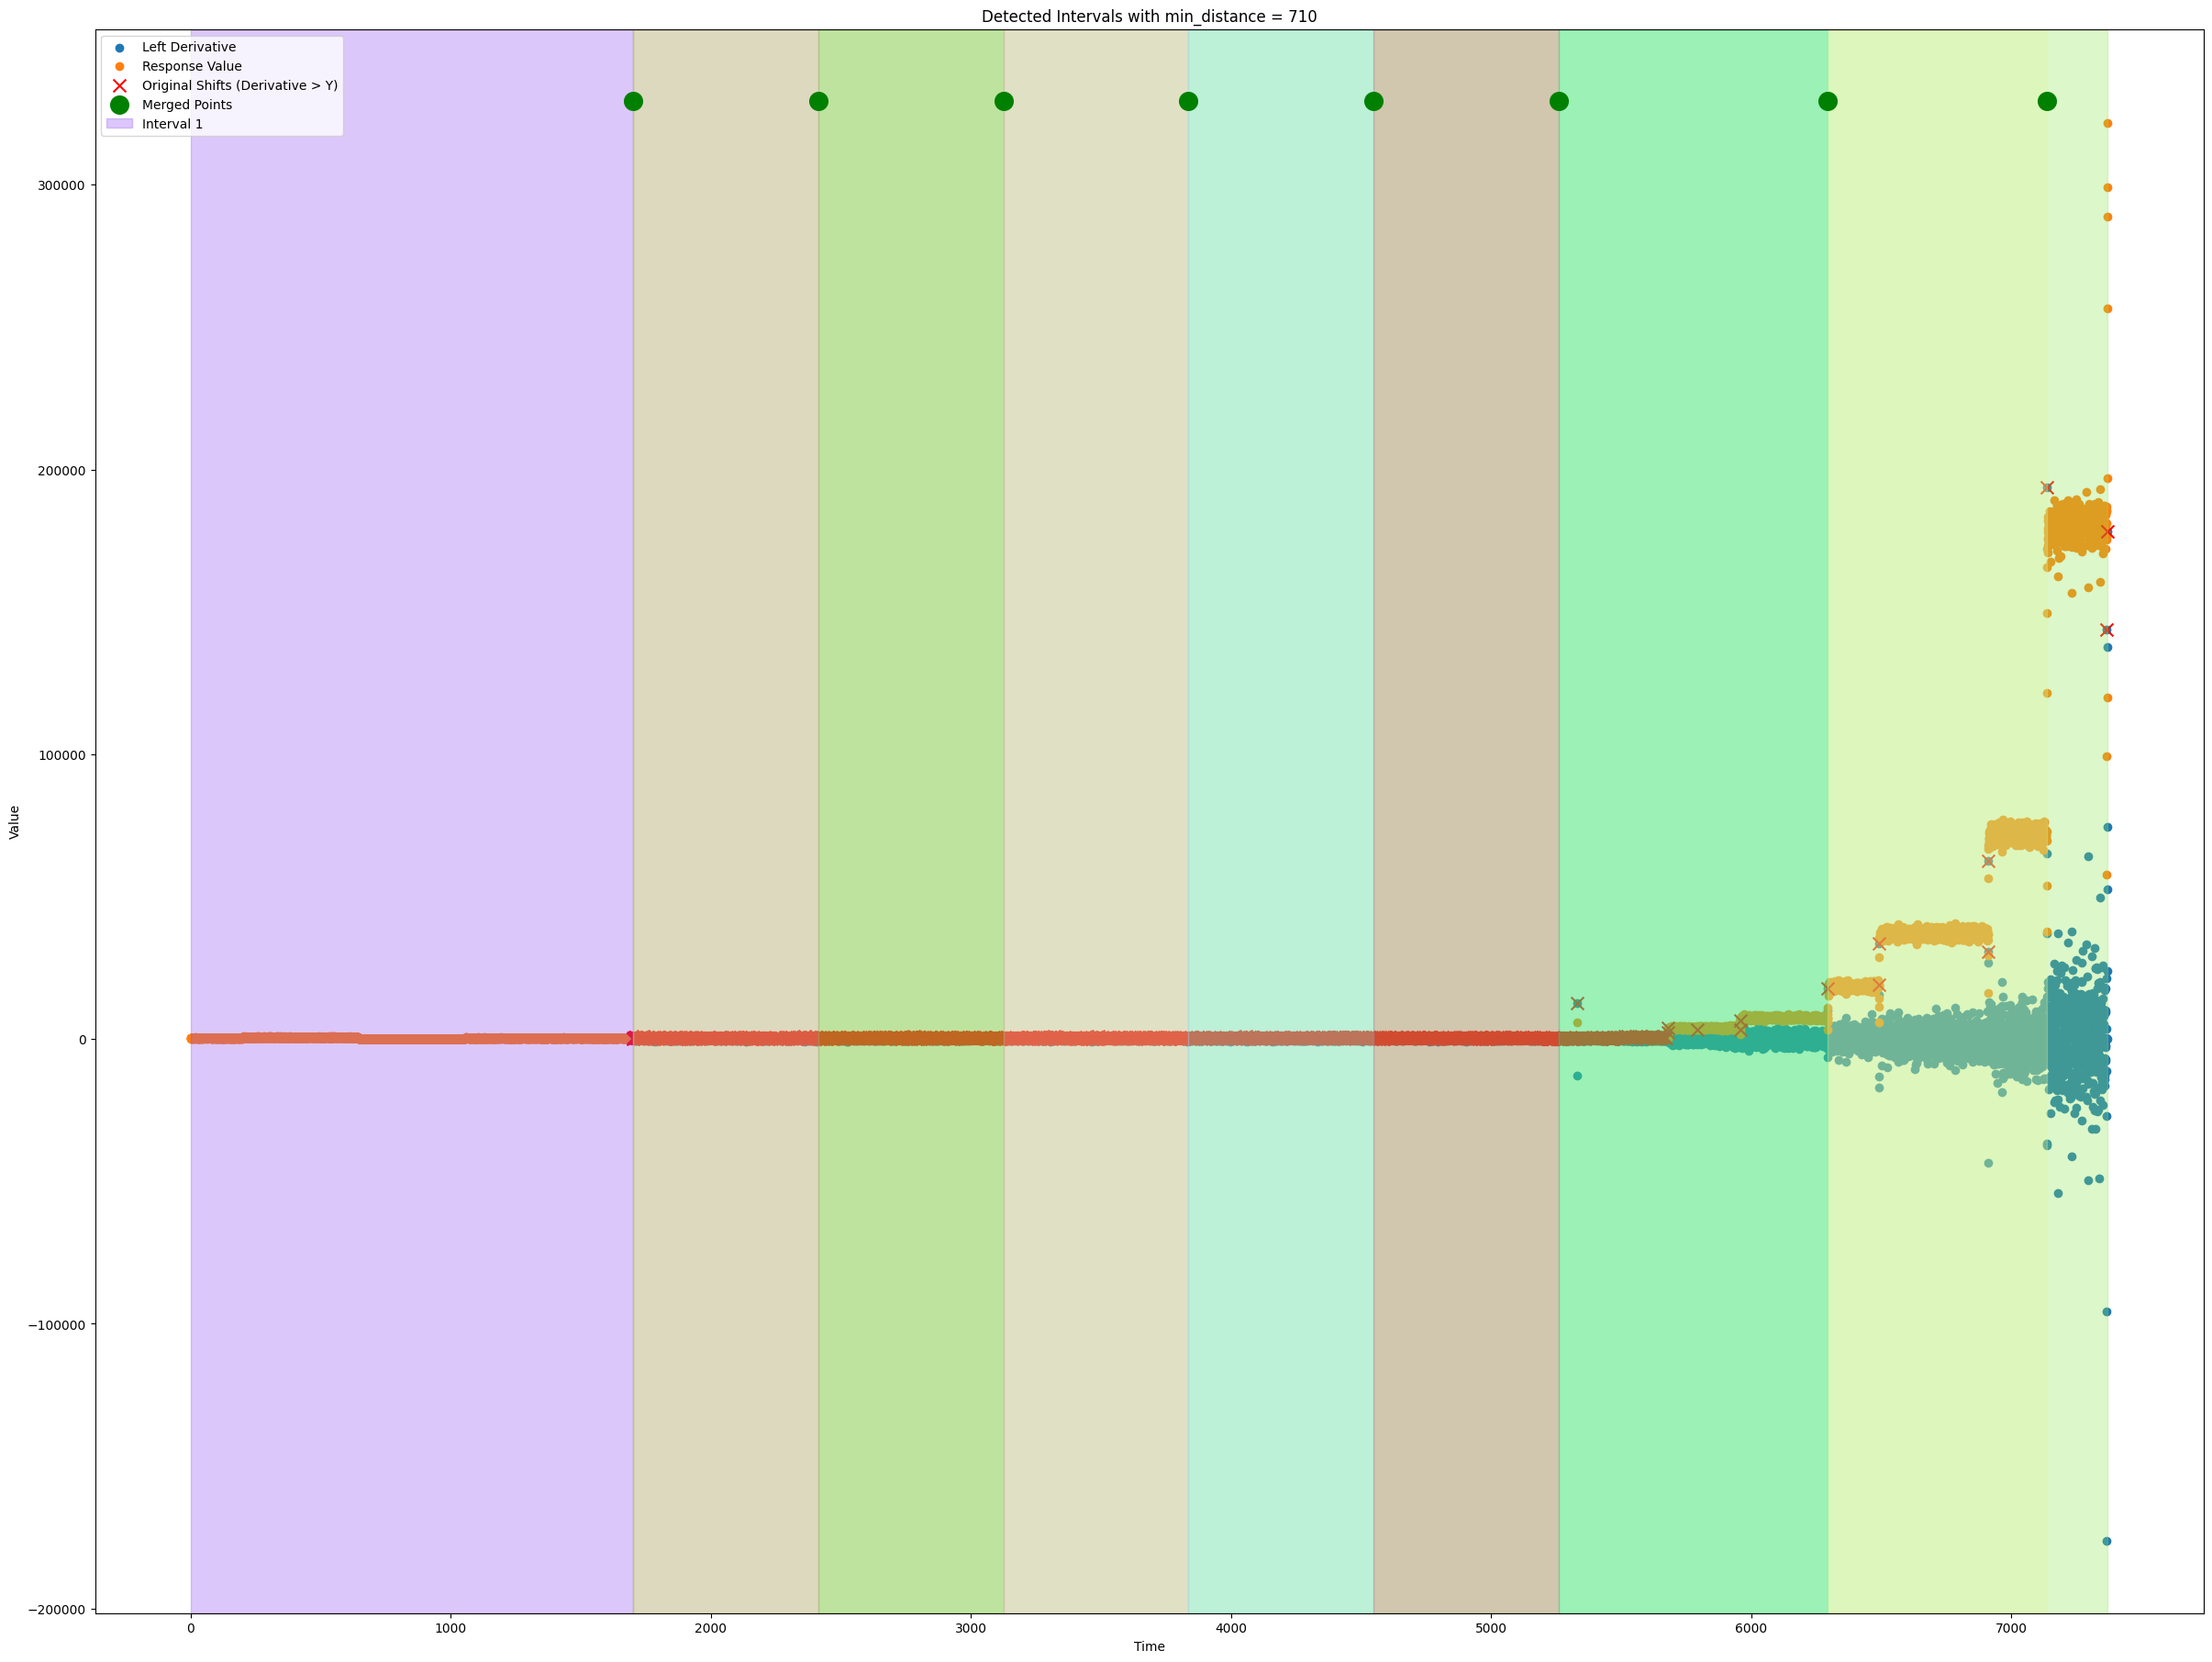


--- Testing with min_distance = 730 ---
Number of merged points for min_distance 730: 8
Detected intervals for min_distance 730:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2432.25),
 (np.float64(1699.982), np.float64(7370.625)),
 (2432.25, 3162.357),
 (3162.357, 3893.328),
 (3893.328, 4624.299),
 (4624.299, 5354.406),
 (5354.406, 6294.905),
 (6294.905, 7136.904)]

<Figure size 640x480 with 0 Axes>

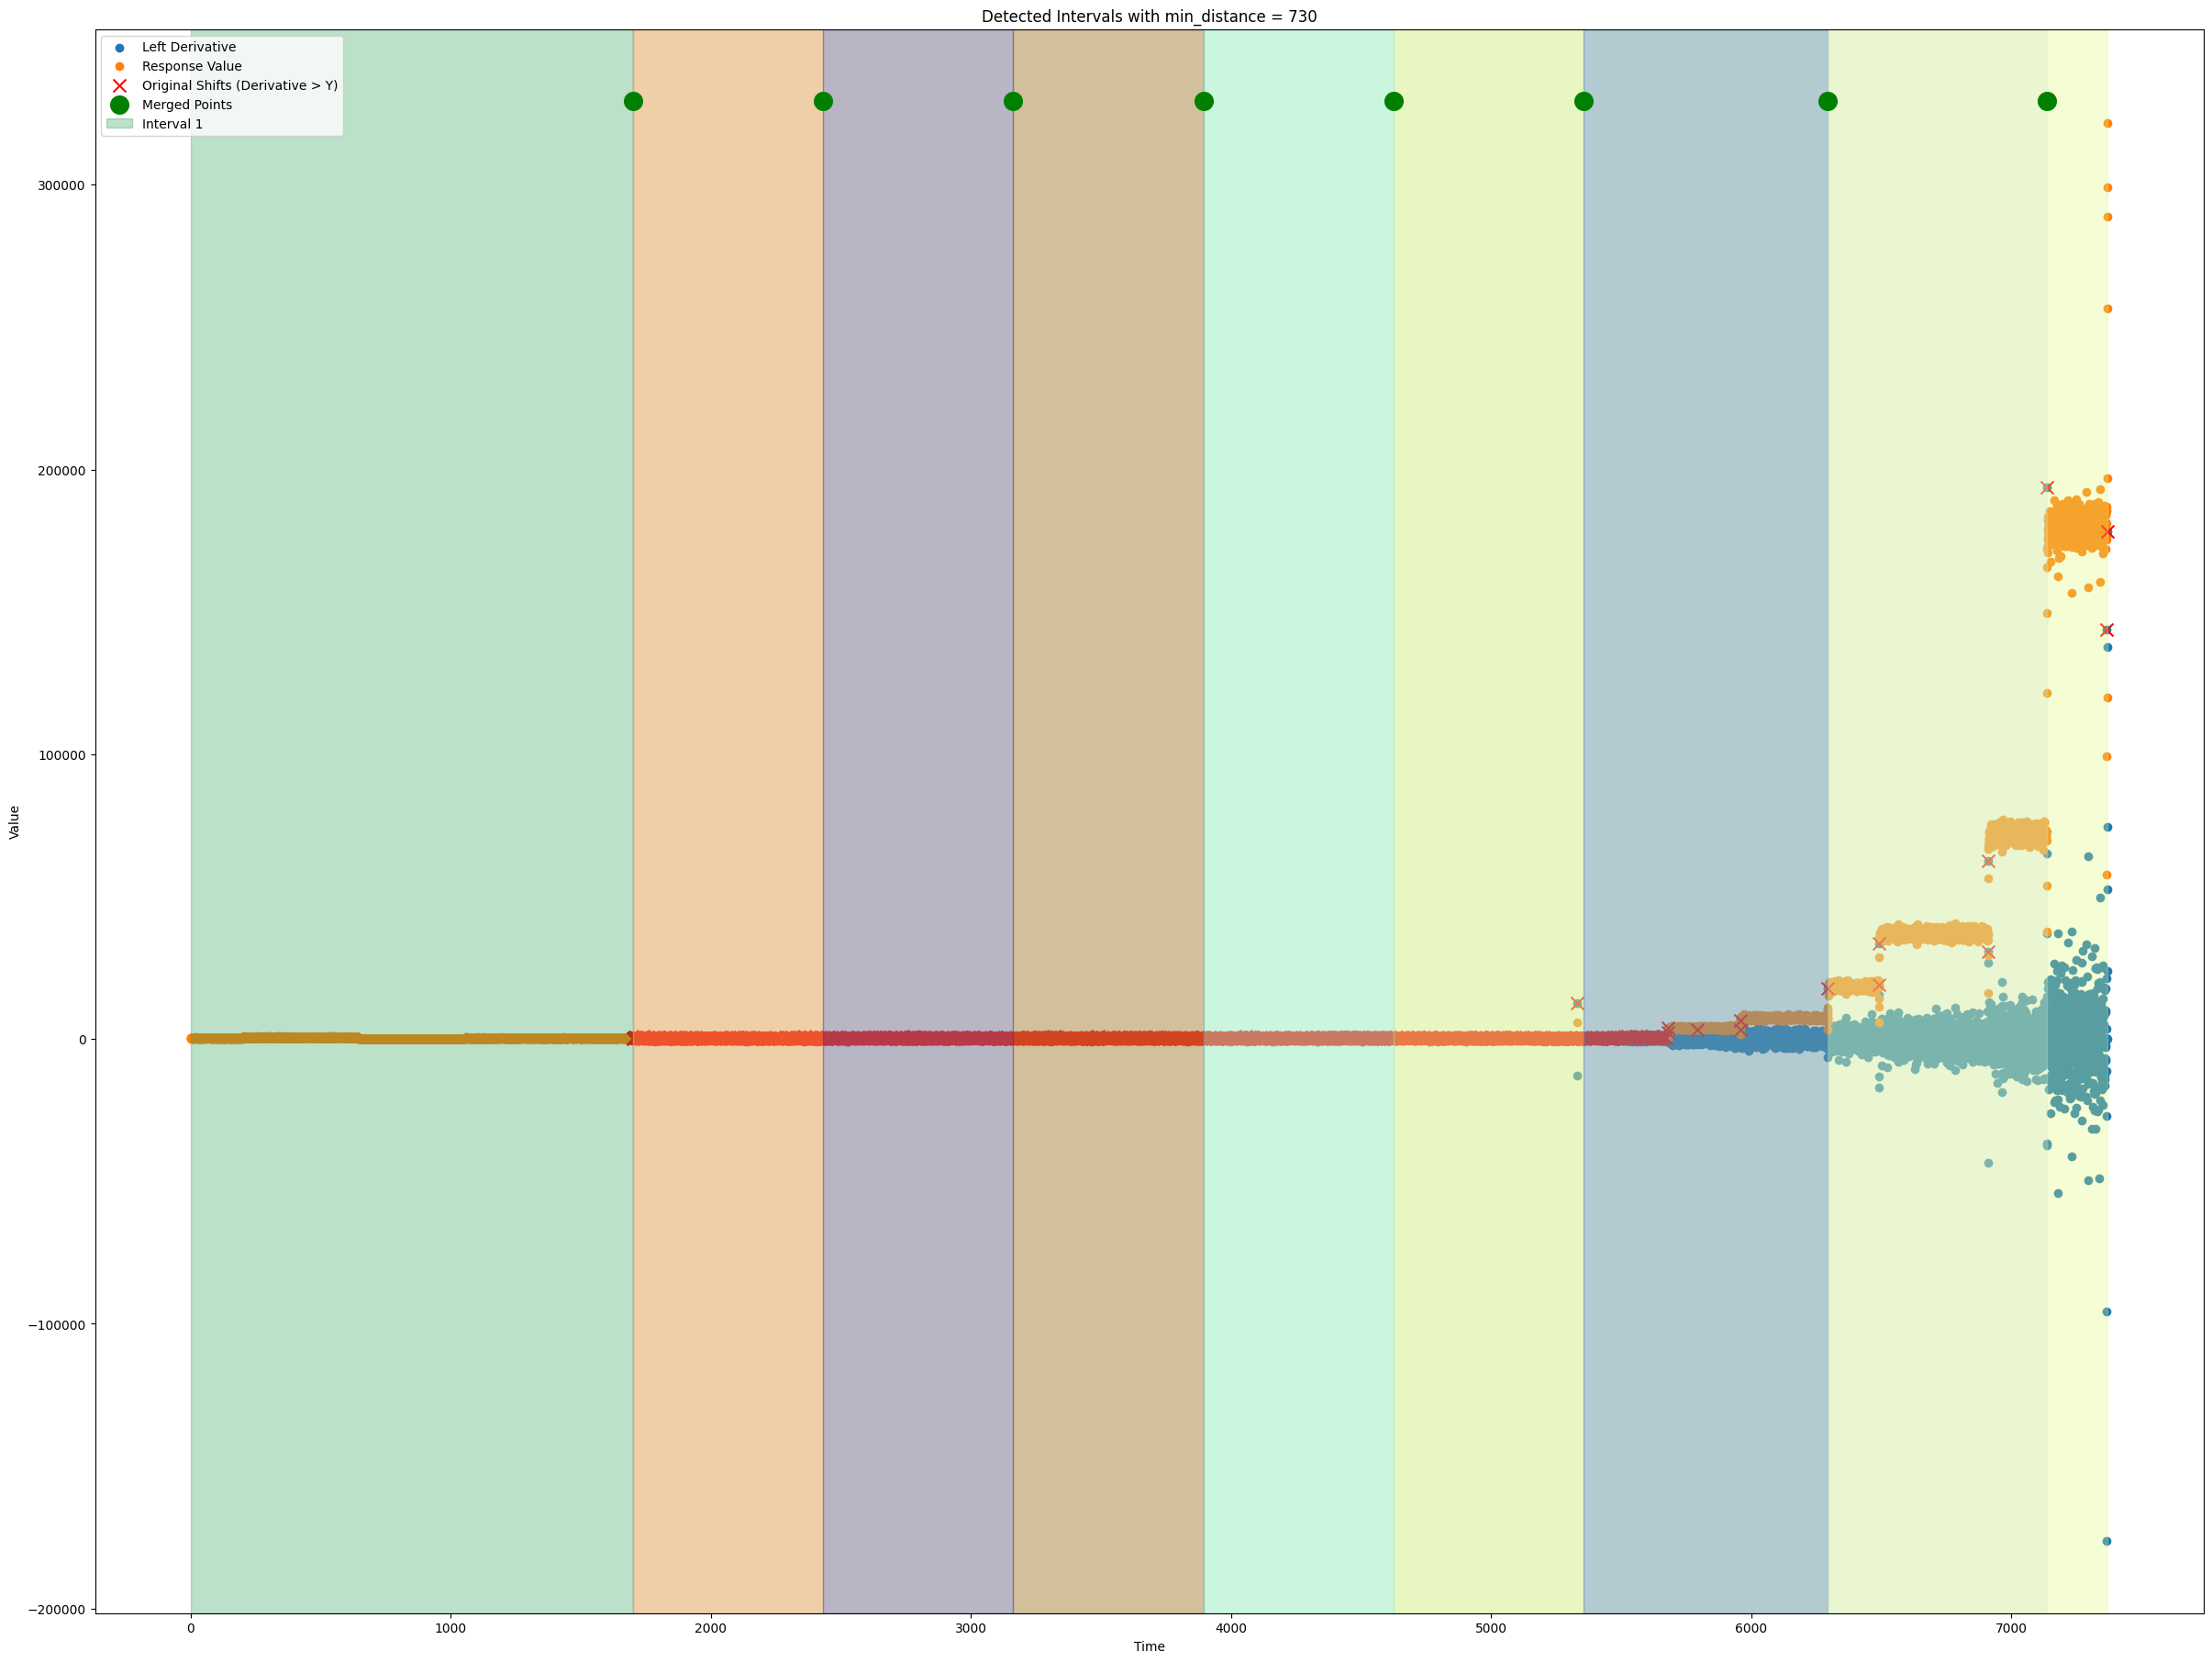


--- Testing with min_distance = 750 ---
Number of merged points for min_distance 750: 8
Detected intervals for min_distance 750:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2452.554),
 (np.float64(1699.982), np.float64(7370.625)),
 (2452.554, 3204.694),
 (3204.694, 3955.97),
 (3955.97, 4706.814),
 (4706.814, 5458.954),
 (5458.954, 6294.905),
 (6294.905, 7136.904)]

<Figure size 640x480 with 0 Axes>

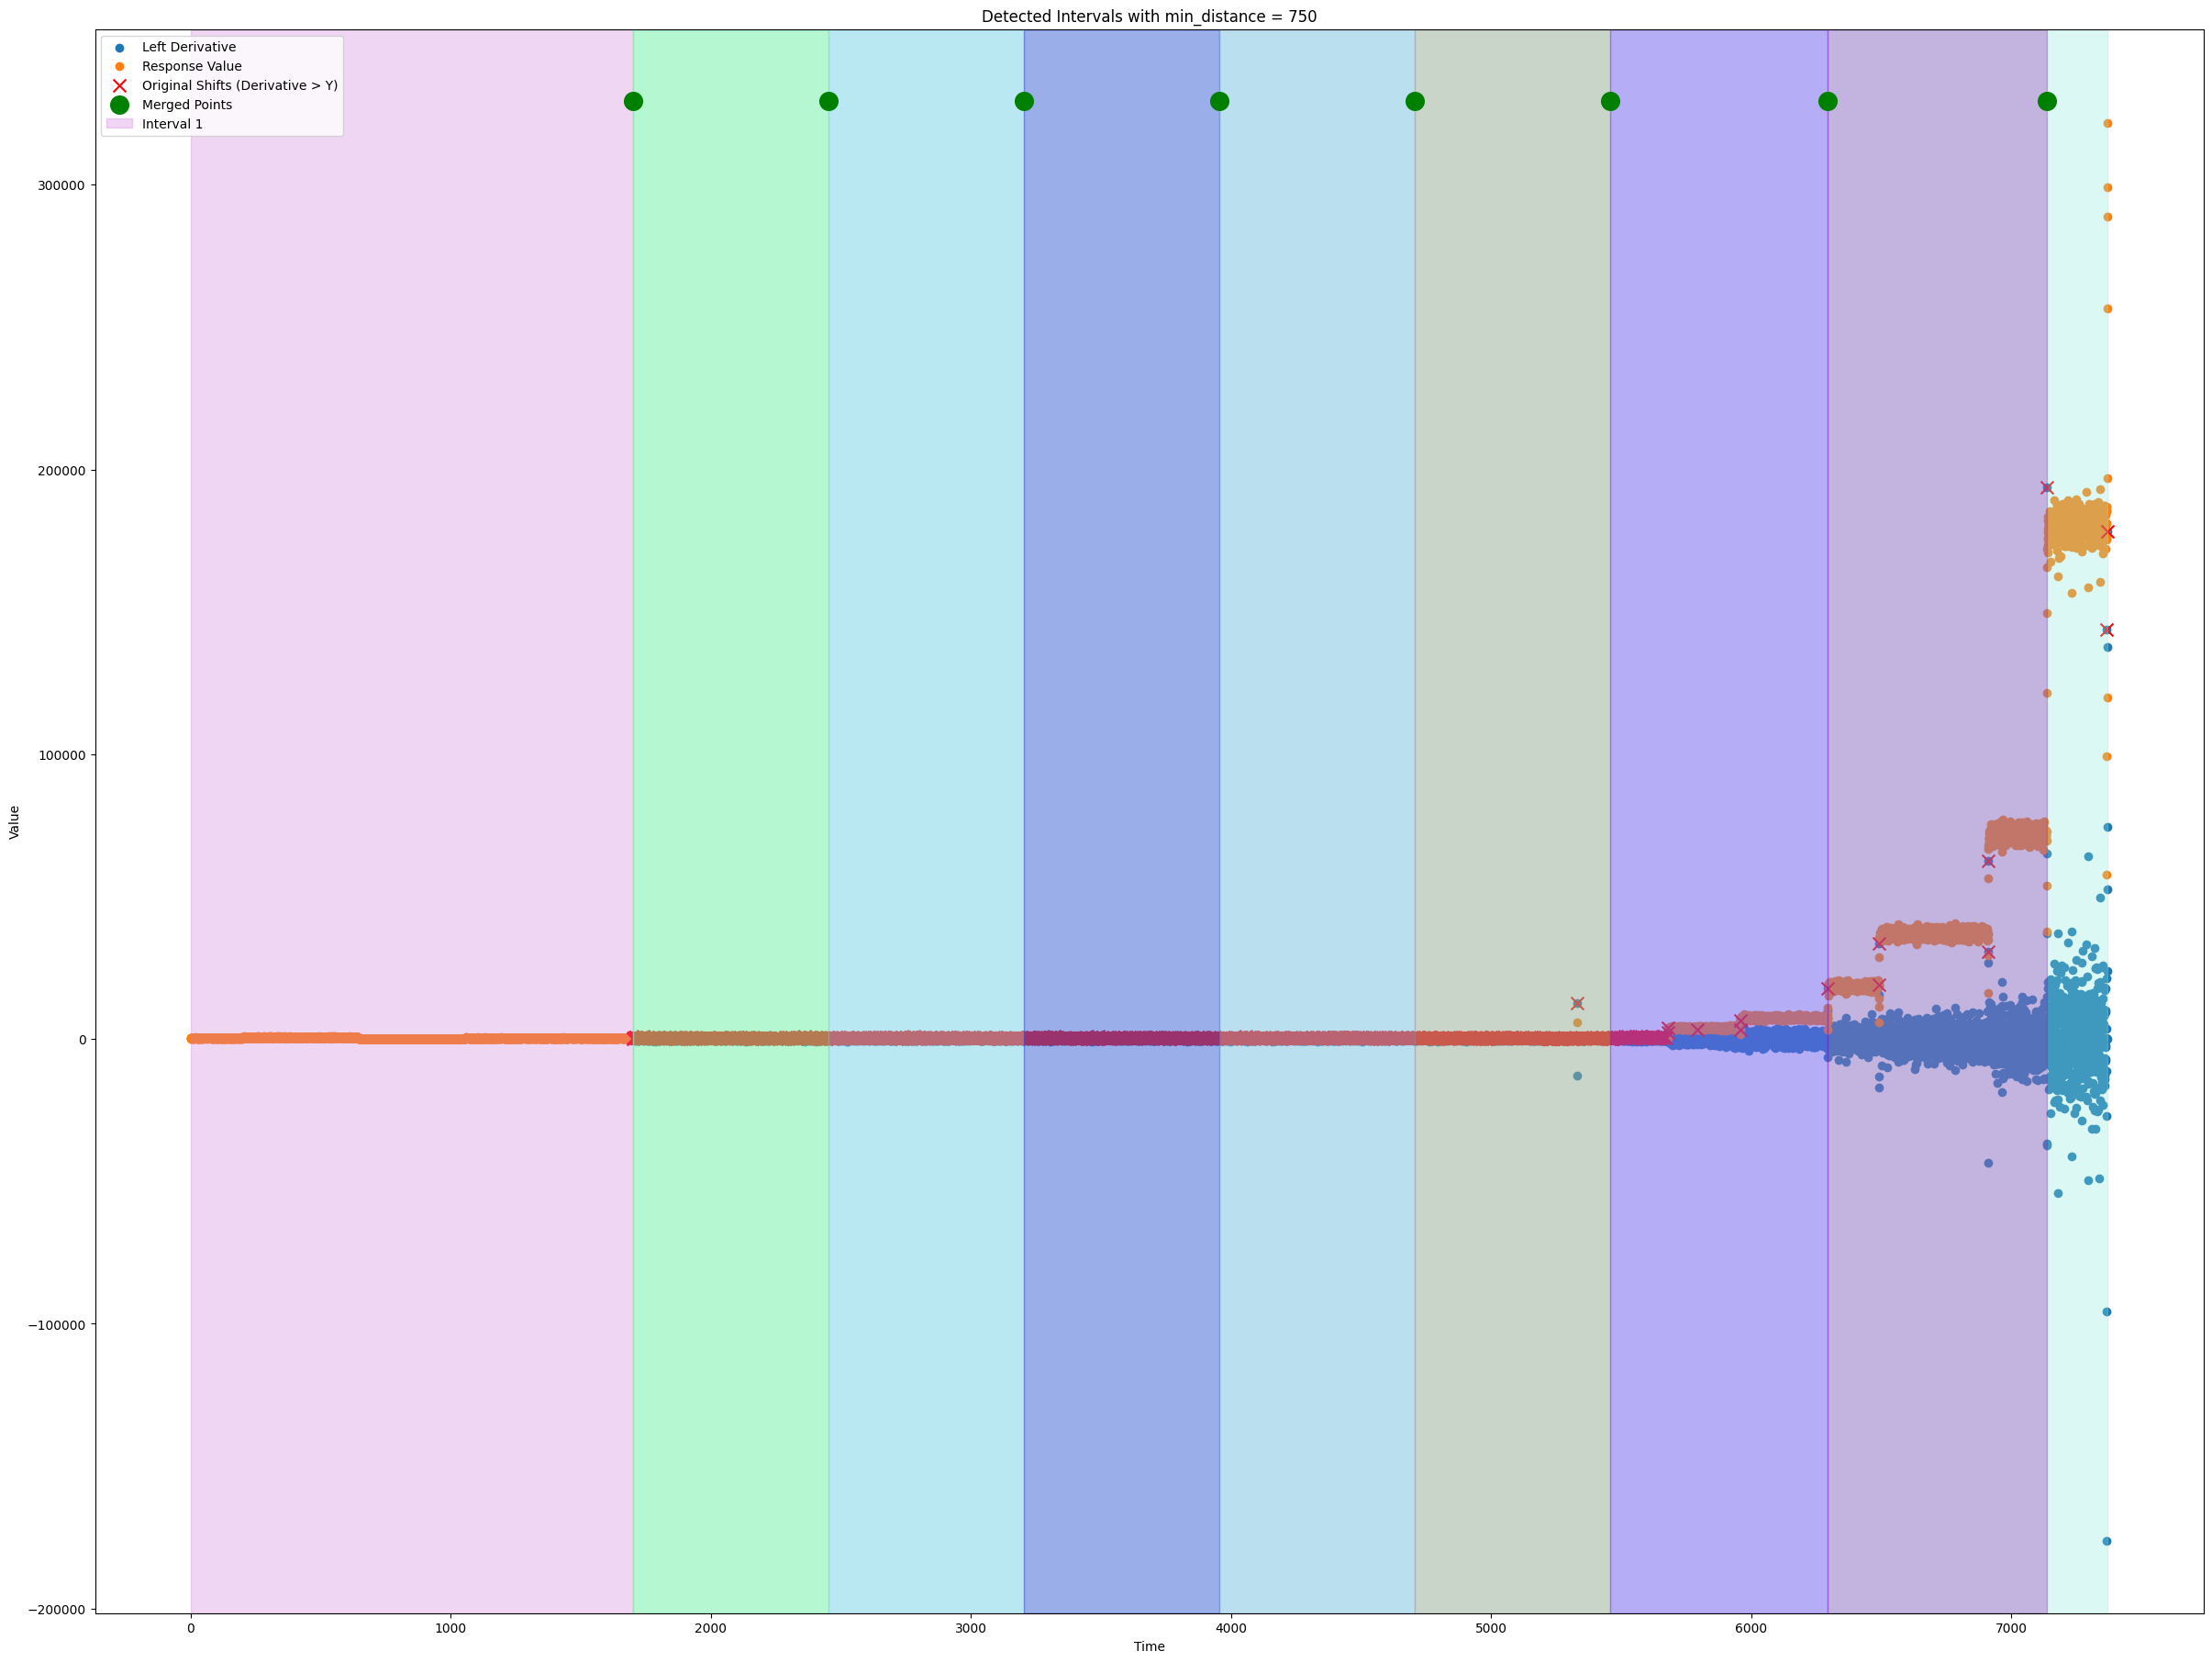


--- Testing with min_distance = 770 ---
Number of merged points for min_distance 770: 8
Detected intervals for min_distance 770:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2477.611),
 (np.float64(1699.982), np.float64(7370.625)),
 (2477.611, 3248.328),
 (3248.328, 4019.908),
 (4019.908, 4790.193),
 (4790.193, 5562.638),
 (5562.638, 6491.904),
 (6491.904, 7368.033)]

<Figure size 640x480 with 0 Axes>

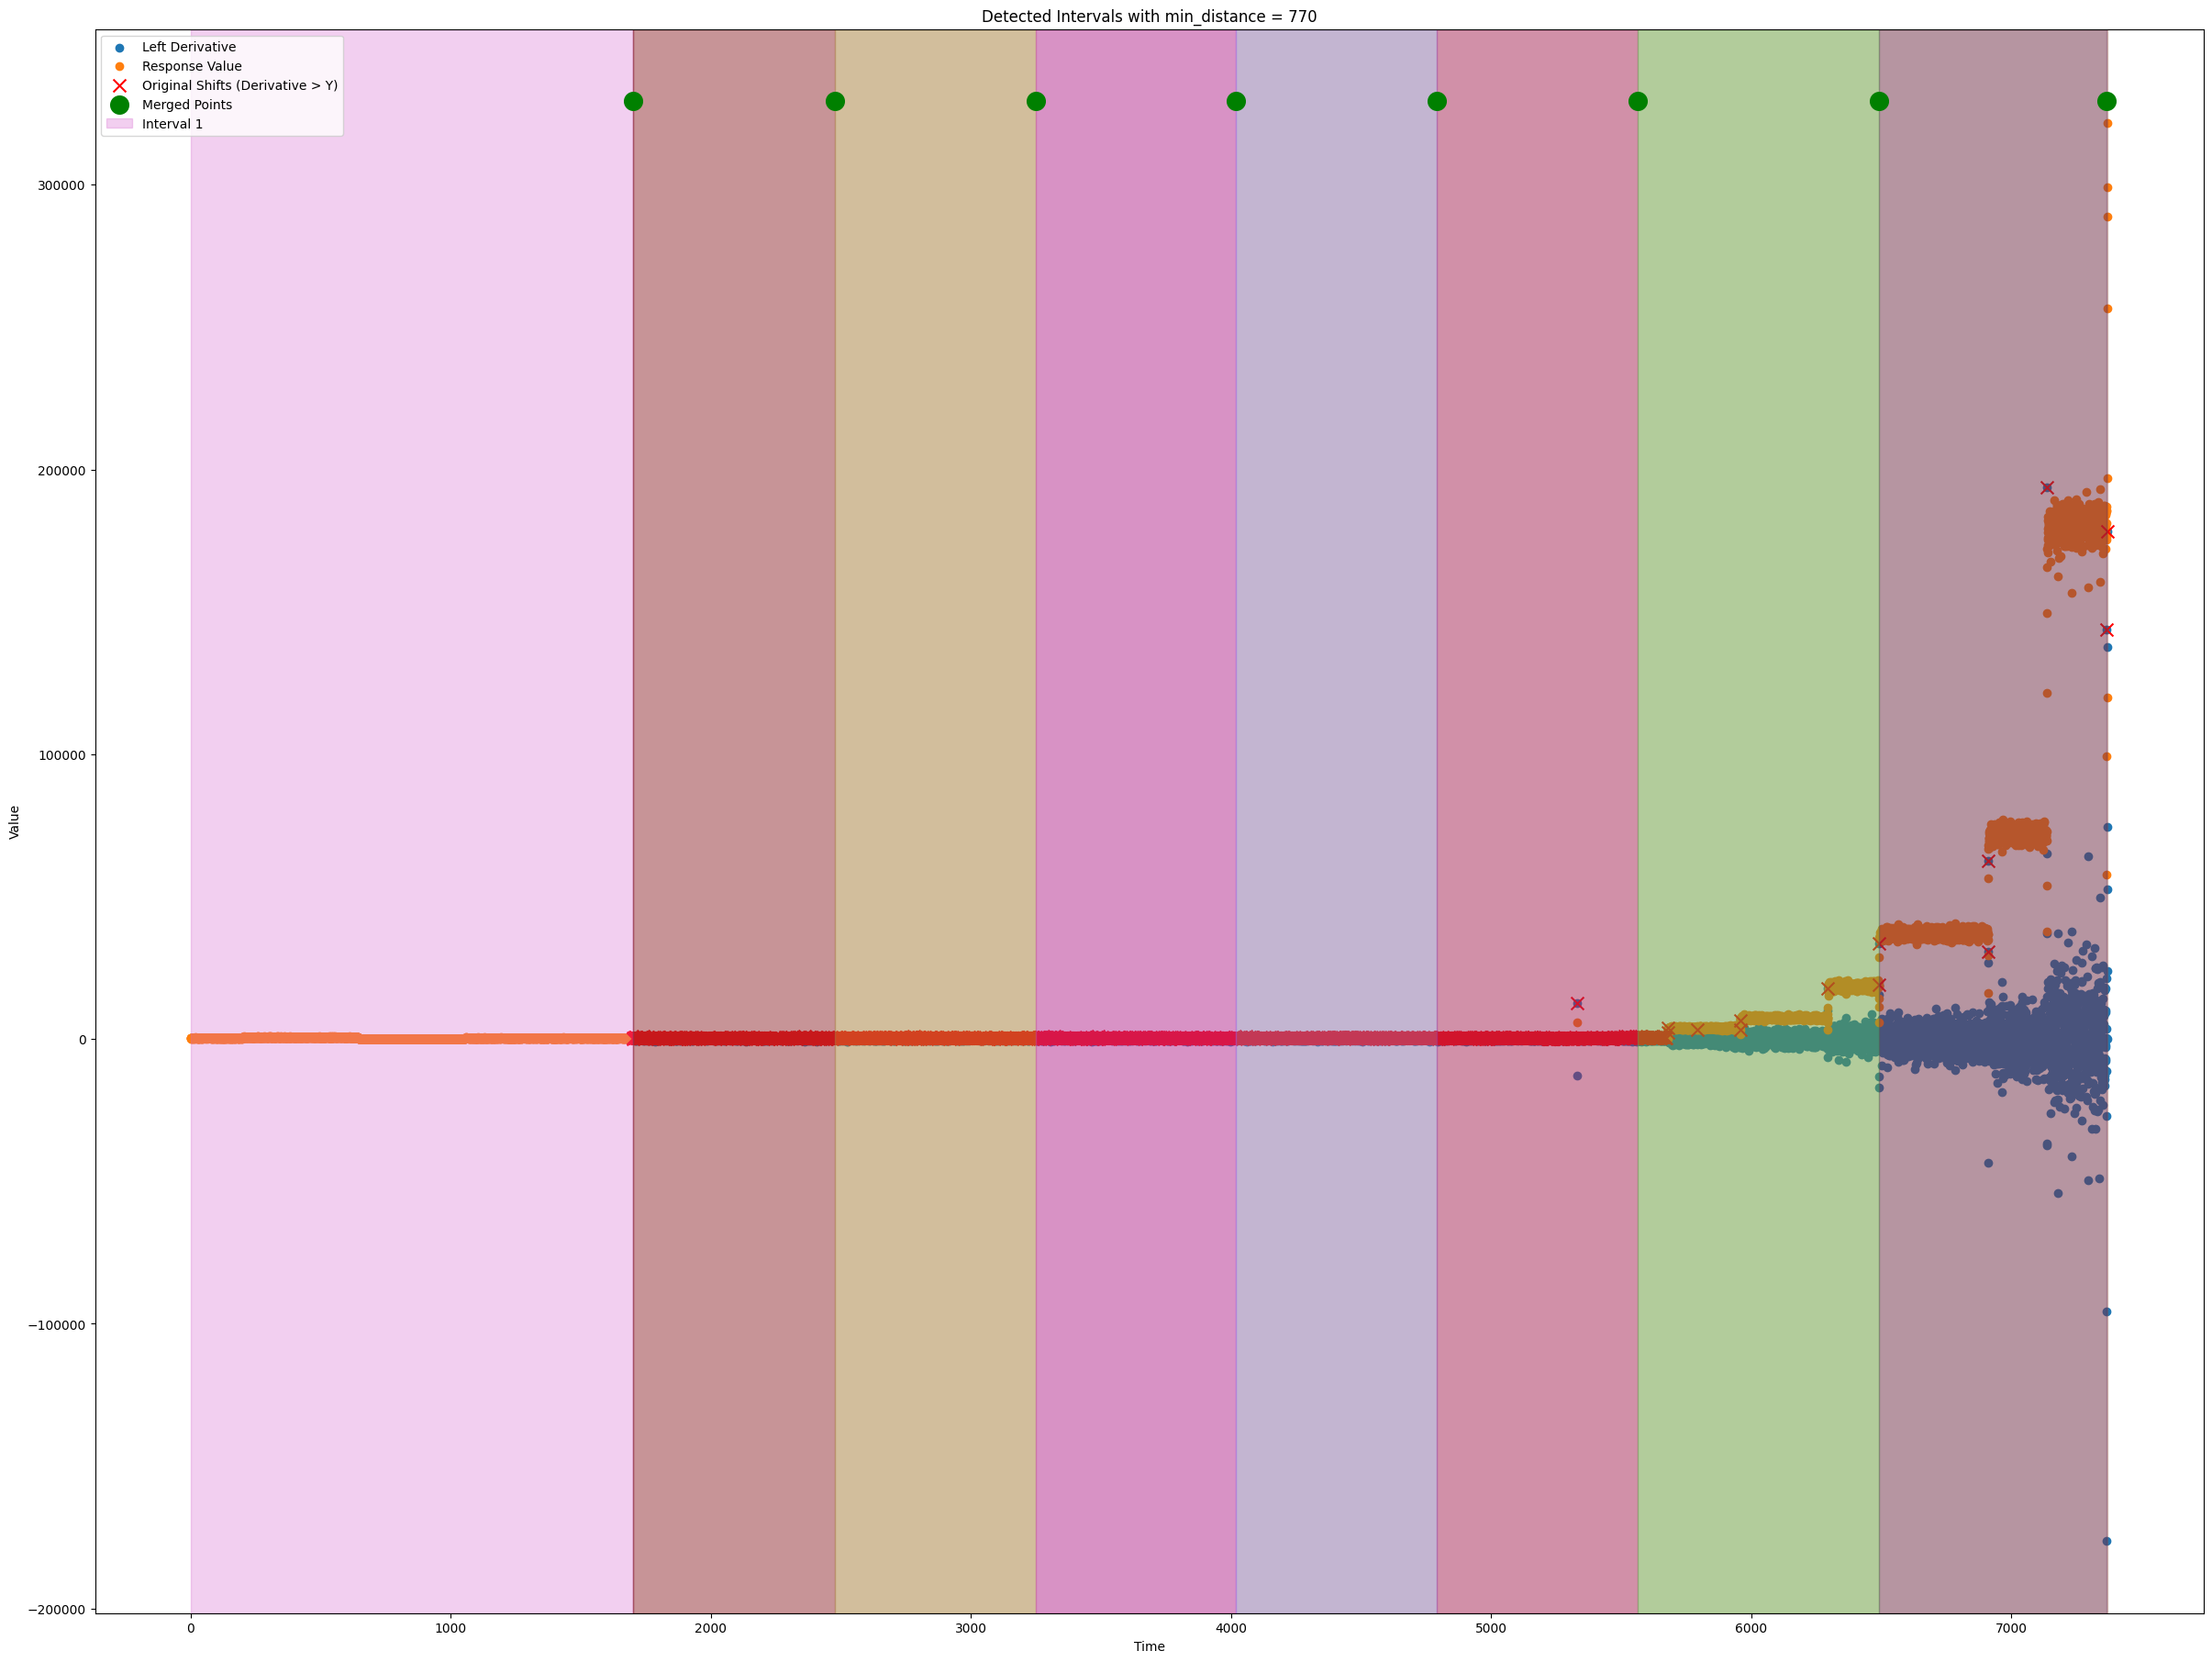


--- Testing with min_distance = 790 ---
Number of merged points for min_distance 790: 8
Detected intervals for min_distance 790:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2490.572),
 (np.float64(1699.982), np.float64(7370.625)),
 (2490.572, 3282.025),
 (3282.025, 4072.614),
 (4072.614, 4863.636),
 (4863.636, 5655.953),
 (5655.953, 6491.904),
 (6491.904, 7368.033)]

<Figure size 640x480 with 0 Axes>

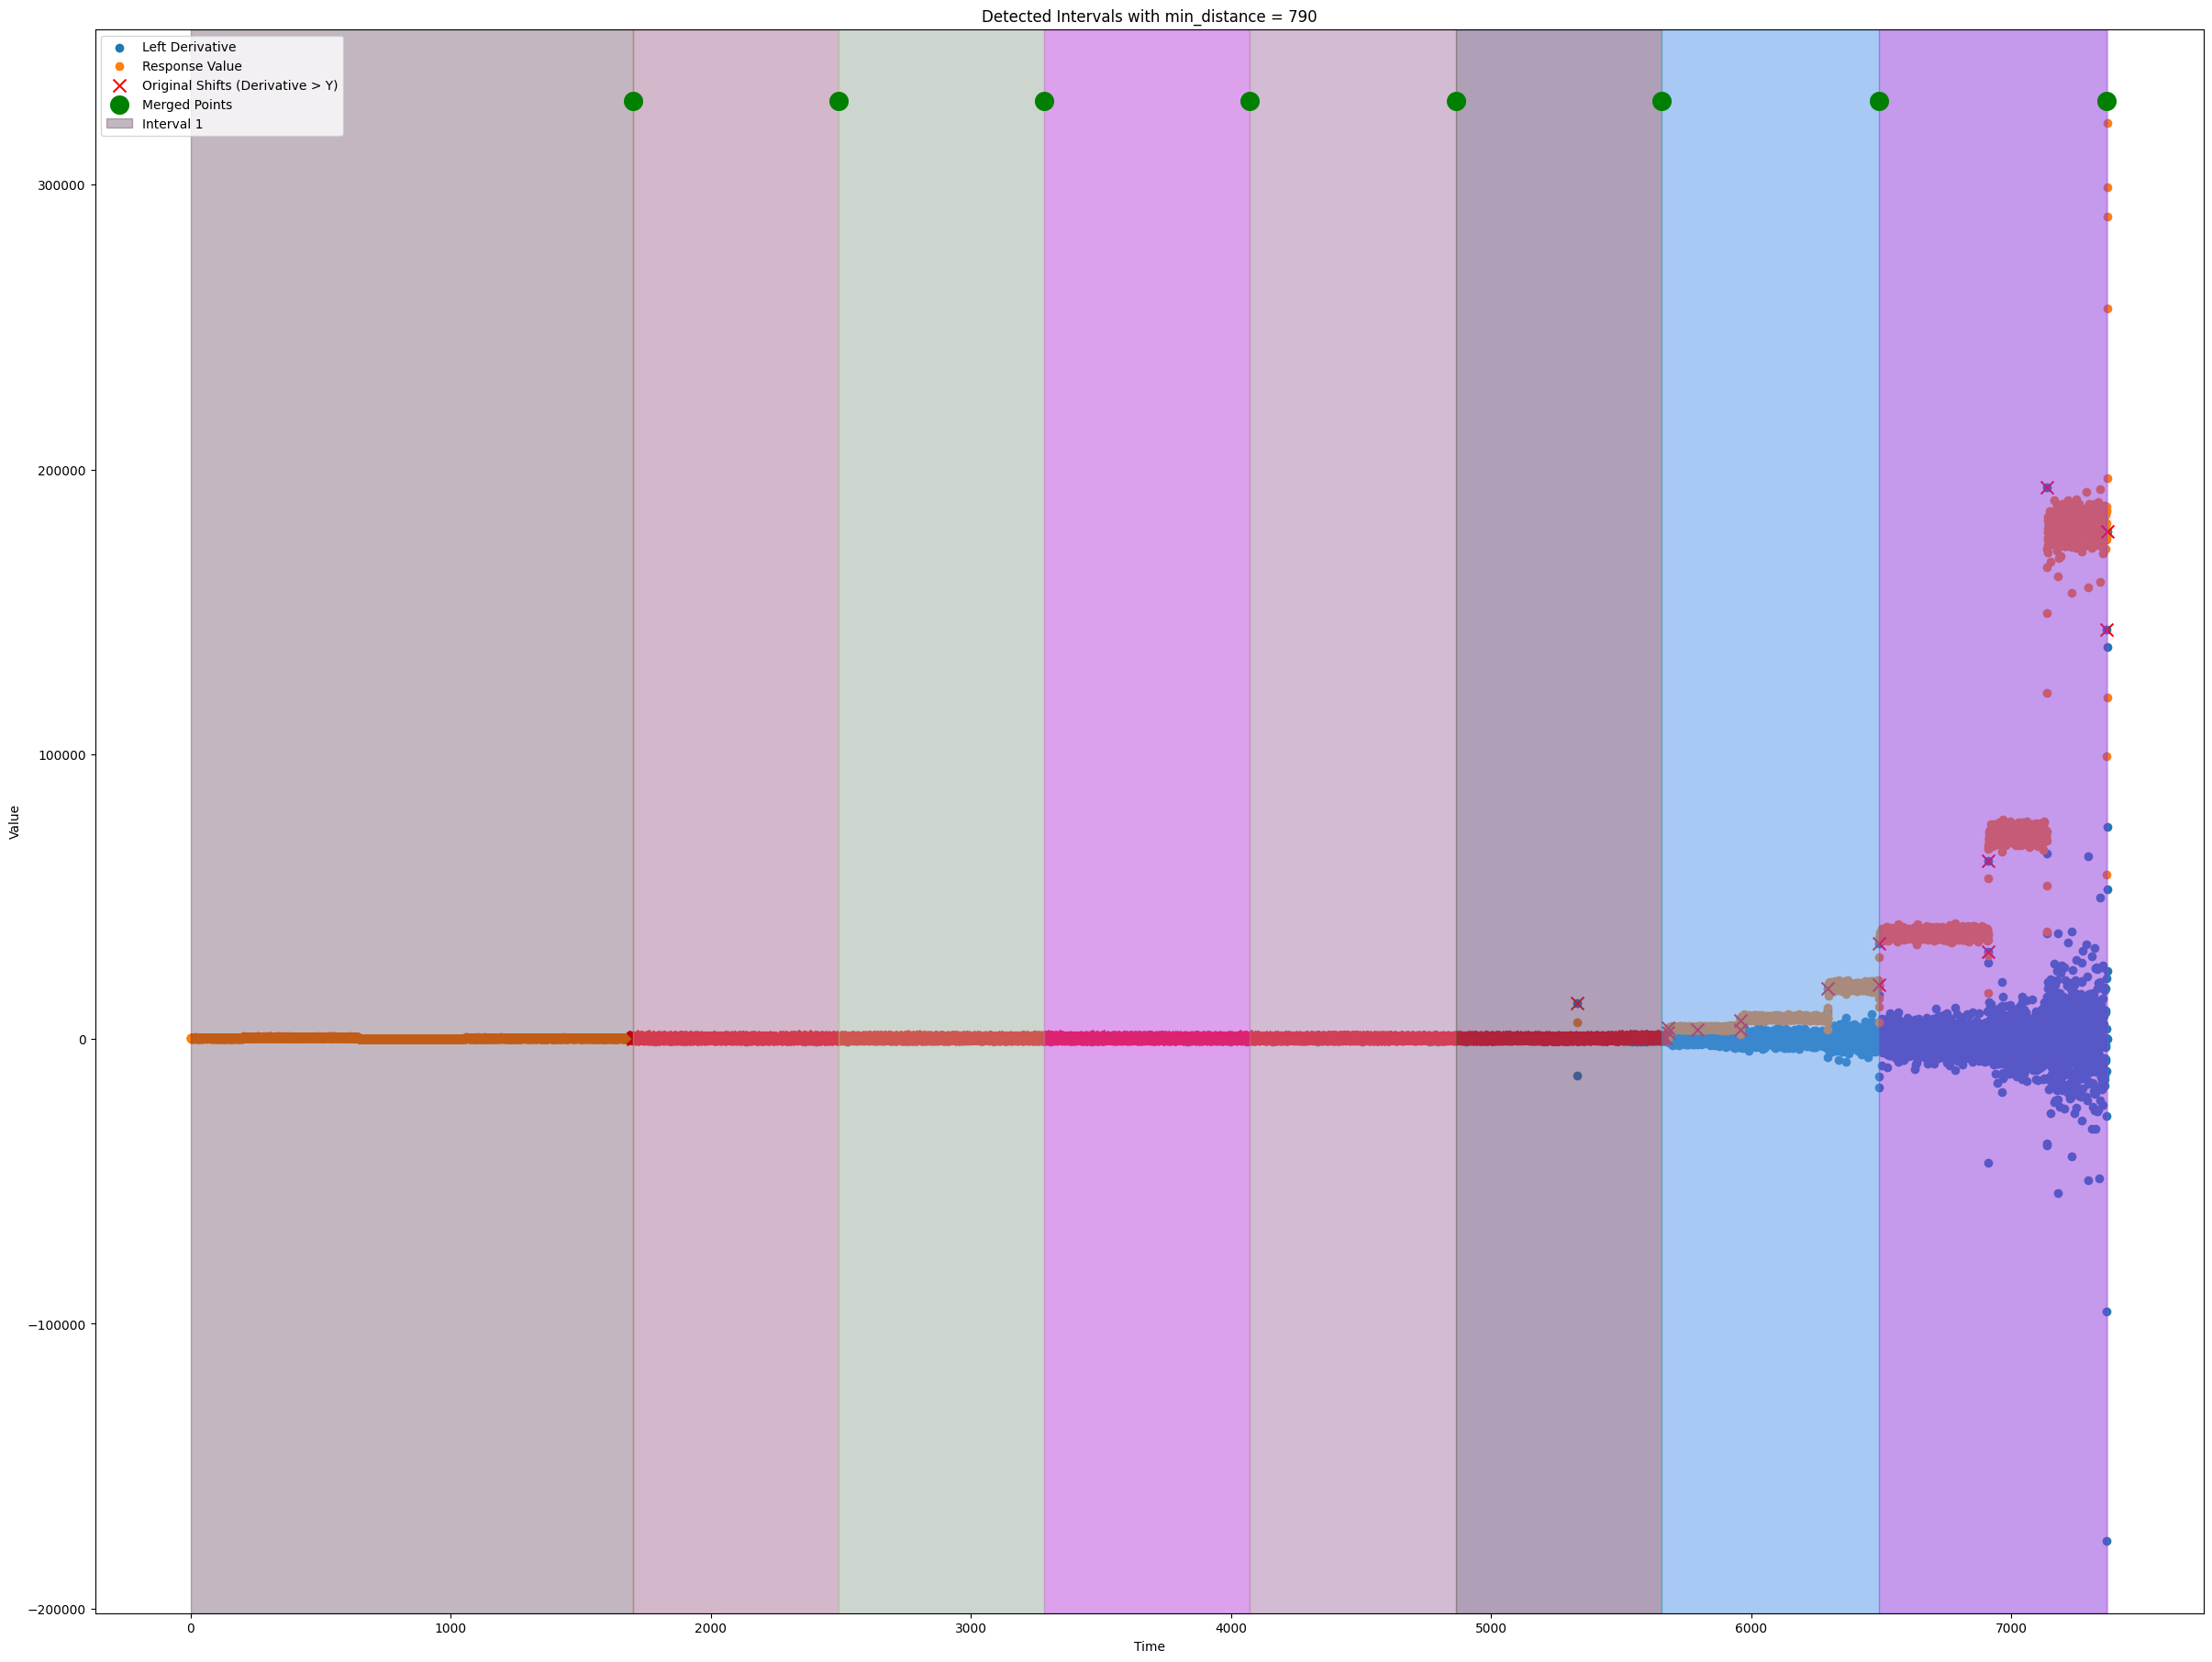


--- Testing with min_distance = 810 ---
Number of merged points for min_distance 810: 7
Detected intervals for min_distance 810:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2510.013),
 (np.float64(1699.982), np.float64(7370.625)),
 (2510.013, 3321.339),
 (3321.339, 4131.801),
 (4131.801, 4943.127),
 (4943.127, 5792.902),
 (5792.902, 6910.96)]

<Figure size 640x480 with 0 Axes>

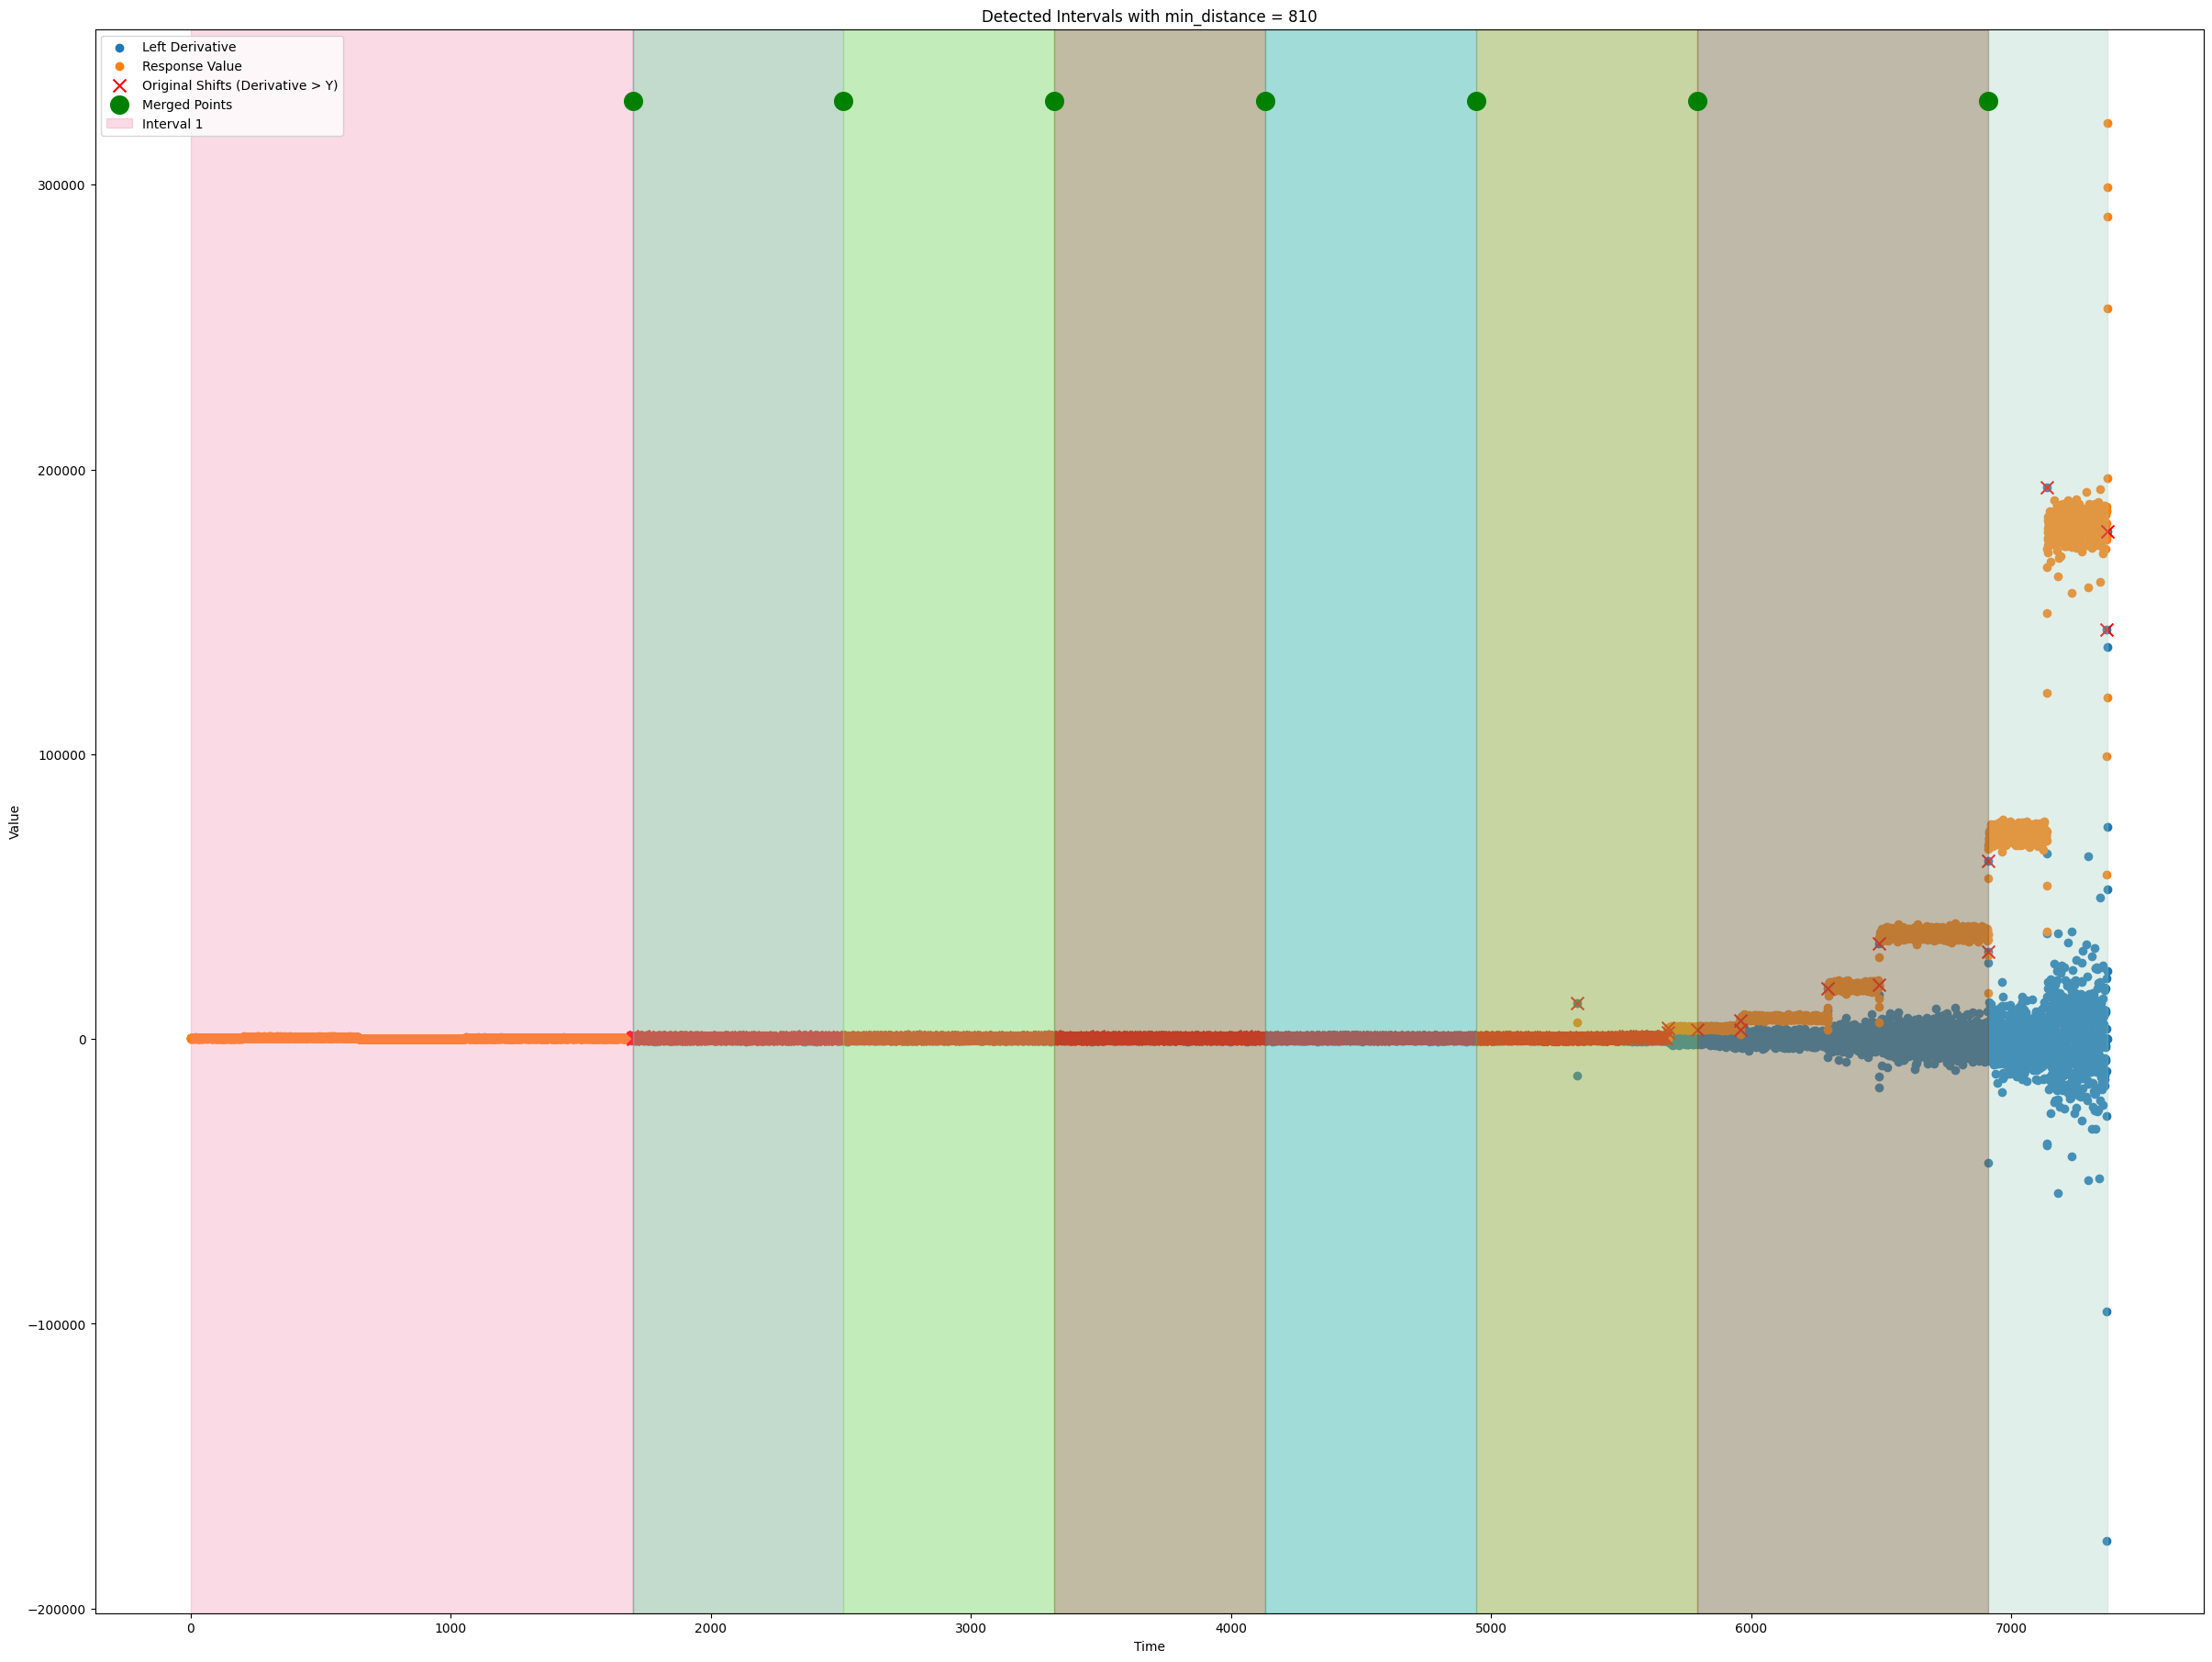


--- Testing with min_distance = 830 ---
Number of merged points for min_distance 830: 7
Detected intervals for min_distance 830:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2530.749),
 (np.float64(1699.982), np.float64(7370.625)),
 (2530.749, 3361.516),
 (3361.516, 4191.851),
 (4191.851, 5023.05),
 (5023.05, 5957.068),
 (5957.068, 6910.96)]

<Figure size 640x480 with 0 Axes>

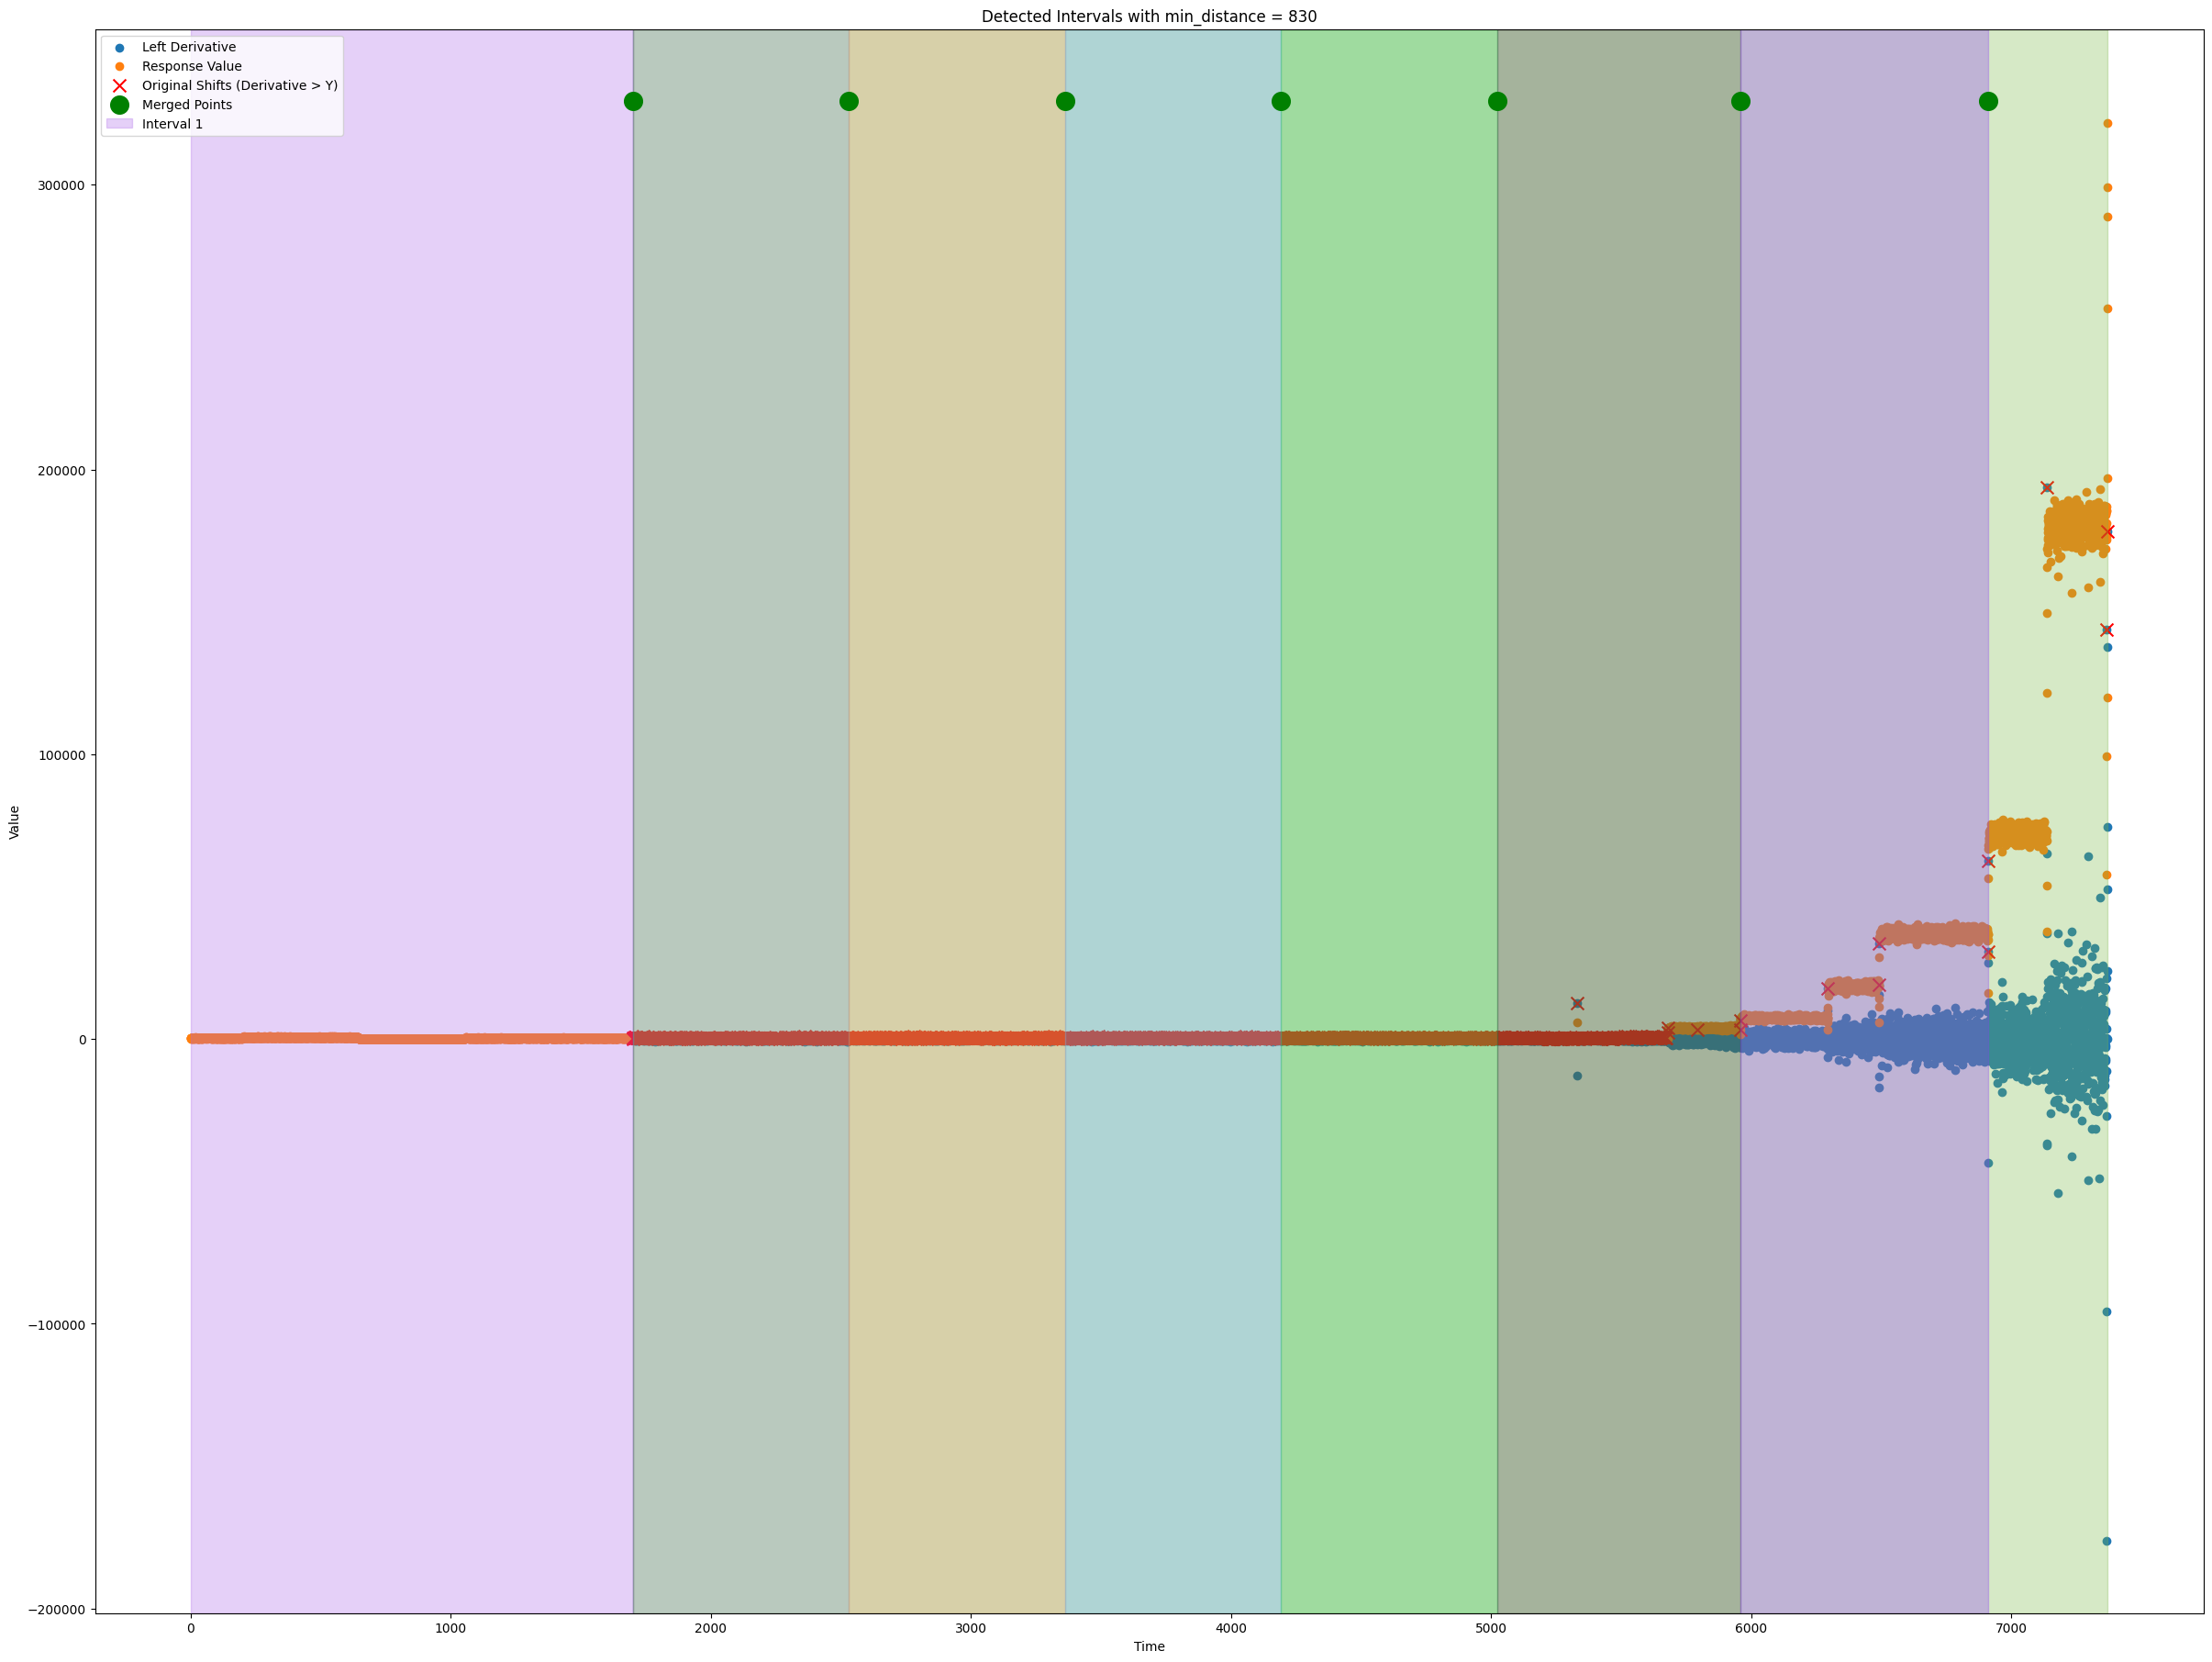


--- Testing with min_distance = 850 ---
Number of merged points for min_distance 850: 7
Detected intervals for min_distance 850:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2550.622),
 (np.float64(1699.982), np.float64(7370.625)),
 (2550.622, 3402.126),
 (3402.126, 4252.333),
 (4252.333, 5105.565),
 (5105.565, 5957.068),
 (5957.068, 6910.96)]

<Figure size 640x480 with 0 Axes>

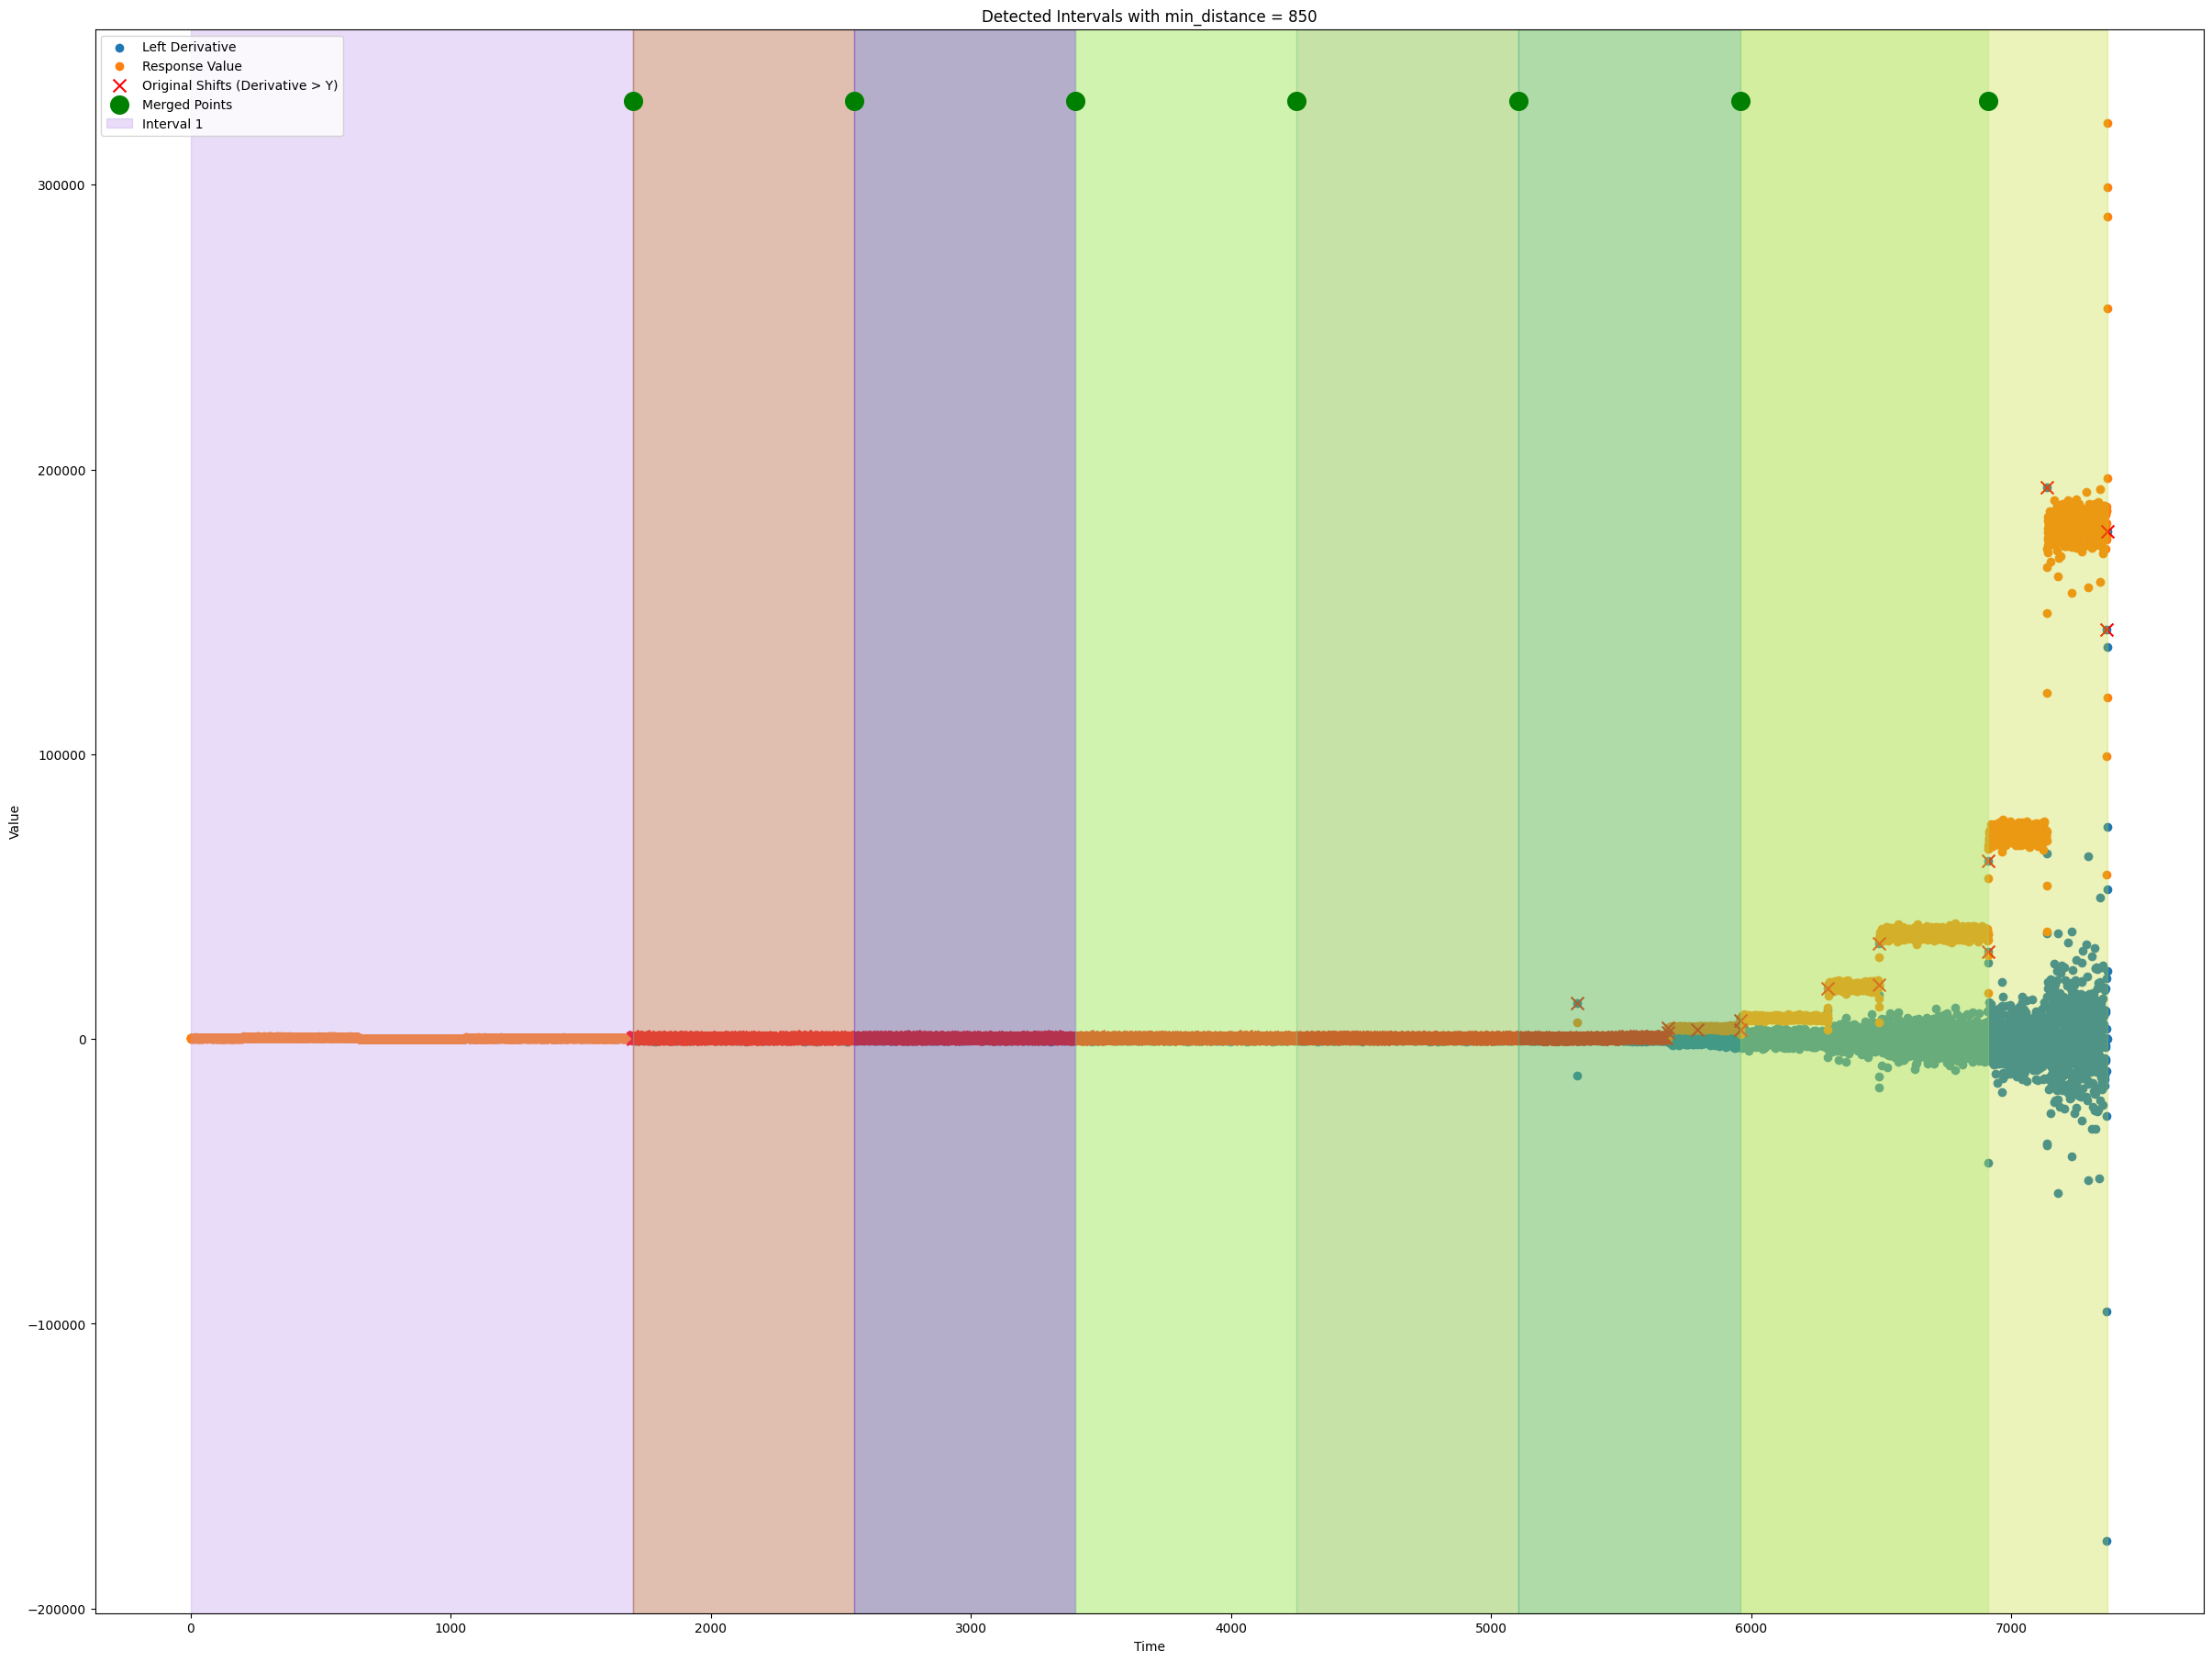


--- Testing with min_distance = 870 ---
Number of merged points for min_distance 870: 7
Detected intervals for min_distance 870:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2573.519),
 (np.float64(1699.982), np.float64(7370.625)),
 (2573.519, 3444.463),
 (3444.463, 4314.543),
 (4314.543, 5186.352),
 (5186.352, 6294.905),
 (6294.905, 7368.033)]

<Figure size 640x480 with 0 Axes>

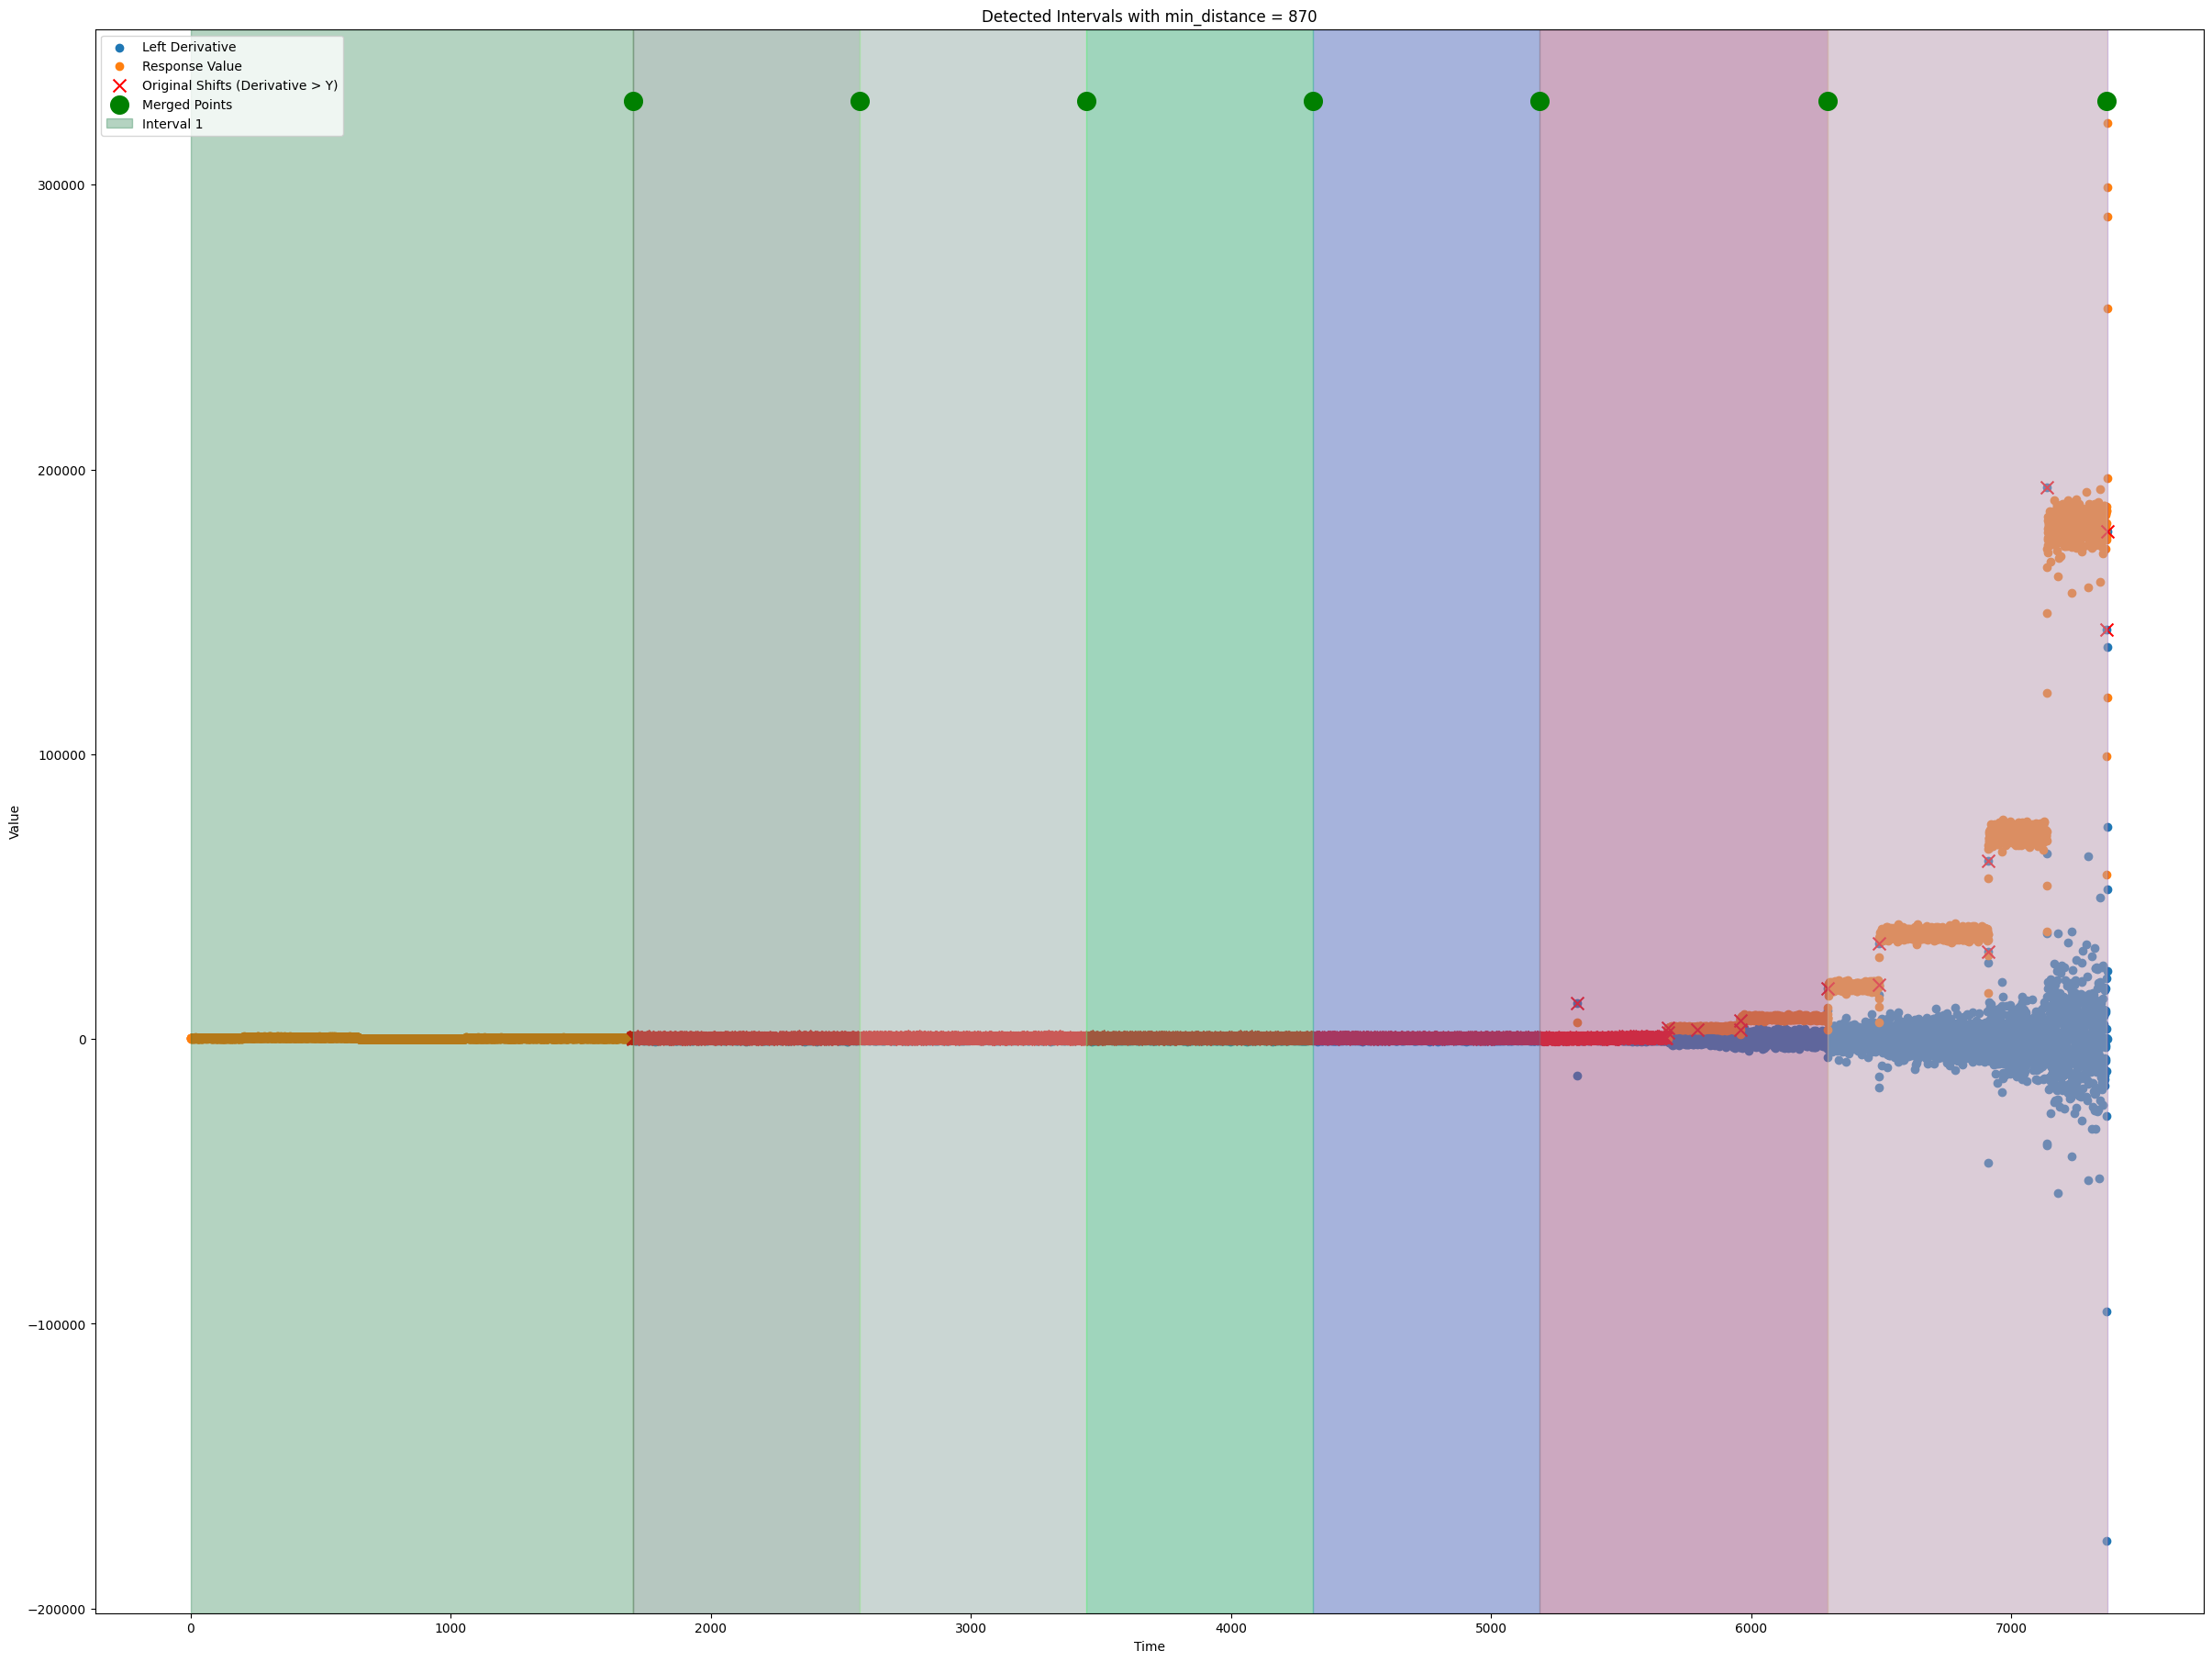


--- Testing with min_distance = 890 ---
Number of merged points for min_distance 890: 7
Detected intervals for min_distance 890:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2590.8),
 (np.float64(1699.982), np.float64(7370.625)),
 (2590.8, 3481.184),
 (3481.184, 4378.482),
 (4378.482, 5268.867),
 (5268.867, 6294.905),
 (6294.905, 7368.033)]

<Figure size 640x480 with 0 Axes>

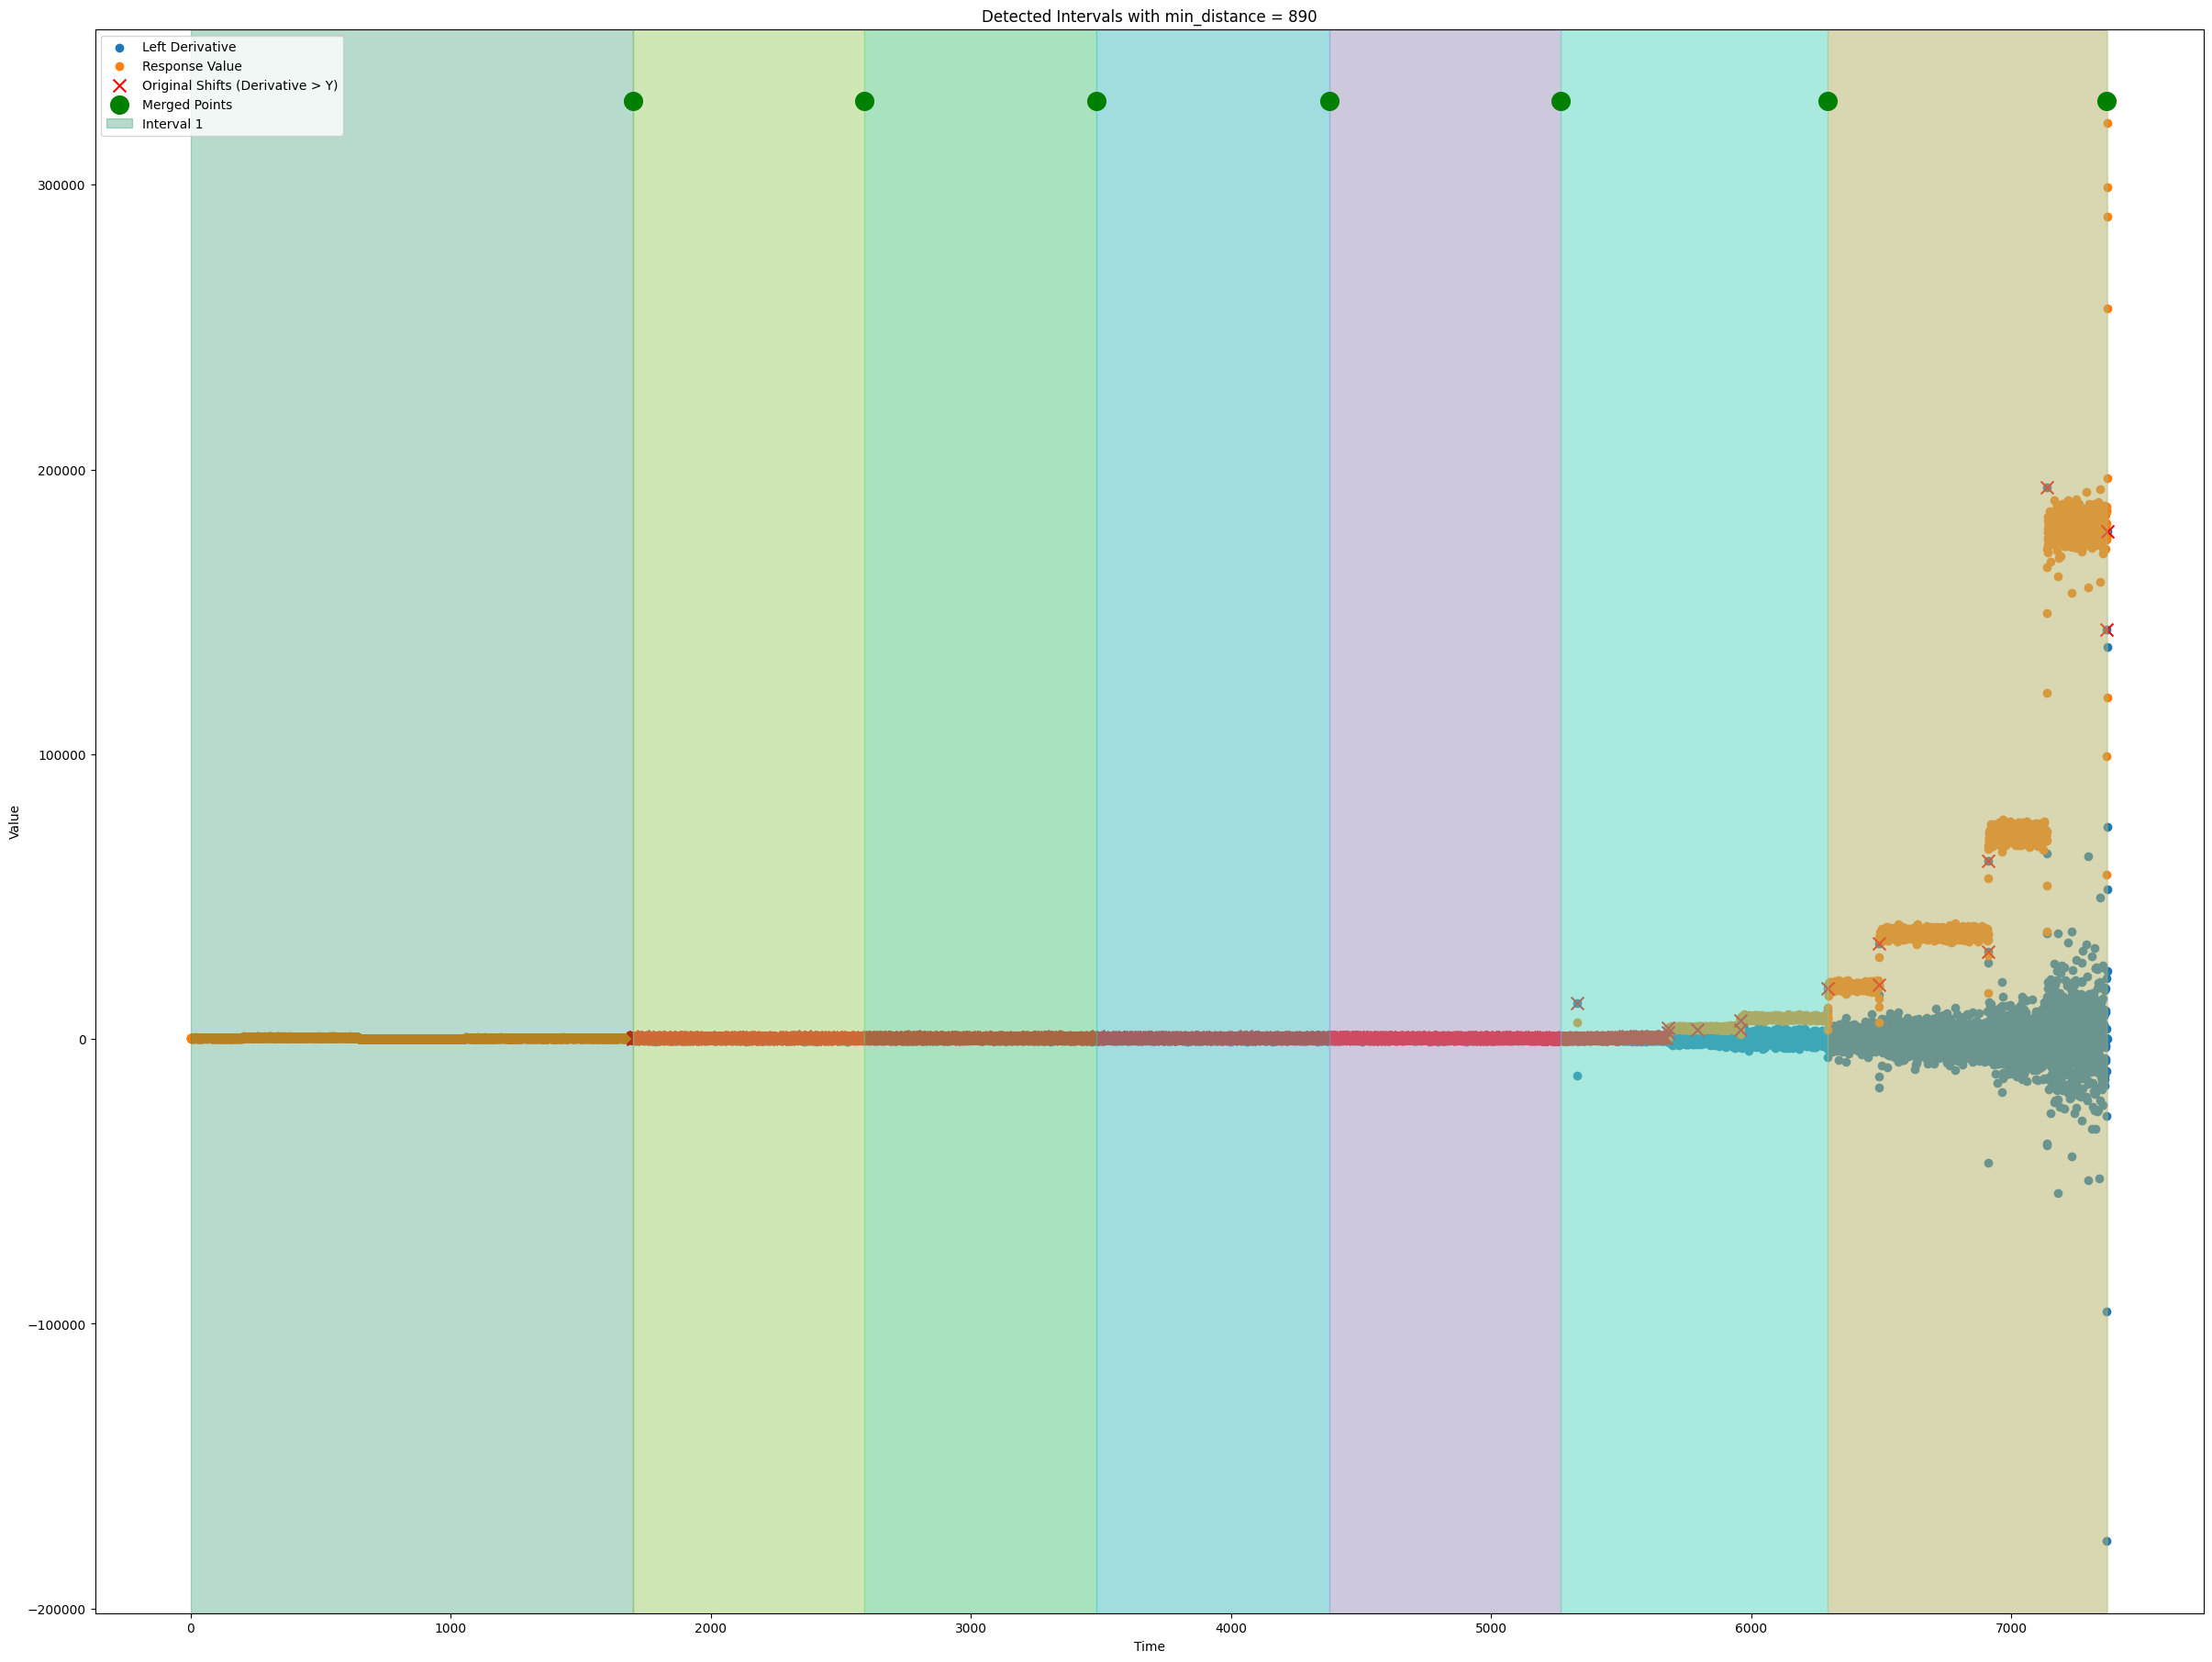


--- Testing with min_distance = 910 ---
Number of merged points for min_distance 910: 7
Detected intervals for min_distance 910:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2610.672),
 (np.float64(1699.982), np.float64(7370.625)),
 (2610.672, 3521.362),
 (3521.362, 4431.62),
 (4431.62, 5343.173),
 (5343.173, 6294.905),
 (6294.905, 7368.033)]

<Figure size 640x480 with 0 Axes>

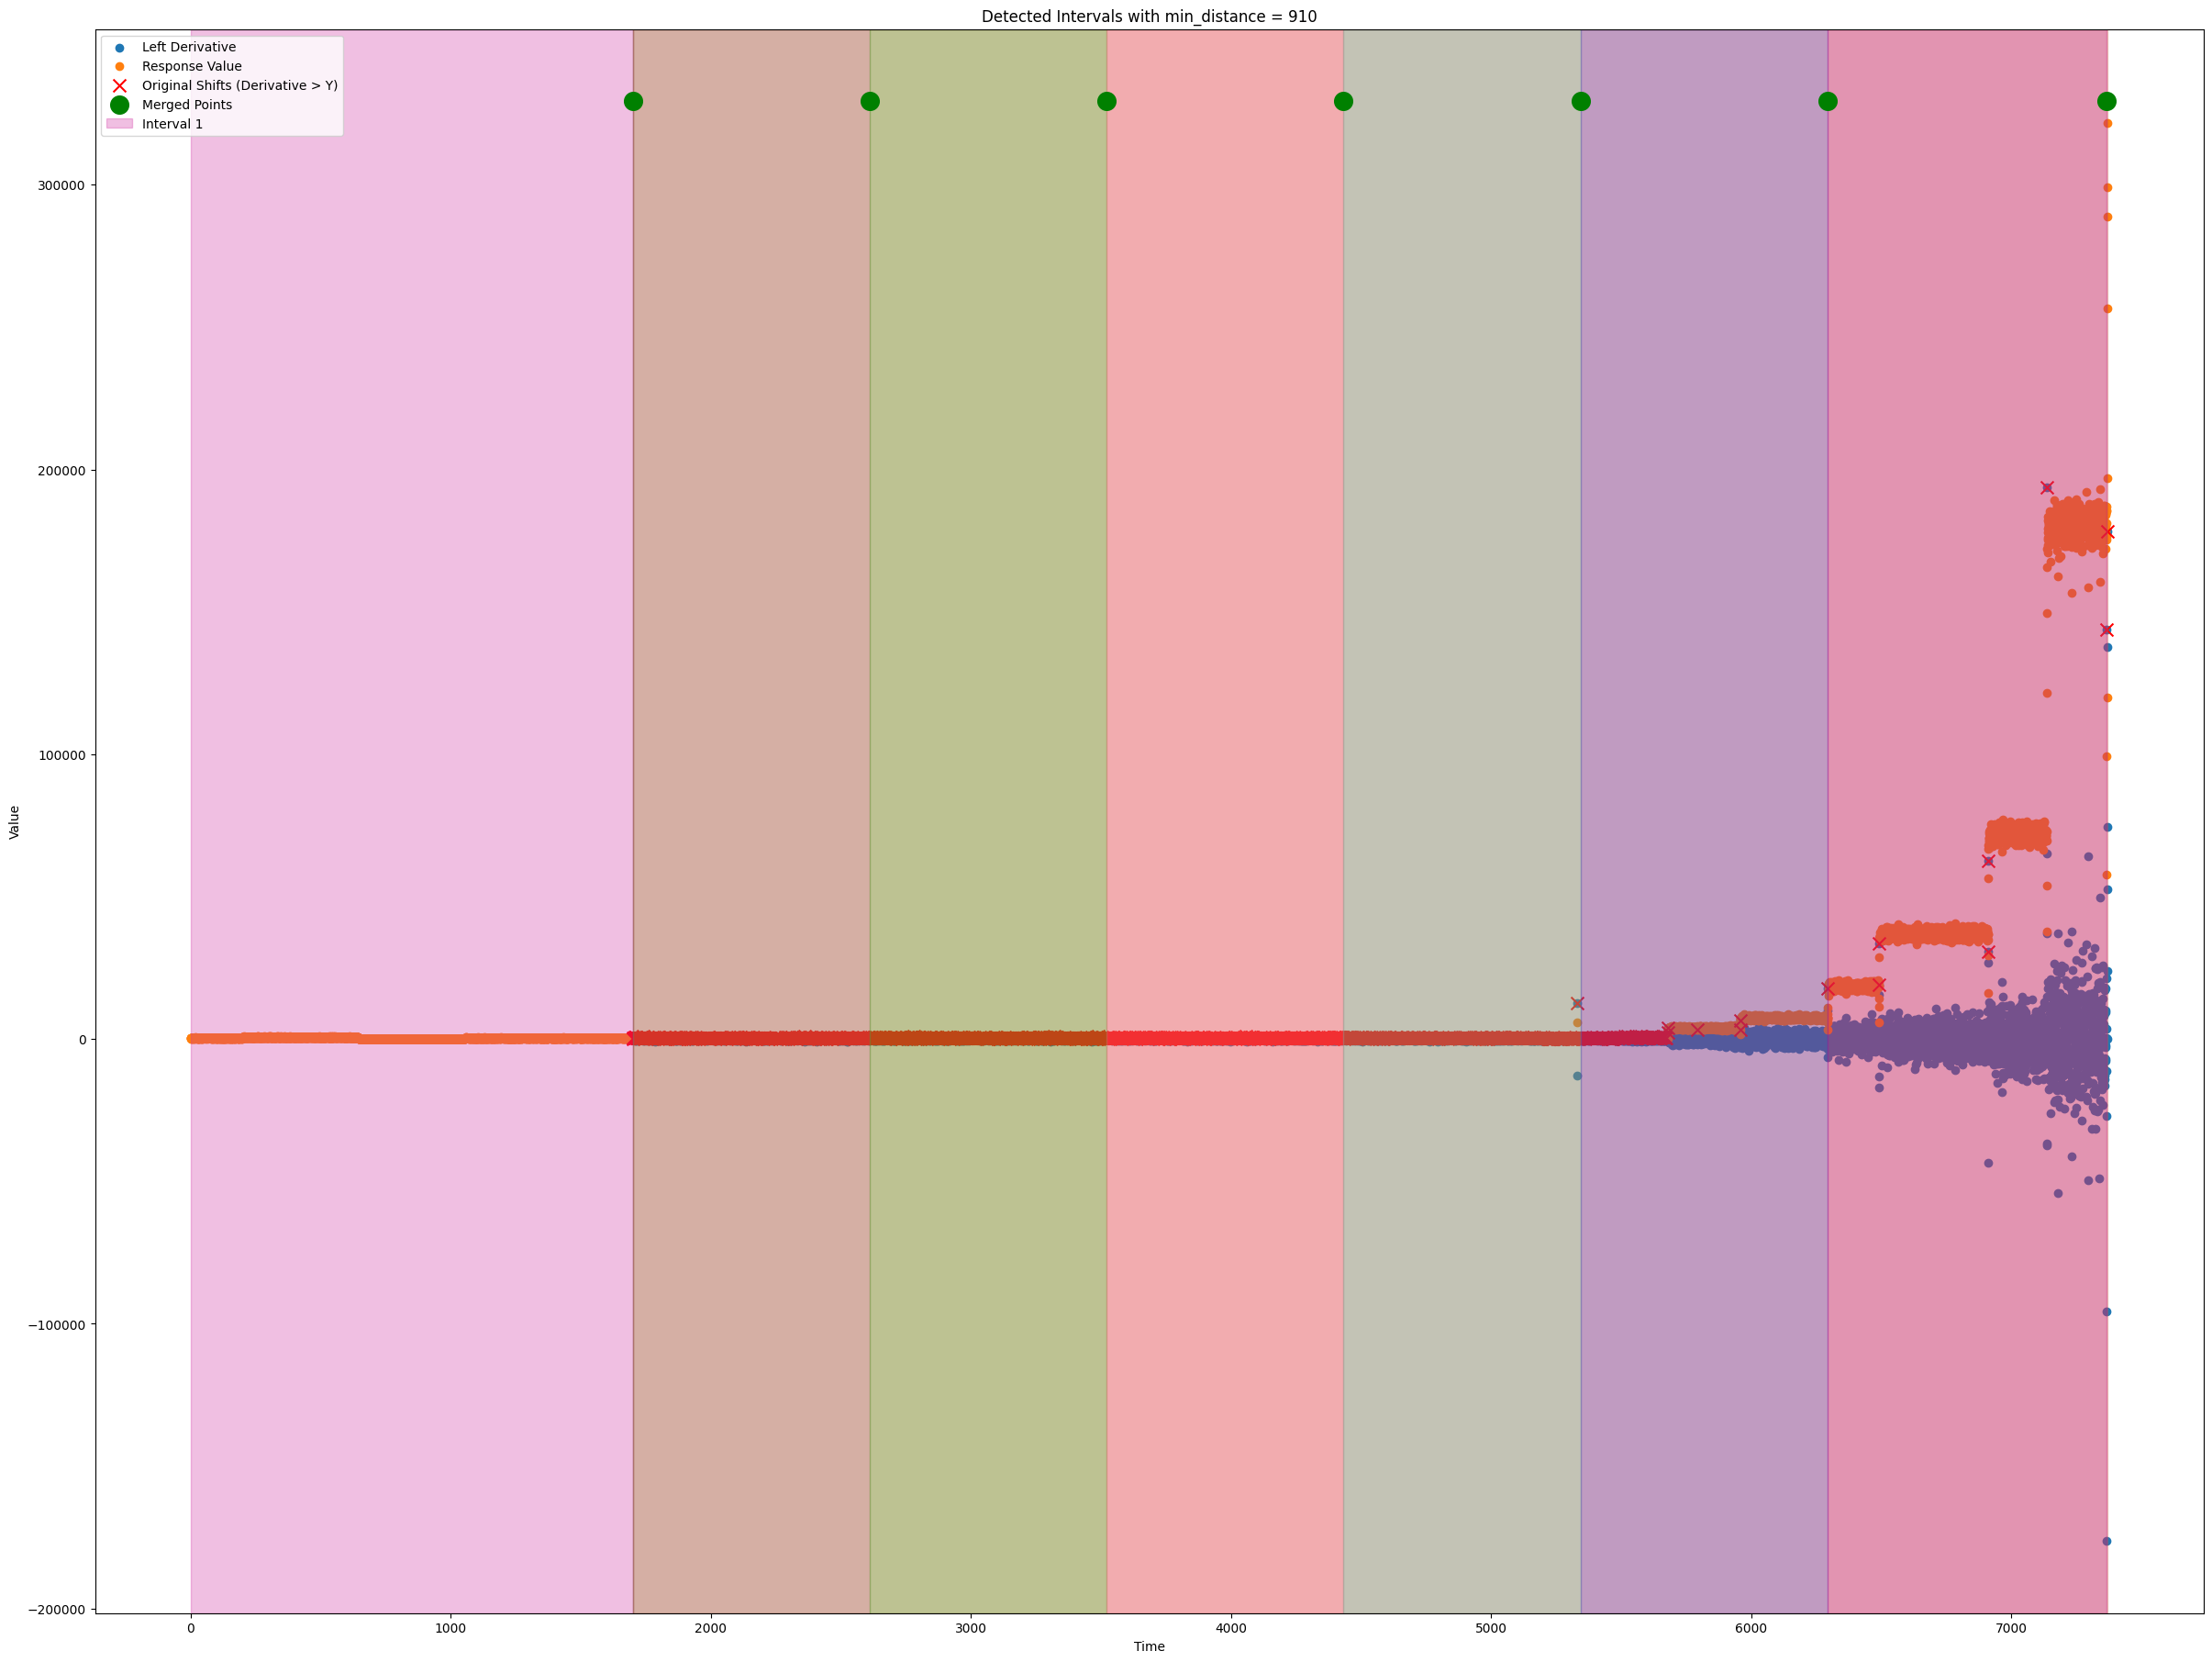


--- Testing with min_distance = 930 ---
Number of merged points for min_distance 930: 6
Detected intervals for min_distance 930:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2630.977),
 (np.float64(1699.982), np.float64(7370.625)),
 (2630.977, 3561.971),
 (3561.971, 4495.126),
 (4495.126, 5426.985),
 (5426.985, 6491.904)]

<Figure size 640x480 with 0 Axes>

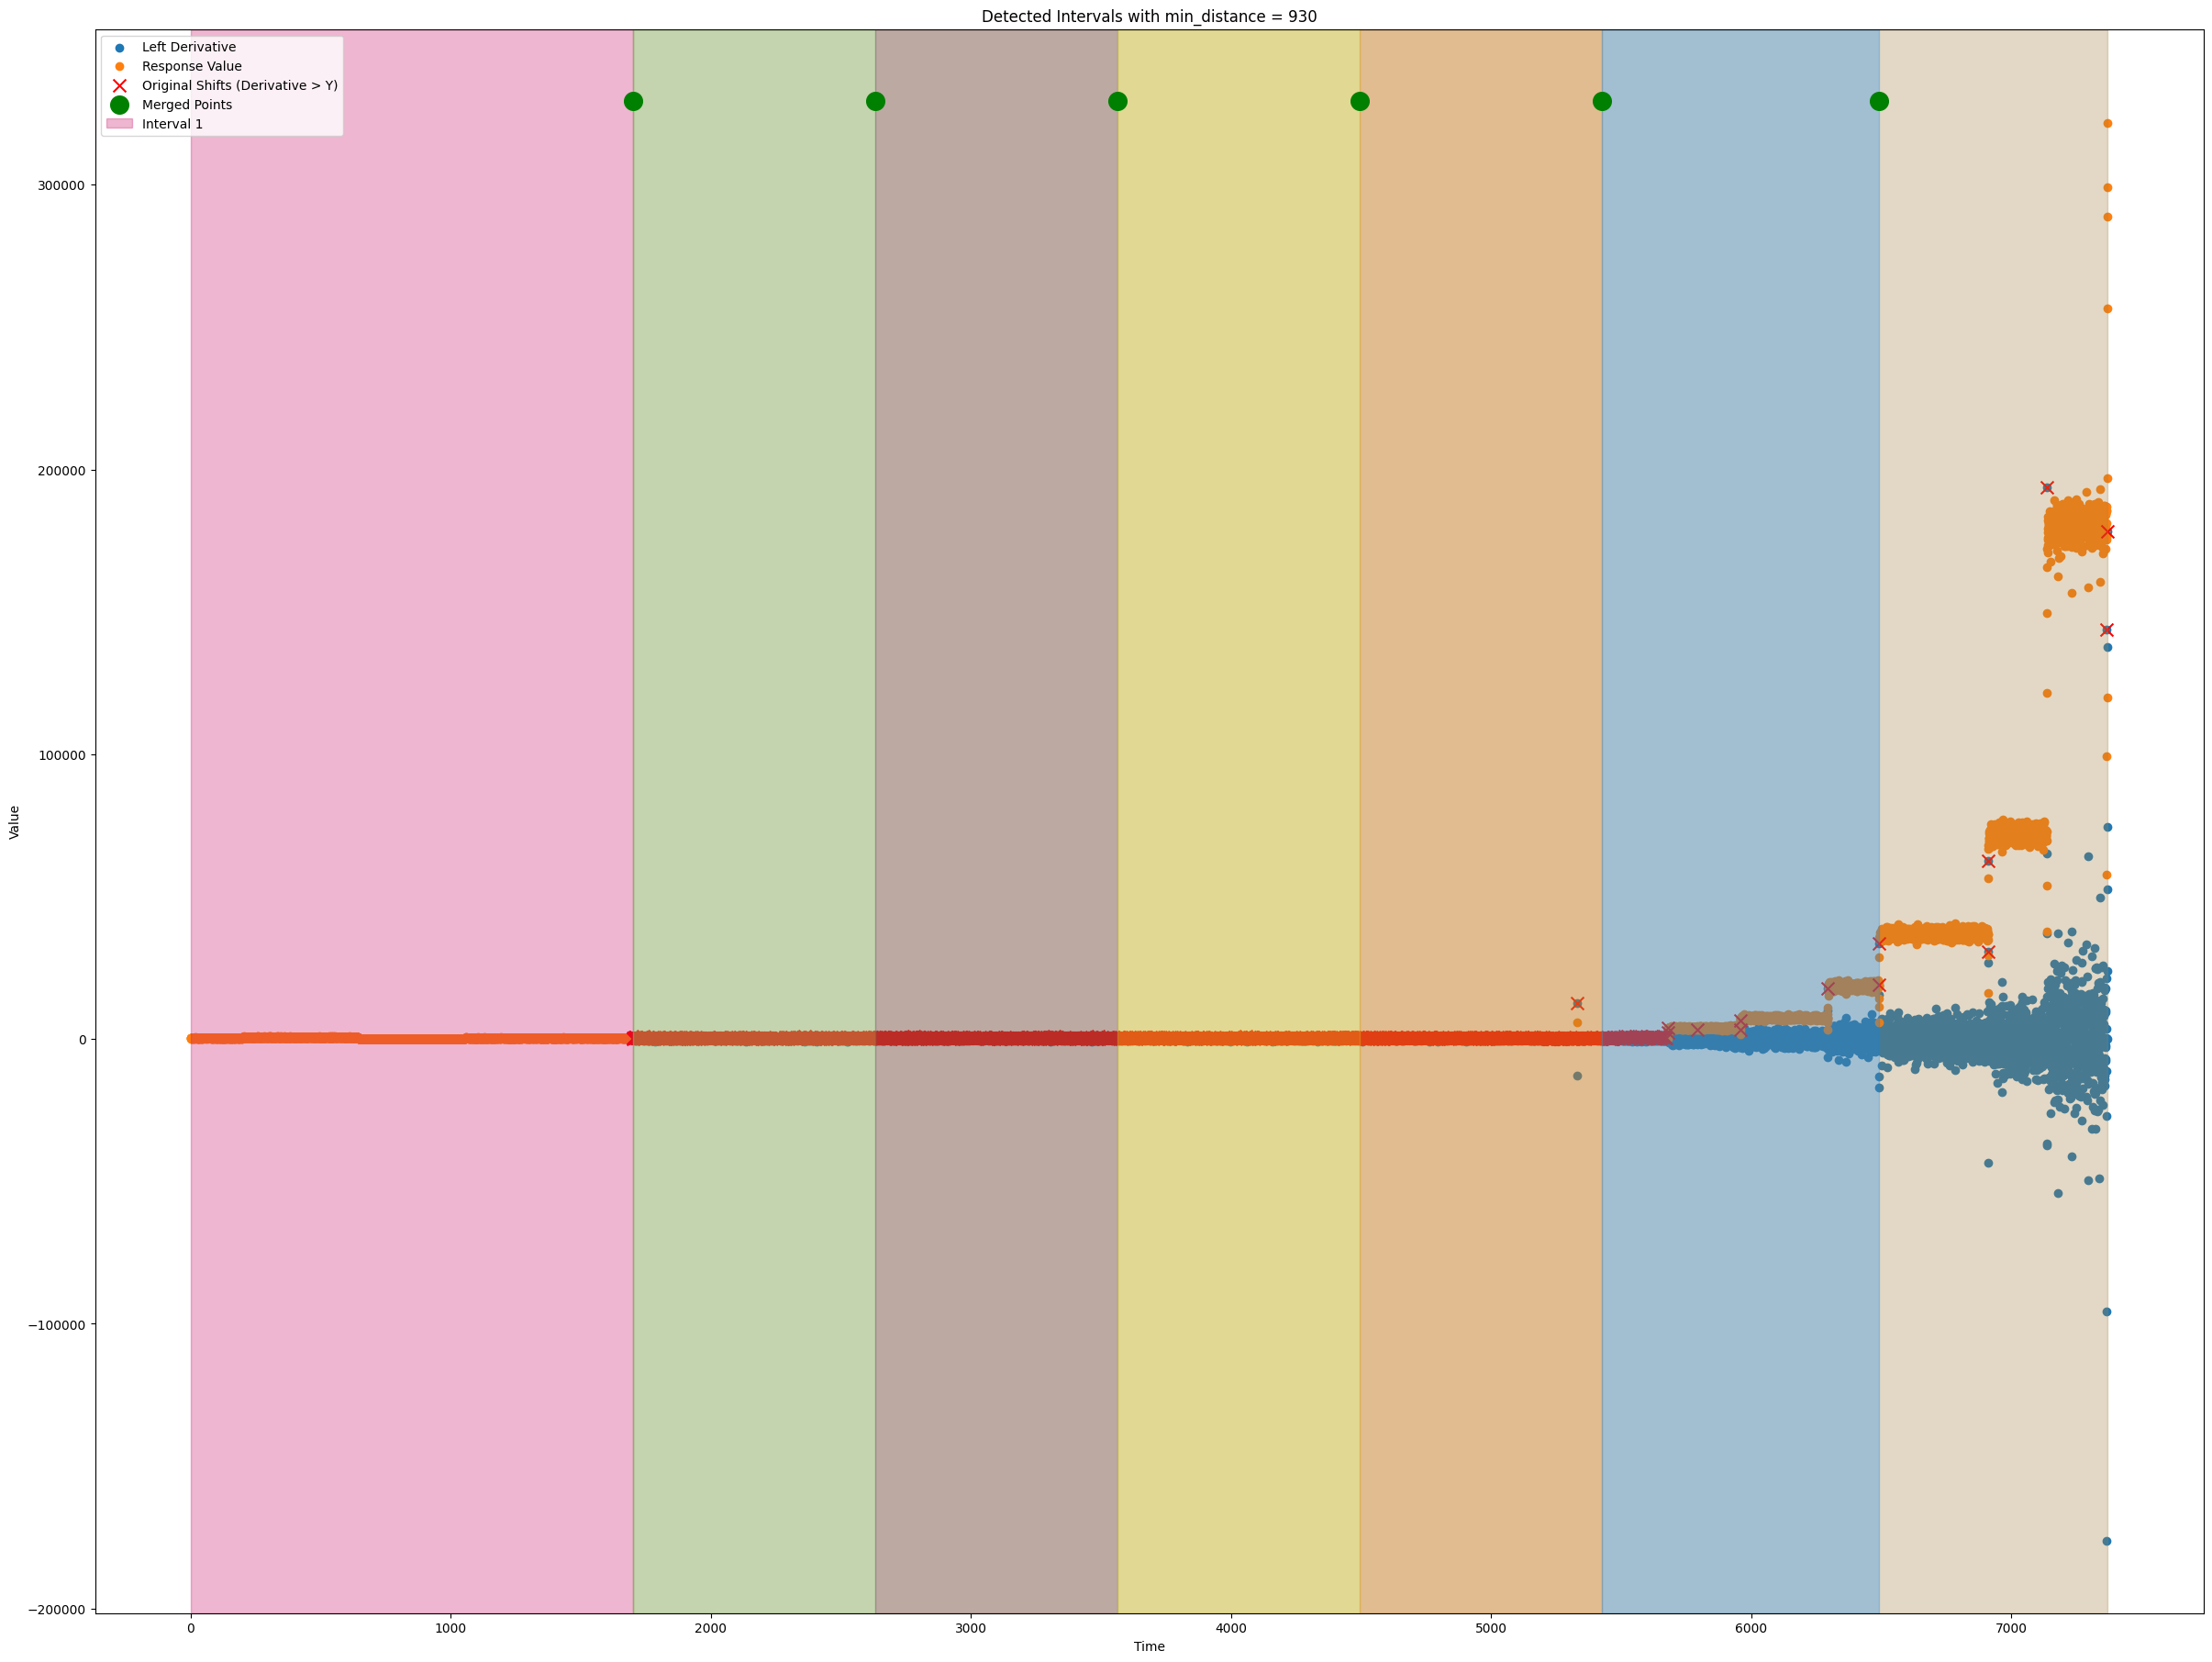


--- Testing with min_distance = 950 ---
Number of merged points for min_distance 950: 6
Detected intervals for min_distance 950:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2651.714),
 (np.float64(1699.982), np.float64(7370.625)),
 (2651.714, 3603.877),
 (3603.877, 4554.312),
 (4554.312, 5504.747),
 (5504.747, 6491.904)]

<Figure size 640x480 with 0 Axes>

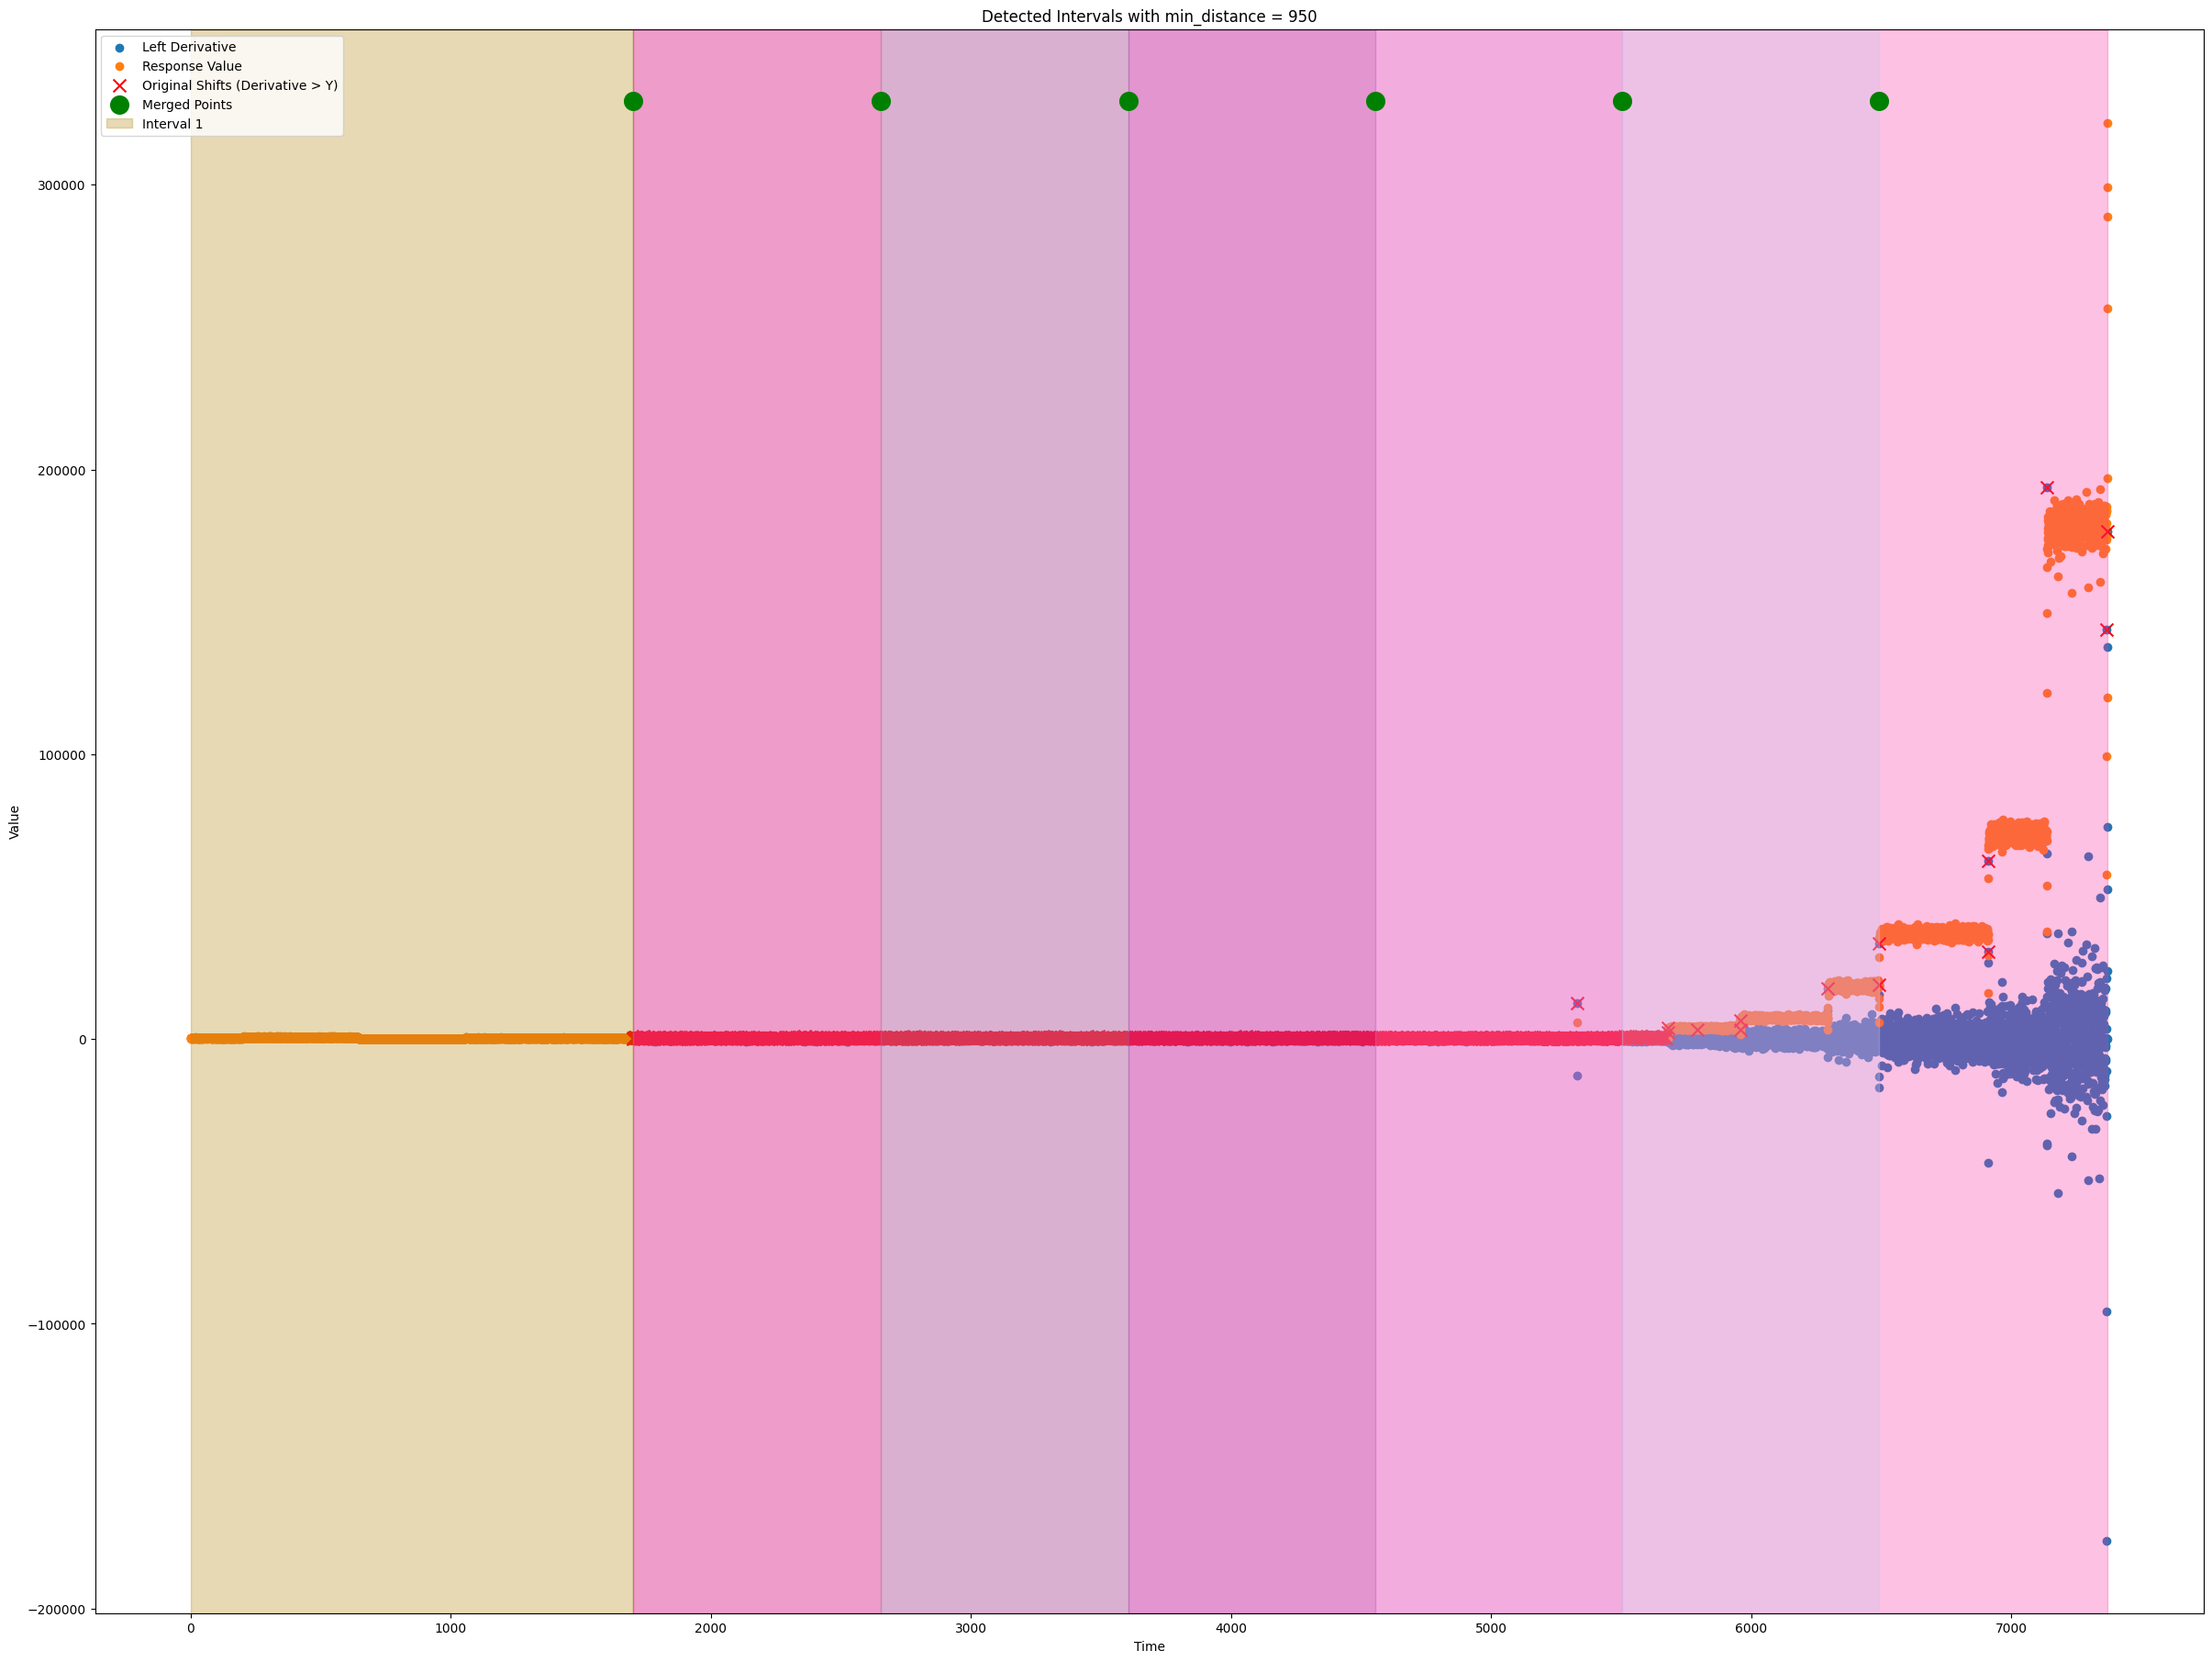


--- Testing with min_distance = 970 ---
Number of merged points for min_distance 970: 6
Detected intervals for min_distance 970:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2674.179),
 (np.float64(1699.982), np.float64(7370.625)),
 (2674.179, 3646.215),
 (3646.215, 4616.955),
 (4616.955, 5587.695),
 (5587.695, 6910.96)]

<Figure size 640x480 with 0 Axes>

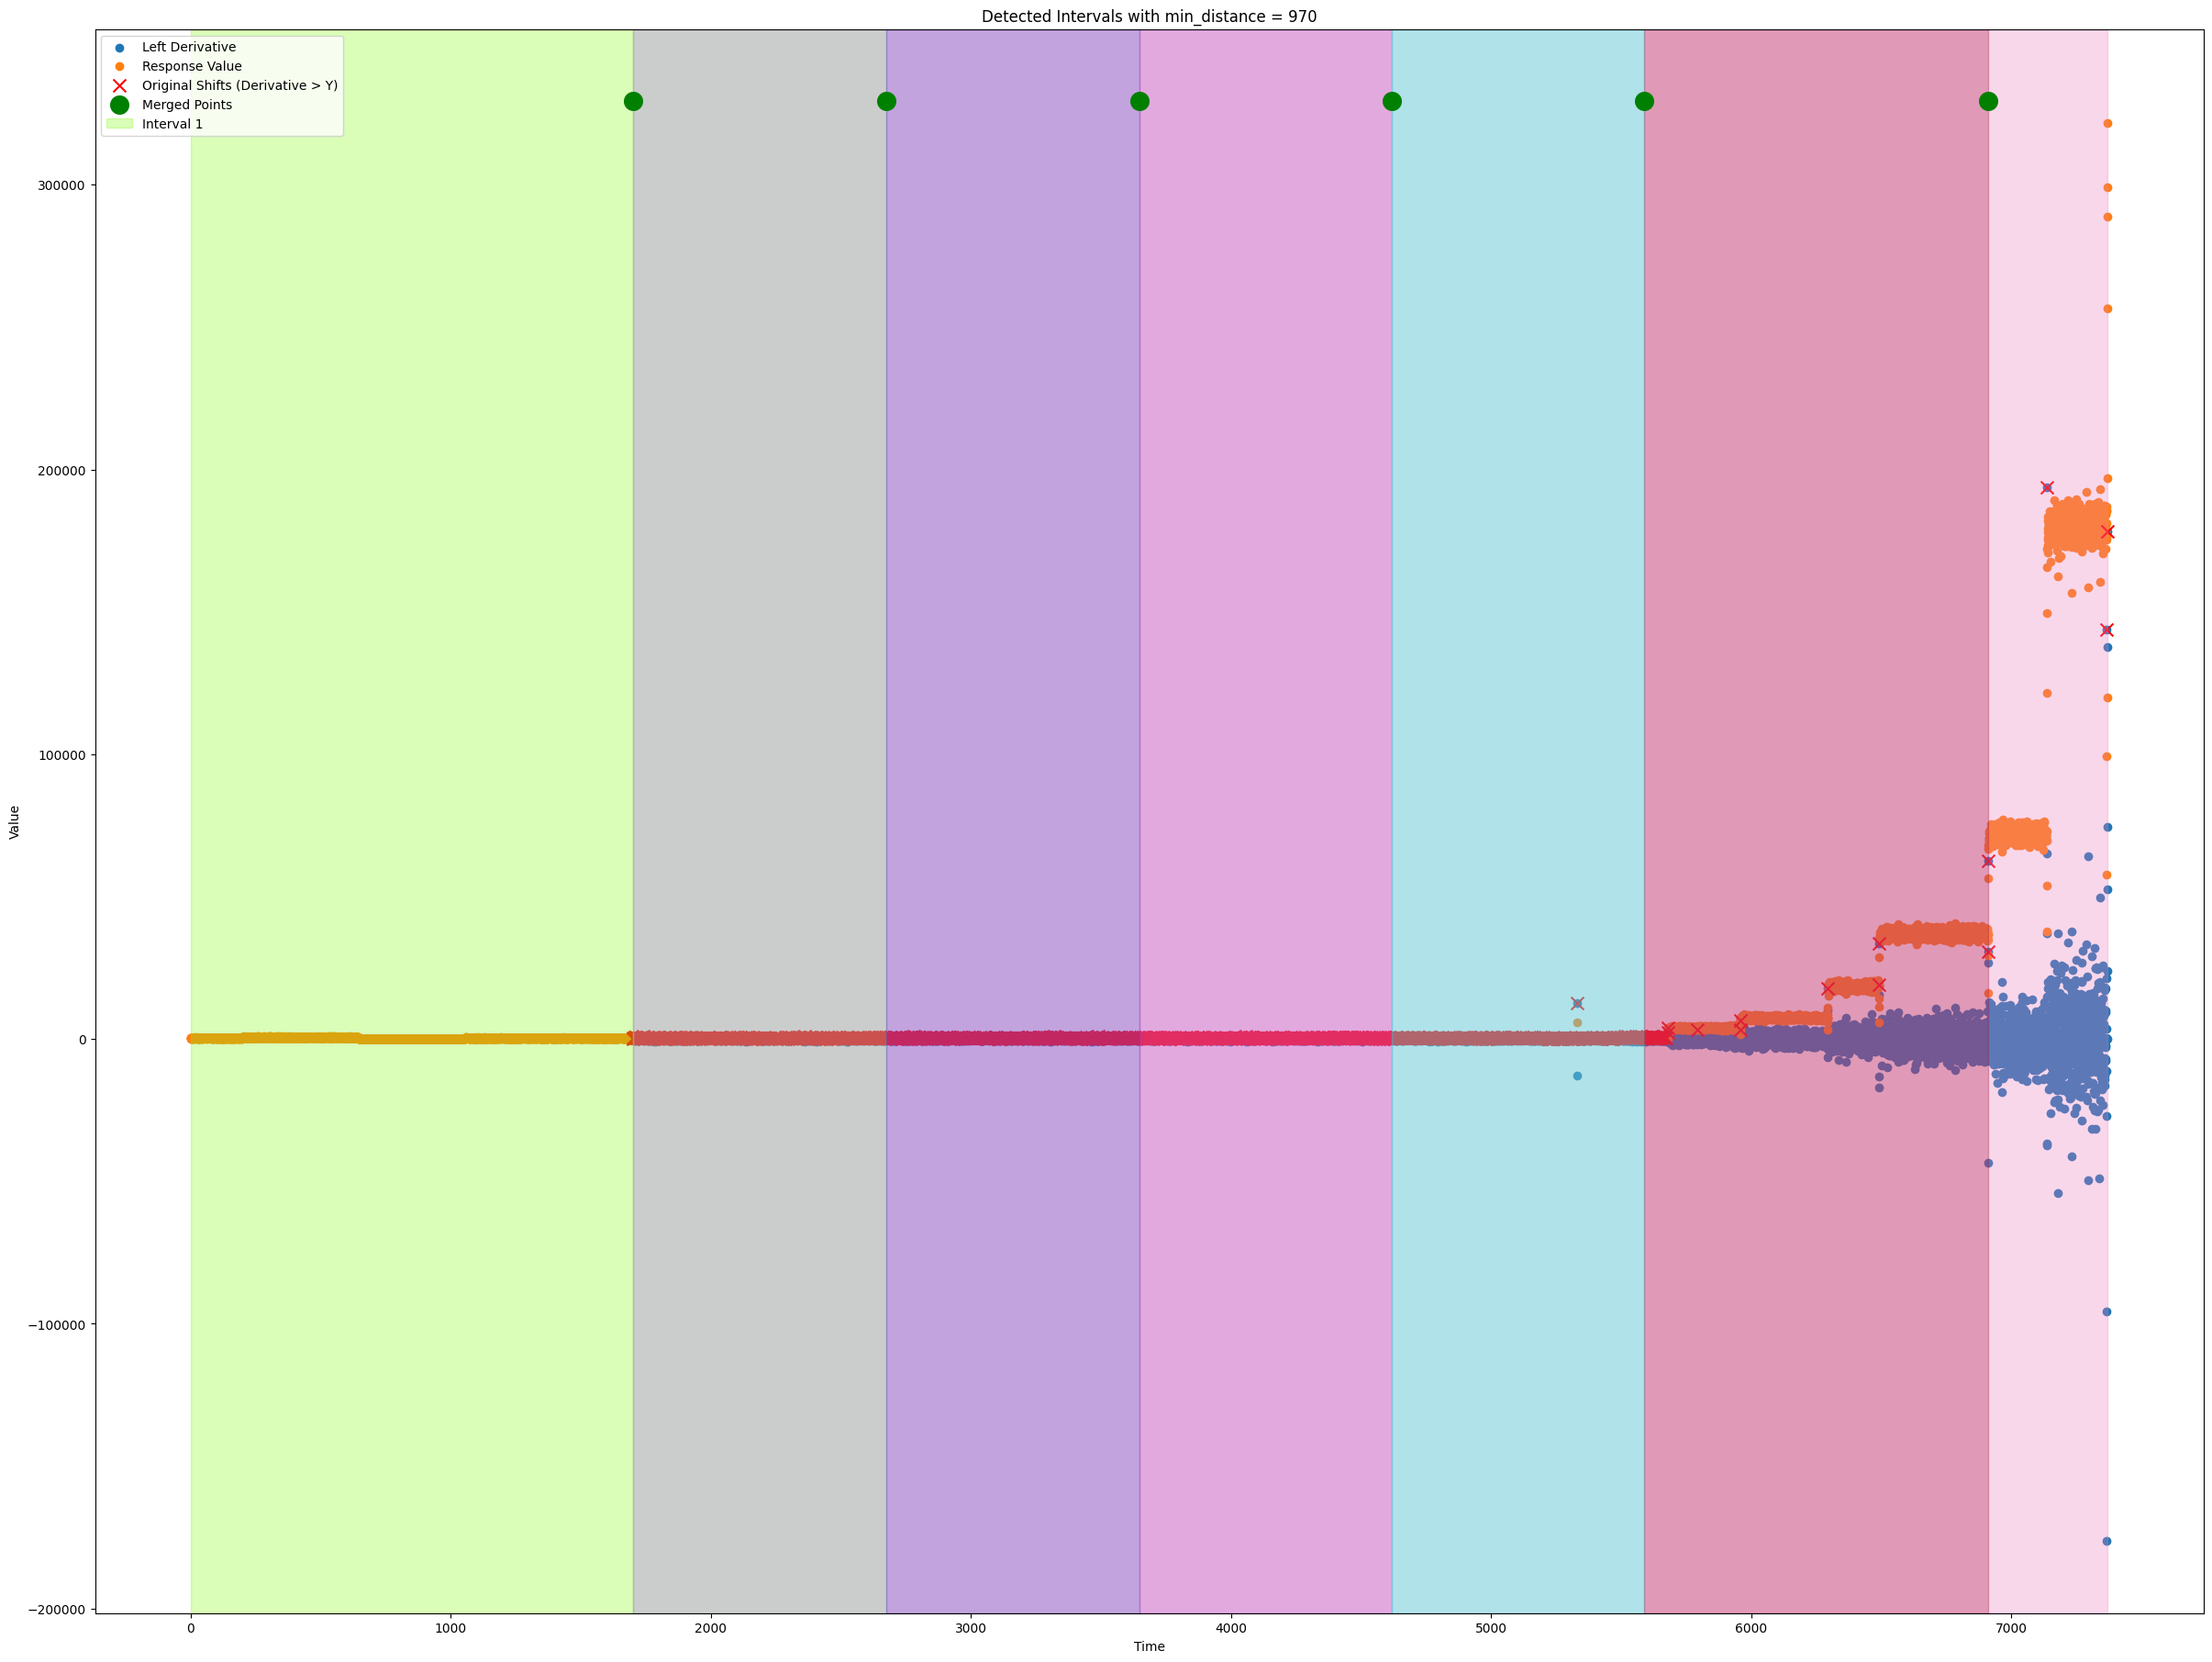


--- Testing with min_distance = 990 ---
Number of merged points for min_distance 990: 6
Detected intervals for min_distance 990:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2690.595),
 (np.float64(1699.982), np.float64(7370.625)),
 (2690.595, 3681.208),
 (3681.208, 4673.981),
 (4673.981, 5666.321),
 (5666.321, 6910.96)]

<Figure size 640x480 with 0 Axes>

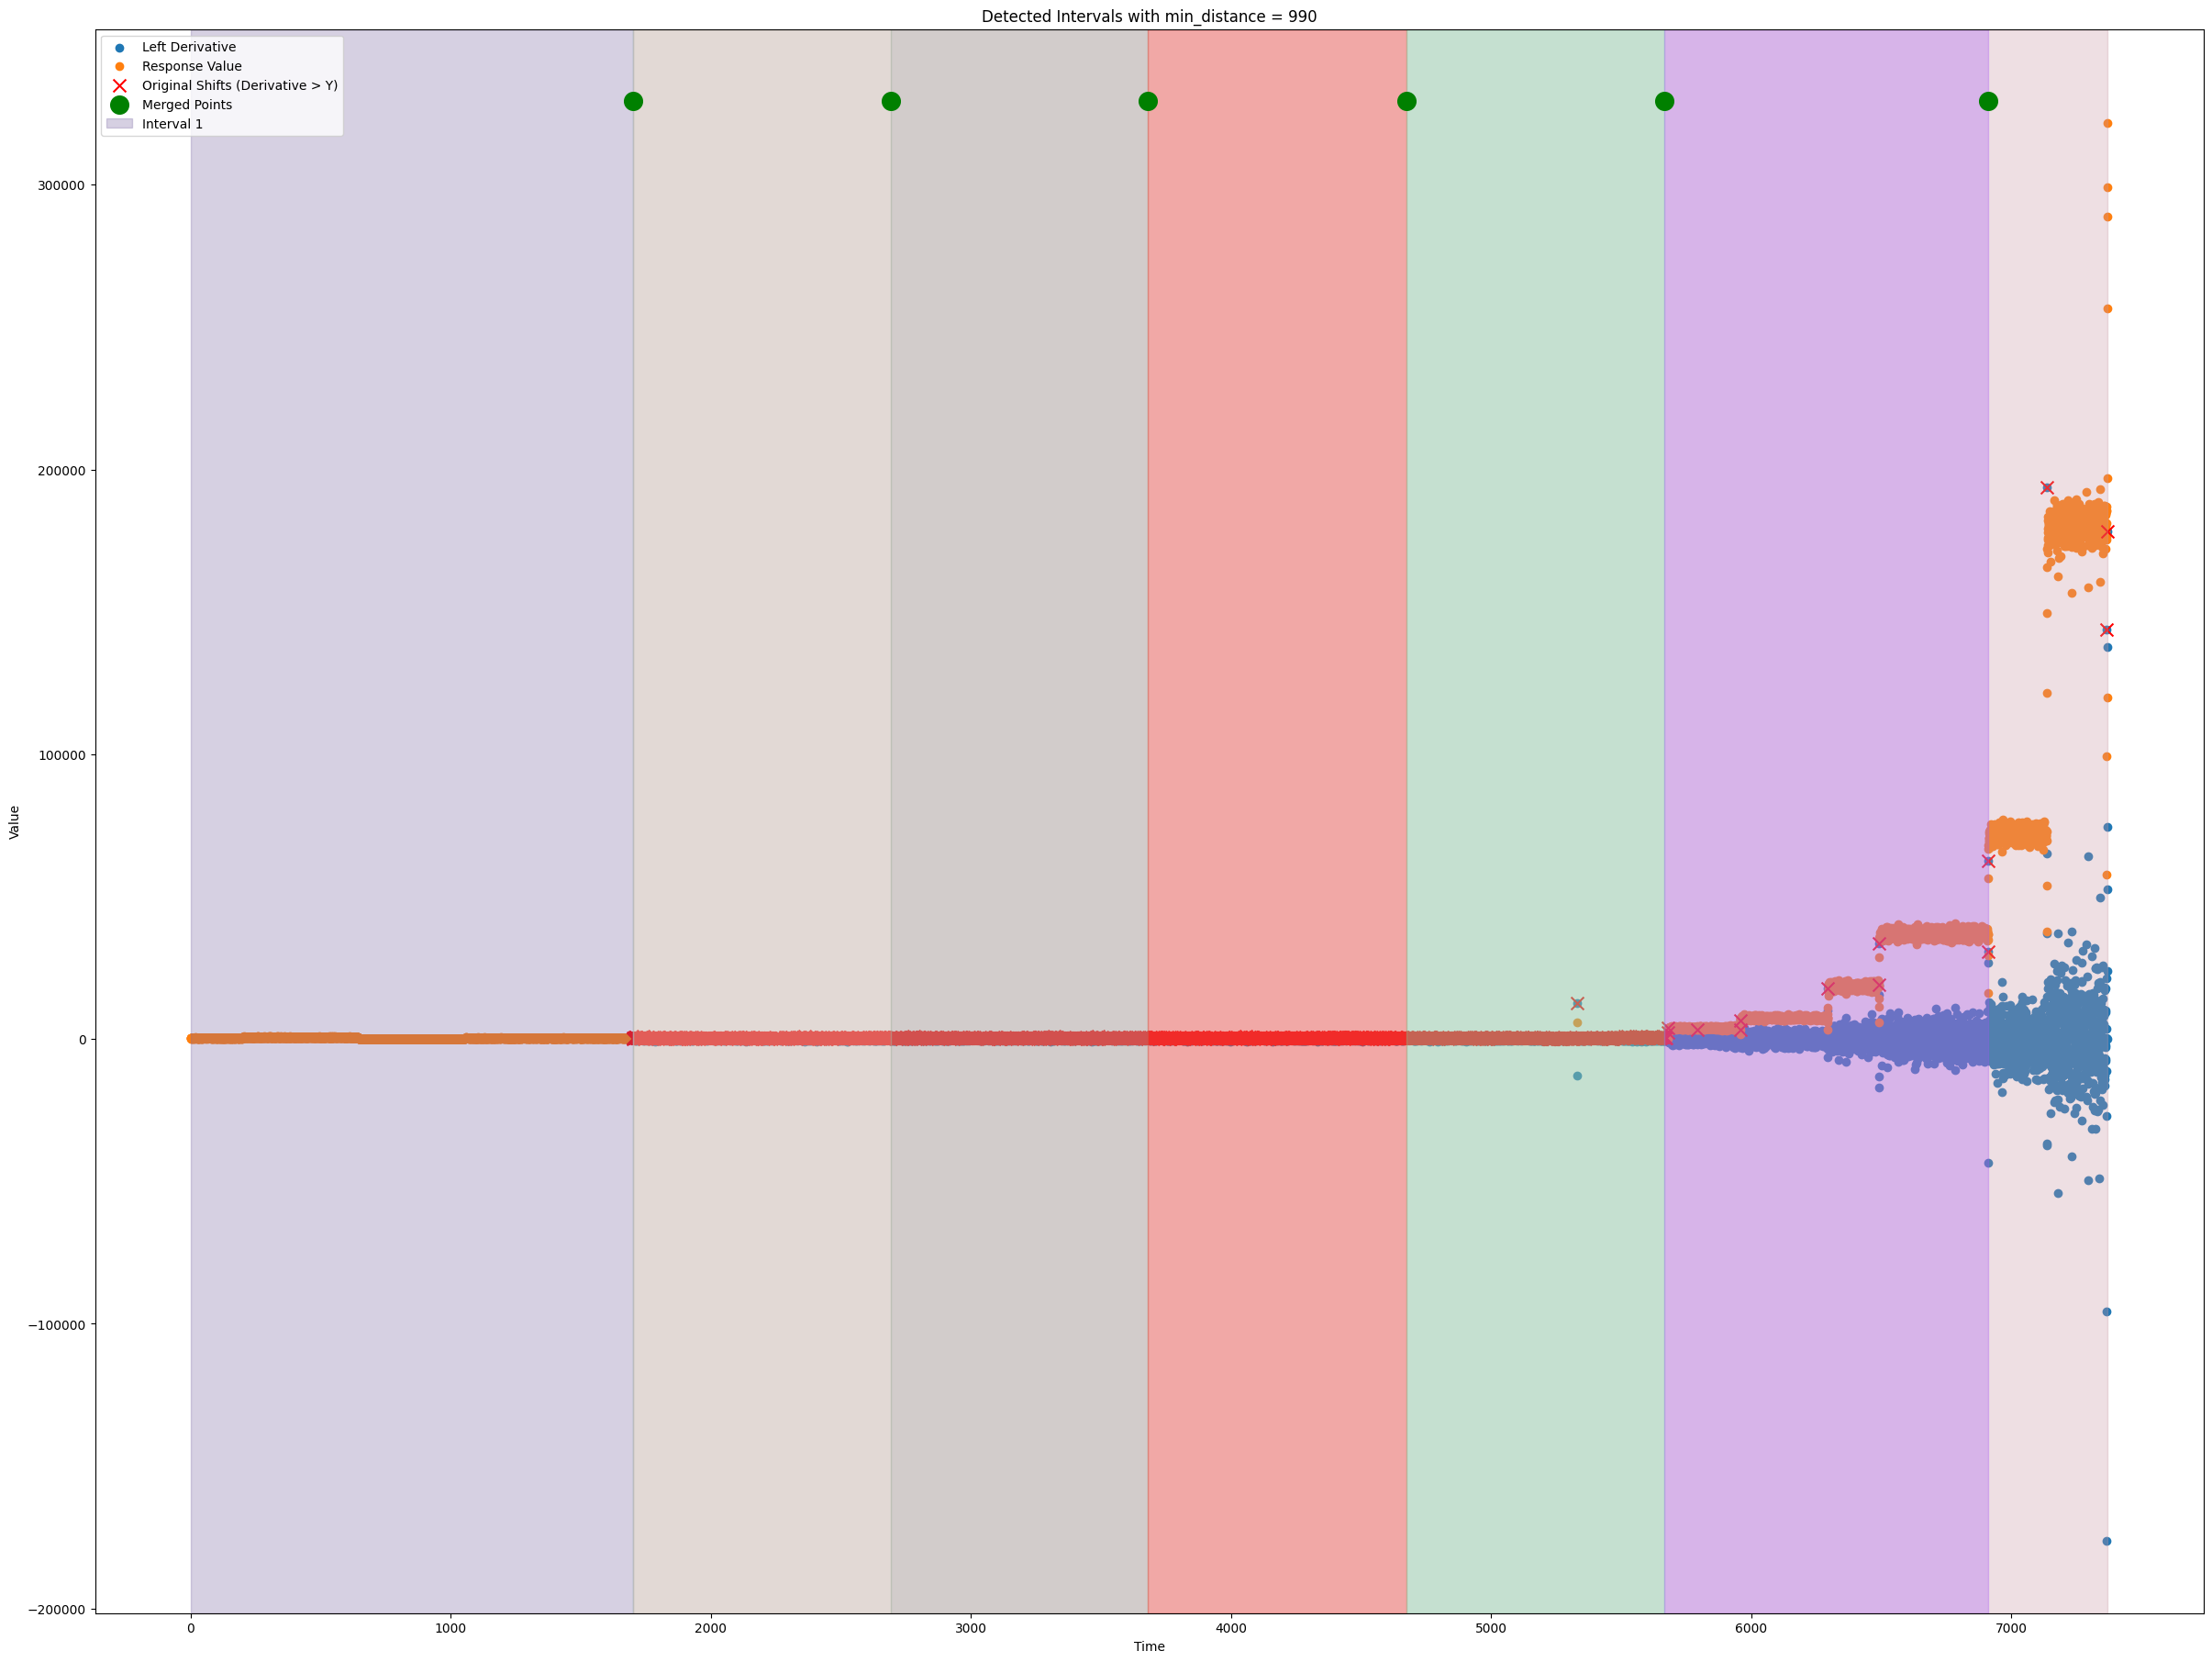


--- Testing with min_distance = 1010 ---
Number of merged points for min_distance 1010: 6
Detected intervals for min_distance 1010:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2710.9),
 (np.float64(1699.982), np.float64(7370.625)),
 (2710.9, 3726.138),
 (3726.138, 4736.623),
 (4736.623, 5792.902),
 (5792.902, 6910.96)]

<Figure size 640x480 with 0 Axes>

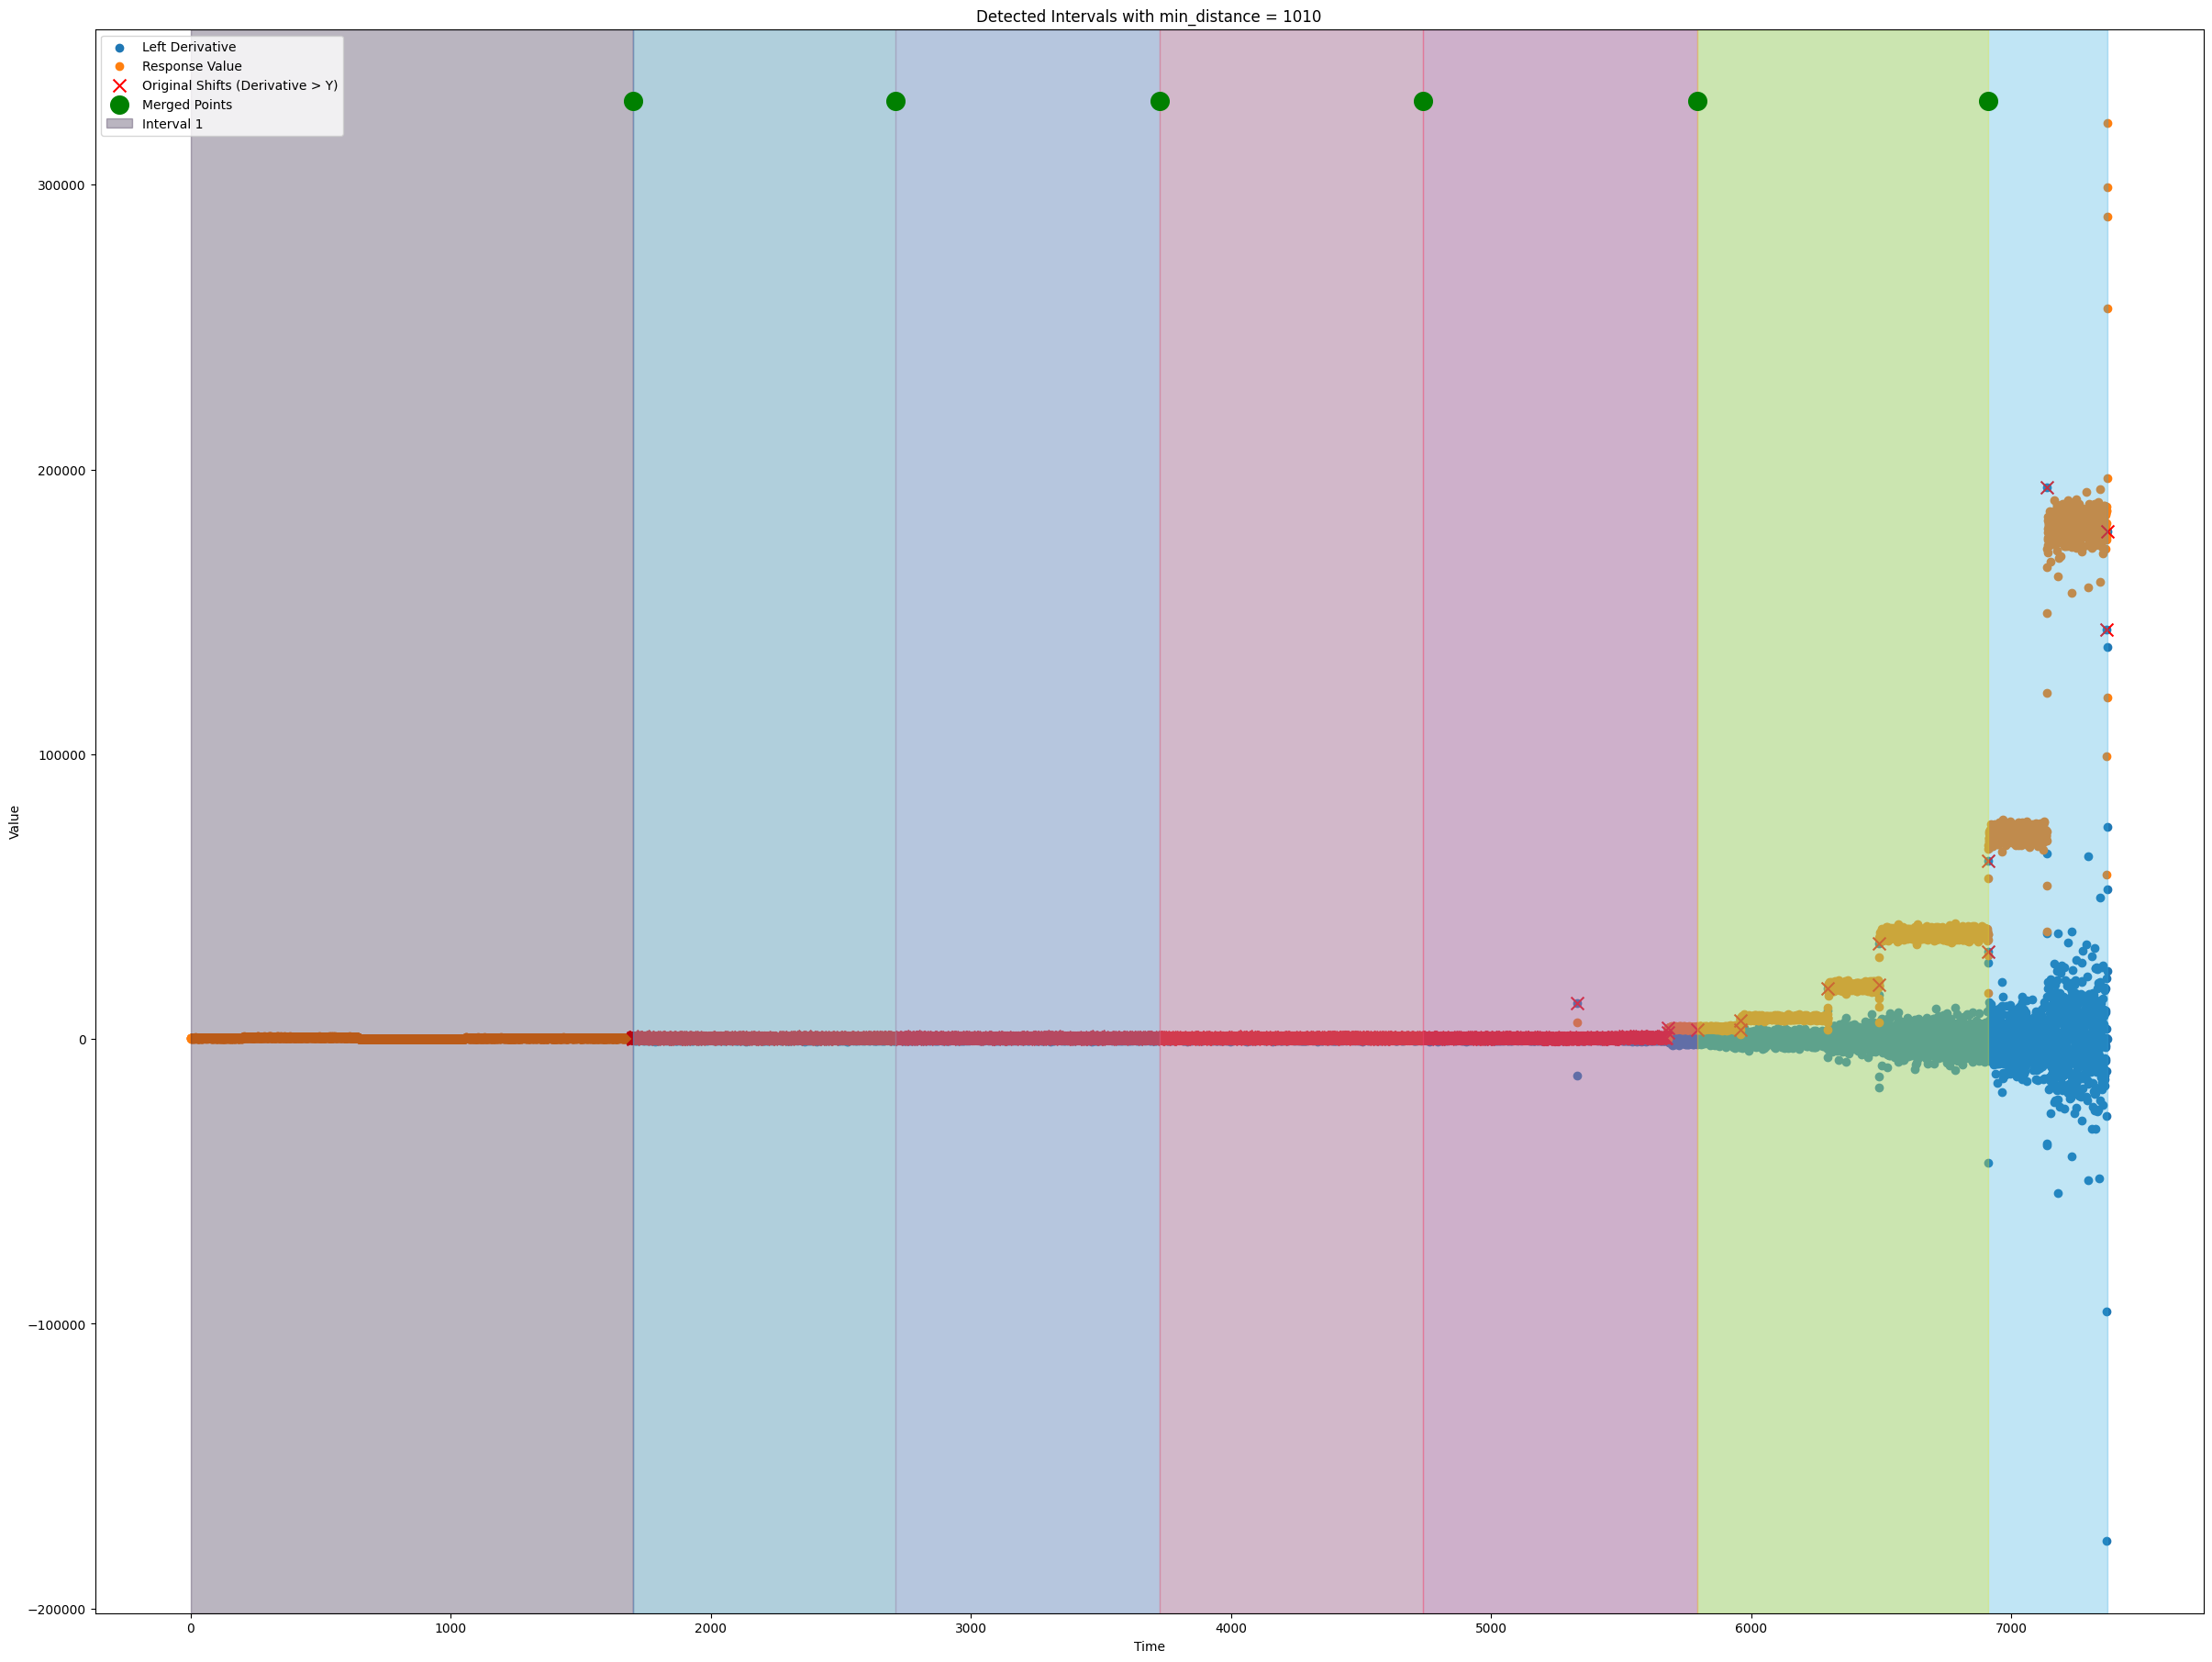


--- Testing with min_distance = 1030 ---
Number of merged points for min_distance 1030: 6
Detected intervals for min_distance 1030:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2732.933),
 (np.float64(1699.982), np.float64(7370.625)),
 (2732.933, 3763.291),
 (3763.291, 4793.649),
 (4793.649, 5957.068),
 (5957.068, 7136.904)]

<Figure size 640x480 with 0 Axes>

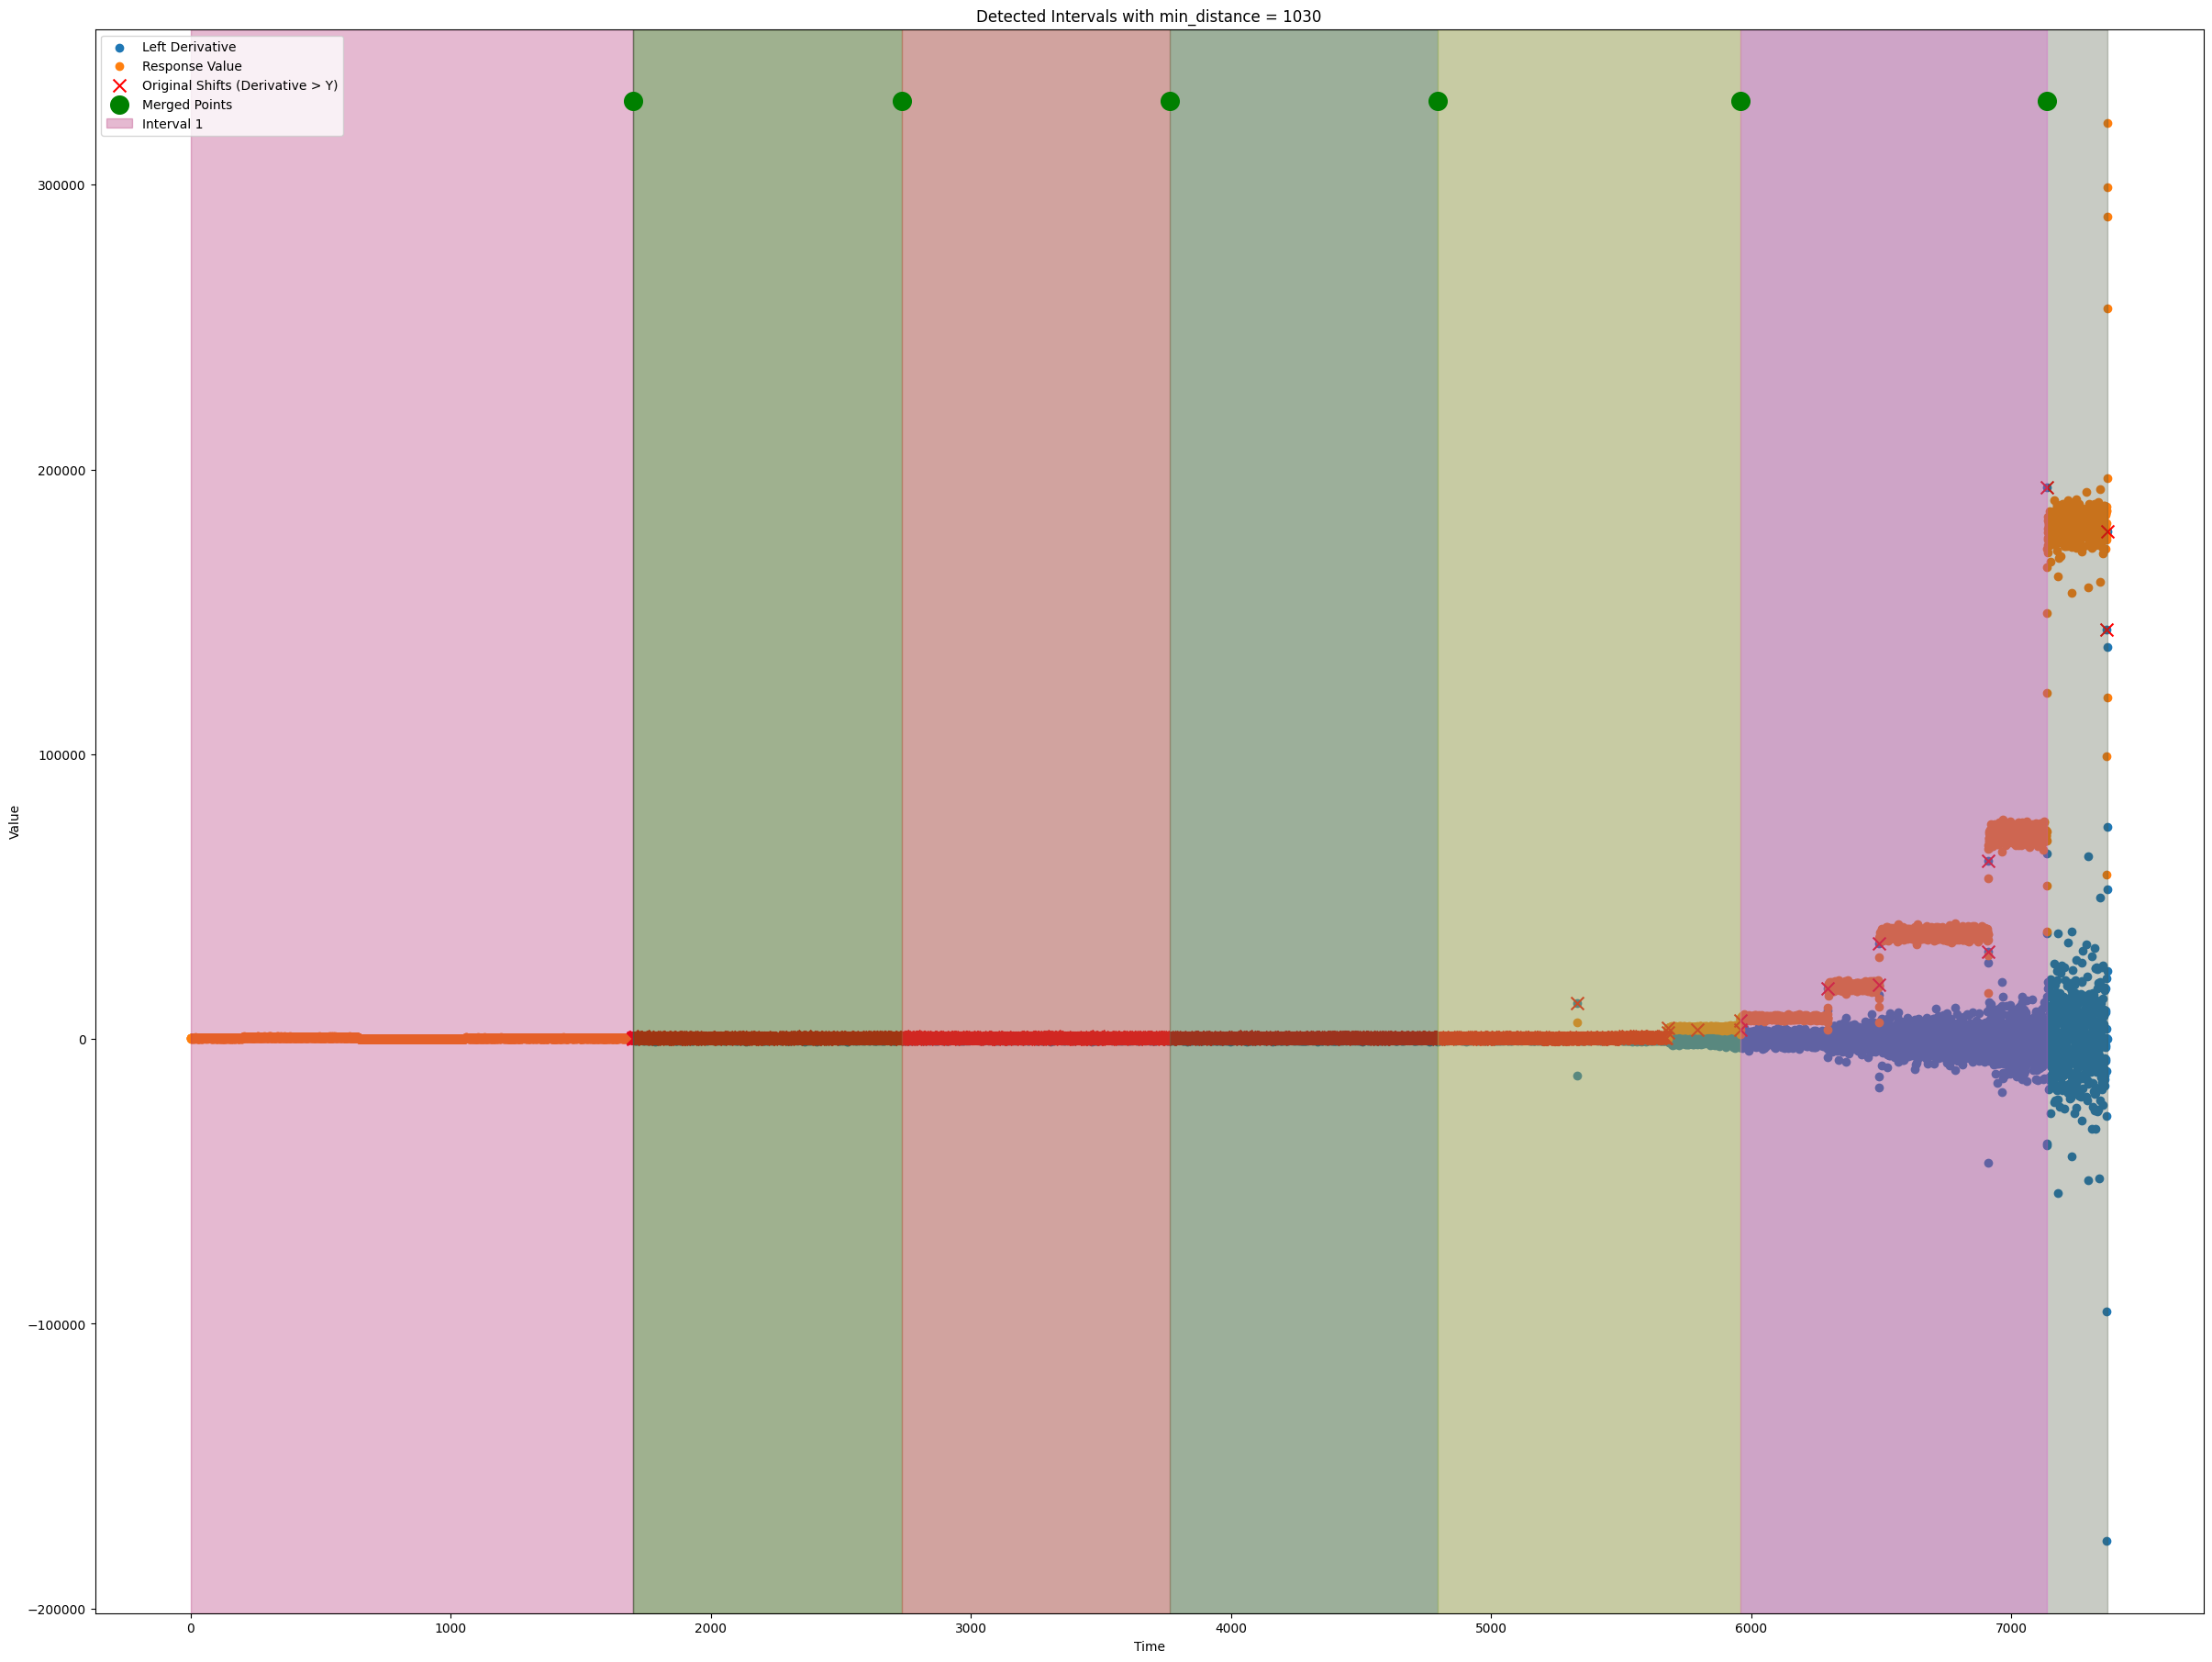


--- Testing with min_distance = 1050 ---
Number of merged points for min_distance 1050: 6
Detected intervals for min_distance 1050:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2751.509),
 (np.float64(1699.982), np.float64(7370.625)),
 (2751.509, 3801.74),
 (3801.74, 4852.403),
 (4852.403, 5957.068),
 (5957.068, 7136.904)]

<Figure size 640x480 with 0 Axes>

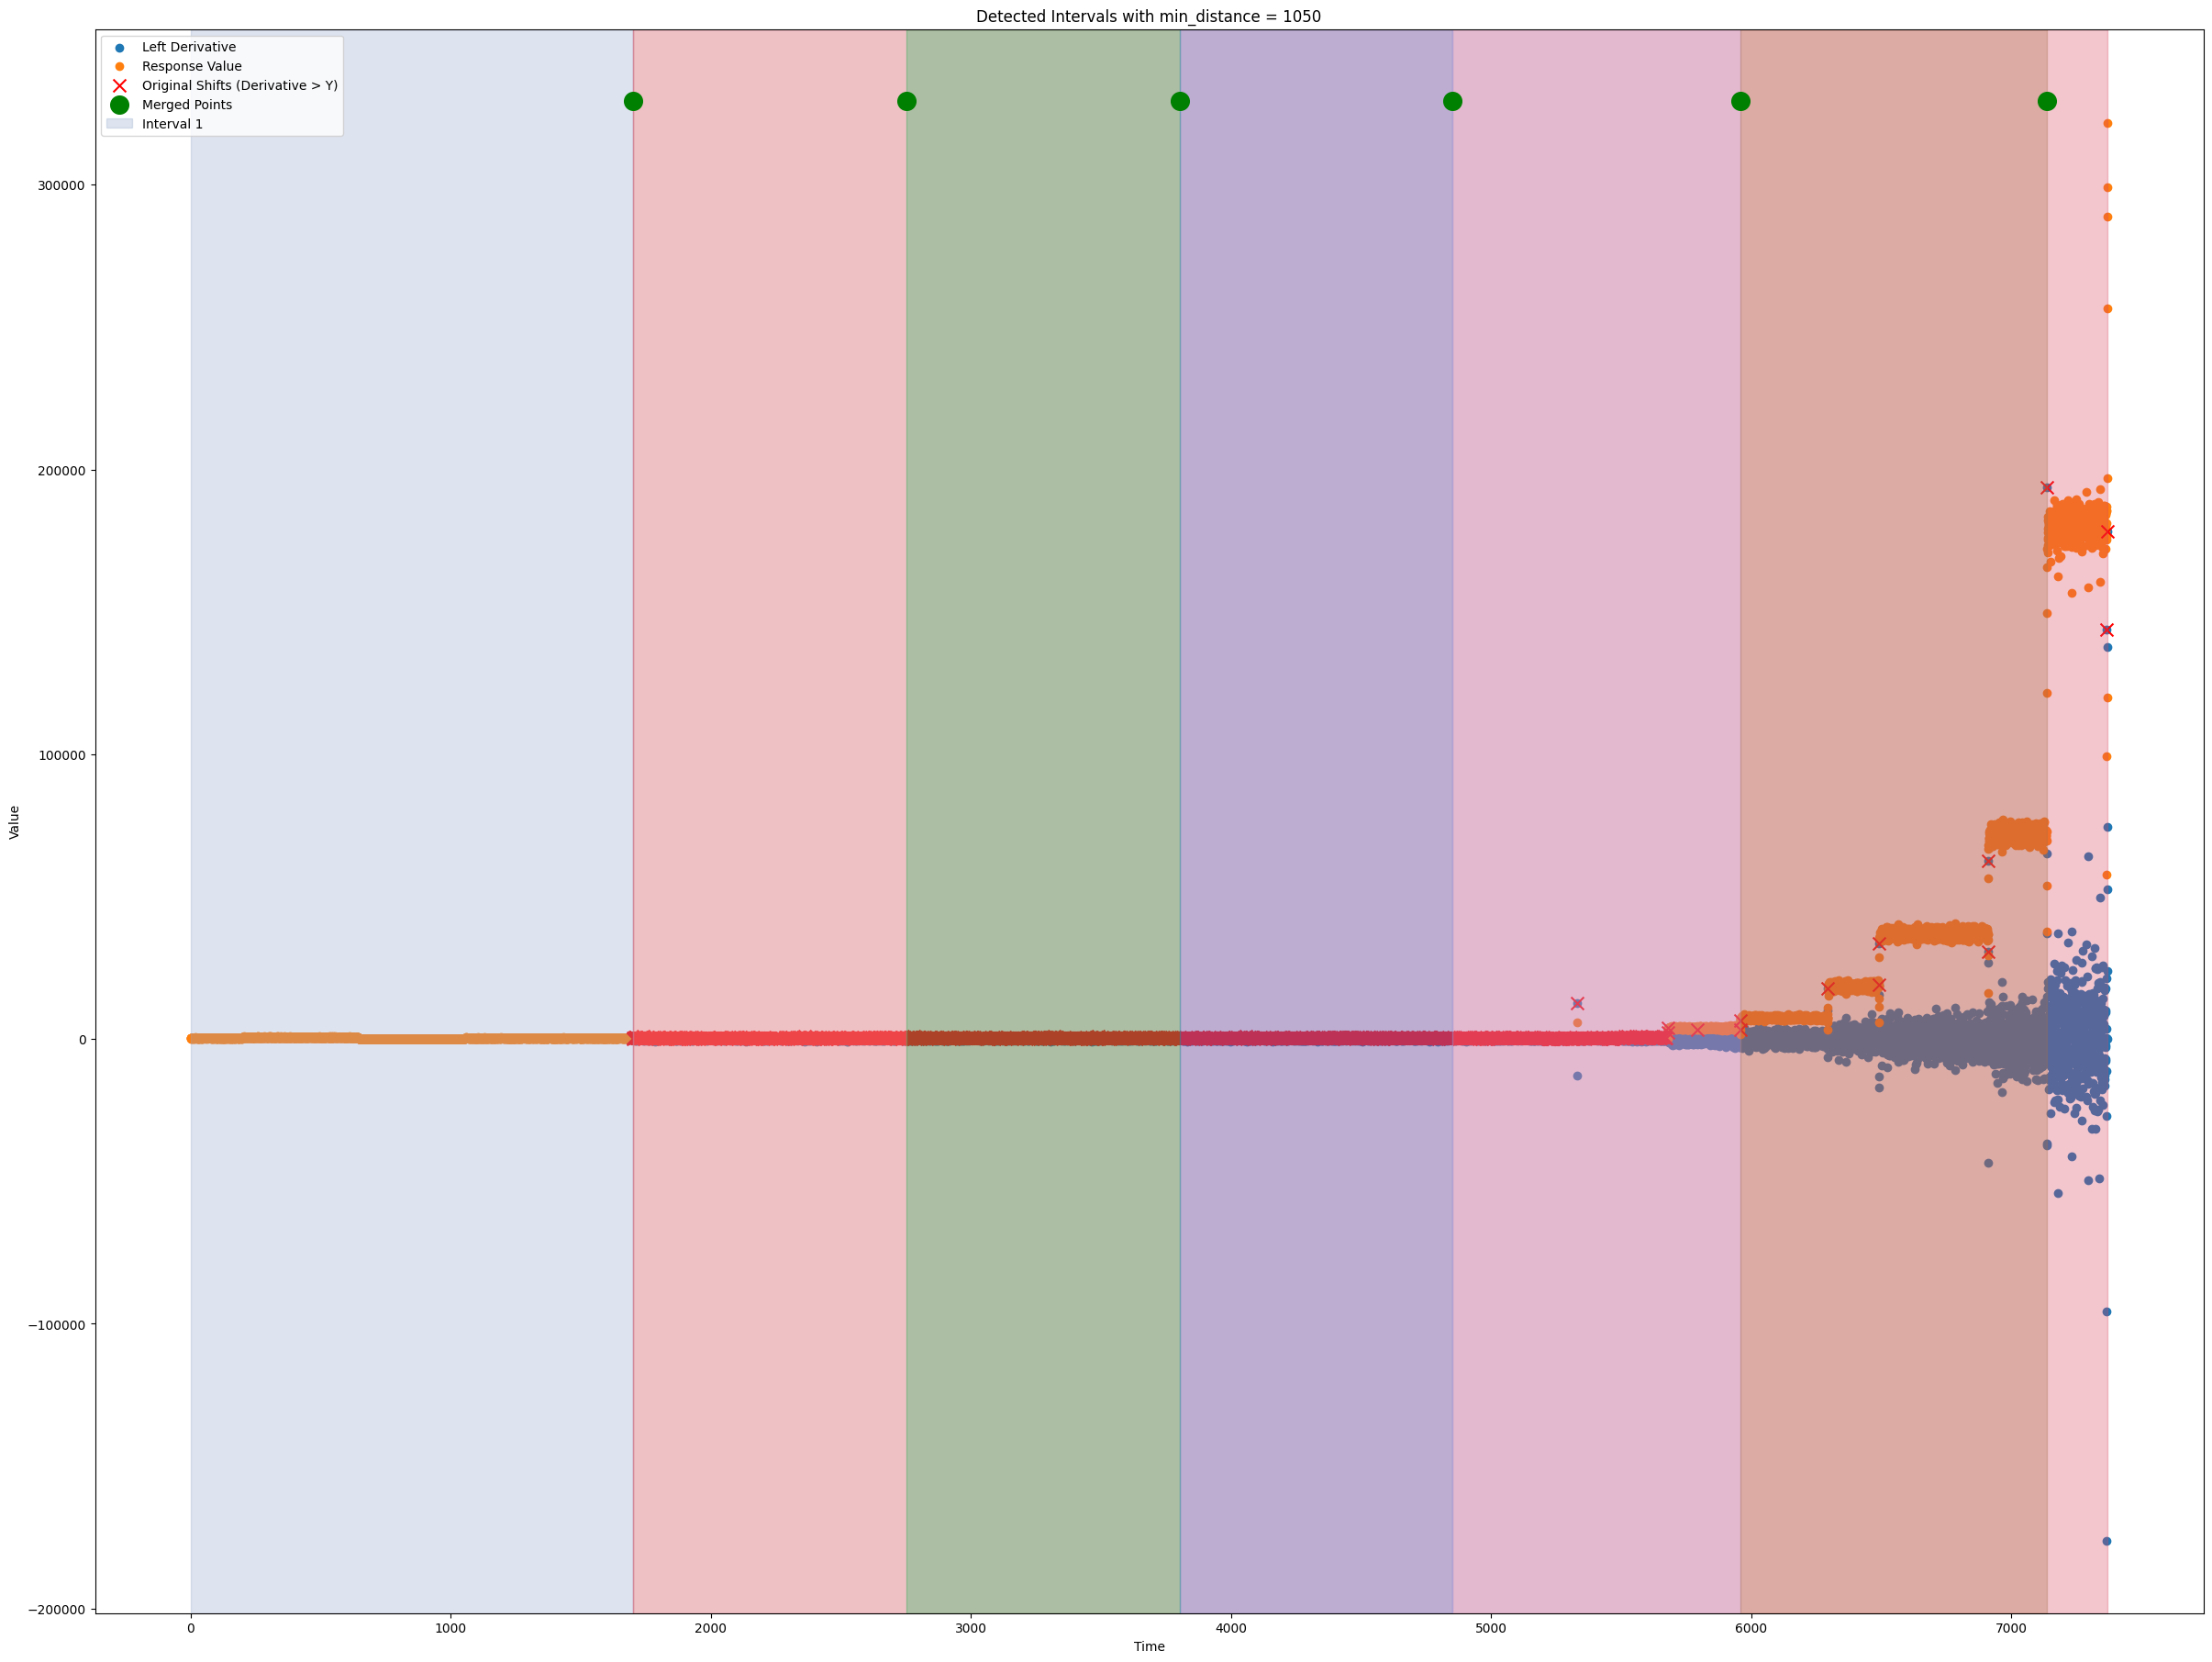


--- Testing with min_distance = 1070 ---
Number of merged points for min_distance 1070: 6
Detected intervals for min_distance 1070:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2770.518),
 (np.float64(1699.982), np.float64(7370.625)),
 (2770.518, 3841.486),
 (3841.486, 4911.589),
 (4911.589, 6294.905),
 (6294.905, 7368.033)]

<Figure size 640x480 with 0 Axes>

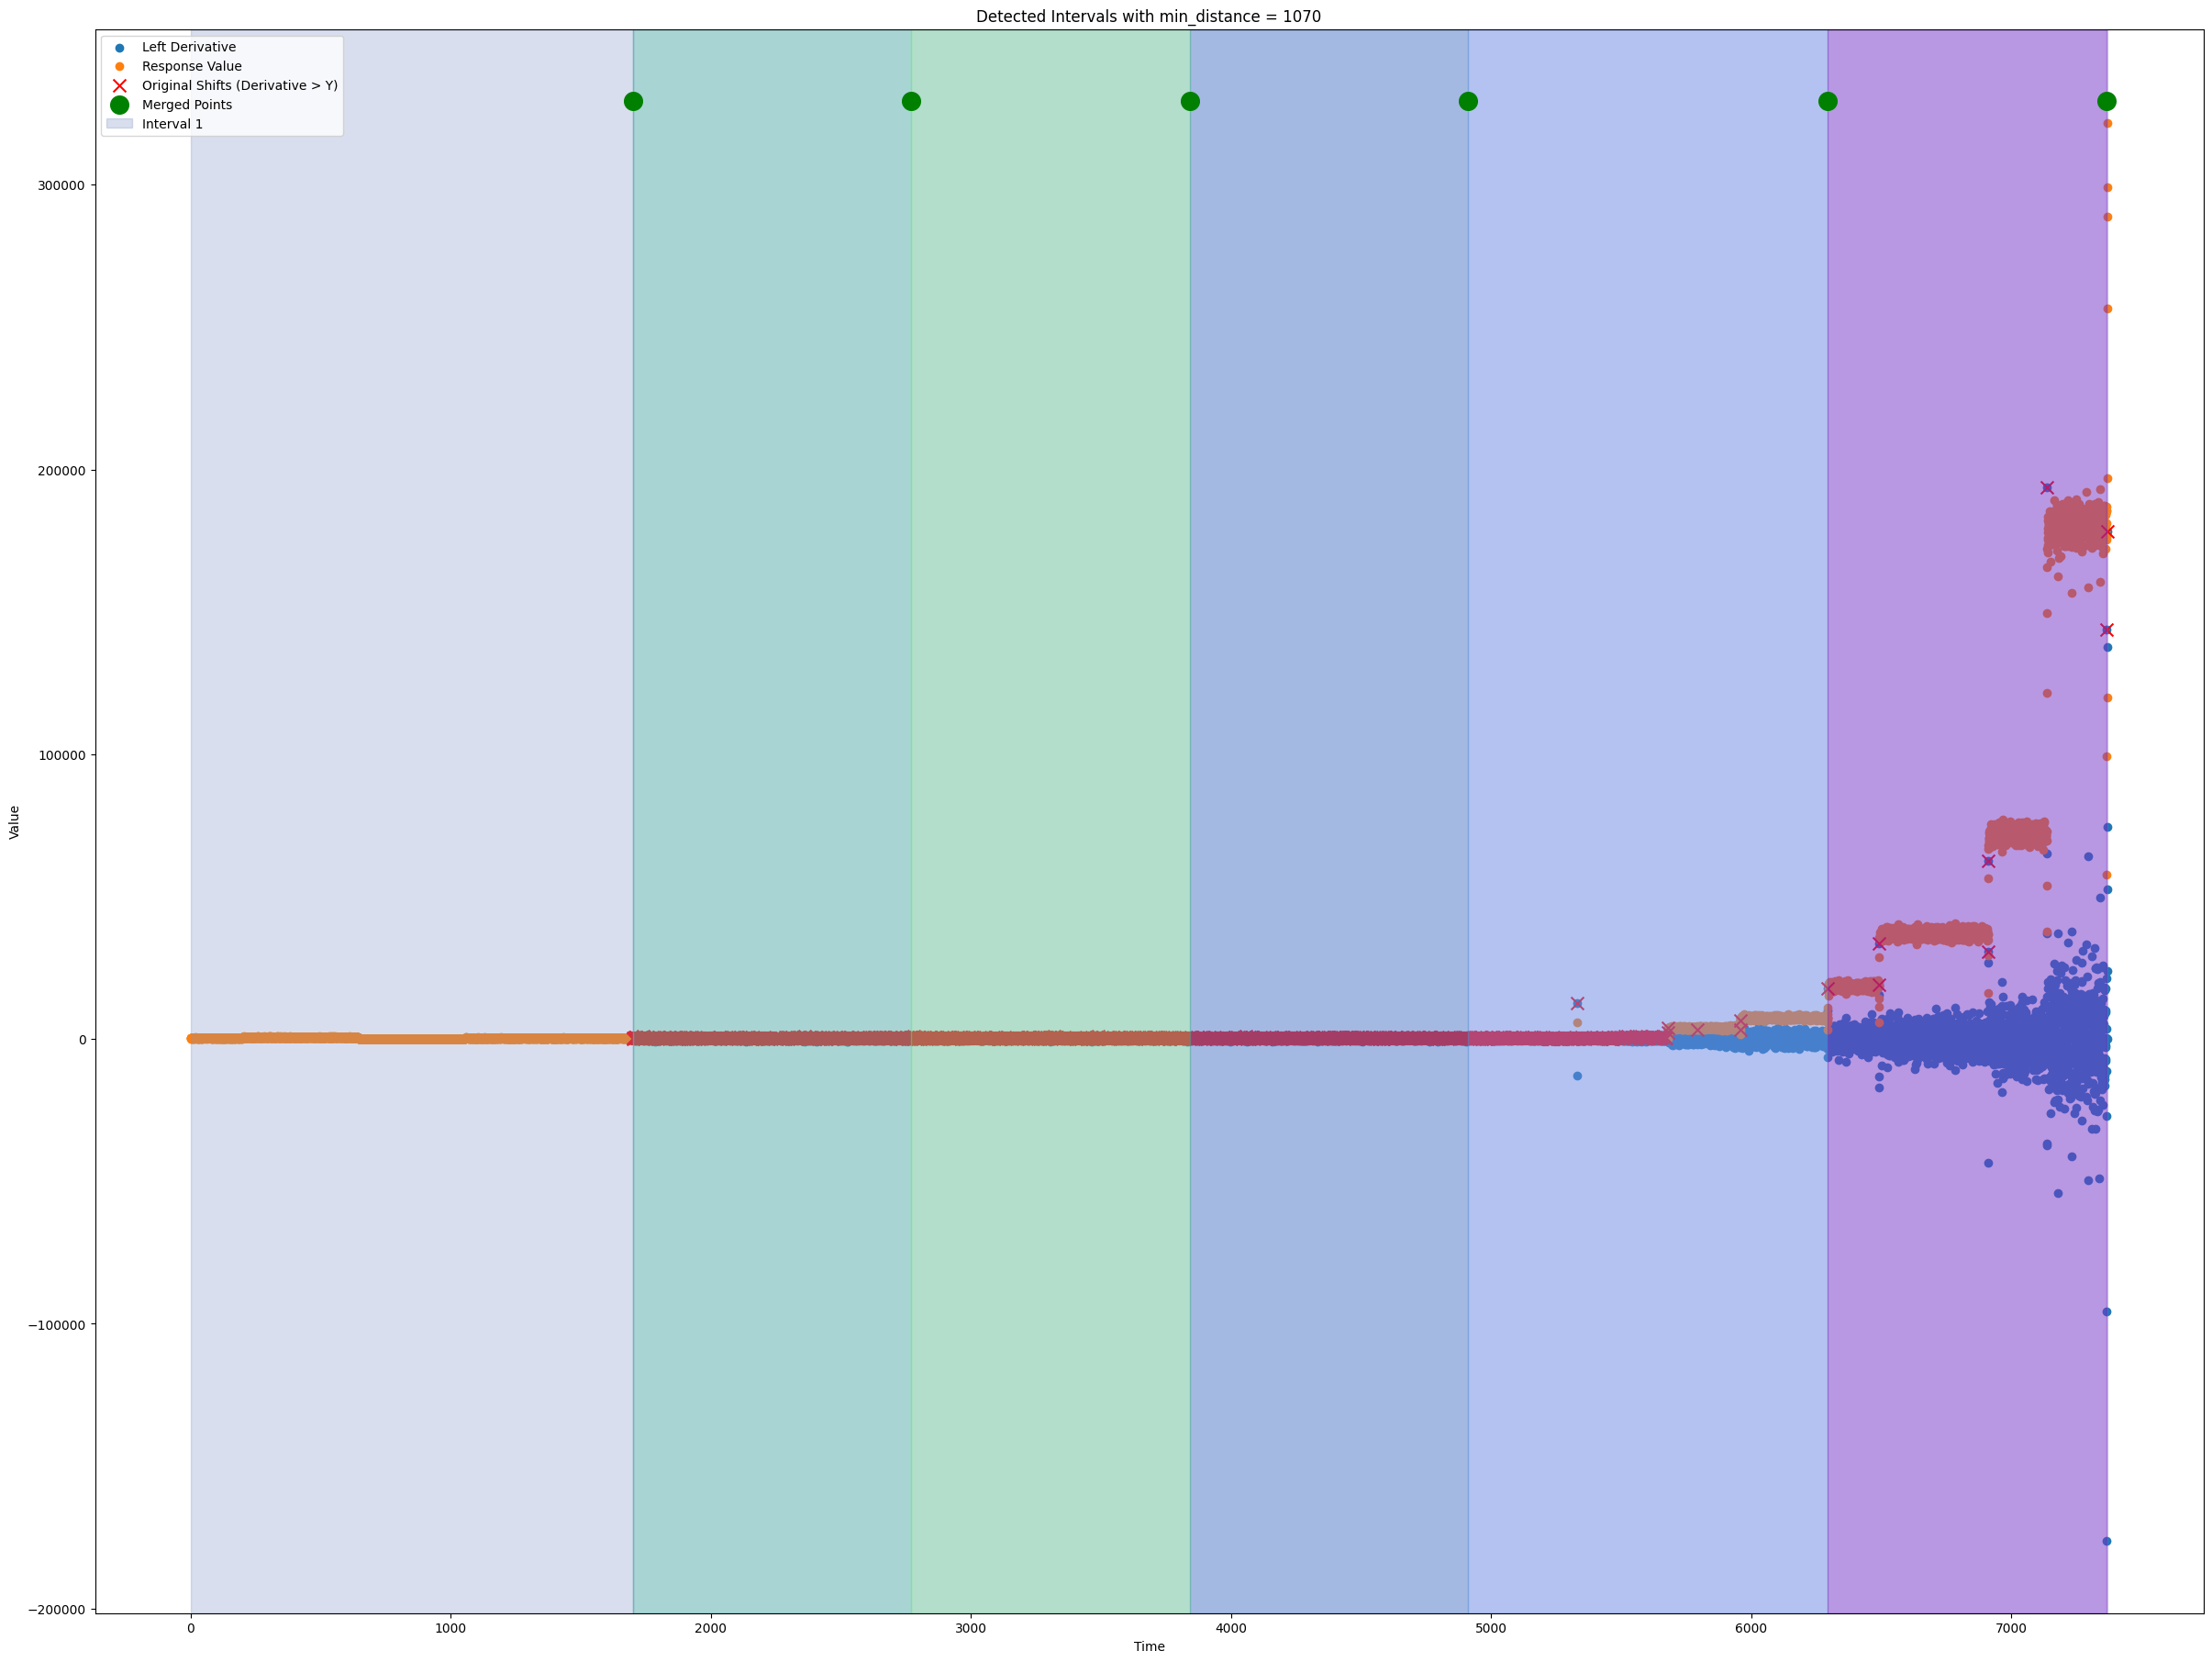


--- Testing with min_distance = 1090 ---
Number of merged points for min_distance 1090: 5
Detected intervals for min_distance 1090:


[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2793.847),
 (np.float64(1699.982), np.float64(7370.625)),
 (2793.847, 3884.687),
 (3884.687, 4979.416),
 (4979.416, 6294.905)]

<Figure size 640x480 with 0 Axes>

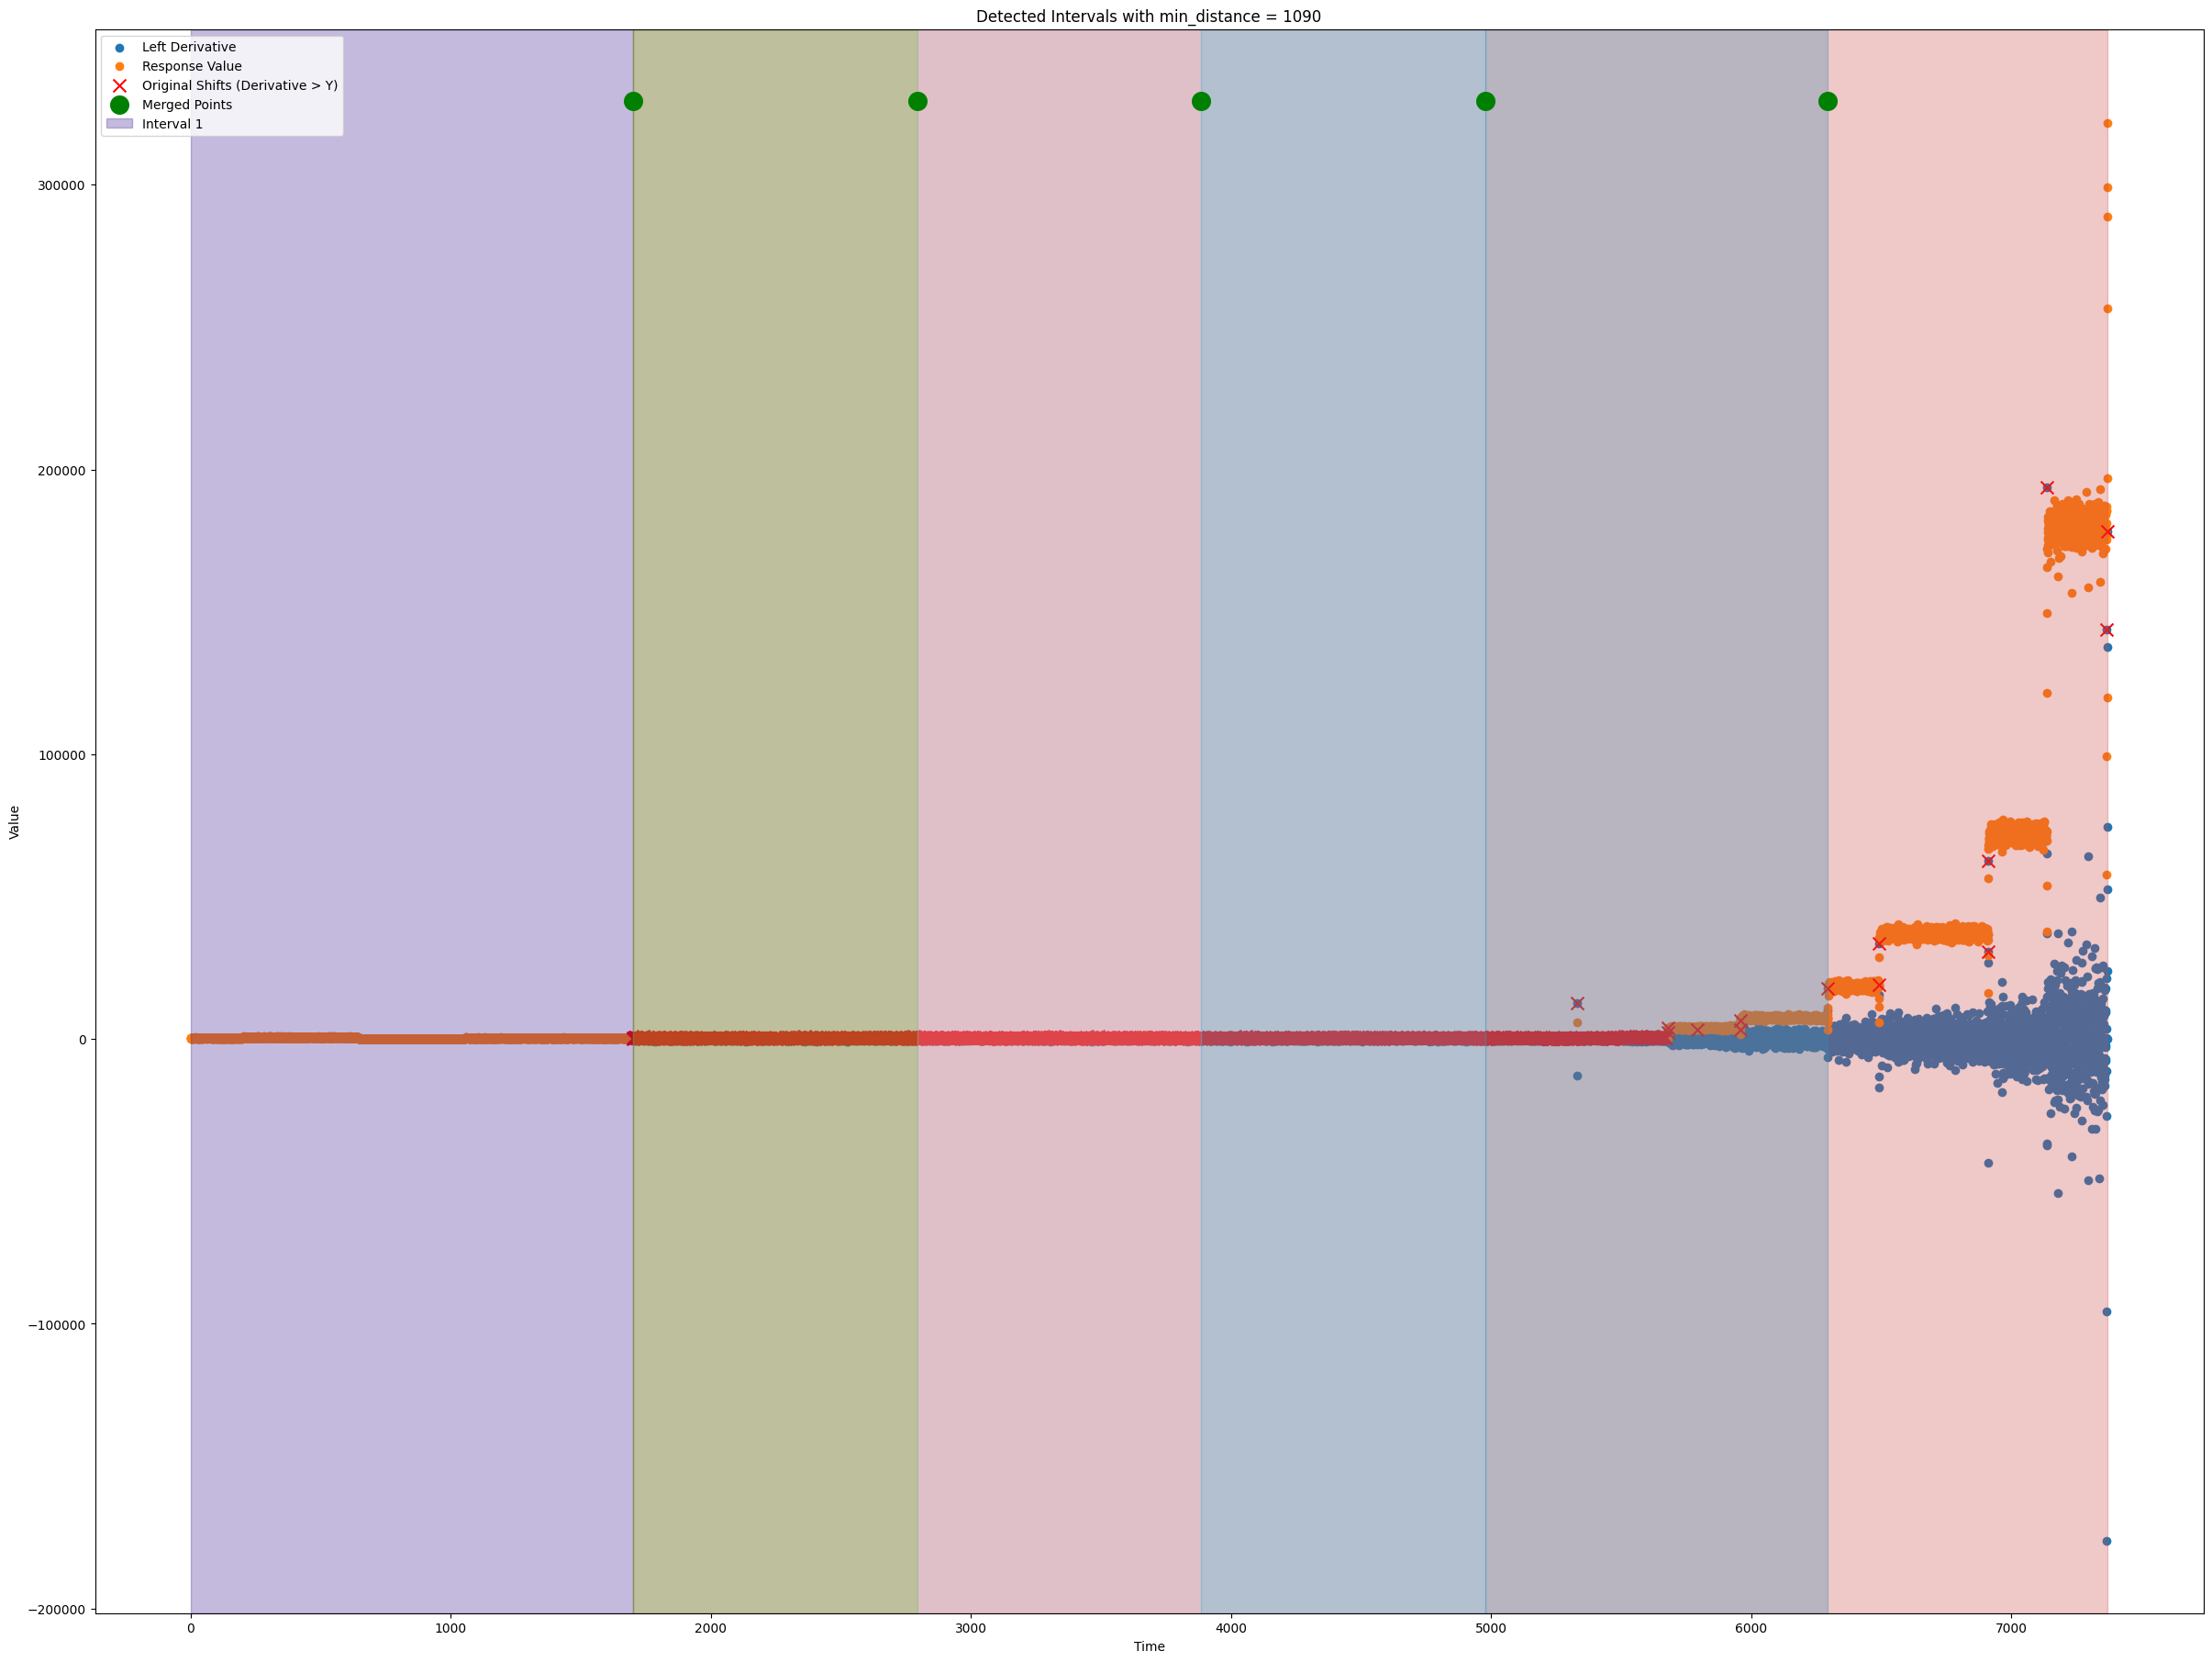

<Figure size 640x480 with 0 Axes>

In [179]:
min_dist = 50

while True:
    
    print(f"\n--- Testing with min_distance = {min_dist} ---")

    # Re-calculate merged_points for the current min_distance
    merged_points = merge_close_points(shifts.tolist(), min_distance=min_dist)
    print(f"Number of merged points for min_distance {min_dist}: {len(merged_points)}")


    fig, ax1 = plt.subplots(figsize=(24, 18), layout='constrained')
    ax1.set_title(f'Detected Intervals with min_distance = {min_dist}')

    # Plot original data and derivatives
    ax1.scatter(left_derivatives_df_c['Time'], left_derivatives_df_c['Left_Derivative'], label='Left Derivative')
    ax1.scatter(df_c['Time'], df_c[response], label='Response Value')

    # Plot the original 'shifts' as red 'x' marks
    ax1.scatter(shifts, left_derivatives_df_c[left_derivatives_df_c['Left_Derivative'] > left_derivatives_df_c['Y']]['Left_Derivative'],
                marker='x', color='red', s=100, label='Original Shifts (Derivative > Y)')

    # Add the merged points to the plot as green circles
    ax1.scatter(merged_points, [ax1.get_ylim()[1] * 0.95] * len(merged_points),
                marker='o', color='green', s=200, zorder=5, label='Merged Points') # Plot high up to be visible

    # Recalculate detected intervals based on the current merged_points
    detected_intervals = [(0, first_region)]

    for i in range(len(merged_points)-1):
        start_p = merged_points[i]
        next_p = merged_points[i+1]
        detected_intervals.append((start_p, next_p))
    

    detected_intervals.append((detected_intervals[0][1], shifts.min()))
    detected_intervals.append((detected_intervals[-1][1], left_derivatives_df_c['Time'].max()))
    detected_intervals = sorted(detected_intervals)

    print(f"Detected intervals for min_distance {min_dist}:")
    display(detected_intervals)

    # Iterate through the detected intervals and shade them
    for i, (start_time, end_time) in enumerate(detected_intervals):
        random_color = (random.random(), random.random(), random.random())
        ax1.axvspan(start_time, end_time, color=random_color, alpha=0.3,
                    label=f'Interval {i+1}' if i == 0 else "") # Label only the first span for legend

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')
    ax1.legend()
    plt.show()
    plt.savefig(f'{figure_dir}/Regional-Min_Dist-{min_dist}',bbox_inches='tight',dpi=300)

    if len(detected_intervals) == n_clusters:
        break
    else:
        min_dist += 20

We'll map out the intervals that were identified here. 

We can plot the distribution to see a good value to drop at. For now, anything below 90 will not have its outliers dropped.

Let's now remove outliers by the given region. We can use the `remove_outliers_by_region` function defined in the `OutlierUtils` module. 

[(0, np.float64(1699.55)),
 (np.float64(1699.55), np.float64(1699.982)),
 (1699.982, 2783.911),
 (np.float64(1699.982), np.float64(7370.625)),
 (2783.911, 3864.815),
 (3864.815, 4948.311),
 (4948.311, 6294.905)]

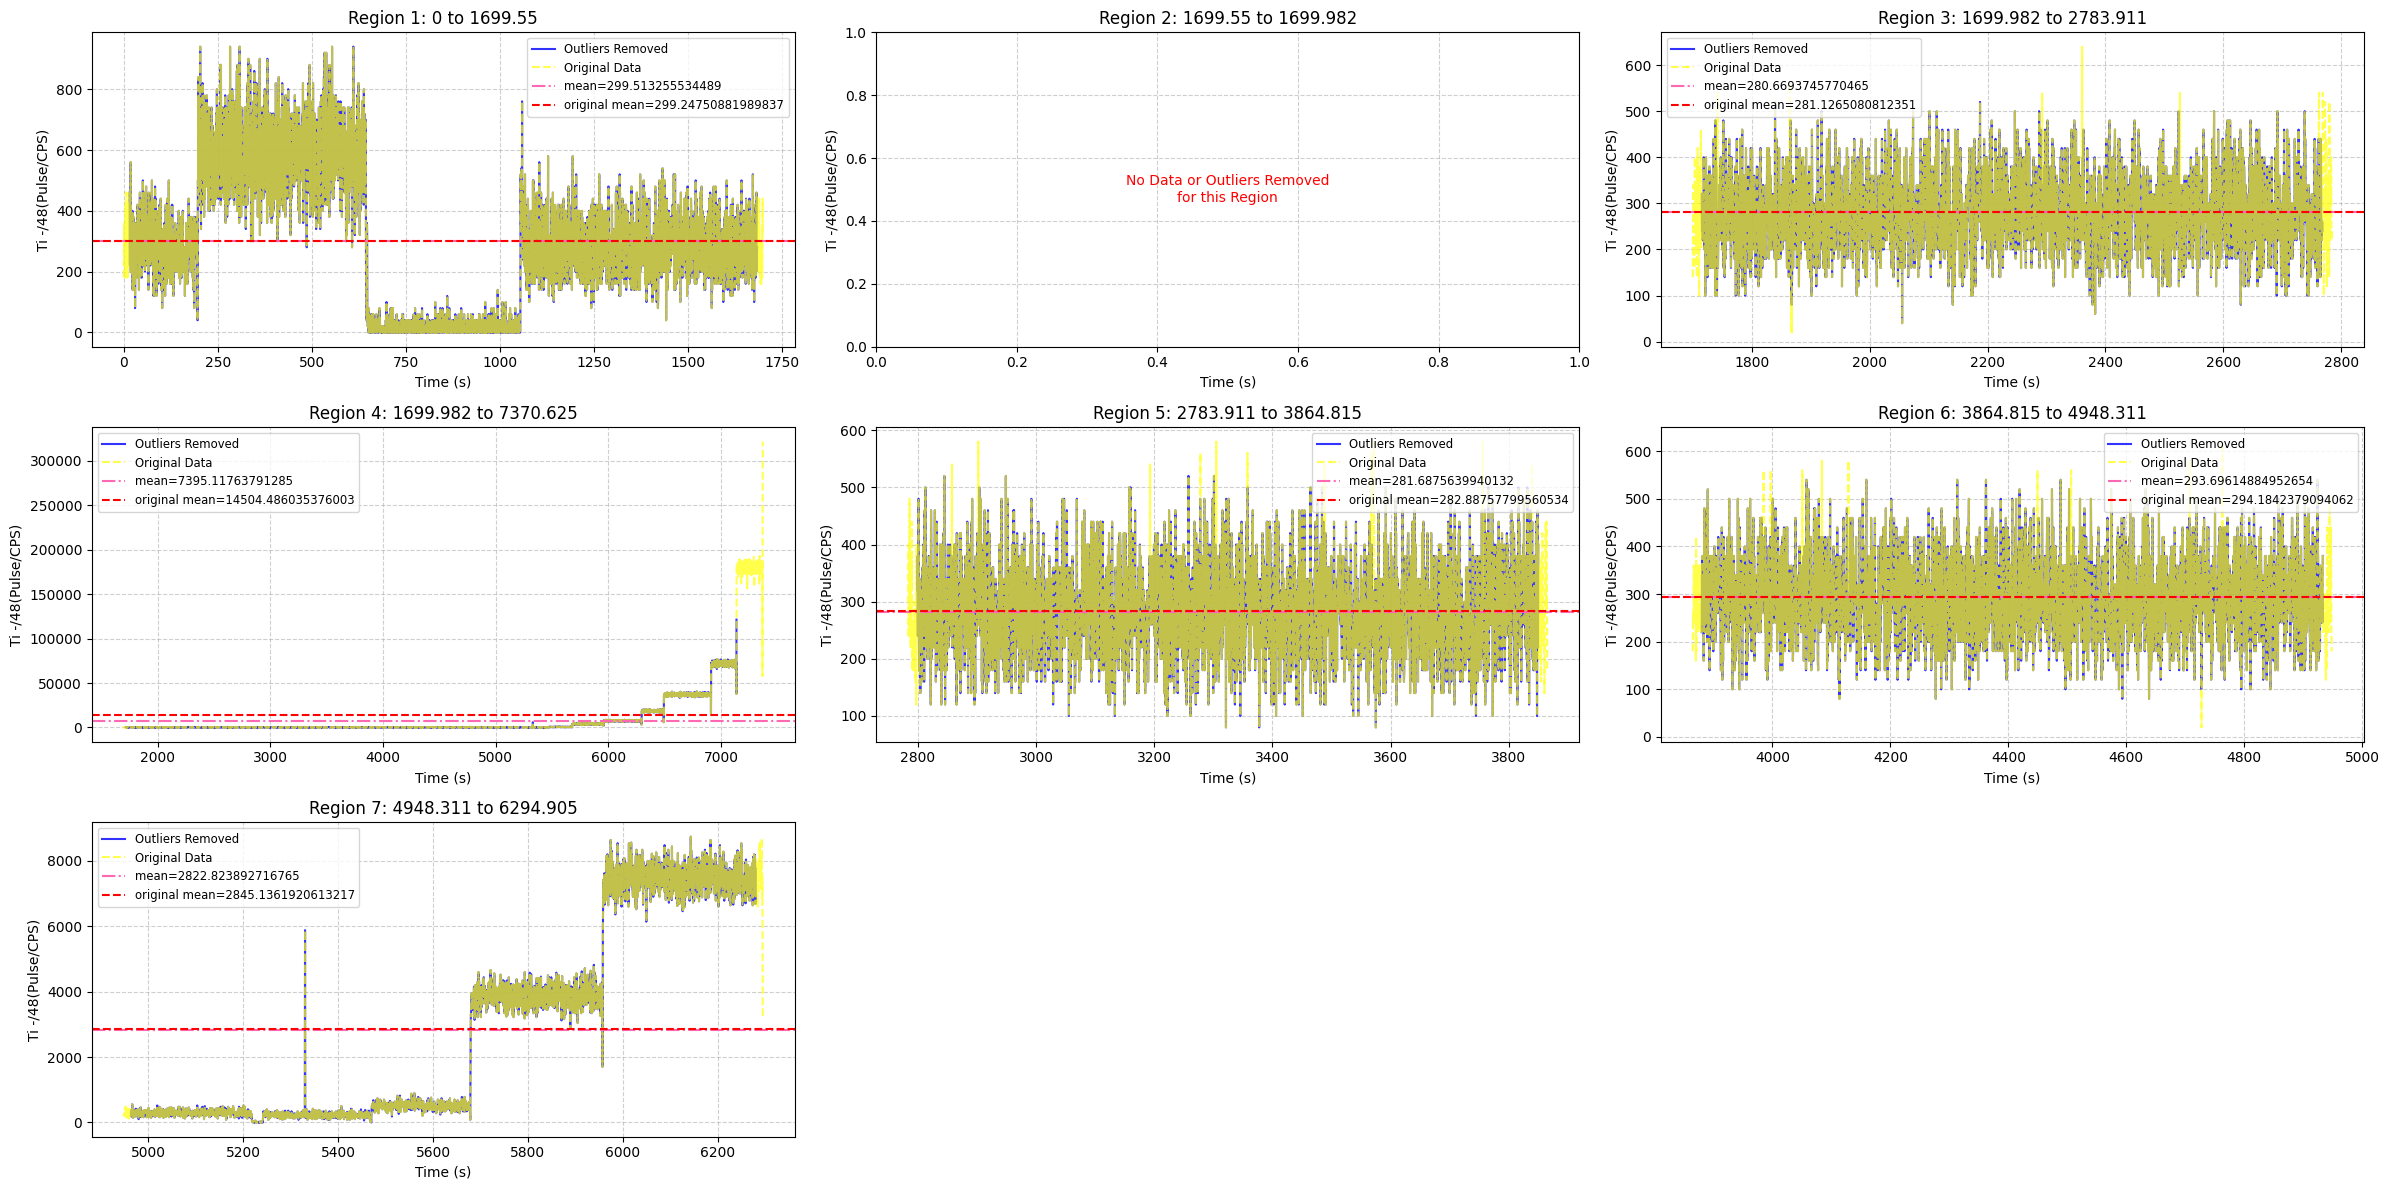

In [176]:
regional_means = []

num_regions = len(detected_intervals)
ncols = 3 # You can change the number of columns
nrows = (num_regions + ncols - 1) // ncols

offset = 15 # 15 seconds offset to 

final_df = pd.DataFrame()


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 4 * nrows))
axes_flat = axes.flatten() # Flatten the 2D axes array for easier iteration
display(detected_intervals)
for i, (x0, x1) in enumerate(detected_intervals):
    # Get the current Axes object for this iteration from the flattened array
    if i < len(axes_flat):
        current_ax = axes_flat[i]
    else:
        # This case should ideally not happen if nrows is calculated correctly,
        # but provides a safeguard if more plots are attempted than subplots available.
       logging.warning(f" Not enough subplots for region {i+1}. Skipping plot.")
        continue
    

    # Call your outlier removal function for the current region
    Y_prime = remove_outliers_by_region(R=[x0 + offset, x1 - offset], response_column_name=response, Y=df)
    
    # print(f'New Region {i+1}: ({val['Start'] + offset}, {val['End'] - offset})')

    # Plot the results on the current subplot
    if not Y_prime.empty:
        # Plot the data after outlier removal
        current_ax.plot(Y_prime['Time'], Y_prime[response], label='Outliers Removed', color='blue', alpha=0.8)
        
        # Plot original data for comparison (only within the current region)

        original_region_data = df[(df['Time'] >= x0) & (df['Time'] <= x1)]
        
        
        current_ax.plot(original_region_data['Time'], original_region_data[response],
                        '--', color='yellow', alpha=0.7, label='Original Data')
        
        region_mean = Y_prime[response].mean()
        original_mean = original_region_data[response].mean()
        
        current_ax.axhline(y=region_mean, color='#FF69B4', linestyle='-.', label=f'mean={region_mean}')
        current_ax.axhline(y=original_mean, color='red', linestyle='--', label=f'original mean={original_mean}')

        regional_means.append(region_mean)
        
        current_ax.legend(fontsize='small')
    else:
        current_ax.text(0.5, 0.5, 'No Data or Outliers Removed\nfor this Region',
                        horizontalalignment='center', verticalalignment='center',
                        transform=current_ax.transAxes, fontsize=10, color='red')

    # Set titles and labels for the current subplot
    current_ax.set_title(f'Region {i+1}: {x0} to {x1}')
    current_ax.set_xlabel('Time (s)')
    current_ax.set_ylabel(f'{response}')
    current_ax.grid(True, linestyle='--', alpha=0.6) # Add a grid for better readability

    final_df = pd.concat([final_df, Y_prime], ignore_index=True)



# This prevents empty plots from appearing if your `area_df` has fewer regions than the grid size
for j in range(num_regions, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.savefig(f'{figure_dir}/Regional-Column-Figure.png',
             bbox_inches='tight',
             dpi=300)
plt.tight_layout() # Automatically adjust subplot parameters for a tight layout
plt.show() # Display the plot
    
# plt.tight_layout()
# plt.show()

In [177]:
final_df = final_df.sort_index()

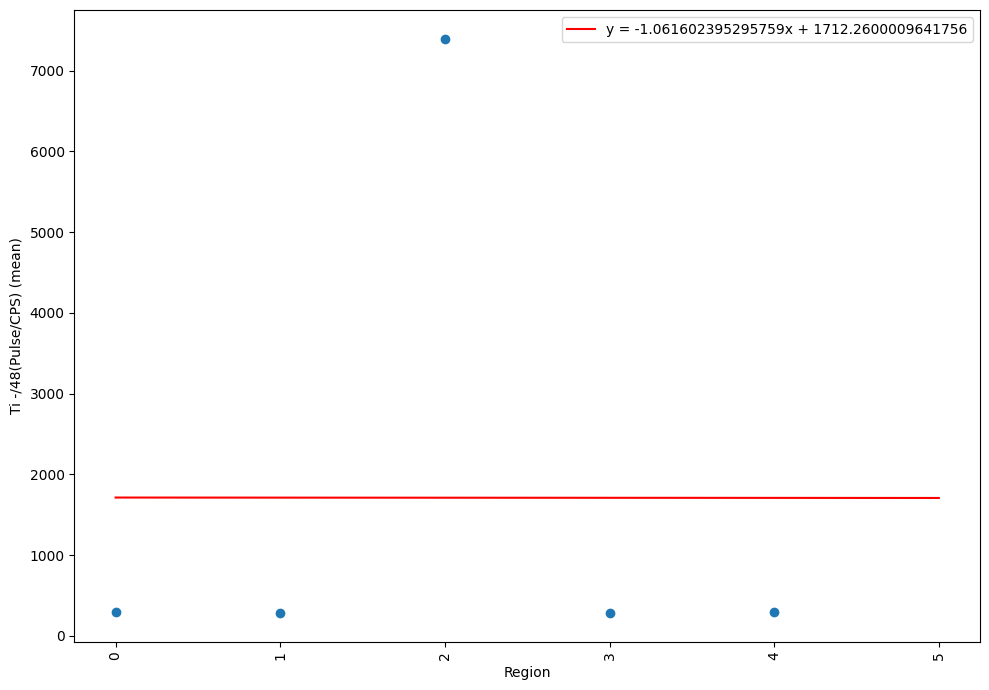

In [178]:
# Plot regional means
labels = np.arange(len(regional_means))
fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot the bars
ax1.scatter(labels[:-1], regional_means[:-1])  # Convert index to string for proper label display
m,b = np.polyfit(labels[:-1], regional_means[:-1], 1)
np.polyfit


# Find regression equation
if b >= 0:
    line_label = f'y = {m}x + {b}'
else:
    line_label = f'y = {m}x - {-b}' # Use -b to show a positive number after the minus sign

ax1.plot(labels, m*labels + b, color='red', label=line_label)


plt.legend()

ax1.set_xlabel('Region')
ax1.set_ylabel(f'{response} (mean)')

# Improve tick display
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels,rotation=90)  # Rotate for better readability
plt.tight_layout()
plt.savefig(f'{figure_dir}/Regression-Plot.png', bbox_inches='tight',dpi=300)
plt.show()


$$ \textit{Opus ex amino, } \\ \text{Bhagawat Chapagain} $$